In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

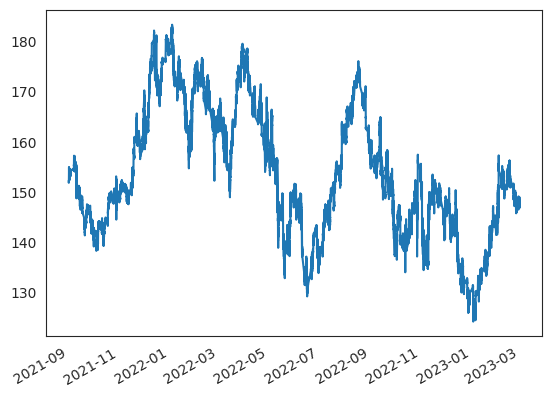

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_3,ema_5,ema_8,ema_9,ema_13,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,152.096413,152.018578,151.964327,151.953148,151.923549,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.40,151.80,0.000591,0.003348,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,0.948276,0.871648,0.948276,0.816092,466.666667,500.000000,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.203206,152.115719,152.041143,152.024518,151.978756,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.40,151.80,0.000591,0.003348,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,0.896552,0.911239,0.896552,0.892720,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.251603,152.177146,152.098667,152.079614,152.024648,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44.722948,76.313395,8.6

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df = df_inds # SELECT THE CORRECT DATAFRAME
df.close.plot()
plt.show()
df

In [5]:
##### 95 ######
# {'reset_peak': (0, 0),
#  'rsi_min_thresh': (43, 47),
#  'rsi_max_thresh': (49, 51),
#  'adx_thresh': (54.182016788650685, 54.99579321134931),
#  'atr_mult': (16.694410274720497, 18.336149725279498),
#  'vwap_atr_mult': (-0.21776640620967802, 0.617386406209678),
#  'buy_factor': (0.7414908137030546, 0.8158391862969453),
#  'sell_factor': (0.03504106095237648, 0.05612893904762352),
#  'trailstop_pct': (18.313730235902057, 30.31062976409794),
#  'sign_thresh_pair': {'categorical': ['ema_3|ema_8']}}

In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    reset_peak       = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 30, 50)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 45), 55)
    adx_thresh       = trial.suggest_float("adx_thresh", 53.0, 57.0)
    atr_mult         = trial.suggest_float("atr_mult", 15.5, 19, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", -1, 2)
    buy_factor       = trial.suggest_float("buy_factor", 0.6, 0.85)
    sell_factor      = trial.suggest_float("sell_factor", 0.03, 0.07)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 10.0, 30.0)
    sign_thresh_pair = trial.suggest_categorical("sign_thresh_pair",[ 
                                                    "ema_3|ema_8",
                                                    # "ema_5|ema_13",
                                                    # "ema_9|ema_21",
                                                    # "ema_21|ema_50",
                                                    # "roc_5|ema_21"
                                                    # "roc_5|0.0"
                                                    # "macd_line_12_26_9|0.0"
                                                    # "macd_diff_6_13_5|0.0"
                                                    # "rsi_14|50.0"
                                                    # "rsi_6|50.0"
                                                ])
    col_signal, sign_thresh = sign_thresh_pair.split("|")
    try: # convert numeric thresholds (only if numeric)
        sign_thresh = float(sign_thresh)
    except ValueError:
        pass
    
    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            col_signal      = col_signal,
            sign_thresh     = sign_thresh,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)


Baseline mean daily B&H: -9.5162


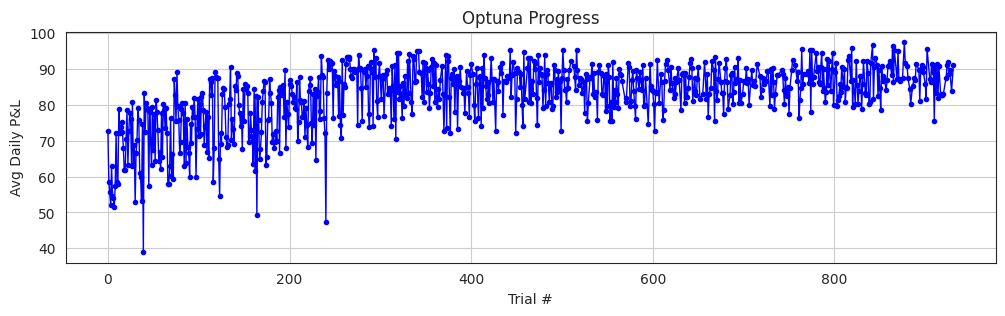

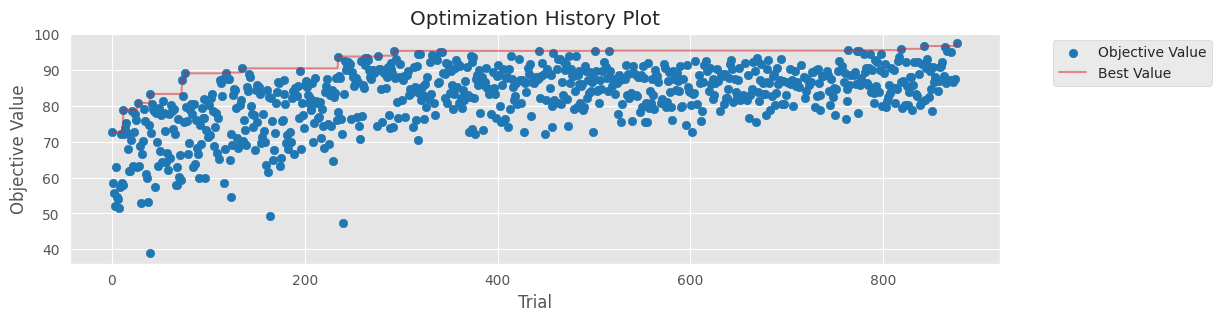

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=54; adx_thresh=54.42636058180685; atr_mult=17.38432777926412; vwap_atr_mult=-0.10328082748973211; buy_factor=0.7877507107092871; sell_factor=0.03229007299179622; trailstop_pct=28.71704946519504; sign_thresh_pair=ema_3|ema_8


Trial 0: 100%|██████████| 375/375 [01:03<00:00,  5.89it/s]


[Results] mean_pnl:63.9818 mean_bh:-8.7491 mean_excess:72.7309 improv_vs_bh:831.30%
Action counts: {'Buy': 1011, 'Sell': 20467, 'Hold': 329233}
Best trial is: 0 with best_val: 72.7309
[save_results] wrote optuna_results/AAPL_72.7309_predicted.csv
[save_best_json] wrote optuna_results/AAPL_72.7309_predicted.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=55; adx_thresh=55.949024638698205; atr_mult=17.23575007987668; vwap_atr_mult=-0.9123955370961492; buy_factor=0.7815110618647372; sell_factor=0.03497118614804268; trailstop_pct=25.326699759403265; sign_thresh_pair=ema_3|ema_8


Trial 1: 100%|██████████| 375/375 [01:19<00:00,  4.69it/s]


[Results] mean_pnl:49.6144 mean_bh:-8.7491 mean_excess:58.3635 improv_vs_bh:667.08%
Action counts: {'Buy': 898, 'Sell': 18529, 'Hold': 331284}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=49; adx_thresh=54.348415711068306; atr_mult=17.23924407940028; vwap_atr_mult=1.8830320291849882; buy_factor=0.8001198310563253; sell_factor=0.05766751818843472; trailstop_pct=26.227118619599864; sign_thresh_pair=ema_3|ema_8


Trial 2: 100%|██████████| 375/375 [00:50<00:00,  7.43it/s]


[Results] mean_pnl:47.0483 mean_bh:-8.7491 mean_excess:55.7974 improv_vs_bh:637.75%
Action counts: {'Buy': 739, 'Sell': 12446, 'Hold': 337526}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=55; adx_thresh=54.76139925417655; atr_mult=16.234215573009678; vwap_atr_mult=1.0211027455628123; buy_factor=0.7509450768004033; sell_factor=0.05462082300093314; trailstop_pct=14.079353691420256; sign_thresh_pair=ema_3|ema_8


Trial 3: 100%|██████████| 375/375 [00:42<00:00,  8.93it/s]


[Results] mean_pnl:43.2195 mean_bh:-8.7491 mean_excess:51.9686 improv_vs_bh:593.99%
Action counts: {'Buy': 973, 'Sell': 15103, 'Hold': 334635}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=56.242149392059986; atr_mult=15.51172084815578; vwap_atr_mult=1.6341782649727583; buy_factor=0.7150733540666246; sell_factor=0.03656926340494973; trailstop_pct=13.209920278724013; sign_thresh_pair=ema_3|ema_8


Trial 4: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:54.3347 mean_bh:-8.7491 mean_excess:63.0838 improv_vs_bh:721.03%
Action counts: {'Buy': 747, 'Sell': 15012, 'Hold': 334952}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=46; adx_thresh=56.16420967168269; atr_mult=17.25975553052735; vwap_atr_mult=0.03308060044372496; buy_factor=0.6602310043381558; sell_factor=0.06063880367403721; trailstop_pct=22.748056656502623; sign_thresh_pair=ema_3|ema_8


Trial 5: 100%|██████████| 375/375 [00:29<00:00, 12.75it/s]


[Results] mean_pnl:45.9455 mean_bh:-8.7491 mean_excess:54.6945 improv_vs_bh:625.15%
Action counts: {'Buy': 902, 'Sell': 11138, 'Hold': 338671}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=55; adx_thresh=56.6826456860302; atr_mult=17.230312496154976; vwap_atr_mult=0.37857509303005843; buy_factor=0.8249086067166258; sell_factor=0.06899467257609751; trailstop_pct=24.091041317735616; sign_thresh_pair=ema_3|ema_8


Trial 6: 100%|██████████| 375/375 [00:30<00:00, 12.49it/s]


[Results] mean_pnl:45.2950 mean_bh:-8.7491 mean_excess:54.0441 improv_vs_bh:617.71%
Action counts: {'Buy': 683, 'Sell': 11201, 'Hold': 338827}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=48; adx_thresh=54.721049309537314; atr_mult=16.276241370510466; vwap_atr_mult=1.4487391517971568; buy_factor=0.697183736580799; sell_factor=0.037147785991295264; trailstop_pct=16.816996367002623; sign_thresh_pair=ema_3|ema_8


Trial 7: 100%|██████████| 375/375 [00:27<00:00, 13.55it/s]


[Results] mean_pnl:42.6994 mean_bh:-8.7491 mean_excess:51.4484 improv_vs_bh:588.04%
Action counts: {'Buy': 937, 'Sell': 15627, 'Hold': 334147}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=55; adx_thresh=54.99128641765991; atr_mult=17.2313136712021; vwap_atr_mult=1.8104738203501571; buy_factor=0.7770864653711506; sell_factor=0.042101686332316327; trailstop_pct=26.62625749565828; sign_thresh_pair=ema_3|ema_8


Trial 8: 100%|██████████| 375/375 [00:37<00:00,  9.90it/s]


[Results] mean_pnl:48.7347 mean_bh:-8.7491 mean_excess:57.4838 improv_vs_bh:657.03%
Action counts: {'Buy': 871, 'Sell': 16544, 'Hold': 333296}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=56.570846823734676; atr_mult=18.605134719832005; vwap_atr_mult=-0.8997882748916515; buy_factor=0.826454950530637; sell_factor=0.05295614995579319; trailstop_pct=12.420437064727182; sign_thresh_pair=ema_3|ema_8


Trial 9: 100%|██████████| 375/375 [00:39<00:00,  9.45it/s]


[Results] mean_pnl:63.2662 mean_bh:-8.7491 mean_excess:72.0152 improv_vs_bh:823.12%
Action counts: {'Buy': 683, 'Sell': 12465, 'Hold': 337563}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=53; adx_thresh=53.1982376382221; atr_mult=18.493853682206463; vwap_atr_mult=-0.22683587782891523; buy_factor=0.6396441091626733; sell_factor=0.030081885557694605; trailstop_pct=29.65456946970804; sign_thresh_pair=ema_3|ema_8


Trial 10: 100%|██████████| 375/375 [00:27<00:00, 13.80it/s]


[Results] mean_pnl:49.6904 mean_bh:-8.7491 mean_excess:58.4395 improv_vs_bh:667.95%
Action counts: {'Buy': 1385, 'Sell': 21659, 'Hold': 327667}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=53.99325629872718; atr_mult=18.742574873199008; vwap_atr_mult=-0.8280563088540938; buy_factor=0.8469482395426334; sell_factor=0.046394878160829545; trailstop_pct=16.774065957878925; sign_thresh_pair=ema_3|ema_8


Trial 11: 100%|██████████| 375/375 [00:56<00:00,  6.65it/s]


[Results] mean_pnl:49.0712 mean_bh:-8.7491 mean_excess:57.8203 improv_vs_bh:660.87%
Action counts: {'Buy': 929, 'Sell': 16729, 'Hold': 333053}
Best trial is: 0 with best_val: 72.7309
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=55.35123786498544; atr_mult=18.06285879333285; vwap_atr_mult=-0.37476337250276714; buy_factor=0.8218697326501181; sell_factor=0.05173023854044992; trailstop_pct=10.63582407939667; sign_thresh_pair=ema_3|ema_8


Trial 12: 100%|██████████| 375/375 [01:19<00:00,  4.72it/s]


[Results] mean_pnl:70.1133 mean_bh:-8.7491 mean_excess:78.8623 improv_vs_bh:901.38%
Action counts: {'Buy': 796, 'Sell': 14588, 'Hold': 335327}
Best trial is: 12 with best_val: 78.8623
[save_results] wrote optuna_results/AAPL_78.8623_predicted.csv
[save_best_json] wrote optuna_results/AAPL_78.8623_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=55.538305166004704; atr_mult=17.942506336264255; vwap_atr_mult=-0.30012422936471955; buy_factor=0.7487066340678964; sell_factor=0.04649838965902498; trailstop_pct=10.146228188047962; sign_thresh_pair=ema_3|ema_8


Trial 13: 100%|██████████| 375/375 [01:22<00:00,  4.55it/s]


[Results] mean_pnl:63.3930 mean_bh:-8.7491 mean_excess:72.1421 improv_vs_bh:824.57%
Action counts: {'Buy': 903, 'Sell': 15212, 'Hold': 334596}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=53; adx_thresh=55.49939736225866; atr_mult=17.98056877599809; vwap_atr_mult=0.6237296665416755; buy_factor=0.8028732972228846; sell_factor=0.06248437967564331; trailstop_pct=20.2358191016917; sign_thresh_pair=ema_3|ema_8


Trial 14: 100%|██████████| 375/375 [00:57<00:00,  6.55it/s]


[Results] mean_pnl:64.9644 mean_bh:-8.7491 mean_excess:73.7135 improv_vs_bh:842.53%
Action counts: {'Buy': 773, 'Sell': 12588, 'Hold': 337350}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=55.52386334769814; atr_mult=17.9702343518431; vwap_atr_mult=0.8820876769108787; buy_factor=0.8178421700893626; sell_factor=0.06428144131791654; trailstop_pct=19.623829296549463; sign_thresh_pair=ema_3|ema_8


Trial 15: 100%|██████████| 375/375 [01:13<00:00,  5.12it/s]


[Results] mean_pnl:66.4417 mean_bh:-8.7491 mean_excess:75.1908 improv_vs_bh:859.41%
Action counts: {'Buy': 725, 'Sell': 12011, 'Hold': 337975}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=55.30502197061115; atr_mult=17.97932655130439; vwap_atr_mult=0.9833441767848148; buy_factor=0.6095465263178059; sell_factor=0.06828581088133129; trailstop_pct=19.899517689680344; sign_thresh_pair=ema_3|ema_8


Trial 16: 100%|██████████| 375/375 [01:07<00:00,  5.58it/s]


[Results] mean_pnl:63.8215 mean_bh:-8.7491 mean_excess:72.5706 improv_vs_bh:829.46%
Action counts: {'Buy': 1044, 'Sell': 11155, 'Hold': 338512}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=47; adx_thresh=56.96968331225821; atr_mult=18.206084851274543; vwap_atr_mult=0.4101069405465628; buy_factor=0.8493009790486254; sell_factor=0.06423601168313971; trailstop_pct=16.254944281453398; sign_thresh_pair=ema_3|ema_8


Trial 17: 100%|██████████| 375/375 [00:46<00:00,  8.13it/s]


[Results] mean_pnl:59.2260 mean_bh:-8.7491 mean_excess:67.9751 improv_vs_bh:776.94%
Action counts: {'Buy': 565, 'Sell': 9567, 'Hold': 340579}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=51; adx_thresh=55.76072623256643; atr_mult=18.986688135471518; vwap_atr_mult=-0.5125336618802843; buy_factor=0.7510580212072482; sell_factor=0.04977660901457771; trailstop_pct=10.202397150038905; sign_thresh_pair=ema_3|ema_8


Trial 18: 100%|██████████| 375/375 [00:52<00:00,  7.13it/s]


[Results] mean_pnl:52.9600 mean_bh:-8.7491 mean_excess:61.7091 improv_vs_bh:705.32%
Action counts: {'Buy': 858, 'Sell': 13983, 'Hold': 335870}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=53; adx_thresh=53.702983648330694; atr_mult=17.63413090239108; vwap_atr_mult=0.8495579768017161; buy_factor=0.8201717439812772; sell_factor=0.05765929614141143; trailstop_pct=20.696142316719772; sign_thresh_pair=ema_3|ema_8


Trial 19: 100%|██████████| 375/375 [00:35<00:00, 10.60it/s]


[Results] mean_pnl:53.1916 mean_bh:-8.7491 mean_excess:61.9407 improv_vs_bh:707.97%
Action counts: {'Buy': 895, 'Sell': 15130, 'Hold': 334686}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=51; adx_thresh=55.193396526480726; atr_mult=16.794272014598516; vwap_atr_mult=1.3631935024685848; buy_factor=0.6911320162292476; sell_factor=0.04167664929164556; trailstop_pct=17.958927383994858; sign_thresh_pair=ema_3|ema_8


Trial 20: 100%|██████████| 375/375 [00:35<00:00, 10.65it/s]


[Results] mean_pnl:61.6130 mean_bh:-8.7491 mean_excess:70.3621 improv_vs_bh:804.22%
Action counts: {'Buy': 939, 'Sell': 15435, 'Hold': 334337}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=53; adx_thresh=55.46303176774754; atr_mult=17.709057054470193; vwap_atr_mult=0.6355078828452667; buy_factor=0.8080120590849026; sell_factor=0.06281068507225335; trailstop_pct=21.075676699860473; sign_thresh_pair=ema_3|ema_8


Trial 21: 100%|██████████| 375/375 [00:24<00:00, 15.01it/s]


[Results] mean_pnl:69.9359 mean_bh:-8.7491 mean_excess:78.6850 improv_vs_bh:899.35%
Action counts: {'Buy': 766, 'Sell': 12714, 'Hold': 337231}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=55.78807093026907; atr_mult=17.66031489700239; vwap_atr_mult=0.13639672573812345; buy_factor=0.7650554835406891; sell_factor=0.06445145744625261; trailstop_pct=22.36016031112362; sign_thresh_pair=ema_3|ema_8


Trial 22: 100%|██████████| 375/375 [00:27<00:00, 13.65it/s]


[Results] mean_pnl:54.4039 mean_bh:-8.7491 mean_excess:63.1530 improv_vs_bh:721.82%
Action counts: {'Buy': 860, 'Sell': 12184, 'Hold': 337667}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=54; adx_thresh=54.969716799597265; atr_mult=18.275686539200997; vwap_atr_mult=0.7793403953835775; buy_factor=0.8120370247472859; sell_factor=0.05810744440249125; trailstop_pct=18.047749546812774; sign_thresh_pair=ema_3|ema_8


Trial 23: 100%|██████████| 375/375 [00:29<00:00, 12.55it/s]


[Results] mean_pnl:64.0635 mean_bh:-8.7491 mean_excess:72.8125 improv_vs_bh:832.23%
Action counts: {'Buy': 796, 'Sell': 13600, 'Hold': 336315}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=55.392356938186936; atr_mult=16.736473986724306; vwap_atr_mult=1.2039735866690393; buy_factor=0.8378048073789647; sell_factor=0.06685484283829671; trailstop_pct=15.119952931276693; sign_thresh_pair=ema_3|ema_8


Trial 24: 100%|██████████| 375/375 [00:27<00:00, 13.72it/s]


[Results] mean_pnl:68.8698 mean_bh:-8.7491 mean_excess:77.6189 improv_vs_bh:887.17%
Action counts: {'Buy': 685, 'Sell': 10866, 'Hold': 339160}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=55.23870449141574; atr_mult=16.790320521166077; vwap_atr_mult=1.23635727191831; buy_factor=0.8414167725170104; sell_factor=0.06984222471342348; trailstop_pct=14.634594948030614; sign_thresh_pair=ema_3|ema_8


Trial 25: 100%|██████████| 375/375 [00:30<00:00, 12.33it/s]


[Results] mean_pnl:67.4315 mean_bh:-8.7491 mean_excess:76.1806 improv_vs_bh:870.73%
Action counts: {'Buy': 691, 'Sell': 10713, 'Hold': 339307}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=56.202929034366164; atr_mult=16.799053728308056; vwap_atr_mult=1.1734010160147499; buy_factor=0.7909982861161581; sell_factor=0.053322298608738966; trailstop_pct=11.796074833602093; sign_thresh_pair=ema_3|ema_8


Trial 26: 100%|██████████| 375/375 [00:27<00:00, 13.52it/s]


[Results] mean_pnl:54.0684 mean_bh:-8.7491 mean_excess:62.8175 improv_vs_bh:717.99%
Action counts: {'Buy': 693, 'Sell': 10961, 'Hold': 339057}
Best trial is: 12 with best_val: 78.8623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.62005092245188; atr_mult=16.44869009037508; vwap_atr_mult=0.2915502040449325; buy_factor=0.8355749178404437; sell_factor=0.06652008562624015; trailstop_pct=15.093947107694575; sign_thresh_pair=ema_3|ema_8


Trial 27: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:72.0571 mean_bh:-8.7491 mean_excess:80.8061 improv_vs_bh:923.59%
Action counts: {'Buy': 810, 'Sell': 12554, 'Hold': 337347}
Best trial is: 27 with best_val: 80.8061
[save_results] wrote optuna_results/AAPL_80.8061_predicted.csv
[save_best_json] wrote optuna_results/AAPL_80.8061_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=48; adx_thresh=54.41075992105036; atr_mult=16.210960084866514; vwap_atr_mult=0.23542959612080744; buy_factor=0.7305433406000658; sell_factor=0.05968678531515812; trailstop_pct=11.756496468407535; sign_thresh_pair=ema_3|ema_8


Trial 28: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:54.4832 mean_bh:-8.7491 mean_excess:63.2323 improv_vs_bh:722.73%
Action counts: {'Buy': 996, 'Sell': 13302, 'Hold': 336413}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=54; adx_thresh=54.19449465724972; atr_mult=17.643695822186448; vwap_atr_mult=-0.5543617059294568; buy_factor=0.7704596484485084; sell_factor=0.06569743183707441; trailstop_pct=21.541006106123646; sign_thresh_pair=ema_3|ema_8


Trial 29: 100%|██████████| 375/375 [00:33<00:00, 11.35it/s]


[Results] mean_pnl:59.9239 mean_bh:-8.7491 mean_excess:68.6730 improv_vs_bh:784.92%
Action counts: {'Buy': 1092, 'Sell': 14246, 'Hold': 335373}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=54; adx_thresh=54.688308312381984; atr_mult=15.784318279467069; vwap_atr_mult=0.5848495394029303; buy_factor=0.7968696466943738; sell_factor=0.0553639457353572; trailstop_pct=15.275768306202172; sign_thresh_pair=ema_3|ema_8


Trial 30: 100%|██████████| 375/375 [00:33<00:00, 11.29it/s]


[Results] mean_pnl:44.0369 mean_bh:-8.7491 mean_excess:52.7860 improv_vs_bh:603.33%
Action counts: {'Buy': 912, 'Sell': 15033, 'Hold': 334766}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.99183828928033; atr_mult=16.550432976089013; vwap_atr_mult=-0.07827926560414822; buy_factor=0.8363715852901339; sell_factor=0.06676528459079911; trailstop_pct=18.50929825892297; sign_thresh_pair=ema_3|ema_8


Trial 31: 100%|██████████| 375/375 [00:27<00:00, 13.67it/s]


[Results] mean_pnl:57.8936 mean_bh:-8.7491 mean_excess:66.6427 improv_vs_bh:761.71%
Action counts: {'Buy': 792, 'Sell': 12286, 'Hold': 337633}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=48; adx_thresh=55.89712760623084; atr_mult=16.97015724026292; vwap_atr_mult=0.2781799442722564; buy_factor=0.8304598499495646; sell_factor=0.06197310458992618; trailstop_pct=15.626147200767718; sign_thresh_pair=ema_3|ema_8


Trial 32: 100%|██████████| 375/375 [00:28<00:00, 13.10it/s]


[Results] mean_pnl:61.3348 mean_bh:-8.7491 mean_excess:70.0839 improv_vs_bh:801.04%
Action counts: {'Buy': 687, 'Sell': 11670, 'Hold': 338354}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=55.337423092552754; atr_mult=16.489099417455762; vwap_atr_mult=0.6716202714549686; buy_factor=0.8117775079297739; sell_factor=0.06734011062725266; trailstop_pct=14.409152901922708; sign_thresh_pair=ema_3|ema_8


Trial 33: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:70.4312 mean_bh:-8.7491 mean_excess:79.1803 improv_vs_bh:905.01%
Action counts: {'Buy': 732, 'Sell': 11347, 'Hold': 338632}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.61680090904834; atr_mult=15.950683084024995; vwap_atr_mult=0.662088294430501; buy_factor=0.8100741507493749; sell_factor=0.049197188624865364; trailstop_pct=13.46457922789197; sign_thresh_pair=ema_3|ema_8


Trial 34: 100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


[Results] mean_pnl:67.1659 mean_bh:-8.7491 mean_excess:75.9150 improv_vs_bh:867.69%
Action counts: {'Buy': 823, 'Sell': 15633, 'Hold': 334255}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=53.98124652263339; atr_mult=16.455144213659363; vwap_atr_mult=0.48596471786958256; buy_factor=0.7930682160674151; sell_factor=0.06192093651070863; trailstop_pct=11.306282866374143; sign_thresh_pair=ema_3|ema_8


Trial 35: 100%|██████████| 375/375 [00:48<00:00,  7.71it/s]


[Results] mean_pnl:52.1617 mean_bh:-8.7491 mean_excess:60.9108 improv_vs_bh:696.20%
Action counts: {'Buy': 972, 'Sell': 13738, 'Hold': 336001}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=47; adx_thresh=55.06765901751598; atr_mult=17.493870539968366; vwap_atr_mult=-0.4672062994831494; buy_factor=0.7841280368571364; sell_factor=0.056085560839568525; trailstop_pct=13.16734763908941; sign_thresh_pair=ema_3|ema_8


Trial 36: 100%|██████████| 375/375 [00:26<00:00, 14.13it/s]


[Results] mean_pnl:51.0469 mean_bh:-8.7491 mean_excess:59.7960 improv_vs_bh:683.45%
Action counts: {'Buy': 892, 'Sell': 13237, 'Hold': 336582}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=53; adx_thresh=55.64206674107769; atr_mult=15.772375020434406; vwap_atr_mult=0.0737101050375879; buy_factor=0.8110299936594816; sell_factor=0.059986351356052285; trailstop_pct=24.157795359200506; sign_thresh_pair=ema_3|ema_8


Trial 37: 100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


[Results] mean_pnl:44.3156 mean_bh:-8.7491 mean_excess:53.0647 improv_vs_bh:606.52%
Action counts: {'Buy': 795, 'Sell': 13502, 'Hold': 336414}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=55.99884870096125; atr_mult=17.39729300942276; vwap_atr_mult=-0.10914885538928365; buy_factor=0.8047313352940214; sell_factor=0.06838123072370345; trailstop_pct=13.812129601520017; sign_thresh_pair=ema_3|ema_8


Trial 38: 100%|██████████| 375/375 [01:03<00:00,  5.94it/s]


[Results] mean_pnl:65.8148 mean_bh:-8.7491 mean_excess:74.5639 improv_vs_bh:852.25%
Action counts: {'Buy': 720, 'Sell': 10897, 'Hold': 339094}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=47; adx_thresh=54.82068363110059; atr_mult=16.055727038415785; vwap_atr_mult=-0.7556854172153769; buy_factor=0.7624128546067134; sell_factor=0.06989612756720798; trailstop_pct=18.84686307571034; sign_thresh_pair=ema_3|ema_8


Trial 39: 100%|██████████| 375/375 [00:58<00:00,  6.47it/s]


[Results] mean_pnl:30.1501 mean_bh:-8.7491 mean_excess:38.8992 improv_vs_bh:444.61%
Action counts: {'Buy': 975, 'Sell': 12232, 'Hold': 337504}
Best trial is: 27 with best_val: 80.8061
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=56.459405414139404; atr_mult=17.052129511421384; vwap_atr_mult=0.32650838475199545; buy_factor=0.7324699851774099; sell_factor=0.04031200588372365; trailstop_pct=27.75645280194011; sign_thresh_pair=ema_3|ema_8


Trial 40: 100%|██████████| 375/375 [01:17<00:00,  4.83it/s]


[Results] mean_pnl:74.5736 mean_bh:-8.7491 mean_excess:83.3227 improv_vs_bh:952.36%
Action counts: {'Buy': 770, 'Sell': 14786, 'Hold': 335155}
Best trial is: 40 with best_val: 83.3227
[save_results] wrote optuna_results/AAPL_83.3227_predicted.csv
[save_best_json] wrote optuna_results/AAPL_83.3227_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=56.587497291532614; atr_mult=17.009920636362832; vwap_atr_mult=0.2910177939380405; buy_factor=0.6837947808115985; sell_factor=0.03998218219511097; trailstop_pct=26.12694553562204; sign_thresh_pair=ema_3|ema_8


Trial 41: 100%|██████████| 375/375 [01:02<00:00,  6.01it/s]


[Results] mean_pnl:63.6525 mean_bh:-8.7491 mean_excess:72.4016 improv_vs_bh:827.53%
Action counts: {'Buy': 824, 'Sell': 14634, 'Hold': 335253}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=56.27913183255981; atr_mult=16.5678273040782; vwap_atr_mult=0.7157009102223134; buy_factor=0.7213618412764; sell_factor=0.04557838685282935; trailstop_pct=28.552943972346107; sign_thresh_pair=ema_3|ema_8


Trial 42: 100%|██████████| 375/375 [00:43<00:00,  8.72it/s]


[Results] mean_pnl:71.8696 mean_bh:-8.7491 mean_excess:80.6187 improv_vs_bh:921.45%
Action counts: {'Buy': 780, 'Sell': 13521, 'Hold': 336410}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=56.50892927644411; atr_mult=16.534208989675875; vwap_atr_mult=1.0187992024049168; buy_factor=0.7180446704595983; sell_factor=0.04539822167750513; trailstop_pct=27.904262216078255; sign_thresh_pair=ema_3|ema_8


Trial 43: 100%|██████████| 375/375 [00:48<00:00,  7.68it/s]


[Results] mean_pnl:70.3444 mean_bh:-8.7491 mean_excess:79.0934 improv_vs_bh:904.02%
Action counts: {'Buy': 748, 'Sell': 13152, 'Hold': 336811}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=56.342830081708975; atr_mult=16.48082043977055; vwap_atr_mult=1.0281842551904292; buy_factor=0.7159779935923493; sell_factor=0.044385533981589315; trailstop_pct=27.973990551719442; sign_thresh_pair=ema_3|ema_8


Trial 44: 100%|██████████| 375/375 [00:42<00:00,  8.81it/s]


[Results] mean_pnl:69.8708 mean_bh:-8.7491 mean_excess:78.6199 improv_vs_bh:898.61%
Action counts: {'Buy': 765, 'Sell': 13479, 'Hold': 336467}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=48; adx_thresh=56.93046990144386; atr_mult=16.636850097189715; vwap_atr_mult=0.7533015908509874; buy_factor=0.7038890562484085; sell_factor=0.03928699282608621; trailstop_pct=28.08919325129516; sign_thresh_pair=ema_3|ema_8


Trial 45: 100%|██████████| 375/375 [00:27<00:00, 13.86it/s]


[Results] mean_pnl:48.4921 mean_bh:-8.7491 mean_excess:57.2412 improv_vs_bh:654.25%
Action counts: {'Buy': 739, 'Sell': 13114, 'Hold': 336858}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=56.39133595394781; atr_mult=16.37565551922784; vwap_atr_mult=0.4348943208534926; buy_factor=0.7347001509332078; sell_factor=0.034790005187576176; trailstop_pct=29.01851769259529; sign_thresh_pair=ema_3|ema_8


Trial 46: 100%|██████████| 375/375 [00:26<00:00, 14.23it/s]


[Results] mean_pnl:69.1248 mean_bh:-8.7491 mean_excess:77.8739 improv_vs_bh:890.08%
Action counts: {'Buy': 746, 'Sell': 15922, 'Hold': 334043}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=56.649331080779504; atr_mult=17.024422932628372; vwap_atr_mult=1.032203123642426; buy_factor=0.668835257921506; sell_factor=0.04705868828222576; trailstop_pct=24.951107160603748; sign_thresh_pair=ema_3|ema_8


Trial 47: 100%|██████████| 375/375 [00:44<00:00,  8.43it/s]


[Results] mean_pnl:61.0949 mean_bh:-8.7491 mean_excess:69.8440 improv_vs_bh:798.30%
Action counts: {'Buy': 776, 'Sell': 12305, 'Hold': 337630}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=48; adx_thresh=56.76486262429245; atr_mult=16.182789043173237; vwap_atr_mult=1.5192551802883663; buy_factor=0.7189897317012833; sell_factor=0.04305799409145562; trailstop_pct=29.900443656099306; sign_thresh_pair=ema_3|ema_8


Trial 48: 100%|██████████| 375/375 [00:28<00:00, 13.03it/s]


[Results] mean_pnl:54.4195 mean_bh:-8.7491 mean_excess:63.1686 improv_vs_bh:722.00%
Action counts: {'Buy': 683, 'Sell': 12142, 'Hold': 337886}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=56.457557255250784; atr_mult=16.35297355521906; vwap_atr_mult=0.5476930220428702; buy_factor=0.7058394201844499; sell_factor=0.03703105881700112; trailstop_pct=26.960361873696193; sign_thresh_pair=ema_3|ema_8


Trial 49: 100%|██████████| 375/375 [00:26<00:00, 14.07it/s]


[Results] mean_pnl:70.7190 mean_bh:-8.7491 mean_excess:79.4681 improv_vs_bh:908.30%
Action counts: {'Buy': 822, 'Sell': 15454, 'Hold': 334435}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=51; adx_thresh=56.067822859813816; atr_mult=16.055848817875393; vwap_atr_mult=0.19623935825678201; buy_factor=0.6397798511437987; sell_factor=0.0341109723413498; trailstop_pct=26.526112021981376; sign_thresh_pair=ema_3|ema_8


Trial 50: 100%|██████████| 375/375 [00:30<00:00, 12.49it/s]


[Results] mean_pnl:58.6544 mean_bh:-8.7491 mean_excess:67.4035 improv_vs_bh:770.41%
Action counts: {'Buy': 997, 'Sell': 17733, 'Hold': 331981}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=56.487586583545784; atr_mult=16.371662616757597; vwap_atr_mult=0.556974009119082; buy_factor=0.7033900714515565; sell_factor=0.039775625376660934; trailstop_pct=27.772247698763728; sign_thresh_pair=ema_3|ema_8


Trial 51: 100%|██████████| 375/375 [00:27<00:00, 13.45it/s]


[Results] mean_pnl:68.6088 mean_bh:-8.7491 mean_excess:77.3579 improv_vs_bh:884.18%
Action counts: {'Buy': 819, 'Sell': 14801, 'Hold': 335091}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=56.74524588337858; atr_mult=16.620474642172457; vwap_atr_mult=0.7500588158944796; buy_factor=0.6789484544110858; sell_factor=0.038177690903715464; trailstop_pct=29.14218730056155; sign_thresh_pair=ema_3|ema_8


Trial 52: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:55.5551 mean_bh:-8.7491 mean_excess:64.3042 improv_vs_bh:734.98%
Action counts: {'Buy': 770, 'Sell': 13833, 'Hold': 336108}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=56.46036171696299; atr_mult=16.304150688762753; vwap_atr_mult=0.3884305013948287; buy_factor=0.7381820819772339; sell_factor=0.045319700017095586; trailstop_pct=27.38710118250366; sign_thresh_pair=ema_3|ema_8


Trial 53: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:72.6346 mean_bh:-8.7491 mean_excess:81.3837 improv_vs_bh:930.20%
Action counts: {'Buy': 761, 'Sell': 14008, 'Hold': 335942}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=56.33222428302883; atr_mult=16.310678504533964; vwap_atr_mult=0.3725194603932391; buy_factor=0.7393328454537169; sell_factor=0.032448155342197804; trailstop_pct=26.636149279551958; sign_thresh_pair=ema_3|ema_8


Trial 54: 100%|██████████| 375/375 [00:28<00:00, 13.28it/s]


[Results] mean_pnl:69.1658 mean_bh:-8.7491 mean_excess:77.9149 improv_vs_bh:890.55%
Action counts: {'Buy': 780, 'Sell': 17756, 'Hold': 332175}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=49; adx_thresh=56.18011105911146; atr_mult=17.128660749715948; vwap_atr_mult=0.0493333969225247; buy_factor=0.749722951269226; sell_factor=0.048055058228655786; trailstop_pct=25.427888337976214; sign_thresh_pair=ema_3|ema_8


Trial 55: 100%|██████████| 375/375 [00:44<00:00,  8.38it/s]


[Results] mean_pnl:64.1075 mean_bh:-8.7491 mean_excess:72.8566 improv_vs_bh:832.73%
Action counts: {'Buy': 787, 'Sell': 13484, 'Hold': 336440}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=56.81612045419366; atr_mult=16.118584615085958; vwap_atr_mult=0.374959104041802; buy_factor=0.7055555982299856; sell_factor=0.03674203775718432; trailstop_pct=27.26545665474048; sign_thresh_pair=ema_3|ema_8


Trial 56: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:55.5462 mean_bh:-8.7491 mean_excess:64.2953 improv_vs_bh:734.88%
Action counts: {'Buy': 793, 'Sell': 15096, 'Hold': 334822}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=55.86891953925393; atr_mult=15.910478119855537; vwap_atr_mult=0.4893900820969777; buy_factor=0.7419577334042845; sell_factor=0.042627814691434486; trailstop_pct=28.753114734145765; sign_thresh_pair=ema_3|ema_8


Trial 57: 100%|██████████| 375/375 [00:25<00:00, 14.54it/s]


[Results] mean_pnl:58.1444 mean_bh:-8.7491 mean_excess:66.8935 improv_vs_bh:764.58%
Action counts: {'Buy': 830, 'Sell': 15787, 'Hold': 334094}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=48; adx_thresh=56.075183269191825; atr_mult=15.591053973342609; vwap_atr_mult=0.8811853607378383; buy_factor=0.7265211150908648; sell_factor=0.0442096375876875; trailstop_pct=25.558928934377036; sign_thresh_pair=ema_3|ema_8


Trial 58: 100%|██████████| 375/375 [00:30<00:00, 12.33it/s]


[Results] mean_pnl:53.3572 mean_bh:-8.7491 mean_excess:62.1063 improv_vs_bh:709.86%
Action counts: {'Buy': 778, 'Sell': 13745, 'Hold': 336188}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=53.08625461490486; atr_mult=16.685421041483927; vwap_atr_mult=-0.12023228313434098; buy_factor=0.7542858208414592; sell_factor=0.04111136251930909; trailstop_pct=23.179439437948336; sign_thresh_pair=ema_3|ema_8


Trial 59: 100%|██████████| 375/375 [00:32<00:00, 11.43it/s]


[Results] mean_pnl:68.8504 mean_bh:-8.7491 mean_excess:77.5995 improv_vs_bh:886.94%
Action counts: {'Buy': 1157, 'Sell': 18863, 'Hold': 330691}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=54.2289053631463; atr_mult=16.83969900848559; vwap_atr_mult=0.6894135345887793; buy_factor=0.6949564872875673; sell_factor=0.051078607625226785; trailstop_pct=24.483060636042815; sign_thresh_pair=ema_3|ema_8


Trial 60: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:56.6857 mean_bh:-8.7491 mean_excess:65.4347 improv_vs_bh:747.90%
Action counts: {'Buy': 1063, 'Sell': 14493, 'Hold': 335155}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=56.48749477760712; atr_mult=16.521567588988432; vwap_atr_mult=0.8352343141392862; buy_factor=0.7181917139892479; sell_factor=0.0445589844083866; trailstop_pct=27.597533148437304; sign_thresh_pair=ema_3|ema_8


Trial 61: 100%|██████████| 375/375 [00:26<00:00, 14.35it/s]


[Results] mean_pnl:71.5308 mean_bh:-8.7491 mean_excess:80.2799 improv_vs_bh:917.58%
Action counts: {'Buy': 761, 'Sell': 13484, 'Hold': 336466}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=56.28967665256968; atr_mult=16.899055108462324; vwap_atr_mult=0.555046904461381; buy_factor=0.725272329142853; sell_factor=0.04526809296754595; trailstop_pct=27.05536622129435; sign_thresh_pair=ema_3|ema_8


Trial 62: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:69.8011 mean_bh:-8.7491 mean_excess:78.5502 improv_vs_bh:897.81%
Action counts: {'Buy': 764, 'Sell': 13376, 'Hold': 336571}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=56.50543731865489; atr_mult=16.390538301939923; vwap_atr_mult=0.8965503264314544; buy_factor=0.706190566079225; sell_factor=0.0376949392223436; trailstop_pct=29.514434223513273; sign_thresh_pair=ema_3|ema_8


Trial 63: 100%|██████████| 375/375 [00:29<00:00, 12.63it/s]


[Results] mean_pnl:64.8087 mean_bh:-8.7491 mean_excess:73.5578 improv_vs_bh:840.75%
Action counts: {'Buy': 816, 'Sell': 15498, 'Hold': 334397}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=56.43874152967603; atr_mult=16.267822313591182; vwap_atr_mult=0.3466844586566976; buy_factor=0.7750684646920769; sell_factor=0.048123268106064425; trailstop_pct=25.917932150965832; sign_thresh_pair=ema_3|ema_8


Trial 64: 100%|██████████| 375/375 [00:27<00:00, 13.85it/s]


[Results] mean_pnl:70.4537 mean_bh:-8.7491 mean_excess:79.2028 improv_vs_bh:905.27%
Action counts: {'Buy': 752, 'Sell': 13676, 'Hold': 336283}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=56.41453098535332; atr_mult=16.2607596572206; vwap_atr_mult=0.151281958900736; buy_factor=0.7594186289032399; sell_factor=0.04756770343303058; trailstop_pct=23.356969558733834; sign_thresh_pair=ema_3|ema_8


Trial 65: 100%|██████████| 375/375 [00:52<00:00,  7.09it/s]


[Results] mean_pnl:63.3864 mean_bh:-8.7491 mean_excess:72.1355 improv_vs_bh:824.49%
Action counts: {'Buy': 770, 'Sell': 13994, 'Hold': 335947}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=56.90727251125724; atr_mult=16.606456234577323; vwap_atr_mult=0.27008376925924826; buy_factor=0.7763575123217834; sell_factor=0.04907378780245232; trailstop_pct=28.329440574917637; sign_thresh_pair=ema_3|ema_8


Trial 66: 100%|██████████| 375/375 [00:44<00:00,  8.34it/s]


[Results] mean_pnl:49.2316 mean_bh:-8.7491 mean_excess:57.9806 improv_vs_bh:662.70%
Action counts: {'Buy': 733, 'Sell': 13501, 'Hold': 336477}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=56.61057521983641; atr_mult=16.152328151199693; vwap_atr_mult=1.9788706003751289; buy_factor=0.7410271168064856; sell_factor=0.05127795711720484; trailstop_pct=27.280215691136544; sign_thresh_pair=ema_3|ema_8


Trial 67: 100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


[Results] mean_pnl:49.2028 mean_bh:-8.7491 mean_excess:57.9519 improv_vs_bh:662.38%
Action counts: {'Buy': 676, 'Sell': 11875, 'Hold': 338160}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=56.80847621174691; atr_mult=15.909994296347529; vwap_atr_mult=0.3926859075712631; buy_factor=0.6878789562250933; sell_factor=0.041219330148456565; trailstop_pct=25.83789855767867; sign_thresh_pair=ema_3|ema_8


Trial 68: 100%|██████████| 375/375 [00:57<00:00,  6.50it/s]


[Results] mean_pnl:54.2041 mean_bh:-8.7491 mean_excess:62.9532 improv_vs_bh:719.54%
Action counts: {'Buy': 800, 'Sell': 14174, 'Hold': 335737}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=56.169539404701716; atr_mult=16.265336910141247; vwap_atr_mult=0.48235585919026086; buy_factor=0.7119443699181582; sell_factor=0.04361111143103417; trailstop_pct=24.800914655561986; sign_thresh_pair=ema_3|ema_8


Trial 69: 100%|██████████| 375/375 [00:45<00:00,  8.27it/s]


[Results] mean_pnl:67.5547 mean_bh:-8.7491 mean_excess:76.3038 improv_vs_bh:872.13%
Action counts: {'Buy': 834, 'Sell': 14336, 'Hold': 335541}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=55.67047899527661; atr_mult=16.002119989059103; vwap_atr_mult=0.008999580735782886; buy_factor=0.7361625571200663; sell_factor=0.045804874853961945; trailstop_pct=26.872255757968535; sign_thresh_pair=ema_3|ema_8


Trial 70: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s]


[Results] mean_pnl:51.3000 mean_bh:-8.7491 mean_excess:60.0491 improv_vs_bh:686.35%
Action counts: {'Buy': 898, 'Sell': 15567, 'Hold': 334246}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=56.69037547530235; atr_mult=16.40571089077645; vwap_atr_mult=0.6546946477841524; buy_factor=0.7256613860262304; sell_factor=0.04831023523206995; trailstop_pct=16.649543253590107; sign_thresh_pair=ema_3|ema_8


Trial 71: 100%|██████████| 375/375 [00:32<00:00, 11.58it/s]


[Results] mean_pnl:57.4250 mean_bh:-8.7491 mean_excess:66.1741 improv_vs_bh:756.35%
Action counts: {'Buy': 726, 'Sell': 12265, 'Hold': 337720}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=53.62631644281588; atr_mult=16.511310312681573; vwap_atr_mult=0.710970965819032; buy_factor=0.8264363758844886; sell_factor=0.05239995778133943; trailstop_pct=28.429844752689295; sign_thresh_pair=ema_3|ema_8


Trial 72: 100%|██████████| 375/375 [00:27<00:00, 13.66it/s]


[Results] mean_pnl:50.6172 mean_bh:-8.7491 mean_excess:59.3663 improv_vs_bh:678.54%
Action counts: {'Buy': 870, 'Sell': 15097, 'Hold': 334744}
Best trial is: 40 with best_val: 83.3227
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.583289587102676; atr_mult=16.716102955191502; vwap_atr_mult=0.30918078388806014; buy_factor=0.7787749871458578; sell_factor=0.04190208052055578; trailstop_pct=27.649986982027844; sign_thresh_pair=ema_3|ema_8


Trial 73: 100%|██████████| 375/375 [00:24<00:00, 15.26it/s]


[Results] mean_pnl:78.4130 mean_bh:-8.7491 mean_excess:87.1621 improv_vs_bh:996.24%
Action counts: {'Buy': 940, 'Sell': 16518, 'Hold': 333253}
Best trial is: 73 with best_val: 87.1621
[save_results] wrote optuna_results/AAPL_87.1621_predicted.csv
[save_best_json] wrote optuna_results/AAPL_87.1621_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=56.443069363546485; atr_mult=17.11143793057046; vwap_atr_mult=0.3438196014149535; buy_factor=0.7700871276852194; sell_factor=0.03564459762580404; trailstop_pct=27.591055390889036; sign_thresh_pair=ema_3|ema_8


Trial 74: 100%|██████████| 375/375 [00:26<00:00, 13.94it/s]


[Results] mean_pnl:74.1358 mean_bh:-8.7491 mean_excess:82.8849 improv_vs_bh:947.35%
Action counts: {'Buy': 742, 'Sell': 16006, 'Hold': 333963}
Best trial is: 73 with best_val: 87.1621
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.60626937030051; atr_mult=17.33461739267786; vwap_atr_mult=0.13660568124943392; buy_factor=0.768924556714116; sell_factor=0.03533526548846262; trailstop_pct=27.258310306285022; sign_thresh_pair=ema_3|ema_8


Trial 75: 100%|██████████| 375/375 [00:29<00:00, 12.52it/s]


[Results] mean_pnl:66.6621 mean_bh:-8.7491 mean_excess:75.4112 improv_vs_bh:861.93%
Action counts: {'Buy': 958, 'Sell': 18373, 'Hold': 331380}
Best trial is: 73 with best_val: 87.1621
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.48701244235494; atr_mult=17.13355746012039; vwap_atr_mult=0.8224358608403133; buy_factor=0.6963085552153598; sell_factor=0.03137640074952694; trailstop_pct=29.519590453781234; sign_thresh_pair=ema_3|ema_8


Trial 76: 100%|██████████| 375/375 [00:32<00:00, 11.51it/s]


[Results] mean_pnl:80.3352 mean_bh:-8.7491 mean_excess:89.0843 improv_vs_bh:1018.21%
Action counts: {'Buy': 1013, 'Sell': 18248, 'Hold': 331450}
Best trial is: 76 with best_val: 89.0843
[save_results] wrote optuna_results/AAPL_89.0843_predicted.csv
[save_best_json] wrote optuna_results/AAPL_89.0843_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.510909968258076; atr_mult=17.059436535653006; vwap_atr_mult=1.1495280189996995; buy_factor=0.7467860144070225; sell_factor=0.03883339904718153; trailstop_pct=29.471753713618103; sign_thresh_pair=ema_3|ema_8


Trial 77: 100%|██████████| 375/375 [00:28<00:00, 13.34it/s]


[Results] mean_pnl:70.9177 mean_bh:-8.7491 mean_excess:79.6668 improv_vs_bh:910.57%
Action counts: {'Buy': 916, 'Sell': 16721, 'Hold': 333074}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.84795868820417; atr_mult=17.307517867129764; vwap_atr_mult=0.9302069151930568; buy_factor=0.6753111997624432; sell_factor=0.03311992402520827; trailstop_pct=28.782622194065354; sign_thresh_pair=ema_3|ema_8


Trial 78: 100%|██████████| 375/375 [00:27<00:00, 13.46it/s]


[Results] mean_pnl:67.0955 mean_bh:-8.7491 mean_excess:75.8446 improv_vs_bh:866.89%
Action counts: {'Buy': 978, 'Sell': 17282, 'Hold': 332451}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=54.22177451672213; atr_mult=17.18377161686997; vwap_atr_mult=0.8226869033920946; buy_factor=0.7837782893149052; sell_factor=0.030041552006048605; trailstop_pct=29.998630201536926; sign_thresh_pair=ema_3|ema_8


Trial 79: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:57.8775 mean_bh:-8.7491 mean_excess:66.6265 improv_vs_bh:761.53%
Action counts: {'Buy': 938, 'Sell': 20249, 'Hold': 329524}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.35091205152232; atr_mult=16.89766270425089; vwap_atr_mult=-0.03394913645695441; buy_factor=0.7312517149084761; sell_factor=0.036047799639272446; trailstop_pct=27.531168328219163; sign_thresh_pair=ema_3|ema_8


Trial 80: 100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


[Results] mean_pnl:61.0101 mean_bh:-8.7491 mean_excess:69.7592 improv_vs_bh:797.33%
Action counts: {'Buy': 1011, 'Sell': 18095, 'Hold': 331605}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.58889641538249; atr_mult=17.113704360297127; vwap_atr_mult=1.2571040832334375; buy_factor=0.7468547422718922; sell_factor=0.03904914680221042; trailstop_pct=29.47320473487723; sign_thresh_pair=ema_3|ema_8


Trial 81: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:69.9919 mean_bh:-8.7491 mean_excess:78.7409 improv_vs_bh:899.99%
Action counts: {'Buy': 901, 'Sell': 16372, 'Hold': 333438}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.44580054988946; atr_mult=16.71701849211015; vwap_atr_mult=1.09286219402198; buy_factor=0.7542067726419934; sell_factor=0.031679105257085616; trailstop_pct=29.091805420097586; sign_thresh_pair=ema_3|ema_8


Trial 82: 100%|██████████| 375/375 [00:31<00:00, 11.76it/s]


[Results] mean_pnl:71.6886 mean_bh:-8.7491 mean_excess:80.4377 improv_vs_bh:919.38%
Action counts: {'Buy': 907, 'Sell': 18472, 'Hold': 331332}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.72433559347061; atr_mult=16.718640036145135; vwap_atr_mult=0.2948953862885694; buy_factor=0.7206237104621156; sell_factor=0.0310531658877054; trailstop_pct=28.367924489891692; sign_thresh_pair=ema_3|ema_8


Trial 83: 100%|██████████| 375/375 [00:46<00:00,  8.09it/s]


[Results] mean_pnl:69.0075 mean_bh:-8.7491 mean_excess:77.7566 improv_vs_bh:888.74%
Action counts: {'Buy': 966, 'Sell': 19248, 'Hold': 330497}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=53.95871918979611; atr_mult=16.930741651400396; vwap_atr_mult=1.1252558254975245; buy_factor=0.7551246034783742; sell_factor=0.03359741945816962; trailstop_pct=29.02652956067185; sign_thresh_pair=ema_3|ema_8


Trial 84: 100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


[Results] mean_pnl:54.0669 mean_bh:-8.7491 mean_excess:62.8160 improv_vs_bh:717.97%
Action counts: {'Buy': 950, 'Sell': 18489, 'Hold': 331272}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.49381345084037; atr_mult=17.493919014202667; vwap_atr_mult=0.20412629828248222; buy_factor=0.712189953552644; sell_factor=0.03135852189056595; trailstop_pct=27.856454547037846; sign_thresh_pair=ema_3|ema_8


Trial 85: 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]


[Results] mean_pnl:71.8330 mean_bh:-8.7491 mean_excess:80.5821 improv_vs_bh:921.03%
Action counts: {'Buy': 1009, 'Sell': 18581, 'Hold': 331121}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=48; adx_thresh=54.89624615700149; atr_mult=17.49587459423404; vwap_atr_mult=0.17041780840800702; buy_factor=0.6986237457449893; sell_factor=0.03220442499630084; trailstop_pct=26.261021305833946; sign_thresh_pair=ema_3|ema_8


Trial 86: 100%|██████████| 375/375 [00:31<00:00, 11.85it/s]


[Results] mean_pnl:54.9541 mean_bh:-8.7491 mean_excess:63.7032 improv_vs_bh:728.11%
Action counts: {'Buy': 978, 'Sell': 17738, 'Hold': 331995}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.453432592316176; atr_mult=17.241136387162097; vwap_atr_mult=-0.23566872358029411; buy_factor=0.7595591674842299; sell_factor=0.03129578816264494; trailstop_pct=28.202664419192285; sign_thresh_pair=ema_3|ema_8


Trial 87: 100%|██████████| 375/375 [00:26<00:00, 14.04it/s]


[Results] mean_pnl:67.4272 mean_bh:-8.7491 mean_excess:76.1763 improv_vs_bh:870.68%
Action counts: {'Buy': 971, 'Sell': 19138, 'Hold': 330602}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=55.1070881397799; atr_mult=17.43184524522853; vwap_atr_mult=0.10212504697113838; buy_factor=0.7124445634156003; sell_factor=0.03159346975481697; trailstop_pct=28.654455770741272; sign_thresh_pair=ema_3|ema_8


Trial 88: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:59.4833 mean_bh:-8.7491 mean_excess:68.2324 improv_vs_bh:779.88%
Action counts: {'Buy': 940, 'Sell': 18147, 'Hold': 331624}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.041413243855104; atr_mult=17.57346786887054; vwap_atr_mult=0.4426500556344378; buy_factor=0.731501541197995; sell_factor=0.03466812080010092; trailstop_pct=29.351016125846776; sign_thresh_pair=ema_3|ema_8


Trial 89: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:57.7009 mean_bh:-8.7491 mean_excess:66.4500 improv_vs_bh:759.51%
Action counts: {'Buy': 983, 'Sell': 17993, 'Hold': 331735}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=48; adx_thresh=54.10712380376957; atr_mult=16.757480083169447; vwap_atr_mult=0.3259998906377444; buy_factor=0.799118192227561; sell_factor=0.04175146969754406; trailstop_pct=27.793398979087552; sign_thresh_pair=ema_3|ema_8


Trial 90: 100%|██████████| 375/375 [00:26<00:00, 14.02it/s]


[Results] mean_pnl:51.0971 mean_bh:-8.7491 mean_excess:59.8462 improv_vs_bh:684.03%
Action counts: {'Buy': 893, 'Sell': 16492, 'Hold': 333326}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.328908180128; atr_mult=17.800044261771642; vwap_atr_mult=0.8093536773245666; buy_factor=0.7208476944459508; sell_factor=0.033299496545513965; trailstop_pct=27.625075801210542; sign_thresh_pair=ema_3|ema_8


Trial 91: 100%|██████████| 375/375 [00:28<00:00, 12.99it/s]


[Results] mean_pnl:66.0153 mean_bh:-8.7491 mean_excess:74.7644 improv_vs_bh:854.54%
Action counts: {'Buy': 956, 'Sell': 17695, 'Hold': 332060}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=50; adx_thresh=54.34934523709648; atr_mult=16.5721926698576; vwap_atr_mult=0.5835180784040495; buy_factor=0.7093619544985279; sell_factor=0.044428126679812836; trailstop_pct=26.57645680076618; sign_thresh_pair=ema_3|ema_8


Trial 92: 100%|██████████| 375/375 [00:24<00:00, 15.00it/s]


[Results] mean_pnl:60.6338 mean_bh:-8.7491 mean_excess:69.3829 improv_vs_bh:793.03%
Action counts: {'Buy': 1047, 'Sell': 15860, 'Hold': 333804}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.50902011242163; atr_mult=16.840592161605173; vwap_atr_mult=0.24550282480752011; buy_factor=0.603445082897111; sell_factor=0.046471490232778405; trailstop_pct=28.918967035296248; sign_thresh_pair=ema_3|ema_8


Trial 93: 100%|██████████| 375/375 [00:27<00:00, 13.68it/s]


[Results] mean_pnl:70.5610 mean_bh:-8.7491 mean_excess:79.3101 improv_vs_bh:906.50%
Action counts: {'Buy': 1213, 'Sell': 15493, 'Hold': 334005}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.76051102768912; atr_mult=16.679693636561677; vwap_atr_mult=0.21200025987822885; buy_factor=0.6977065315017232; sell_factor=0.04061745458280585; trailstop_pct=28.034915079330297; sign_thresh_pair=ema_3|ema_8


Trial 94: 100%|██████████| 375/375 [00:25<00:00, 14.75it/s]


[Results] mean_pnl:67.7550 mean_bh:-8.7491 mean_excess:76.5041 improv_vs_bh:874.42%
Action counts: {'Buy': 1049, 'Sell': 16722, 'Hold': 332940}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=56.292162204282214; atr_mult=17.08887955828765; vwap_atr_mult=0.9850646587686034; buy_factor=0.7438011846827662; sell_factor=0.04251184834672997; trailstop_pct=27.61630801015344; sign_thresh_pair=ema_3|ema_8


Trial 95: 100%|██████████| 375/375 [00:28<00:00, 13.30it/s]


[Results] mean_pnl:73.2688 mean_bh:-8.7491 mean_excess:82.0179 improv_vs_bh:937.45%
Action counts: {'Buy': 717, 'Sell': 13337, 'Hold': 336657}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=56.24574183774402; atr_mult=17.08416166124106; vwap_atr_mult=1.0866306573989852; buy_factor=0.7438003667463949; sell_factor=0.04265901007289155; trailstop_pct=28.591735697052595; sign_thresh_pair=ema_3|ema_8


Trial 96: 100%|██████████| 375/375 [00:27<00:00, 13.58it/s]


[Results] mean_pnl:67.8420 mean_bh:-8.7491 mean_excess:76.5911 improv_vs_bh:875.42%
Action counts: {'Buy': 716, 'Sell': 13456, 'Hold': 336539}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=53.86864907697441; atr_mult=17.202019470499973; vwap_atr_mult=0.9919479917447406; buy_factor=0.7893186724011575; sell_factor=0.03598064065938453; trailstop_pct=29.856679999684864; sign_thresh_pair=ema_3|ema_8


Trial 97: 100%|██████████| 375/375 [00:25<00:00, 14.58it/s]


[Results] mean_pnl:51.1071 mean_bh:-8.7491 mean_excess:59.8562 improv_vs_bh:684.14%
Action counts: {'Buy': 920, 'Sell': 17565, 'Hold': 332226}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.68835956978492; atr_mult=17.018699163520143; vwap_atr_mult=0.4418702060633102; buy_factor=0.7543721672127071; sell_factor=0.03090181783677277; trailstop_pct=26.326760586979464; sign_thresh_pair=ema_3|ema_8


Trial 98: 100%|██████████| 375/375 [00:29<00:00, 12.87it/s]


[Results] mean_pnl:64.6544 mean_bh:-8.7491 mean_excess:73.4035 improv_vs_bh:838.98%
Action counts: {'Buy': 894, 'Sell': 18600, 'Hold': 331217}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=56.064216912883516; atr_mult=16.957296803349656; vwap_atr_mult=0.5182097908038275; buy_factor=0.7703436500238532; sell_factor=0.032416690983673266; trailstop_pct=17.353198350067903; sign_thresh_pair=ema_3|ema_8


Trial 99: 100%|██████████| 375/375 [00:27<00:00, 13.47it/s]


[Results] mean_pnl:72.8641 mean_bh:-8.7491 mean_excess:81.6132 improv_vs_bh:932.82%
Action counts: {'Buy': 767, 'Sell': 17028, 'Hold': 332916}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=48; adx_thresh=56.12909678693576; atr_mult=16.970010081278247; vwap_atr_mult=0.5217754234224601; buy_factor=0.7711536553705546; sell_factor=0.03262082447290834; trailstop_pct=19.52420713703404; sign_thresh_pair=ema_3|ema_8


Trial 100: 100%|██████████| 375/375 [00:33<00:00, 11.16it/s]


[Results] mean_pnl:62.4854 mean_bh:-8.7491 mean_excess:71.2345 improv_vs_bh:814.19%
Action counts: {'Buy': 737, 'Sell': 16136, 'Hold': 333838}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=56.32465845889894; atr_mult=16.850083037121145; vwap_atr_mult=0.933544085331395; buy_factor=0.7631709885856853; sell_factor=0.03397987526788769; trailstop_pct=17.21343172708091; sign_thresh_pair=ema_3|ema_8


Trial 101: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:71.5329 mean_bh:-8.7491 mean_excess:80.2820 improv_vs_bh:917.60%
Action counts: {'Buy': 720, 'Sell': 15835, 'Hold': 334156}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=56.020892229944955; atr_mult=17.277402446635705; vwap_atr_mult=1.2679509605534967; buy_factor=0.7351208591735947; sell_factor=0.030560467307463035; trailstop_pct=15.743831254836136; sign_thresh_pair=ema_3|ema_8


Trial 102: 100%|██████████| 375/375 [00:28<00:00, 13.17it/s]


[Results] mean_pnl:63.2342 mean_bh:-8.7491 mean_excess:71.9833 improv_vs_bh:822.75%
Action counts: {'Buy': 737, 'Sell': 16451, 'Hold': 333523}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=56.56362539220417; atr_mult=17.355943443433915; vwap_atr_mult=0.6025796697963347; buy_factor=0.7710067817125933; sell_factor=0.03238070442361014; trailstop_pct=21.629353142548936; sign_thresh_pair=ema_3|ema_8


Trial 103: 100%|██████████| 375/375 [00:29<00:00, 12.65it/s]


[Results] mean_pnl:73.3428 mean_bh:-8.7491 mean_excess:82.0919 improv_vs_bh:938.29%
Action counts: {'Buy': 724, 'Sell': 16776, 'Hold': 333211}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=56.56342217405626; atr_mult=17.376066274551672; vwap_atr_mult=0.6105582352961176; buy_factor=0.7671653446151174; sell_factor=0.038098249936545335; trailstop_pct=20.549358605124958; sign_thresh_pair=ema_3|ema_8


Trial 104: 100%|██████████| 375/375 [00:28<00:00, 13.30it/s]


[Results] mean_pnl:74.4598 mean_bh:-8.7491 mean_excess:83.2089 improv_vs_bh:951.06%
Action counts: {'Buy': 726, 'Sell': 15288, 'Hold': 334697}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=56.55140933237231; atr_mult=17.389454560790814; vwap_atr_mult=0.6275791013231564; buy_factor=0.7822349943413366; sell_factor=0.038263479338355576; trailstop_pct=21.522045145700602; sign_thresh_pair=ema_3|ema_8


Trial 105: 100%|██████████| 375/375 [00:26<00:00, 14.12it/s]


[Results] mean_pnl:69.7917 mean_bh:-8.7491 mean_excess:78.5408 improv_vs_bh:897.70%
Action counts: {'Buy': 737, 'Sell': 15584, 'Hold': 334390}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=56.72255514614474; atr_mult=17.162247032793708; vwap_atr_mult=0.587904433333221; buy_factor=0.766374960918016; sell_factor=0.04062345926091663; trailstop_pct=19.33364792390313; sign_thresh_pair=ema_3|ema_8


Trial 106: 100%|██████████| 375/375 [00:27<00:00, 13.73it/s]


[Results] mean_pnl:60.0551 mean_bh:-8.7491 mean_excess:68.8042 improv_vs_bh:786.42%
Action counts: {'Buy': 713, 'Sell': 14445, 'Hold': 335553}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=56.622697758266646; atr_mult=17.754845978070946; vwap_atr_mult=0.7786983030303499; buy_factor=0.7782714945781446; sell_factor=0.0358355943747511; trailstop_pct=17.59165837325159; sign_thresh_pair=ema_3|ema_8


Trial 107: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:65.3142 mean_bh:-8.7491 mean_excess:74.0632 improv_vs_bh:846.53%
Action counts: {'Buy': 701, 'Sell': 15235, 'Hold': 334775}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=56.24692471868683; atr_mult=16.954670997206865; vwap_atr_mult=0.7425692464936011; buy_factor=0.7747296137169752; sell_factor=0.04338887573674796; trailstop_pct=20.521352262727127; sign_thresh_pair=ema_3|ema_8


Trial 108: 100%|██████████| 375/375 [00:28<00:00, 13.13it/s]


[Results] mean_pnl:69.2192 mean_bh:-8.7491 mean_excess:77.9683 improv_vs_bh:891.16%
Action counts: {'Buy': 756, 'Sell': 14599, 'Hold': 335356}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=56.38074725300123; atr_mult=17.367114262194495; vwap_atr_mult=0.48951808178276945; buy_factor=0.7603686894415469; sell_factor=0.04005104612281006; trailstop_pct=18.650863257131373; sign_thresh_pair=ema_3|ema_8


Trial 109: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


[Results] mean_pnl:58.1655 mean_bh:-8.7491 mean_excess:66.9146 improv_vs_bh:764.82%
Action counts: {'Buy': 706, 'Sell': 13750, 'Hold': 336255}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=55.937895595002345; atr_mult=17.254446376734343; vwap_atr_mult=0.3299420123909036; buy_factor=0.7936008111201192; sell_factor=0.03701581160821554; trailstop_pct=22.06065795708617; sign_thresh_pair=ema_3|ema_8


Trial 110: 100%|██████████| 375/375 [00:26<00:00, 14.12it/s]


[Results] mean_pnl:67.9597 mean_bh:-8.7491 mean_excess:76.7088 improv_vs_bh:876.76%
Action counts: {'Buy': 776, 'Sell': 16845, 'Hold': 333090}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=56.884137252565154; atr_mult=17.509562228361325; vwap_atr_mult=0.41101883778801207; buy_factor=0.7290160956192779; sell_factor=0.03779602526064109; trailstop_pct=20.12806352285883; sign_thresh_pair=ema_3|ema_8


Trial 111: 100%|██████████| 375/375 [00:27<00:00, 13.78it/s]


[Results] mean_pnl:56.5584 mean_bh:-8.7491 mean_excess:65.3075 improv_vs_bh:746.45%
Action counts: {'Buy': 710, 'Sell': 14240, 'Hold': 335761}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=56.540487060917464; atr_mult=17.5713604550626; vwap_atr_mult=0.6940882966409498; buy_factor=0.7711302230804082; sell_factor=0.04230962073979425; trailstop_pct=12.984027919342735; sign_thresh_pair=ema_3|ema_8


Trial 112: 100%|██████████| 375/375 [00:29<00:00, 12.88it/s]


[Results] mean_pnl:78.4901 mean_bh:-8.7491 mean_excess:87.2392 improv_vs_bh:997.12%
Action counts: {'Buy': 723, 'Sell': 14334, 'Hold': 335654}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=56.57340689873999; atr_mult=17.86295537010446; vwap_atr_mult=0.7056140726080433; buy_factor=0.8174418621119509; sell_factor=0.04189096628478221; trailstop_pct=14.743081889734356; sign_thresh_pair=ema_3|ema_8


Trial 113: 100%|██████████| 375/375 [00:26<00:00, 14.01it/s]


[Results] mean_pnl:77.7357 mean_bh:-8.7491 mean_excess:86.4848 improv_vs_bh:988.50%
Action counts: {'Buy': 624, 'Sell': 14162, 'Hold': 335925}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=56.580304666383306; atr_mult=17.870693067250382; vwap_atr_mult=0.6387193653720861; buy_factor=0.8447966503616562; sell_factor=0.042282577140705636; trailstop_pct=12.933043615432327; sign_thresh_pair=ema_3|ema_8


Trial 114: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:73.9851 mean_bh:-8.7491 mean_excess:82.7342 improv_vs_bh:945.63%
Action counts: {'Buy': 617, 'Sell': 14211, 'Hold': 335883}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=56.54354375192036; atr_mult=17.866144518225333; vwap_atr_mult=0.6337621884474999; buy_factor=0.8204579522012937; sell_factor=0.04196887262991765; trailstop_pct=12.999793866792693; sign_thresh_pair=ema_3|ema_8


Trial 115: 100%|██████████| 375/375 [00:29<00:00, 12.60it/s]


[Results] mean_pnl:78.6739 mean_bh:-8.7491 mean_excess:87.4230 improv_vs_bh:999.22%
Action counts: {'Buy': 630, 'Sell': 14431, 'Hold': 335650}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=56.995538684439545; atr_mult=18.06961075408908; vwap_atr_mult=0.6260628174955697; buy_factor=0.8182661789004848; sell_factor=0.042081637526827205; trailstop_pct=13.643541822684469; sign_thresh_pair=ema_3|ema_8


Trial 116: 100%|██████████| 375/375 [00:30<00:00, 12.25it/s]


[Results] mean_pnl:49.7167 mean_bh:-8.7491 mean_excess:58.4658 improv_vs_bh:668.25%
Action counts: {'Buy': 588, 'Sell': 13594, 'Hold': 336529}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=56.65959251642113; atr_mult=17.90867352739381; vwap_atr_mult=0.6803204638103201; buy_factor=0.7711422984868437; sell_factor=0.0398015749936323; trailstop_pct=12.23384247924961; sign_thresh_pair=ema_3|ema_8


Trial 117: 100%|██████████| 375/375 [00:30<00:00, 12.30it/s]


[Results] mean_pnl:59.2035 mean_bh:-8.7491 mean_excess:67.9526 improv_vs_bh:776.68%
Action counts: {'Buy': 723, 'Sell': 14807, 'Hold': 335181}
Best trial is: 76 with best_val: 89.0843
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=56.550794902535415; atr_mult=17.870910174044287; vwap_atr_mult=0.861297836222895; buy_factor=0.8464539386752994; sell_factor=0.042166844079084685; trailstop_pct=13.191355407386801; sign_thresh_pair=ema_3|ema_8


Trial 118: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:80.5369 mean_bh:-8.7491 mean_excess:89.2860 improv_vs_bh:1020.52%
Action counts: {'Buy': 616, 'Sell': 13984, 'Hold': 336111}
Best trial is: 118 with best_val: 89.2860
[save_results] wrote optuna_results/AAPL_89.286_predicted.csv
[save_best_json] wrote optuna_results/AAPL_89.286_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=56.558306560315316; atr_mult=18.279367147133435; vwap_atr_mult=0.8615572342776606; buy_factor=0.8313479318543495; sell_factor=0.04122191723083331; trailstop_pct=12.832353620481852; sign_thresh_pair=ema_3|ema_8


Trial 119: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:78.9952 mean_bh:-8.7491 mean_excess:87.7443 improv_vs_bh:1002.90%
Action counts: {'Buy': 617, 'Sell': 14068, 'Hold': 336026}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=56.552583518788325; atr_mult=18.484211789398675; vwap_atr_mult=0.8622868459403243; buy_factor=0.8441458745093839; sell_factor=0.04096415563793503; trailstop_pct=12.798896592352634; sign_thresh_pair=ema_3|ema_8


Trial 120: 100%|██████████| 375/375 [00:32<00:00, 11.40it/s]


[Results] mean_pnl:78.8837 mean_bh:-8.7491 mean_excess:87.6328 improv_vs_bh:1001.62%
Action counts: {'Buy': 628, 'Sell': 14335, 'Hold': 335748}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=56.57065888716246; atr_mult=18.397766040473858; vwap_atr_mult=0.866361674948703; buy_factor=0.844187733838738; sell_factor=0.04061094268247673; trailstop_pct=12.886380477683334; sign_thresh_pair=ema_3|ema_8


Trial 121: 100%|██████████| 375/375 [00:26<00:00, 14.22it/s]


[Results] mean_pnl:78.6711 mean_bh:-8.7491 mean_excess:87.4202 improv_vs_bh:999.19%
Action counts: {'Buy': 625, 'Sell': 14410, 'Hold': 335676}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=56.85232506341727; atr_mult=18.535360252413934; vwap_atr_mult=0.8854453359432338; buy_factor=0.8461218599057345; sell_factor=0.04091767100628671; trailstop_pct=12.83823872928689; sign_thresh_pair=ema_3|ema_8


Trial 122: 100%|██████████| 375/375 [00:26<00:00, 14.30it/s]


[Results] mean_pnl:56.1188 mean_bh:-8.7491 mean_excess:64.8679 improv_vs_bh:741.42%
Action counts: {'Buy': 600, 'Sell': 14057, 'Hold': 336054}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=56.75807800139399; atr_mult=18.359944850326368; vwap_atr_mult=0.9296509895162501; buy_factor=0.8345249793609516; sell_factor=0.04162761567287978; trailstop_pct=11.018255181443818; sign_thresh_pair=ema_3|ema_8


Trial 123: 100%|██████████| 375/375 [00:25<00:00, 14.49it/s]


[Results] mean_pnl:45.7704 mean_bh:-8.7491 mean_excess:54.5195 improv_vs_bh:623.14%
Action counts: {'Buy': 615, 'Sell': 14163, 'Hold': 335933}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=56.55131744072165; atr_mult=18.138567042303336; vwap_atr_mult=0.7389464729557959; buy_factor=0.8419331466352215; sell_factor=0.04370356768816487; trailstop_pct=12.818659655645884; sign_thresh_pair=ema_3|ema_8


Trial 124: 100%|██████████| 375/375 [00:28<00:00, 13.29it/s]


[Results] mean_pnl:63.4988 mean_bh:-8.7491 mean_excess:72.2479 improv_vs_bh:825.78%
Action counts: {'Buy': 640, 'Sell': 14208, 'Hold': 335863}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=56.682917183487504; atr_mult=18.64043714204594; vwap_atr_mult=0.7545060621336533; buy_factor=0.8296176917197183; sell_factor=0.03880998283171471; trailstop_pct=14.230298799809155; sign_thresh_pair=ema_3|ema_8


Trial 125: 100%|██████████| 375/375 [00:27<00:00, 13.49it/s]


[Results] mean_pnl:60.3645 mean_bh:-8.7491 mean_excess:69.1136 improv_vs_bh:789.95%
Action counts: {'Buy': 615, 'Sell': 14478, 'Hold': 335618}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=51; adx_thresh=56.38643252765632; atr_mult=18.35324654640654; vwap_atr_mult=0.8398821270134497; buy_factor=0.8499420572487438; sell_factor=0.04024325932560411; trailstop_pct=11.915796476682479; sign_thresh_pair=ema_3|ema_8


Trial 126: 100%|██████████| 375/375 [00:25<00:00, 14.57it/s]


[Results] mean_pnl:74.2135 mean_bh:-8.7491 mean_excess:82.9626 improv_vs_bh:948.24%
Action counts: {'Buy': 620, 'Sell': 14356, 'Hold': 335735}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=56.392128285581485; atr_mult=18.31571157013086; vwap_atr_mult=0.8210273776768774; buy_factor=0.8496403330952619; sell_factor=0.04024498431122812; trailstop_pct=12.35013691481296; sign_thresh_pair=ema_3|ema_8


Trial 127: 100%|██████████| 375/375 [00:27<00:00, 13.40it/s]


[Results] mean_pnl:76.0329 mean_bh:-8.7491 mean_excess:84.7820 improv_vs_bh:969.04%
Action counts: {'Buy': 638, 'Sell': 14848, 'Hold': 335225}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=56.40683078036507; atr_mult=18.447382360719445; vwap_atr_mult=0.8374429032325317; buy_factor=0.8496036914641438; sell_factor=0.040209652898638204; trailstop_pct=11.906977289570523; sign_thresh_pair=ema_3|ema_8


Trial 128: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s]


[Results] mean_pnl:75.6635 mean_bh:-8.7491 mean_excess:84.4125 improv_vs_bh:964.82%
Action counts: {'Buy': 636, 'Sell': 14809, 'Hold': 335266}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=56.49940262752876; atr_mult=18.835761615035644; vwap_atr_mult=0.8122727007831849; buy_factor=0.8228786167948745; sell_factor=0.03967070354140121; trailstop_pct=12.383809018984199; sign_thresh_pair=ema_3|ema_8


Trial 129: 100%|██████████| 375/375 [00:34<00:00, 10.84it/s]


[Results] mean_pnl:70.7677 mean_bh:-8.7491 mean_excess:79.5167 improv_vs_bh:908.86%
Action counts: {'Buy': 634, 'Sell': 14793, 'Hold': 335284}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=56.6491223867467; atr_mult=18.435526028399654; vwap_atr_mult=0.9366291174581808; buy_factor=0.8370219208606374; sell_factor=0.04137656985526358; trailstop_pct=11.353003111268333; sign_thresh_pair=ema_3|ema_8


Trial 130: 100%|██████████| 375/375 [00:34<00:00, 10.98it/s]


[Results] mean_pnl:62.2154 mean_bh:-8.7491 mean_excess:70.9645 improv_vs_bh:811.11%
Action counts: {'Buy': 616, 'Sell': 14125, 'Hold': 335970}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=56.79665111302435; atr_mult=18.2355943837314; vwap_atr_mult=0.8238542500310834; buy_factor=0.84950511731173; sell_factor=0.03998408540480445; trailstop_pct=12.088055227813472; sign_thresh_pair=ema_3|ema_8


Trial 131: 100%|██████████| 375/375 [00:29<00:00, 12.93it/s]


[Results] mean_pnl:59.5903 mean_bh:-8.7491 mean_excess:68.3394 improv_vs_bh:781.10%
Action counts: {'Buy': 602, 'Sell': 14309, 'Hold': 335800}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=53; adx_thresh=56.400480708677236; atr_mult=18.35058606686832; vwap_atr_mult=0.8527441261808; buy_factor=0.8415600822339359; sell_factor=0.040449461638779084; trailstop_pct=11.766179882034123; sign_thresh_pair=ema_3|ema_8


Trial 132: 100%|██████████| 375/375 [00:30<00:00, 12.50it/s]


[Results] mean_pnl:60.1681 mean_bh:-8.7491 mean_excess:68.9172 improv_vs_bh:787.71%
Action counts: {'Buy': 650, 'Sell': 15027, 'Hold': 335034}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=56.39130176549364; atr_mult=18.64221335009144; vwap_atr_mult=0.8668606158420522; buy_factor=0.8333557891840658; sell_factor=0.03860623993021394; trailstop_pct=13.175116622712475; sign_thresh_pair=ema_3|ema_8


Trial 133: 100%|██████████| 375/375 [00:30<00:00, 12.39it/s]


[Results] mean_pnl:71.4377 mean_bh:-8.7491 mean_excess:80.1868 improv_vs_bh:916.52%
Action counts: {'Buy': 623, 'Sell': 14625, 'Hold': 335463}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=51; adx_thresh=56.51024937917714; atr_mult=18.03325597420373; vwap_atr_mult=0.7040098300987501; buy_factor=0.828978187039095; sell_factor=0.04301035473013153; trailstop_pct=10.401900910536362; sign_thresh_pair=ema_3|ema_8


Trial 134: 100%|██████████| 375/375 [00:25<00:00, 14.54it/s]


[Results] mean_pnl:72.9121 mean_bh:-8.7491 mean_excess:81.6612 improv_vs_bh:933.37%
Action counts: {'Buy': 625, 'Sell': 13960, 'Hold': 336126}
Best trial is: 118 with best_val: 89.2860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=56.34541146485948; atr_mult=18.15458359782329; vwap_atr_mult=1.0599340460129711; buy_factor=0.8499811835053853; sell_factor=0.04162668053146325; trailstop_pct=14.55827392756104; sign_thresh_pair=ema_3|ema_8


Trial 135: 100%|██████████| 375/375 [00:29<00:00, 12.86it/s]


[Results] mean_pnl:81.7132 mean_bh:-8.7491 mean_excess:90.4623 improv_vs_bh:1033.96%
Action counts: {'Buy': 631, 'Sell': 14371, 'Hold': 335709}
Best trial is: 135 with best_val: 90.4623
[save_results] wrote optuna_results/AAPL_90.4623_predicted.csv
[save_best_json] wrote optuna_results/AAPL_90.4623_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=56.7274569980709; atr_mult=18.14155344076057; vwap_atr_mult=0.9758262429720079; buy_factor=0.8408791093362216; sell_factor=0.041575790111176646; trailstop_pct=13.542539811529409; sign_thresh_pair=ema_3|ema_8


Trial 136: 100%|██████████| 375/375 [00:28<00:00, 13.28it/s]


[Results] mean_pnl:61.5315 mean_bh:-8.7491 mean_excess:70.2806 improv_vs_bh:803.29%
Action counts: {'Buy': 610, 'Sell': 14058, 'Hold': 336043}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=56.20585586744609; atr_mult=18.48844749004236; vwap_atr_mult=0.904517357445568; buy_factor=0.8159714515616037; sell_factor=0.04338300376630782; trailstop_pct=14.81990546917817; sign_thresh_pair=ema_3|ema_8


Trial 137: 100%|██████████| 375/375 [00:31<00:00, 11.96it/s]


[Results] mean_pnl:67.1941 mean_bh:-8.7491 mean_excess:75.9432 improv_vs_bh:868.01%
Action counts: {'Buy': 659, 'Sell': 14285, 'Hold': 335767}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=56.61236520904395; atr_mult=17.697148387837093; vwap_atr_mult=0.7851268111100864; buy_factor=0.8042583810748793; sell_factor=0.0420491468855697; trailstop_pct=13.86925166595574; sign_thresh_pair=ema_3|ema_8


Trial 138: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:64.4682 mean_bh:-8.7491 mean_excess:73.2173 improv_vs_bh:836.86%
Action counts: {'Buy': 638, 'Sell': 14268, 'Hold': 335805}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=56.465503263360056; atr_mult=18.290905810935858; vwap_atr_mult=0.7131039401579099; buy_factor=0.8389103072722633; sell_factor=0.03931436342866845; trailstop_pct=12.676230410224615; sign_thresh_pair=ema_3|ema_8


Trial 139: 100%|██████████| 375/375 [00:27<00:00, 13.85it/s]


[Results] mean_pnl:60.2033 mean_bh:-8.7491 mean_excess:68.9524 improv_vs_bh:788.11%
Action counts: {'Buy': 648, 'Sell': 15334, 'Hold': 334729}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=56.298149287959056; atr_mult=17.817720555817218; vwap_atr_mult=1.0264677946405678; buy_factor=0.8453923018461218; sell_factor=0.04101833426767505; trailstop_pct=14.569456248203858; sign_thresh_pair=ema_3|ema_8


Trial 140: 100%|██████████| 375/375 [00:26<00:00, 14.05it/s]


[Results] mean_pnl:76.4353 mean_bh:-8.7491 mean_excess:85.1844 improv_vs_bh:973.64%
Action counts: {'Buy': 638, 'Sell': 14736, 'Hold': 335337}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=56.31420223896122; atr_mult=17.84419087527294; vwap_atr_mult=1.013229724528066; buy_factor=0.8246485088408174; sell_factor=0.04104266040461564; trailstop_pct=11.322322644843076; sign_thresh_pair=ema_3|ema_8


Trial 141: 100%|██████████| 375/375 [00:29<00:00, 12.77it/s]


[Results] mean_pnl:75.3822 mean_bh:-8.7491 mean_excess:84.1313 improv_vs_bh:961.60%
Action counts: {'Buy': 639, 'Sell': 14699, 'Hold': 335373}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=56.26620854536613; atr_mult=17.841090372593907; vwap_atr_mult=1.057858078892153; buy_factor=0.8243732352339801; sell_factor=0.04486377573155184; trailstop_pct=11.379189538071792; sign_thresh_pair=ema_3|ema_8


Trial 142: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:80.1401 mean_bh:-8.7491 mean_excess:88.8892 improv_vs_bh:1015.98%
Action counts: {'Buy': 644, 'Sell': 13930, 'Hold': 336137}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=56.3315690996749; atr_mult=17.80826932980592; vwap_atr_mult=1.0526588902968232; buy_factor=0.8255712150360384; sell_factor=0.044737257439545715; trailstop_pct=10.997525882072061; sign_thresh_pair=ema_3|ema_8


Trial 143: 100%|██████████| 375/375 [00:28<00:00, 13.19it/s]


[Results] mean_pnl:79.3253 mean_bh:-8.7491 mean_excess:88.0744 improv_vs_bh:1006.67%
Action counts: {'Buy': 639, 'Sell': 13885, 'Hold': 336187}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=56.184125715250794; atr_mult=17.999196106474468; vwap_atr_mult=1.075324875878525; buy_factor=0.8332863459085971; sell_factor=0.04252525550837306; trailstop_pct=14.445226410586047; sign_thresh_pair=ema_3|ema_8


Trial 144: 100%|██████████| 375/375 [00:25<00:00, 14.46it/s]


[Results] mean_pnl:71.1923 mean_bh:-8.7491 mean_excess:79.9414 improv_vs_bh:913.71%
Action counts: {'Buy': 648, 'Sell': 14456, 'Hold': 335607}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; adx_thresh=56.33134309876343; atr_mult=18.13664272744291; vwap_atr_mult=1.2020587575797421; buy_factor=0.846006563473001; sell_factor=0.04526043858785823; trailstop_pct=11.025592729743895; sign_thresh_pair=ema_3|ema_8


Trial 145: 100%|██████████| 375/375 [00:29<00:00, 12.80it/s]


[Results] mean_pnl:69.1141 mean_bh:-8.7491 mean_excess:77.8632 improv_vs_bh:889.96%
Action counts: {'Buy': 638, 'Sell': 13755, 'Hold': 336318}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=56.24112966607428; atr_mult=17.95386310433365; vwap_atr_mult=1.395582106230849; buy_factor=0.842801658261671; sell_factor=0.044171746201395024; trailstop_pct=14.09325738260851; sign_thresh_pair=ema_3|ema_8


Trial 146: 100%|██████████| 375/375 [00:28<00:00, 13.22it/s]


[Results] mean_pnl:65.3983 mean_bh:-8.7491 mean_excess:74.1474 improv_vs_bh:847.49%
Action counts: {'Buy': 629, 'Sell': 13714, 'Hold': 336368}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=56.11517170425883; atr_mult=17.610993472959592; vwap_atr_mult=1.0449385667618667; buy_factor=0.8209655583581628; sell_factor=0.0445187092033234; trailstop_pct=15.421377603308237; sign_thresh_pair=ema_3|ema_8


Trial 147: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:68.7282 mean_bh:-8.7491 mean_excess:77.4773 improv_vs_bh:885.55%
Action counts: {'Buy': 660, 'Sell': 14307, 'Hold': 335744}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; adx_thresh=56.44111776670658; atr_mult=17.807965632755835; vwap_atr_mult=0.9627322135659312; buy_factor=0.8146024573873724; sell_factor=0.0434081912080827; trailstop_pct=13.241725020945138; sign_thresh_pair=ema_3|ema_8


Trial 148: 100%|██████████| 375/375 [00:28<00:00, 13.25it/s]


[Results] mean_pnl:58.9261 mean_bh:-8.7491 mean_excess:67.6752 improv_vs_bh:773.51%
Action counts: {'Buy': 654, 'Sell': 14551, 'Hold': 335506}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=56.36386379916028; atr_mult=18.75325478524605; vwap_atr_mult=1.0938191443244152; buy_factor=0.8303424736710456; sell_factor=0.046882024359027205; trailstop_pct=10.575258491684146; sign_thresh_pair=ema_3|ema_8


Trial 149: 100%|██████████| 375/375 [00:29<00:00, 12.51it/s]


[Results] mean_pnl:75.6684 mean_bh:-8.7491 mean_excess:84.4175 improv_vs_bh:964.87%
Action counts: {'Buy': 633, 'Sell': 13211, 'Hold': 336867}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=56.66343145074858; atr_mult=18.728892562966923; vwap_atr_mult=1.1596240329417005; buy_factor=0.8282403321545211; sell_factor=0.04723572891523091; trailstop_pct=10.722797540416016; sign_thresh_pair=ema_3|ema_8


Trial 150: 100%|██████████| 375/375 [00:27<00:00, 13.76it/s]


[Results] mean_pnl:66.6683 mean_bh:-8.7491 mean_excess:75.4174 improv_vs_bh:862.00%
Action counts: {'Buy': 608, 'Sell': 12676, 'Hold': 337427}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=56.344461419127164; atr_mult=18.992061600819515; vwap_atr_mult=1.0780676953950832; buy_factor=0.836984140440891; sell_factor=0.04602950939658479; trailstop_pct=11.575787454093122; sign_thresh_pair=ema_3|ema_8


Trial 151: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s]


[Results] mean_pnl:76.9880 mean_bh:-8.7491 mean_excess:85.7371 improv_vs_bh:979.95%
Action counts: {'Buy': 629, 'Sell': 13314, 'Hold': 336768}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=56.318124850411245; atr_mult=18.860584990866254; vwap_atr_mult=1.1230164597036767; buy_factor=0.8358272775797282; sell_factor=0.043959598969985206; trailstop_pct=10.088085404386591; sign_thresh_pair=ema_3|ema_8


Trial 152: 100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


[Results] mean_pnl:75.5505 mean_bh:-8.7491 mean_excess:84.2996 improv_vs_bh:963.52%
Action counts: {'Buy': 628, 'Sell': 13697, 'Hold': 336386}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=56.5609928604096; atr_mult=17.74949622723357; vwap_atr_mult=1.0363790279219898; buy_factor=0.8093323206127276; sell_factor=0.04665215181519658; trailstop_pct=12.469174016822262; sign_thresh_pair=ema_3|ema_8


Trial 153: 100%|██████████| 375/375 [00:30<00:00, 12.41it/s]


[Results] mean_pnl:76.4597 mean_bh:-8.7491 mean_excess:85.2088 improv_vs_bh:973.92%
Action counts: {'Buy': 634, 'Sell': 13260, 'Hold': 336817}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=56.53522285068423; atr_mult=17.70559914237321; vwap_atr_mult=1.0443965907447608; buy_factor=0.8234096437076757; sell_factor=0.046145928464468806; trailstop_pct=12.481279744346327; sign_thresh_pair=ema_3|ema_8


Trial 154: 100%|██████████| 375/375 [00:29<00:00, 12.89it/s]


[Results] mean_pnl:74.5300 mean_bh:-8.7491 mean_excess:83.2791 improv_vs_bh:951.86%
Action counts: {'Buy': 618, 'Sell': 13109, 'Hold': 336984}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; adx_thresh=56.530697601091845; atr_mult=17.9180493858151; vwap_atr_mult=0.9879836074824819; buy_factor=0.8112800824104581; sell_factor=0.04517738063987581; trailstop_pct=11.619379343645488; sign_thresh_pair=ema_3|ema_8


Trial 155: 100%|██████████| 375/375 [00:26<00:00, 14.06it/s]


[Results] mean_pnl:60.8081 mean_bh:-8.7491 mean_excess:69.5572 improv_vs_bh:795.02%
Action counts: {'Buy': 648, 'Sell': 13920, 'Hold': 336143}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=56.612697403418736; atr_mult=17.761223363307565; vwap_atr_mult=1.2681087816224634; buy_factor=0.8074734610081945; sell_factor=0.04293329687675159; trailstop_pct=13.3020246468331; sign_thresh_pair=ema_3|ema_8


Trial 156: 100%|██████████| 375/375 [00:27<00:00, 13.45it/s]


[Results] mean_pnl:62.4299 mean_bh:-8.7491 mean_excess:71.1790 improv_vs_bh:813.56%
Action counts: {'Buy': 613, 'Sell': 13407, 'Hold': 336691}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=56.748044886143084; atr_mult=18.06511653797996; vwap_atr_mult=1.2078181685774043; buy_factor=0.8384898530304888; sell_factor=0.042029235650209044; trailstop_pct=12.283816128685647; sign_thresh_pair=ema_3|ema_8


Trial 157: 100%|██████████| 375/375 [00:26<00:00, 14.38it/s]


[Results] mean_pnl:69.0230 mean_bh:-8.7491 mean_excess:77.7721 improv_vs_bh:888.92%
Action counts: {'Buy': 596, 'Sell': 13543, 'Hold': 336572}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=56.24594527610007; atr_mult=18.99435453052339; vwap_atr_mult=0.9072725498152812; buy_factor=0.8448683955046203; sell_factor=0.04956200784266976; trailstop_pct=14.776936006714113; sign_thresh_pair=ema_3|ema_8


Trial 158: 100%|██████████| 375/375 [00:28<00:00, 12.97it/s]


[Results] mean_pnl:64.3786 mean_bh:-8.7491 mean_excess:73.1277 improv_vs_bh:835.83%
Action counts: {'Buy': 631, 'Sell': 12674, 'Hold': 337406}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=53; adx_thresh=56.4686064948699; atr_mult=17.60870601080098; vwap_atr_mult=1.0351937256331671; buy_factor=0.8186409673965586; sell_factor=0.04481840672914542; trailstop_pct=13.799200376570859; sign_thresh_pair=ema_3|ema_8


Trial 159: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:61.2212 mean_bh:-8.7491 mean_excess:69.9703 improv_vs_bh:799.74%
Action counts: {'Buy': 646, 'Sell': 14106, 'Hold': 335959}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=53.44308711946956; atr_mult=18.19524273841921; vwap_atr_mult=1.1488525592438723; buy_factor=0.6568190244320573; sell_factor=0.04572290931350044; trailstop_pct=12.67941876740769; sign_thresh_pair=ema_3|ema_8


Trial 160: 100%|██████████| 375/375 [00:27<00:00, 13.47it/s]


[Results] mean_pnl:54.7217 mean_bh:-8.7491 mean_excess:63.4708 improv_vs_bh:725.46%
Action counts: {'Buy': 1191, 'Sell': 16090, 'Hold': 333430}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=56.35605587534461; atr_mult=18.56309253418147; vwap_atr_mult=1.1196023960441492; buy_factor=0.8302678346990154; sell_factor=0.046674487300229016; trailstop_pct=10.608035335486354; sign_thresh_pair=ema_3|ema_8


Trial 161: 100%|██████████| 375/375 [00:26<00:00, 14.34it/s]


[Results] mean_pnl:75.8000 mean_bh:-8.7491 mean_excess:84.5491 improv_vs_bh:966.38%
Action counts: {'Buy': 633, 'Sell': 13277, 'Hold': 336801}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=52; adx_thresh=56.17640834230682; atr_mult=18.535909242439434; vwap_atr_mult=1.0679982425102827; buy_factor=0.832908725308951; sell_factor=0.04127935754325674; trailstop_pct=16.082913481744992; sign_thresh_pair=ema_3|ema_8


Trial 162: 100%|██████████| 375/375 [00:28<00:00, 13.32it/s]


[Results] mean_pnl:52.9438 mean_bh:-8.7491 mean_excess:61.6929 improv_vs_bh:705.14%
Action counts: {'Buy': 643, 'Sell': 14455, 'Hold': 335613}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=56.455269272389174; atr_mult=17.862553324663285; vwap_atr_mult=0.9618428888933377; buy_factor=0.826178488270418; sell_factor=0.04762472343693986; trailstop_pct=11.515141948955927; sign_thresh_pair=ema_3|ema_8


Trial 163: 100%|██████████| 375/375 [00:27<00:00, 13.54it/s]


[Results] mean_pnl:73.5963 mean_bh:-8.7491 mean_excess:82.3454 improv_vs_bh:941.19%
Action counts: {'Buy': 639, 'Sell': 13413, 'Hold': 336659}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=52; adx_thresh=56.32391382046192; atr_mult=18.286110635758604; vwap_atr_mult=1.310738663860734; buy_factor=0.8379155082426009; sell_factor=0.04643324842860996; trailstop_pct=10.941397983424206; sign_thresh_pair=ema_3|ema_8


Trial 164: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:40.4721 mean_bh:-8.7491 mean_excess:49.2212 improv_vs_bh:562.59%
Action counts: {'Buy': 594, 'Sell': 12346, 'Hold': 337771}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=56.563076750106404; atr_mult=17.747476598717988; vwap_atr_mult=0.8921664516981225; buy_factor=0.8438842243422712; sell_factor=0.0427905940966305; trailstop_pct=12.926182811673103; sign_thresh_pair=ema_3|ema_8


Trial 165: 100%|██████████| 375/375 [00:30<00:00, 12.41it/s]


[Results] mean_pnl:73.4073 mean_bh:-8.7491 mean_excess:82.1563 improv_vs_bh:939.03%
Action counts: {'Buy': 613, 'Sell': 13694, 'Hold': 336404}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=56.68136739102011; atr_mult=17.965856881840327; vwap_atr_mult=1.1616707298897528; buy_factor=0.8311621166768605; sell_factor=0.04870543883492887; trailstop_pct=12.105346649202868; sign_thresh_pair=ema_3|ema_8


Trial 166: 100%|██████████| 375/375 [00:29<00:00, 12.67it/s]


[Results] mean_pnl:66.9100 mean_bh:-8.7491 mean_excess:75.6591 improv_vs_bh:864.77%
Action counts: {'Buy': 609, 'Sell': 12580, 'Hold': 337522}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=55; adx_thresh=56.39889523796872; atr_mult=17.82056653257891; vwap_atr_mult=1.0178378173706004; buy_factor=0.8195765442423171; sell_factor=0.04378148129467684; trailstop_pct=12.479968681852007; sign_thresh_pair=ema_3|ema_8


Trial 167: 100%|██████████| 375/375 [00:32<00:00, 11.61it/s]


[Results] mean_pnl:56.2644 mean_bh:-8.7491 mean_excess:65.0135 improv_vs_bh:743.09%
Action counts: {'Buy': 676, 'Sell': 14815, 'Hold': 335220}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=51; adx_thresh=56.825853370654265; atr_mult=18.38711597247023; vwap_atr_mult=0.7696311088856947; buy_factor=0.8389636714072024; sell_factor=0.041154945455600854; trailstop_pct=13.435723151976557; sign_thresh_pair=ema_3|ema_8


Trial 168: 100%|██████████| 375/375 [00:25<00:00, 14.72it/s]


[Results] mean_pnl:58.8250 mean_bh:-8.7491 mean_excess:67.5741 improv_vs_bh:772.36%
Action counts: {'Buy': 591, 'Sell': 13532, 'Hold': 336588}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=56.01274074776948; atr_mult=17.67538928448619; vwap_atr_mult=1.331285683811094; buy_factor=0.801062303504734; sell_factor=0.042275302858482355; trailstop_pct=11.185036036518817; sign_thresh_pair=ema_3|ema_8


Trial 169: 100%|██████████| 375/375 [00:29<00:00, 12.59it/s]


[Results] mean_pnl:63.5598 mean_bh:-8.7491 mean_excess:72.3089 improv_vs_bh:826.47%
Action counts: {'Buy': 670, 'Sell': 14502, 'Hold': 335539}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=51; adx_thresh=56.25834221238247; atr_mult=18.56125537262068; vwap_atr_mult=0.9435900774402372; buy_factor=0.825624367714635; sell_factor=0.04460341655362755; trailstop_pct=11.778199384238764; sign_thresh_pair=ema_3|ema_8


Trial 170: 100%|██████████| 375/375 [00:29<00:00, 12.62it/s]


[Results] mean_pnl:72.0025 mean_bh:-8.7491 mean_excess:80.7516 improv_vs_bh:922.97%
Action counts: {'Buy': 633, 'Sell': 13729, 'Hold': 336349}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=56.37121778077401; atr_mult=18.88595777505752; vwap_atr_mult=1.1306698627721945; buy_factor=0.8310835164017848; sell_factor=0.05059886993565263; trailstop_pct=10.47352229631869; sign_thresh_pair=ema_3|ema_8


Trial 171: 100%|██████████| 375/375 [00:30<00:00, 12.41it/s]


[Results] mean_pnl:74.9878 mean_bh:-8.7491 mean_excess:83.7369 improv_vs_bh:957.09%
Action counts: {'Buy': 629, 'Sell': 12582, 'Hold': 337500}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=56.49972101192215; atr_mult=18.747012307075863; vwap_atr_mult=1.0836347501490768; buy_factor=0.8460631364458246; sell_factor=0.04637223952045098; trailstop_pct=10.557108493840742; sign_thresh_pair=ema_3|ema_8


Trial 172: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:77.9781 mean_bh:-8.7491 mean_excess:86.7272 improv_vs_bh:991.27%
Action counts: {'Buy': 622, 'Sell': 13200, 'Hold': 336889}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=56.52275885168648; atr_mult=18.70786483936015; vwap_atr_mult=1.0859952393118255; buy_factor=0.8481047192576886; sell_factor=0.047348921441236466; trailstop_pct=10.124890036763505; sign_thresh_pair=ema_3|ema_8


Trial 173: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:77.5571 mean_bh:-8.7491 mean_excess:86.3062 improv_vs_bh:986.46%
Action counts: {'Buy': 622, 'Sell': 13034, 'Hold': 337055}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=52; adx_thresh=56.501329531891706; atr_mult=18.740972714613424; vwap_atr_mult=1.7357419670468777; buy_factor=0.8490933883373869; sell_factor=0.045650558325001964; trailstop_pct=10.089237818676958; sign_thresh_pair=ema_3|ema_8


Trial 174: 100%|██████████| 375/375 [00:27<00:00, 13.40it/s]


[Results] mean_pnl:54.5656 mean_bh:-8.7491 mean_excess:63.3147 improv_vs_bh:723.67%
Action counts: {'Buy': 593, 'Sell': 12774, 'Hold': 337344}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=51; adx_thresh=56.6976246574545; atr_mult=18.921268812652826; vwap_atr_mult=0.890876217815719; buy_factor=0.8448346394598285; sell_factor=0.047806090519212516; trailstop_pct=14.048205397436886; sign_thresh_pair=ema_3|ema_8


Trial 175: 100%|██████████| 375/375 [00:30<00:00, 12.30it/s]


[Results] mean_pnl:56.7965 mean_bh:-8.7491 mean_excess:65.5456 improv_vs_bh:749.17%
Action counts: {'Buy': 595, 'Sell': 12277, 'Hold': 337839}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=52; adx_thresh=56.576554808750586; atr_mult=18.209760313404967; vwap_atr_mult=1.2283758390631503; buy_factor=0.840539153233654; sell_factor=0.040761274910753174; trailstop_pct=13.13988538837554; sign_thresh_pair=ema_3|ema_8


Trial 176: 100%|██████████| 375/375 [00:25<00:00, 14.58it/s]


[Results] mean_pnl:67.0681 mean_bh:-8.7491 mean_excess:75.8171 improv_vs_bh:866.57%
Action counts: {'Buy': 603, 'Sell': 13849, 'Hold': 336259}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=56.64735685761928; atr_mult=18.649840255242548; vwap_atr_mult=1.0645968754399724; buy_factor=0.8459178229094324; sell_factor=0.04206466423103633; trailstop_pct=11.458404108518332; sign_thresh_pair=ema_3|ema_8


Trial 177: 100%|██████████| 375/375 [00:26<00:00, 14.06it/s]


[Results] mean_pnl:67.2174 mean_bh:-8.7491 mean_excess:75.9665 improv_vs_bh:868.28%
Action counts: {'Buy': 606, 'Sell': 13615, 'Hold': 336490}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=56.46935073743425; atr_mult=17.879805224403096; vwap_atr_mult=0.7961798493475108; buy_factor=0.8360339615090657; sell_factor=0.042925200588743655; trailstop_pct=12.116018405294046; sign_thresh_pair=ema_3|ema_8


Trial 178: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:78.6048 mean_bh:-8.7491 mean_excess:87.3539 improv_vs_bh:998.43%
Action counts: {'Buy': 635, 'Sell': 14334, 'Hold': 335742}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=56.485957027893875; atr_mult=17.901675589477968; vwap_atr_mult=1.0164168069967656; buy_factor=0.8140922905932217; sell_factor=0.04325825004704372; trailstop_pct=15.061159650512659; sign_thresh_pair=ema_3|ema_8


Trial 179: 100%|██████████| 375/375 [00:30<00:00, 12.20it/s]


[Results] mean_pnl:74.4868 mean_bh:-8.7491 mean_excess:83.2359 improv_vs_bh:951.37%
Action counts: {'Buy': 636, 'Sell': 14066, 'Hold': 336009}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=56.58683097270051; atr_mult=18.020109626407795; vwap_atr_mult=0.6834118511970855; buy_factor=0.8347987219699313; sell_factor=0.04403525254913746; trailstop_pct=10.849553667332007; sign_thresh_pair=ema_3|ema_8


Trial 180: 100%|██████████| 375/375 [00:25<00:00, 14.51it/s]


[Results] mean_pnl:71.7874 mean_bh:-8.7491 mean_excess:80.5365 improv_vs_bh:920.51%
Action counts: {'Buy': 627, 'Sell': 14055, 'Hold': 336029}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=52; adx_thresh=56.476930620101804; atr_mult=17.78444535807164; vwap_atr_mult=0.7826106316657745; buy_factor=0.8493908618365271; sell_factor=0.041560971314702995; trailstop_pct=12.3061152780048; sign_thresh_pair=ema_3|ema_8


Trial 181: 100%|██████████| 375/375 [00:27<00:00, 13.45it/s]


[Results] mean_pnl:60.9528 mean_bh:-8.7491 mean_excess:69.7019 improv_vs_bh:796.68%
Action counts: {'Buy': 627, 'Sell': 14512, 'Hold': 335572}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=56.42626940175541; atr_mult=18.449207618610902; vwap_atr_mult=0.8240472026543298; buy_factor=0.8387381402221025; sell_factor=0.04262815308077411; trailstop_pct=12.669758714480361; sign_thresh_pair=ema_3|ema_8


Trial 182: 100%|██████████| 375/375 [00:28<00:00, 13.34it/s]


[Results] mean_pnl:63.1054 mean_bh:-8.7491 mean_excess:71.8545 improv_vs_bh:821.28%
Action counts: {'Buy': 650, 'Sell': 14547, 'Hold': 335514}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=52; adx_thresh=56.55262779648023; atr_mult=18.79737738034331; vwap_atr_mult=0.8561632543255622; buy_factor=0.842749556925148; sell_factor=0.04513552512280664; trailstop_pct=11.912092439225168; sign_thresh_pair=ema_3|ema_8


Trial 183: 100%|██████████| 375/375 [00:56<00:00,  6.67it/s]


[Results] mean_pnl:59.1755 mean_bh:-8.7491 mean_excess:67.9245 improv_vs_bh:776.36%
Action counts: {'Buy': 615, 'Sell': 13223, 'Hold': 336873}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=56.62877589518735; atr_mult=18.10200641612512; vwap_atr_mult=0.9696013777283263; buy_factor=0.8358615848091413; sell_factor=0.03935497466399466; trailstop_pct=13.566014615634503; sign_thresh_pair=ema_3|ema_8


Trial 184: 100%|██████████| 375/375 [00:42<00:00,  8.87it/s]


[Results] mean_pnl:60.8842 mean_bh:-8.7491 mean_excess:69.6333 improv_vs_bh:795.89%
Action counts: {'Buy': 601, 'Sell': 14140, 'Hold': 335970}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; adx_thresh=56.281909481972875; atr_mult=17.879579762918787; vwap_atr_mult=0.7372347043459652; buy_factor=0.8497620131737066; sell_factor=0.04611780996062439; trailstop_pct=12.776563310178469; sign_thresh_pair=ema_3|ema_8


Trial 185: 100%|██████████| 375/375 [00:47<00:00,  7.97it/s]


[Results] mean_pnl:63.9998 mean_bh:-8.7491 mean_excess:72.7489 improv_vs_bh:831.50%
Action counts: {'Buy': 660, 'Sell': 14224, 'Hold': 335827}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=56.76426596815147; atr_mult=17.690244927370728; vwap_atr_mult=0.917156080198443; buy_factor=0.8423299800878892; sell_factor=0.040994551792796895; trailstop_pct=11.206809696460923; sign_thresh_pair=ema_3|ema_8


Trial 186: 100%|██████████| 375/375 [00:48<00:00,  7.71it/s]


[Results] mean_pnl:61.1633 mean_bh:-8.7491 mean_excess:69.9123 improv_vs_bh:799.08%
Action counts: {'Buy': 596, 'Sell': 13778, 'Hold': 336337}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=56.41131649761878; atr_mult=17.5538449742482; vwap_atr_mult=0.6779613221111394; buy_factor=0.8213801788086257; sell_factor=0.04307114503616785; trailstop_pct=11.658667443845278; sign_thresh_pair=ema_3|ema_8


Trial 187: 100%|██████████| 375/375 [00:28<00:00, 12.95it/s]


[Results] mean_pnl:73.3521 mean_bh:-8.7491 mean_excess:82.1012 improv_vs_bh:938.40%
Action counts: {'Buy': 653, 'Sell': 14879, 'Hold': 335179}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=56.50849263164247; atr_mult=18.290528479935933; vwap_atr_mult=0.8078352066439232; buy_factor=0.8254168240802123; sell_factor=0.044010315794654954; trailstop_pct=13.154169241258545; sign_thresh_pair=ema_3|ema_8


Trial 188: 100%|██████████| 375/375 [00:27<00:00, 13.70it/s]


[Results] mean_pnl:75.2939 mean_bh:-8.7491 mean_excess:84.0429 improv_vs_bh:960.59%
Action counts: {'Buy': 638, 'Sell': 13956, 'Hold': 336117}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=52; adx_thresh=56.11759714793149; atr_mult=17.80912653027191; vwap_atr_mult=1.080997696420826; buy_factor=0.835662858072097; sell_factor=0.04181952248977992; trailstop_pct=14.472977866128467; sign_thresh_pair=ema_3|ema_8


Trial 189: 100%|██████████| 375/375 [00:30<00:00, 12.38it/s]


[Results] mean_pnl:57.8536 mean_bh:-8.7491 mean_excess:66.6027 improv_vs_bh:761.25%
Action counts: {'Buy': 640, 'Sell': 14350, 'Hold': 335721}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=51; adx_thresh=54.57713268956807; atr_mult=17.963814744197396; vwap_atr_mult=0.9807806375165435; buy_factor=0.8447824803898354; sell_factor=0.05450694408883908; trailstop_pct=12.299395819625104; sign_thresh_pair=ema_3|ema_8


Trial 190: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:76.2624 mean_bh:-8.7491 mean_excess:85.0115 improv_vs_bh:971.66%
Action counts: {'Buy': 763, 'Sell': 13553, 'Hold': 336395}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=51; adx_thresh=54.53641480053476; atr_mult=17.952511450962064; vwap_atr_mult=0.96674717094256; buy_factor=0.8448719036427061; sell_factor=0.055440677376153026; trailstop_pct=12.281308223669127; sign_thresh_pair=ema_3|ema_8


Trial 191: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:74.1710 mean_bh:-8.7491 mean_excess:82.9201 improv_vs_bh:947.76%
Action counts: {'Buy': 770, 'Sell': 13465, 'Hold': 336476}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=54.66128137286065; atr_mult=18.013026414792648; vwap_atr_mult=0.8691286130980332; buy_factor=0.8400054916922375; sell_factor=0.04715591111906029; trailstop_pct=12.126731549788829; sign_thresh_pair=ema_3|ema_8


Trial 192: 100%|██████████| 375/375 [00:26<00:00, 14.18it/s]


[Results] mean_pnl:73.8979 mean_bh:-8.7491 mean_excess:82.6469 improv_vs_bh:944.63%
Action counts: {'Buy': 760, 'Sell': 14763, 'Hold': 335188}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=51; adx_thresh=54.602620858500416; atr_mult=18.180483591644492; vwap_atr_mult=1.021626996442631; buy_factor=0.8443990089860431; sell_factor=0.053769228034416854; trailstop_pct=12.919526332045887; sign_thresh_pair=ema_3|ema_8


Trial 193: 100%|██████████| 375/375 [00:59<00:00,  6.25it/s]


[Results] mean_pnl:76.8270 mean_bh:-8.7491 mean_excess:85.5761 improv_vs_bh:978.11%
Action counts: {'Buy': 761, 'Sell': 13569, 'Hold': 336381}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=51; adx_thresh=54.40440965840489; atr_mult=17.91735105674231; vwap_atr_mult=1.00898842076999; buy_factor=0.833801375031484; sell_factor=0.05835024067736688; trailstop_pct=10.028360160270053; sign_thresh_pair=ema_3|ema_8


Trial 194: 100%|██████████| 375/375 [00:44<00:00,  8.38it/s]


[Results] mean_pnl:67.8316 mean_bh:-8.7491 mean_excess:76.5807 improv_vs_bh:875.30%
Action counts: {'Buy': 783, 'Sell': 13197, 'Hold': 336731}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=54.53994355760904; atr_mult=18.175704742935483; vwap_atr_mult=1.1798141975670933; buy_factor=0.8442733127182581; sell_factor=0.053583088842829314; trailstop_pct=13.792196052808379; sign_thresh_pair=ema_3|ema_8


Trial 195: 100%|██████████| 375/375 [00:52<00:00,  7.08it/s]


[Results] mean_pnl:80.8964 mean_bh:-8.7491 mean_excess:89.6454 improv_vs_bh:1024.63%
Action counts: {'Buy': 761, 'Sell': 13450, 'Hold': 336500}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=54.27240083449444; atr_mult=18.183655908864306; vwap_atr_mult=1.1581901756929853; buy_factor=0.8081900324478988; sell_factor=0.05365916027465099; trailstop_pct=13.78490585036362; sign_thresh_pair=ema_3|ema_8


Trial 196: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:59.1160 mean_bh:-8.7491 mean_excess:67.8650 improv_vs_bh:775.68%
Action counts: {'Buy': 804, 'Sell': 13917, 'Hold': 335990}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=54.44043363232804; atr_mult=18.235585196202898; vwap_atr_mult=1.093654260744624; buy_factor=0.839589786270291; sell_factor=0.05295602839549532; trailstop_pct=14.379602296443613; sign_thresh_pair=ema_3|ema_8


Trial 197: 100%|██████████| 375/375 [00:48<00:00,  7.79it/s]


[Results] mean_pnl:72.1542 mean_bh:-8.7491 mean_excess:80.9033 improv_vs_bh:924.71%
Action counts: {'Buy': 776, 'Sell': 13763, 'Hold': 336172}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=54.817489089425486; atr_mult=18.68965282134299; vwap_atr_mult=1.2297150087721511; buy_factor=0.8277405521620962; sell_factor=0.04989520764199965; trailstop_pct=13.45291438271198; sign_thresh_pair=ema_3|ema_8


Trial 198: 100%|██████████| 375/375 [00:59<00:00,  6.26it/s]


[Results] mean_pnl:68.5716 mean_bh:-8.7491 mean_excess:77.3207 improv_vs_bh:883.76%
Action counts: {'Buy': 745, 'Sell': 13940, 'Hold': 336026}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.70409072798778; atr_mult=17.768506416227726; vwap_atr_mult=1.1665141557731957; buy_factor=0.8368834458073159; sell_factor=0.05746234467576642; trailstop_pct=12.942967903501822; sign_thresh_pair=ema_3|ema_8


Trial 199: 100%|██████████| 375/375 [00:57<00:00,  6.50it/s]


[Results] mean_pnl:65.1579 mean_bh:-8.7491 mean_excess:73.9070 improv_vs_bh:844.74%
Action counts: {'Buy': 753, 'Sell': 13077, 'Hold': 336881}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=54.59371309616706; atr_mult=18.09550451582913; vwap_atr_mult=1.0354983369607123; buy_factor=0.8163247226173608; sell_factor=0.04465268897052349; trailstop_pct=14.18433707939361; sign_thresh_pair=ema_3|ema_8


Trial 200: 100%|██████████| 375/375 [01:04<00:00,  5.81it/s]


[Results] mean_pnl:77.1641 mean_bh:-8.7491 mean_excess:85.9132 improv_vs_bh:981.97%
Action counts: {'Buy': 766, 'Sell': 15069, 'Hold': 334876}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=54.58100534496526; atr_mult=18.102280561336936; vwap_atr_mult=1.0694366701998756; buy_factor=0.8158775461643056; sell_factor=0.054308294255347084; trailstop_pct=14.060630788132226; sign_thresh_pair=ema_3|ema_8


Trial 201: 100%|██████████| 375/375 [00:44<00:00,  8.34it/s]


[Results] mean_pnl:78.3070 mean_bh:-8.7491 mean_excess:87.0561 improv_vs_bh:995.03%
Action counts: {'Buy': 769, 'Sell': 13439, 'Hold': 336503}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.60532079679685; atr_mult=18.04941748836944; vwap_atr_mult=1.080779581184945; buy_factor=0.8148865362681316; sell_factor=0.05363712533058778; trailstop_pct=14.088461577094924; sign_thresh_pair=ema_3|ema_8


Trial 202: 100%|██████████| 375/375 [00:53<00:00,  7.06it/s]


[Results] mean_pnl:76.5155 mean_bh:-8.7491 mean_excess:85.2646 improv_vs_bh:974.55%
Action counts: {'Buy': 767, 'Sell': 13541, 'Hold': 336403}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.63663770896196; atr_mult=18.077436195959567; vwap_atr_mult=1.086038475662106; buy_factor=0.8142495062150282; sell_factor=0.05619356636271394; trailstop_pct=14.108817363677298; sign_thresh_pair=ema_3|ema_8


Trial 203: 100%|██████████| 375/375 [00:40<00:00,  9.21it/s]


[Results] mean_pnl:74.1831 mean_bh:-8.7491 mean_excess:82.9322 improv_vs_bh:947.89%
Action counts: {'Buy': 765, 'Sell': 13154, 'Hold': 336792}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=54.56698535197207; atr_mult=18.150564595890245; vwap_atr_mult=1.286449901795629; buy_factor=0.8191556316184601; sell_factor=0.05250887758250431; trailstop_pct=13.628436644978654; sign_thresh_pair=ema_3|ema_8


Trial 204: 100%|██████████| 375/375 [00:38<00:00,  9.74it/s]


[Results] mean_pnl:72.0516 mean_bh:-8.7491 mean_excess:80.8007 improv_vs_bh:923.53%
Action counts: {'Buy': 761, 'Sell': 13506, 'Hold': 336444}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=51; adx_thresh=54.48337967331361; atr_mult=18.05469925702763; vwap_atr_mult=1.1154742539816263; buy_factor=0.8169650172159062; sell_factor=0.05449132208750975; trailstop_pct=15.148000778645567; sign_thresh_pair=ema_3|ema_8


Trial 205: 100%|██████████| 375/375 [00:33<00:00, 11.31it/s]


[Results] mean_pnl:73.5489 mean_bh:-8.7491 mean_excess:82.2980 improv_vs_bh:940.65%
Action counts: {'Buy': 773, 'Sell': 13495, 'Hold': 336443}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=54.798574055414754; atr_mult=18.107864774586627; vwap_atr_mult=0.9247469289746062; buy_factor=0.8040520786884932; sell_factor=0.05339120264928574; trailstop_pct=14.079764030107677; sign_thresh_pair=ema_3|ema_8


Trial 206: 100%|██████████| 375/375 [00:30<00:00, 12.40it/s]


[Results] mean_pnl:70.4938 mean_bh:-8.7491 mean_excess:79.2429 improv_vs_bh:905.73%
Action counts: {'Buy': 771, 'Sell': 13495, 'Hold': 336445}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.9097414536006; atr_mult=18.397016466349925; vwap_atr_mult=1.199744561734343; buy_factor=0.8219529750391532; sell_factor=0.05441061911919721; trailstop_pct=13.419189085044827; sign_thresh_pair=ema_3|ema_8


Trial 207: 100%|██████████| 375/375 [00:29<00:00, 12.51it/s]


[Results] mean_pnl:70.0995 mean_bh:-8.7491 mean_excess:78.8486 improv_vs_bh:901.22%
Action counts: {'Buy': 730, 'Sell': 13030, 'Hold': 336951}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.62393353977813; atr_mult=18.209133410601794; vwap_atr_mult=1.0595371904818942; buy_factor=0.7955215905392732; sell_factor=0.05181187396006675; trailstop_pct=14.90132674491814; sign_thresh_pair=ema_3|ema_8


Trial 208: 100%|██████████| 375/375 [00:27<00:00, 13.70it/s]


[Results] mean_pnl:77.7213 mean_bh:-8.7491 mean_excess:86.4704 improv_vs_bh:988.34%
Action counts: {'Buy': 854, 'Sell': 13749, 'Hold': 336108}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.34936115034367; atr_mult=18.214499689264855; vwap_atr_mult=1.190143520145793; buy_factor=0.8313429643488894; sell_factor=0.05147233028510184; trailstop_pct=13.144256625608943; sign_thresh_pair=ema_3|ema_8


Trial 209: 100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


[Results] mean_pnl:61.1035 mean_bh:-8.7491 mean_excess:69.8525 improv_vs_bh:798.40%
Action counts: {'Buy': 785, 'Sell': 14093, 'Hold': 335833}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=51; adx_thresh=54.71004100144825; atr_mult=18.270870452219878; vwap_atr_mult=0.7256335651827506; buy_factor=0.793773187575138; sell_factor=0.04463476472157336; trailstop_pct=14.706353142560314; sign_thresh_pair=ema_3|ema_8


Trial 210: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:66.4765 mean_bh:-8.7491 mean_excess:75.2256 improv_vs_bh:859.81%
Action counts: {'Buy': 855, 'Sell': 15160, 'Hold': 334696}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.58488354132498; atr_mult=18.13294574175359; vwap_atr_mult=1.0589490054309445; buy_factor=0.8126491447773181; sell_factor=0.052268444566939944; trailstop_pct=13.873513633359353; sign_thresh_pair=ema_3|ema_8


Trial 211: 100%|██████████| 375/375 [00:56<00:00,  6.68it/s]


[Results] mean_pnl:78.9728 mean_bh:-8.7491 mean_excess:87.7219 improv_vs_bh:1002.64%
Action counts: {'Buy': 771, 'Sell': 13724, 'Hold': 336216}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=54.51445171881731; atr_mult=18.171098911474903; vwap_atr_mult=1.039948090869468; buy_factor=0.7972825038665937; sell_factor=0.05087872968444658; trailstop_pct=14.95081284925512; sign_thresh_pair=ema_3|ema_8


Trial 212: 100%|██████████| 375/375 [01:10<00:00,  5.34it/s]


[Results] mean_pnl:72.5293 mean_bh:-8.7491 mean_excess:81.2783 improv_vs_bh:928.99%
Action counts: {'Buy': 856, 'Sell': 14047, 'Hold': 335808}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.64431484888438; atr_mult=18.2512462542389; vwap_atr_mult=0.9872883570305988; buy_factor=0.8260108303395375; sell_factor=0.05247214707444963; trailstop_pct=13.622855122663616; sign_thresh_pair=ema_3|ema_8


Trial 213: 100%|██████████| 375/375 [01:48<00:00,  3.45it/s]


[Results] mean_pnl:71.9734 mean_bh:-8.7491 mean_excess:80.7224 improv_vs_bh:922.64%
Action counts: {'Buy': 765, 'Sell': 13718, 'Hold': 336228}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=54.39005632725888; atr_mult=18.336583927102108; vwap_atr_mult=0.8952316979913302; buy_factor=0.8115799825481503; sell_factor=0.05244429140702577; trailstop_pct=13.85418758992017; sign_thresh_pair=ema_3|ema_8


Trial 214: 100%|██████████| 375/375 [01:44<00:00,  3.58it/s]


[Results] mean_pnl:67.7414 mean_bh:-8.7491 mean_excess:76.4905 improv_vs_bh:874.27%
Action counts: {'Buy': 800, 'Sell': 13966, 'Hold': 335945}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=51; adx_thresh=54.764401014498; atr_mult=18.120281119551613; vwap_atr_mult=1.1306108288890047; buy_factor=0.8220979445638371; sell_factor=0.055554793941658964; trailstop_pct=14.420503935533738; sign_thresh_pair=ema_3|ema_8


Trial 215: 100%|██████████| 375/375 [01:52<00:00,  3.33it/s]


[Results] mean_pnl:68.0673 mean_bh:-8.7491 mean_excess:76.8164 improv_vs_bh:877.99%
Action counts: {'Buy': 749, 'Sell': 13119, 'Hold': 336843}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.58658165130418; atr_mult=18.42028855116253; vwap_atr_mult=1.0430661073109315; buy_factor=0.8421168677506758; sell_factor=0.05383207565315505; trailstop_pct=12.97200615204579; sign_thresh_pair=ema_3|ema_8


Trial 216: 100%|██████████| 375/375 [01:18<00:00,  4.76it/s]


[Results] mean_pnl:72.3404 mean_bh:-8.7491 mean_excess:81.0895 improv_vs_bh:926.83%
Action counts: {'Buy': 763, 'Sell': 13540, 'Hold': 336408}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=51; adx_thresh=54.520559773761285; atr_mult=17.997234392159072; vwap_atr_mult=-0.9966473433578971; buy_factor=0.7854176124662838; sell_factor=0.0518737408762562; trailstop_pct=10.740333103083204; sign_thresh_pair=ema_3|ema_8


Trial 217: 100%|██████████| 375/375 [00:55<00:00,  6.71it/s]


[Results] mean_pnl:62.1527 mean_bh:-8.7491 mean_excess:70.9018 improv_vs_bh:810.39%
Action counts: {'Buy': 1008, 'Sell': 15011, 'Hold': 334692}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=50; adx_thresh=54.69775875746877; atr_mult=18.188015476036185; vwap_atr_mult=0.9462908504263061; buy_factor=0.8072039784056011; sell_factor=0.05159820756377912; trailstop_pct=12.79376861818673; sign_thresh_pair=ema_3|ema_8


Trial 218: 100%|██████████| 375/375 [00:50<00:00,  7.46it/s]


[Results] mean_pnl:70.3266 mean_bh:-8.7491 mean_excess:79.0757 improv_vs_bh:903.82%
Action counts: {'Buy': 753, 'Sell': 13391, 'Hold': 336567}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.437058451420874; atr_mult=18.9434507105687; vwap_atr_mult=0.7727491068696072; buy_factor=0.8297530020242313; sell_factor=0.05041626876034711; trailstop_pct=13.29774214535379; sign_thresh_pair=ema_3|ema_8


Trial 219: 100%|██████████| 375/375 [00:56<00:00,  6.69it/s]


[Results] mean_pnl:65.7556 mean_bh:-8.7491 mean_excess:74.5047 improv_vs_bh:851.57%
Action counts: {'Buy': 787, 'Sell': 14102, 'Hold': 335822}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=51; adx_thresh=54.29649896401635; atr_mult=18.325532128784896; vwap_atr_mult=1.0992098607811505; buy_factor=0.8461834096246308; sell_factor=0.043416261588778; trailstop_pct=15.330771380764673; sign_thresh_pair=ema_3|ema_8


Trial 220: 100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


[Results] mean_pnl:59.4035 mean_bh:-8.7491 mean_excess:68.1526 improv_vs_bh:778.97%
Action counts: {'Buy': 782, 'Sell': 15597, 'Hold': 334332}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.66666618445213; atr_mult=18.076362908832653; vwap_atr_mult=1.066449036718832; buy_factor=0.8144856956394425; sell_factor=0.053220263848470915; trailstop_pct=14.211693997798166; sign_thresh_pair=ema_3|ema_8


Trial 221: 100%|██████████| 375/375 [00:44<00:00,  8.38it/s]


[Results] mean_pnl:75.1700 mean_bh:-8.7491 mean_excess:83.9191 improv_vs_bh:959.18%
Action counts: {'Buy': 761, 'Sell': 13537, 'Hold': 336413}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.58782341472253; atr_mult=18.07650360378207; vwap_atr_mult=1.1704000631141245; buy_factor=0.8161376638023708; sell_factor=0.05380086657768624; trailstop_pct=14.04549754959803; sign_thresh_pair=ema_3|ema_8


Trial 222: 100%|██████████| 375/375 [00:52<00:00,  7.09it/s]


[Results] mean_pnl:76.9001 mean_bh:-8.7491 mean_excess:85.6492 improv_vs_bh:978.95%
Action counts: {'Buy': 765, 'Sell': 13517, 'Hold': 336429}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.54992713101928; atr_mult=17.8932411059809; vwap_atr_mult=1.183076989908006; buy_factor=0.8205604763808624; sell_factor=0.053913704044402495; trailstop_pct=15.646527556366978; sign_thresh_pair=ema_3|ema_8


Trial 223: 100%|██████████| 375/375 [00:43<00:00,  8.72it/s]


[Results] mean_pnl:78.6648 mean_bh:-8.7491 mean_excess:87.4139 improv_vs_bh:999.12%
Action counts: {'Buy': 768, 'Sell': 13509, 'Hold': 336434}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=54.51663081709453; atr_mult=17.87669621904681; vwap_atr_mult=1.252373231254253; buy_factor=0.8195818890432279; sell_factor=0.054998016702684276; trailstop_pct=15.487666350649047; sign_thresh_pair=ema_3|ema_8


Trial 224: 100%|██████████| 375/375 [00:56<00:00,  6.64it/s]


[Results] mean_pnl:66.1683 mean_bh:-8.7491 mean_excess:74.9174 improv_vs_bh:856.29%
Action counts: {'Buy': 766, 'Sell': 13347, 'Hold': 336598}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=55.21693495585957; atr_mult=17.95177187386553; vwap_atr_mult=1.4167399464276862; buy_factor=0.800850121809024; sell_factor=0.04239226576048437; trailstop_pct=14.415479395298899; sign_thresh_pair=ema_3|ema_8


Trial 225: 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]


[Results] mean_pnl:60.6991 mean_bh:-8.7491 mean_excess:69.4481 improv_vs_bh:793.78%
Action counts: {'Buy': 724, 'Sell': 15133, 'Hold': 334854}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=50; adx_thresh=54.45375605363511; atr_mult=18.025458366460274; vwap_atr_mult=1.1691308223935333; buy_factor=0.8259256232671754; sell_factor=0.054202460712125866; trailstop_pct=15.89583943143389; sign_thresh_pair=ema_3|ema_8


Trial 226: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:74.2274 mean_bh:-8.7491 mean_excess:82.9765 improv_vs_bh:948.40%
Action counts: {'Buy': 764, 'Sell': 13299, 'Hold': 336648}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=55.03434169438985; atr_mult=17.871691129816284; vwap_atr_mult=1.224401349016079; buy_factor=0.8182705000116192; sell_factor=0.05612577908789494; trailstop_pct=16.35935536520503; sign_thresh_pair=ema_3|ema_8


Trial 227: 100%|██████████| 375/375 [00:30<00:00, 12.28it/s]


[Results] mean_pnl:65.6734 mean_bh:-8.7491 mean_excess:74.4225 improv_vs_bh:850.63%
Action counts: {'Buy': 734, 'Sell': 13128, 'Hold': 336849}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.53948043474094; atr_mult=17.968355172278287; vwap_atr_mult=1.1440291268783782; buy_factor=0.812243741318813; sell_factor=0.052093176478928714; trailstop_pct=14.705562612628993; sign_thresh_pair=ema_3|ema_8


Trial 228: 100%|██████████| 375/375 [00:26<00:00, 14.10it/s]


[Results] mean_pnl:75.7747 mean_bh:-8.7491 mean_excess:84.5238 improv_vs_bh:966.09%
Action counts: {'Buy': 779, 'Sell': 13898, 'Hold': 336034}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=56.60554882595511; atr_mult=18.120461092678532; vwap_atr_mult=1.4904842816392585; buy_factor=0.6176148739625014; sell_factor=0.04576949178252558; trailstop_pct=13.69718308896904; sign_thresh_pair=ema_3|ema_8


Trial 229: 100%|██████████| 375/375 [01:07<00:00,  5.53it/s]


[Results] mean_pnl:55.8330 mean_bh:-8.7491 mean_excess:64.5821 improv_vs_bh:738.16%
Action counts: {'Buy': 858, 'Sell': 12613, 'Hold': 337240}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=56.47865909521141; atr_mult=18.516687777811192; vwap_atr_mult=0.6439066976192229; buy_factor=0.8232005170652272; sell_factor=0.04489655723068216; trailstop_pct=10.376573427428422; sign_thresh_pair=ema_3|ema_8


Trial 230: 100%|██████████| 375/375 [01:09<00:00,  5.41it/s]


[Results] mean_pnl:73.7959 mean_bh:-8.7491 mean_excess:82.5450 improv_vs_bh:943.47%
Action counts: {'Buy': 630, 'Sell': 13561, 'Hold': 336520}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=54.64688416653626; atr_mult=18.21814261565729; vwap_atr_mult=1.011813743023426; buy_factor=0.8496842241889454; sell_factor=0.05330574164293043; trailstop_pct=15.009987350779806; sign_thresh_pair=ema_3|ema_8


Trial 231: 100%|██████████| 375/375 [01:05<00:00,  5.69it/s]


[Results] mean_pnl:74.8746 mean_bh:-8.7491 mean_excess:83.6236 improv_vs_bh:955.80%
Action counts: {'Buy': 756, 'Sell': 13574, 'Hold': 336381}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=54.5722424594133; atr_mult=18.1616045682164; vwap_atr_mult=1.13273940762672; buy_factor=0.8377230214185488; sell_factor=0.05506500126010253; trailstop_pct=14.017967324501974; sign_thresh_pair=ema_3|ema_8


Trial 232: 100%|██████████| 375/375 [01:12<00:00,  5.15it/s]


[Results] mean_pnl:79.1002 mean_bh:-8.7491 mean_excess:87.8493 improv_vs_bh:1004.10%
Action counts: {'Buy': 759, 'Sell': 13351, 'Hold': 336601}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=54.75057322327037; atr_mult=18.79825454483332; vwap_atr_mult=1.1774557461577289; buy_factor=0.8365821186140093; sell_factor=0.05529567067660082; trailstop_pct=13.920619659886567; sign_thresh_pair=ema_3|ema_8


Trial 233: 100%|██████████| 375/375 [00:49<00:00,  7.59it/s]


[Results] mean_pnl:67.2317 mean_bh:-8.7491 mean_excess:75.9808 improv_vs_bh:868.44%
Action counts: {'Buy': 739, 'Sell': 12917, 'Hold': 337055}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=54.45782031244208; atr_mult=18.106445396885086; vwap_atr_mult=1.1064256331522415; buy_factor=0.8336287617792779; sell_factor=0.05271667746681467; trailstop_pct=14.553053556092998; sign_thresh_pair=ema_3|ema_8


Trial 234: 100%|██████████| 375/375 [00:49<00:00,  7.64it/s]


[Results] mean_pnl:69.4751 mean_bh:-8.7491 mean_excess:78.2242 improv_vs_bh:894.08%
Action counts: {'Buy': 789, 'Sell': 14142, 'Hold': 335780}
Best trial is: 135 with best_val: 90.4623
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.577026148866324; atr_mult=17.91861819147761; vwap_atr_mult=0.8590034528950992; buy_factor=0.8267653010998782; sell_factor=0.04170962186847573; trailstop_pct=23.622115364329737; sign_thresh_pair=ema_3|ema_8


Trial 235: 100%|██████████| 375/375 [00:55<00:00,  6.72it/s]


[Results] mean_pnl:85.0124 mean_bh:-8.7491 mean_excess:93.7615 improv_vs_bh:1071.67%
Action counts: {'Buy': 757, 'Sell': 15494, 'Hold': 334460}
Best trial is: 235 with best_val: 93.7615
[save_results] wrote optuna_results/AAPL_93.7615_predicted.csv
[save_best_json] wrote optuna_results/AAPL_93.7615_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.52798289760752; atr_mult=17.842756071591676; vwap_atr_mult=0.8749028102282246; buy_factor=0.8282135175581549; sell_factor=0.04169298618610888; trailstop_pct=24.9681310436251; sign_thresh_pair=ema_3|ema_8


Trial 236: 100%|██████████| 375/375 [01:19<00:00,  4.69it/s]


[Results] mean_pnl:79.6065 mean_bh:-8.7491 mean_excess:88.3556 improv_vs_bh:1009.88%
Action counts: {'Buy': 762, 'Sell': 15512, 'Hold': 334437}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.418469536557886; atr_mult=17.8439987239439; vwap_atr_mult=0.8648415270796753; buy_factor=0.8281309287760672; sell_factor=0.041782266027140795; trailstop_pct=25.06251647385018; sign_thresh_pair=ema_3|ema_8


Trial 237: 100%|██████████| 375/375 [01:17<00:00,  4.83it/s]


[Results] mean_pnl:79.1590 mean_bh:-8.7491 mean_excess:87.9081 improv_vs_bh:1004.77%
Action counts: {'Buy': 774, 'Sell': 15689, 'Hold': 334248}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.177022873023446; atr_mult=17.852931142836873; vwap_atr_mult=0.8032635132511736; buy_factor=0.8271555938622249; sell_factor=0.04162333765216427; trailstop_pct=23.418157587178488; sign_thresh_pair=ema_3|ema_8


Trial 238: 100%|██████████| 375/375 [01:09<00:00,  5.43it/s]


[Results] mean_pnl:67.5692 mean_bh:-8.7491 mean_excess:76.3183 improv_vs_bh:872.30%
Action counts: {'Buy': 797, 'Sell': 16108, 'Hold': 333806}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.359762198291264; atr_mult=17.725573748607058; vwap_atr_mult=0.8967998381443868; buy_factor=0.8302957914787545; sell_factor=0.04205376207084505; trailstop_pct=10.985249092262265; sign_thresh_pair=ema_3|ema_8


Trial 239: 100%|██████████| 375/375 [01:07<00:00,  5.54it/s]


[Results] mean_pnl:63.3200 mean_bh:-8.7491 mean_excess:72.0691 improv_vs_bh:823.73%
Action counts: {'Buy': 775, 'Sell': 15730, 'Hold': 334206}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=46; adx_thresh=54.40647029120132; atr_mult=17.83218588181879; vwap_atr_mult=0.8567558317925945; buy_factor=0.8259179417468971; sell_factor=0.04093093339117425; trailstop_pct=24.76426916391047; sign_thresh_pair=ema_3|ema_8


Trial 240: 100%|██████████| 375/375 [00:42<00:00,  8.80it/s]


[Results] mean_pnl:38.5226 mean_bh:-8.7491 mean_excess:47.2717 improv_vs_bh:540.30%
Action counts: {'Buy': 739, 'Sell': 14961, 'Hold': 335011}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.542148311202794; atr_mult=17.883244309903453; vwap_atr_mult=0.7611982712743501; buy_factor=0.6607083076044715; sell_factor=0.04289410337943266; trailstop_pct=23.749781483924302; sign_thresh_pair=ema_3|ema_8


Trial 241: 100%|██████████| 375/375 [00:50<00:00,  7.36it/s]


[Results] mean_pnl:74.5382 mean_bh:-8.7491 mean_excess:83.2873 improv_vs_bh:951.95%
Action counts: {'Buy': 1058, 'Sell': 15230, 'Hold': 334423}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.61603794929922; atr_mult=17.957717661702038; vwap_atr_mult=0.8448593225118687; buy_factor=0.8232043580455862; sell_factor=0.04162513680487213; trailstop_pct=26.08689149062973; sign_thresh_pair=ema_3|ema_8


Trial 242: 100%|██████████| 375/375 [00:28<00:00, 13.01it/s]


[Results] mean_pnl:83.8120 mean_bh:-8.7491 mean_excess:92.5611 improv_vs_bh:1057.95%
Action counts: {'Buy': 754, 'Sell': 15497, 'Hold': 334460}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.47528826559276; atr_mult=17.95610509096478; vwap_atr_mult=0.8576043860533872; buy_factor=0.8226969525300324; sell_factor=0.04141045646043578; trailstop_pct=25.29298532940135; sign_thresh_pair=ema_3|ema_8


Trial 243: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s]


[Results] mean_pnl:81.3045 mean_bh:-8.7491 mean_excess:90.0536 improv_vs_bh:1029.29%
Action counts: {'Buy': 767, 'Sell': 15667, 'Hold': 334277}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.49775514229076; atr_mult=17.934984282848532; vwap_atr_mult=0.8560430237992812; buy_factor=0.8224649360704516; sell_factor=0.0415100718879047; trailstop_pct=25.620807811640585; sign_thresh_pair=ema_3|ema_8


Trial 244: 100%|██████████| 375/375 [00:31<00:00, 11.91it/s]


[Results] mean_pnl:82.5136 mean_bh:-8.7491 mean_excess:91.2627 improv_vs_bh:1043.11%
Action counts: {'Buy': 767, 'Sell': 15564, 'Hold': 334380}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.472135194666876; atr_mult=17.926600556275694; vwap_atr_mult=0.8181074999332199; buy_factor=0.8240091380922632; sell_factor=0.04169378786975643; trailstop_pct=25.621501073646336; sign_thresh_pair=ema_3|ema_8


Trial 245: 100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


[Results] mean_pnl:83.4787 mean_bh:-8.7491 mean_excess:92.2278 improv_vs_bh:1054.14%
Action counts: {'Buy': 771, 'Sell': 15586, 'Hold': 334354}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.47287948454859; atr_mult=17.933328875900287; vwap_atr_mult=0.8414248021537276; buy_factor=0.824533457653794; sell_factor=0.04012092541286398; trailstop_pct=25.950691877935753; sign_thresh_pair=ema_3|ema_8


Trial 246: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s]


[Results] mean_pnl:82.7797 mean_bh:-8.7491 mean_excess:91.5287 improv_vs_bh:1046.15%
Action counts: {'Buy': 766, 'Sell': 15877, 'Hold': 334068}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.4687872405859; atr_mult=17.954693678524688; vwap_atr_mult=0.8267592625434648; buy_factor=0.8238370155655204; sell_factor=0.040517030626603; trailstop_pct=25.226851189584366; sign_thresh_pair=ema_3|ema_8


Trial 247: 100%|██████████| 375/375 [00:27<00:00, 13.71it/s]


[Results] mean_pnl:82.9080 mean_bh:-8.7491 mean_excess:91.6571 improv_vs_bh:1047.62%
Action counts: {'Buy': 769, 'Sell': 15822, 'Hold': 334120}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.29909940206868; atr_mult=17.923756309400776; vwap_atr_mult=0.8409234053258395; buy_factor=0.8229555188862637; sell_factor=0.04015327078429674; trailstop_pct=25.20268794873913; sign_thresh_pair=ema_3|ema_8


Trial 248: 100%|██████████| 375/375 [00:45<00:00,  8.20it/s]


[Results] mean_pnl:67.6036 mean_bh:-8.7491 mean_excess:76.3527 improv_vs_bh:872.69%
Action counts: {'Buy': 785, 'Sell': 16114, 'Hold': 333812}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.464620607409195; atr_mult=17.945293033782317; vwap_atr_mult=0.7956416463997454; buy_factor=0.82898907143798; sell_factor=0.04041465869131012; trailstop_pct=25.712432840358595; sign_thresh_pair=ema_3|ema_8


Trial 249: 100%|██████████| 375/375 [00:35<00:00, 10.49it/s]


[Results] mean_pnl:80.7247 mean_bh:-8.7491 mean_excess:89.4738 improv_vs_bh:1022.66%
Action counts: {'Buy': 769, 'Sell': 15921, 'Hold': 334021}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.43760709237376; atr_mult=17.934645879961312; vwap_atr_mult=0.8023690949227963; buy_factor=0.8291919350046688; sell_factor=0.04056406583393431; trailstop_pct=25.820728786600522; sign_thresh_pair=ema_3|ema_8


Trial 250: 100%|██████████| 375/375 [00:26<00:00, 14.18it/s]


[Results] mean_pnl:79.1999 mean_bh:-8.7491 mean_excess:87.9489 improv_vs_bh:1005.24%
Action counts: {'Buy': 773, 'Sell': 15906, 'Hold': 334032}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.40263622556222; atr_mult=17.9724772106819; vwap_atr_mult=0.7942197500662351; buy_factor=0.8280221989424604; sell_factor=0.03968266180761859; trailstop_pct=24.97181540752461; sign_thresh_pair=ema_3|ema_8


Trial 251: 100%|██████████| 375/375 [00:55<00:00,  6.71it/s]


[Results] mean_pnl:76.7840 mean_bh:-8.7491 mean_excess:85.5331 improv_vs_bh:977.62%
Action counts: {'Buy': 777, 'Sell': 16158, 'Hold': 333776}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.47843657915036; atr_mult=17.92575243613153; vwap_atr_mult=0.8831396235005853; buy_factor=0.8231148407615622; sell_factor=0.04029802259567109; trailstop_pct=25.744640871004815; sign_thresh_pair=ema_3|ema_8


Trial 252: 100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


[Results] mean_pnl:77.2643 mean_bh:-8.7491 mean_excess:86.0134 improv_vs_bh:983.11%
Action counts: {'Buy': 765, 'Sell': 15816, 'Hold': 334130}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.381607806583496; atr_mult=17.78470202619484; vwap_atr_mult=0.8258065835083342; buy_factor=0.8312853738439381; sell_factor=0.04081990713639513; trailstop_pct=25.928178990290817; sign_thresh_pair=ema_3|ema_8


Trial 253: 100%|██████████| 375/375 [00:33<00:00, 11.11it/s]


[Results] mean_pnl:79.0156 mean_bh:-8.7491 mean_excess:87.7647 improv_vs_bh:1003.13%
Action counts: {'Buy': 780, 'Sell': 15978, 'Hold': 333953}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.33060597481677; atr_mult=17.806707007688583; vwap_atr_mult=0.846584384955165; buy_factor=0.8298133949787632; sell_factor=0.039167444598023356; trailstop_pct=25.42938702225963; sign_thresh_pair=ema_3|ema_8


Trial 254: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:68.2205 mean_bh:-8.7491 mean_excess:76.9696 improv_vs_bh:879.74%
Action counts: {'Buy': 780, 'Sell': 16359, 'Hold': 333572}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.434948827930874; atr_mult=18.005301477753413; vwap_atr_mult=0.8494641530331831; buy_factor=0.8225581863825396; sell_factor=0.04104616045623233; trailstop_pct=25.918151000123732; sign_thresh_pair=ema_3|ema_8


Trial 255: 100%|██████████| 375/375 [00:25<00:00, 14.51it/s]


[Results] mean_pnl:77.9571 mean_bh:-8.7491 mean_excess:86.7062 improv_vs_bh:991.03%
Action counts: {'Buy': 773, 'Sell': 15807, 'Hold': 334131}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.19541375283219; atr_mult=17.930906537778203; vwap_atr_mult=0.7534487516481262; buy_factor=0.8270103049445954; sell_factor=0.04039240260324038; trailstop_pct=24.47816882535217; sign_thresh_pair=ema_3|ema_8


Trial 256: 100%|██████████| 375/375 [00:26<00:00, 14.01it/s]


[Results] mean_pnl:65.5483 mean_bh:-8.7491 mean_excess:74.2974 improv_vs_bh:849.20%
Action counts: {'Buy': 795, 'Sell': 16265, 'Hold': 333651}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.262813090994; atr_mult=17.80149459089631; vwap_atr_mult=0.8971870448023564; buy_factor=0.8333785828690121; sell_factor=0.041287546173550696; trailstop_pct=26.045325681033255; sign_thresh_pair=ema_3|ema_8


Trial 257: 100%|██████████| 375/375 [00:26<00:00, 14.30it/s]


[Results] mean_pnl:61.9401 mean_bh:-8.7491 mean_excess:70.6892 improv_vs_bh:807.96%
Action counts: {'Buy': 780, 'Sell': 15985, 'Hold': 333946}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.49602460732765; atr_mult=17.99446132968086; vwap_atr_mult=0.8120196492350856; buy_factor=0.8319811011139211; sell_factor=0.03934812870494337; trailstop_pct=25.484655581206336; sign_thresh_pair=ema_3|ema_8


Trial 258: 100%|██████████| 375/375 [00:33<00:00, 11.15it/s]


[Results] mean_pnl:83.7793 mean_bh:-8.7491 mean_excess:92.5284 improv_vs_bh:1057.58%
Action counts: {'Buy': 765, 'Sell': 15994, 'Hold': 333952}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.36224268272229; atr_mult=17.999476846936417; vwap_atr_mult=0.808782701771125; buy_factor=0.8314580577255297; sell_factor=0.03944967572954784; trailstop_pct=25.476660758210464; sign_thresh_pair=ema_3|ema_8


Trial 259: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:68.3198 mean_bh:-8.7491 mean_excess:77.0689 improv_vs_bh:880.88%
Action counts: {'Buy': 779, 'Sell': 16220, 'Hold': 333712}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.475048768064894; atr_mult=17.939297763558994; vwap_atr_mult=0.9224392538371347; buy_factor=0.8307845667355679; sell_factor=0.041049221748167136; trailstop_pct=25.272944624368964; sign_thresh_pair=ema_3|ema_8


Trial 260: 100%|██████████| 375/375 [00:28<00:00, 13.22it/s]


[Results] mean_pnl:77.1762 mean_bh:-8.7491 mean_excess:85.9253 improv_vs_bh:982.11%
Action counts: {'Buy': 760, 'Sell': 15708, 'Hold': 334243}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.39649868466624; atr_mult=18.024797365531963; vwap_atr_mult=0.7580556042472618; buy_factor=0.8290136750858561; sell_factor=0.04037637531185789; trailstop_pct=26.430021174031232; sign_thresh_pair=ema_3|ema_8


Trial 261: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:76.1615 mean_bh:-8.7491 mean_excess:84.9106 improv_vs_bh:970.51%
Action counts: {'Buy': 779, 'Sell': 15979, 'Hold': 333953}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.48730165590471; atr_mult=17.7391889869092; vwap_atr_mult=0.8486966022786379; buy_factor=0.8245252370233712; sell_factor=0.039011917420933226; trailstop_pct=24.47234055343958; sign_thresh_pair=ema_3|ema_8


Trial 262: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s]


[Results] mean_pnl:82.5302 mean_bh:-8.7491 mean_excess:91.2793 improv_vs_bh:1043.30%
Action counts: {'Buy': 763, 'Sell': 16173, 'Hold': 333775}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.492787240850035; atr_mult=17.655914842409953; vwap_atr_mult=0.8345511930589876; buy_factor=0.8234761416566375; sell_factor=0.03769439705515622; trailstop_pct=24.507100857427037; sign_thresh_pair=ema_3|ema_8


Trial 263: 100%|██████████| 375/375 [00:28<00:00, 13.23it/s]


[Results] mean_pnl:84.6037 mean_bh:-8.7491 mean_excess:93.3528 improv_vs_bh:1067.00%
Action counts: {'Buy': 766, 'Sell': 16517, 'Hold': 333428}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.486243067616435; atr_mult=17.644249774890646; vwap_atr_mult=0.8318383851581176; buy_factor=0.8256701623955591; sell_factor=0.03764042195264275; trailstop_pct=24.184606068345403; sign_thresh_pair=ema_3|ema_8


Trial 264: 100%|██████████| 375/375 [00:28<00:00, 13.08it/s]


[Results] mean_pnl:84.7421 mean_bh:-8.7491 mean_excess:93.4912 improv_vs_bh:1068.58%
Action counts: {'Buy': 766, 'Sell': 16533, 'Hold': 333412}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.48324522345026; atr_mult=17.65492164896123; vwap_atr_mult=0.81514154979926; buy_factor=0.8242926112014474; sell_factor=0.0380272907501079; trailstop_pct=24.07999894959764; sign_thresh_pair=ema_3|ema_8


Trial 265: 100%|██████████| 375/375 [00:29<00:00, 12.89it/s]


[Results] mean_pnl:84.4871 mean_bh:-8.7491 mean_excess:93.2361 improv_vs_bh:1065.67%
Action counts: {'Buy': 767, 'Sell': 16446, 'Hold': 333498}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.47020902872884; atr_mult=17.691438939562627; vwap_atr_mult=0.8397329445549847; buy_factor=0.8246934966976075; sell_factor=0.03771240905548468; trailstop_pct=24.72355841926453; sign_thresh_pair=ema_3|ema_8


Trial 266: 100%|██████████| 375/375 [01:30<00:00,  4.15it/s]


[Results] mean_pnl:84.0854 mean_bh:-8.7491 mean_excess:92.8345 improv_vs_bh:1061.08%
Action counts: {'Buy': 767, 'Sell': 16590, 'Hold': 333354}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.479393829458424; atr_mult=17.65793947511366; vwap_atr_mult=0.7965607574811161; buy_factor=0.825531793141743; sell_factor=0.03746508570745918; trailstop_pct=24.079174074530233; sign_thresh_pair=ema_3|ema_8


Trial 267: 100%|██████████| 375/375 [01:19<00:00,  4.70it/s]


[Results] mean_pnl:81.1420 mean_bh:-8.7491 mean_excess:89.8911 improv_vs_bh:1027.43%
Action counts: {'Buy': 770, 'Sell': 16737, 'Hold': 333204}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.47935992965707; atr_mult=17.645732120035206; vwap_atr_mult=0.725495595517228; buy_factor=0.823882165709858; sell_factor=0.037441883777453853; trailstop_pct=24.211789327360375; sign_thresh_pair=ema_3|ema_8


Trial 268: 100%|██████████| 375/375 [00:55<00:00,  6.70it/s]


[Results] mean_pnl:79.3063 mean_bh:-8.7491 mean_excess:88.0554 improv_vs_bh:1006.45%
Action counts: {'Buy': 774, 'Sell': 16837, 'Hold': 333100}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.466683038859934; atr_mult=17.66259560734128; vwap_atr_mult=0.7157235047995407; buy_factor=0.8236966294037207; sell_factor=0.036718304003795894; trailstop_pct=24.205223835663762; sign_thresh_pair=ema_3|ema_8


Trial 269: 100%|██████████| 375/375 [01:00<00:00,  6.18it/s]


[Results] mean_pnl:78.8723 mean_bh:-8.7491 mean_excess:87.6214 improv_vs_bh:1001.49%
Action counts: {'Buy': 775, 'Sell': 17038, 'Hold': 332898}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.509748615548915; atr_mult=17.642869873280656; vwap_atr_mult=0.7813358967501243; buy_factor=0.8239954578297233; sell_factor=0.037207782827372096; trailstop_pct=24.406860692180928; sign_thresh_pair=ema_3|ema_8


Trial 270: 100%|██████████| 375/375 [00:56<00:00,  6.64it/s]


[Results] mean_pnl:81.1355 mean_bh:-8.7491 mean_excess:89.8846 improv_vs_bh:1027.36%
Action counts: {'Buy': 768, 'Sell': 16686, 'Hold': 333257}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.4881188459738; atr_mult=17.609504627095177; vwap_atr_mult=0.7846069172722567; buy_factor=0.8211964802501865; sell_factor=0.03774823091092076; trailstop_pct=23.92180819288572; sign_thresh_pair=ema_3|ema_8


Trial 271: 100%|██████████| 375/375 [01:00<00:00,  6.22it/s]


[Results] mean_pnl:81.1262 mean_bh:-8.7491 mean_excess:89.8753 improv_vs_bh:1027.25%
Action counts: {'Buy': 771, 'Sell': 16603, 'Hold': 333337}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.505101568148305; atr_mult=17.649433195526235; vwap_atr_mult=0.7217369853838822; buy_factor=0.8215164431899876; sell_factor=0.03770643009260559; trailstop_pct=23.63054252424437; sign_thresh_pair=ema_3|ema_8


Trial 272: 100%|██████████| 375/375 [00:49<00:00,  7.60it/s]


[Results] mean_pnl:80.5220 mean_bh:-8.7491 mean_excess:89.2711 improv_vs_bh:1020.35%
Action counts: {'Buy': 772, 'Sell': 16681, 'Hold': 333258}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.50850622551395; atr_mult=17.540420023235832; vwap_atr_mult=0.7743583694253691; buy_factor=0.8193926796493347; sell_factor=0.038219890602706634; trailstop_pct=22.740506976103504; sign_thresh_pair=ema_3|ema_8


Trial 273: 100%|██████████| 375/375 [00:53<00:00,  7.02it/s]


[Results] mean_pnl:80.8888 mean_bh:-8.7491 mean_excess:89.6379 improv_vs_bh:1024.54%
Action counts: {'Buy': 771, 'Sell': 16541, 'Hold': 333399}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.50904463246014; atr_mult=17.546300993111714; vwap_atr_mult=0.765801699300727; buy_factor=0.8201963882162194; sell_factor=0.03796737840710601; trailstop_pct=23.742804176447713; sign_thresh_pair=ema_3|ema_8


Trial 274: 100%|██████████| 375/375 [00:58<00:00,  6.43it/s]


[Results] mean_pnl:80.9293 mean_bh:-8.7491 mean_excess:89.6784 improv_vs_bh:1025.00%
Action counts: {'Buy': 771, 'Sell': 16583, 'Hold': 333357}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.30981014148861; atr_mult=17.545374165402414; vwap_atr_mult=0.7537136061096357; buy_factor=0.8189477323790609; sell_factor=0.038084452472975115; trailstop_pct=23.9656080187179; sign_thresh_pair=ema_3|ema_8


Trial 275: 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]


[Results] mean_pnl:65.5760 mean_bh:-8.7491 mean_excess:74.3251 improv_vs_bh:849.52%
Action counts: {'Buy': 789, 'Sell': 16906, 'Hold': 333016}
Best trial is: 235 with best_val: 93.7615
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.506111839530604; atr_mult=17.459475739022015; vwap_atr_mult=0.6969114252885361; buy_factor=0.8192276828256574; sell_factor=0.03718227300442018; trailstop_pct=22.78940438922998; sign_thresh_pair=ema_3|ema_8


Trial 276: 100%|██████████| 375/375 [01:02<00:00,  5.99it/s]


[Results] mean_pnl:85.2437 mean_bh:-8.7491 mean_excess:93.9928 improv_vs_bh:1074.32%
Action counts: {'Buy': 779, 'Sell': 16997, 'Hold': 332935}
Best trial is: 276 with best_val: 93.9928
[save_results] wrote optuna_results/AAPL_93.9928_predicted.csv
[save_best_json] wrote optuna_results/AAPL_93.9928_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.52098383409999; atr_mult=17.599044003658058; vwap_atr_mult=0.6798772970395935; buy_factor=0.819862137939016; sell_factor=0.037654863264926765; trailstop_pct=22.65930824705759; sign_thresh_pair=ema_3|ema_8


Trial 277: 100%|██████████| 375/375 [01:09<00:00,  5.41it/s]


[Results] mean_pnl:81.6326 mean_bh:-8.7491 mean_excess:90.3817 improv_vs_bh:1033.04%
Action counts: {'Buy': 778, 'Sell': 16926, 'Hold': 333007}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.524077671324456; atr_mult=17.456689719101735; vwap_atr_mult=0.6700414081350339; buy_factor=0.8193977425298997; sell_factor=0.03745098925073687; trailstop_pct=22.47079445976175; sign_thresh_pair=ema_3|ema_8


Trial 278: 100%|██████████| 375/375 [01:01<00:00,  6.12it/s]


[Results] mean_pnl:81.5028 mean_bh:-8.7491 mean_excess:90.2519 improv_vs_bh:1031.56%
Action counts: {'Buy': 780, 'Sell': 17030, 'Hold': 332901}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.51515215023715; atr_mult=17.448289364530282; vwap_atr_mult=0.5774273531741545; buy_factor=0.8189263565504984; sell_factor=0.03630712140295891; trailstop_pct=22.22119893465552; sign_thresh_pair=ema_3|ema_8


Trial 279: 100%|██████████| 375/375 [01:19<00:00,  4.71it/s]


[Results] mean_pnl:76.0937 mean_bh:-8.7491 mean_excess:84.8428 improv_vs_bh:969.73%
Action counts: {'Buy': 786, 'Sell': 17390, 'Hold': 332535}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.36227741154707; atr_mult=17.457724974084048; vwap_atr_mult=0.6602943927830913; buy_factor=0.8100277762859349; sell_factor=0.038470442635998636; trailstop_pct=22.510757050547383; sign_thresh_pair=ema_3|ema_8


Trial 280: 100%|██████████| 375/375 [01:11<00:00,  5.28it/s]


[Results] mean_pnl:66.7391 mean_bh:-8.7491 mean_excess:75.4882 improv_vs_bh:862.81%
Action counts: {'Buy': 807, 'Sell': 16905, 'Hold': 332999}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.66934075338539; atr_mult=17.589287320246214; vwap_atr_mult=0.6592457396802172; buy_factor=0.8144115522227583; sell_factor=0.036779463077611714; trailstop_pct=22.990227073029143; sign_thresh_pair=ema_3|ema_8


Trial 281: 100%|██████████| 375/375 [01:06<00:00,  5.61it/s]


[Results] mean_pnl:80.8439 mean_bh:-8.7491 mean_excess:89.5930 improv_vs_bh:1024.03%
Action counts: {'Buy': 768, 'Sell': 17132, 'Hold': 332811}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.64631968140642; atr_mult=17.59072200661748; vwap_atr_mult=0.6574638584315715; buy_factor=0.817354319949261; sell_factor=0.036881948643182276; trailstop_pct=22.932596795434073; sign_thresh_pair=ema_3|ema_8


Trial 282: 100%|██████████| 375/375 [01:04<00:00,  5.83it/s]


[Results] mean_pnl:80.3170 mean_bh:-8.7491 mean_excess:89.0661 improv_vs_bh:1018.00%
Action counts: {'Buy': 768, 'Sell': 17095, 'Hold': 332848}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.49836270839125; atr_mult=17.508753362016513; vwap_atr_mult=0.6705961339555881; buy_factor=0.8124024067646755; sell_factor=0.0350062042072946; trailstop_pct=23.080416848920972; sign_thresh_pair=ema_3|ema_8


Trial 283: 100%|██████████| 375/375 [01:07<00:00,  5.59it/s]


[Results] mean_pnl:81.2514 mean_bh:-8.7491 mean_excess:90.0005 improv_vs_bh:1028.68%
Action counts: {'Buy': 790, 'Sell': 17618, 'Hold': 332303}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.7118002321519; atr_mult=17.513354415449506; vwap_atr_mult=0.6940919710734174; buy_factor=0.8099324180234262; sell_factor=0.03516078006273607; trailstop_pct=22.879782362518394; sign_thresh_pair=ema_3|ema_8


Trial 284: 100%|██████████| 375/375 [00:58<00:00,  6.46it/s]


[Results] mean_pnl:76.2136 mean_bh:-8.7491 mean_excess:84.9627 improv_vs_bh:971.10%
Action counts: {'Buy': 767, 'Sell': 17364, 'Hold': 332580}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.52286377596883; atr_mult=17.583307589449095; vwap_atr_mult=0.5953942862380505; buy_factor=0.8147668563743695; sell_factor=0.037408787349657815; trailstop_pct=23.17073835615208; sign_thresh_pair=ema_3|ema_8


Trial 285: 100%|██████████| 375/375 [00:51<00:00,  7.26it/s]


[Results] mean_pnl:79.4086 mean_bh:-8.7491 mean_excess:88.1577 improv_vs_bh:1007.62%
Action counts: {'Buy': 785, 'Sell': 17039, 'Hold': 332887}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.62871899238013; atr_mult=17.515328628127882; vwap_atr_mult=0.6578726035765253; buy_factor=0.8196262939181703; sell_factor=0.03844876539633882; trailstop_pct=24.54424406167737; sign_thresh_pair=ema_3|ema_8


Trial 286: 100%|██████████| 375/375 [00:46<00:00,  8.06it/s]


[Results] mean_pnl:82.1508 mean_bh:-8.7491 mean_excess:90.8999 improv_vs_bh:1038.96%
Action counts: {'Buy': 772, 'Sell': 16747, 'Hold': 333192}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.416129013865444; atr_mult=17.508885193646798; vwap_atr_mult=0.5446301742339337; buy_factor=0.8186115348584961; sell_factor=0.03854108093735621; trailstop_pct=24.469021316999225; sign_thresh_pair=ema_3|ema_8


Trial 287: 100%|██████████| 375/375 [00:54<00:00,  6.86it/s]


[Results] mean_pnl:68.7051 mean_bh:-8.7491 mean_excess:77.4542 improv_vs_bh:885.28%
Action counts: {'Buy': 784, 'Sell': 16588, 'Hold': 333339}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.256525193826704; atr_mult=17.41412499552294; vwap_atr_mult=0.7339032103789803; buy_factor=0.8210269696624558; sell_factor=0.03739021901129532; trailstop_pct=23.876327624659766; sign_thresh_pair=ema_3|ema_8


Trial 288: 100%|██████████| 375/375 [00:53<00:00,  6.98it/s]


[Results] mean_pnl:65.0126 mean_bh:-8.7491 mean_excess:73.7617 improv_vs_bh:843.08%
Action counts: {'Buy': 799, 'Sell': 17282, 'Hold': 332630}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.536529046017094; atr_mult=17.66136873790821; vwap_atr_mult=0.7762196811420952; buy_factor=0.822225839032862; sell_factor=0.03841948075889889; trailstop_pct=24.58824138009406; sign_thresh_pair=ema_3|ema_8


Trial 289: 100%|██████████| 375/375 [00:56<00:00,  6.65it/s]


[Results] mean_pnl:81.5457 mean_bh:-8.7491 mean_excess:90.2948 improv_vs_bh:1032.05%
Action counts: {'Buy': 769, 'Sell': 16409, 'Hold': 333533}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.59323478360727; atr_mult=17.66777460430492; vwap_atr_mult=0.6788933608346828; buy_factor=0.8242050499029554; sell_factor=0.03595068917584906; trailstop_pct=24.69241246763849; sign_thresh_pair=ema_3|ema_8


Trial 290: 100%|██████████| 375/375 [00:45<00:00,  8.29it/s]


[Results] mean_pnl:83.0931 mean_bh:-8.7491 mean_excess:91.8422 improv_vs_bh:1049.73%
Action counts: {'Buy': 769, 'Sell': 17316, 'Hold': 332626}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.618682849561374; atr_mult=17.705458461841687; vwap_atr_mult=0.6200701673939444; buy_factor=0.8226110293761879; sell_factor=0.03581353360783845; trailstop_pct=24.501086657894486; sign_thresh_pair=ema_3|ema_8


Trial 291: 100%|██████████| 375/375 [01:01<00:00,  6.10it/s]


[Results] mean_pnl:80.5337 mean_bh:-8.7491 mean_excess:89.2828 improv_vs_bh:1020.48%
Action counts: {'Buy': 771, 'Sell': 17381, 'Hold': 332559}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.335790141873105; atr_mult=17.630114291357803; vwap_atr_mult=0.7167983521572879; buy_factor=0.8225383768630379; sell_factor=0.034644283449868855; trailstop_pct=24.406400531446803; sign_thresh_pair=ema_3|ema_8


Trial 292: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


[Results] mean_pnl:65.2209 mean_bh:-8.7491 mean_excess:73.9700 improv_vs_bh:845.46%
Action counts: {'Buy': 791, 'Sell': 17737, 'Hold': 332183}
Best trial is: 276 with best_val: 93.9928
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58084813324579; atr_mult=17.663921628637475; vwap_atr_mult=0.69826642952441; buy_factor=0.8118107555814222; sell_factor=0.036289795523981316; trailstop_pct=23.535834577258928; sign_thresh_pair=ema_3|ema_8


Trial 293: 100%|██████████| 375/375 [00:48<00:00,  7.78it/s]


[Results] mean_pnl:86.5821 mean_bh:-8.7491 mean_excess:95.3312 improv_vs_bh:1089.61%
Action counts: {'Buy': 776, 'Sell': 17136, 'Hold': 332799}
Best trial is: 293 with best_val: 95.3312
[save_results] wrote optuna_results/AAPL_95.3312_predicted.csv
[save_best_json] wrote optuna_results/AAPL_95.3312_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=55.455788520730344; atr_mult=17.721630322832116; vwap_atr_mult=0.6642695324179909; buy_factor=0.8088102468460289; sell_factor=0.038602984485120895; trailstop_pct=24.788639353834135; sign_thresh_pair=ema_3|ema_8


Trial 294: 100%|██████████| 375/375 [01:08<00:00,  5.51it/s]


[Results] mean_pnl:79.1094 mean_bh:-8.7491 mean_excess:87.8585 improv_vs_bh:1004.20%
Action counts: {'Buy': 713, 'Sell': 15776, 'Hold': 334222}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.63895888714893; atr_mult=17.662600417787303; vwap_atr_mult=0.6926385501921795; buy_factor=0.8132270247235494; sell_factor=0.03578854491966281; trailstop_pct=23.459300510941244; sign_thresh_pair=ema_3|ema_8


Trial 295: 100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


[Results] mean_pnl:84.3819 mean_bh:-8.7491 mean_excess:93.1310 improv_vs_bh:1064.47%
Action counts: {'Buy': 771, 'Sell': 17254, 'Hold': 332686}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.84058158247493; atr_mult=17.648796406744214; vwap_atr_mult=0.5993955880951629; buy_factor=0.8131960916894975; sell_factor=0.03654321032497605; trailstop_pct=23.40650386499608; sign_thresh_pair=ema_3|ema_8


Trial 296: 100%|██████████| 375/375 [00:54<00:00,  6.91it/s]


[Results] mean_pnl:72.3432 mean_bh:-8.7491 mean_excess:81.0923 improv_vs_bh:926.87%
Action counts: {'Buy': 753, 'Sell': 16986, 'Hold': 332972}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.71290042065247; atr_mult=17.684811900407897; vwap_atr_mult=0.5361501689837905; buy_factor=0.8080382726654853; sell_factor=0.03587329955393297; trailstop_pct=24.740866953133917; sign_thresh_pair=ema_3|ema_8


Trial 297: 100%|██████████| 375/375 [01:03<00:00,  5.88it/s]


[Results] mean_pnl:67.9380 mean_bh:-8.7491 mean_excess:76.6871 improv_vs_bh:876.51%
Action counts: {'Buy': 774, 'Sell': 17228, 'Hold': 332709}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.62570428340753; atr_mult=17.713693540309762; vwap_atr_mult=0.692172322042984; buy_factor=0.8058901158115266; sell_factor=0.034510937077655325; trailstop_pct=24.15122881530451; sign_thresh_pair=ema_3|ema_8


Trial 298: 100%|██████████| 375/375 [00:57<00:00,  6.48it/s]


[Results] mean_pnl:79.3298 mean_bh:-8.7491 mean_excess:88.0789 improv_vs_bh:1006.72%
Action counts: {'Buy': 768, 'Sell': 17257, 'Hold': 332686}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.594568828495866; atr_mult=17.473310024592973; vwap_atr_mult=0.6667357498388957; buy_factor=0.8140415198494548; sell_factor=0.03626131402701204; trailstop_pct=25.24317075854706; sign_thresh_pair=ema_3|ema_8


Trial 299: 100%|██████████| 375/375 [01:02<00:00,  6.02it/s]


[Results] mean_pnl:82.7935 mean_bh:-8.7491 mean_excess:91.5426 improv_vs_bh:1046.31%
Action counts: {'Buy': 776, 'Sell': 17321, 'Hold': 332614}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.657774134397606; atr_mult=17.445552277362545; vwap_atr_mult=-0.6515133511200117; buy_factor=0.812945470999666; sell_factor=0.03573601835216549; trailstop_pct=25.346317638809943; sign_thresh_pair=ema_3|ema_8


Trial 300:  53%|█████▎    | 199/375 [00:26<00:23,  7.49it/s]


[PRUNE] value=12.207890 thr=46.420988
[Results] mean_pnl:-60.6983 mean_bh:-72.9061 mean_excess:12.2079 improv_vs_bh:16.74%
Action counts: {'Buy': 439, 'Sell': 9728, 'Hold': 177063}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.78458890168204; atr_mult=17.520838400525047; vwap_atr_mult=0.6204244663688672; buy_factor=0.8152225972526067; sell_factor=0.03507427105387591; trailstop_pct=21.84834787445559; sign_thresh_pair=ema_3|ema_8


Trial 301: 100%|██████████| 375/375 [00:42<00:00,  8.72it/s]


[Results] mean_pnl:72.9621 mean_bh:-8.7491 mean_excess:81.7112 improv_vs_bh:933.94%
Action counts: {'Buy': 760, 'Sell': 17493, 'Hold': 332458}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.57381837146183; atr_mult=17.471663067693886; vwap_atr_mult=0.6770975315158554; buy_factor=0.8177744336191531; sell_factor=0.03624800685311082; trailstop_pct=23.543484820619852; sign_thresh_pair=ema_3|ema_8


Trial 302: 100%|██████████| 375/375 [01:37<00:00,  3.85it/s]


[Results] mean_pnl:78.3712 mean_bh:-8.7491 mean_excess:87.1203 improv_vs_bh:995.76%
Action counts: {'Buy': 760, 'Sell': 17042, 'Hold': 332909}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.39687913928743; atr_mult=17.737733690224406; vwap_atr_mult=0.6997687796558109; buy_factor=0.8050203196191255; sell_factor=0.039066013432997974; trailstop_pct=25.014808954068318; sign_thresh_pair=ema_3|ema_8


Trial 303: 100%|██████████| 375/375 [01:26<00:00,  4.36it/s]


[Results] mean_pnl:79.6200 mean_bh:-8.7491 mean_excess:88.3691 improv_vs_bh:1010.04%
Action counts: {'Buy': 807, 'Sell': 16564, 'Hold': 333340}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.75611667992353; atr_mult=17.59406662425518; vwap_atr_mult=0.4886473916631152; buy_factor=0.8113555791762154; sell_factor=0.03692023177770638; trailstop_pct=26.837737969799857; sign_thresh_pair=ema_3|ema_8


Trial 304: 100%|██████████| 375/375 [00:47<00:00,  7.92it/s]


[Results] mean_pnl:68.1811 mean_bh:-8.7491 mean_excess:76.9302 improv_vs_bh:879.29%
Action counts: {'Buy': 772, 'Sell': 17000, 'Hold': 332939}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=54; adx_thresh=54.58062440974669; atr_mult=17.32375165465029; vwap_atr_mult=0.5879718977053988; buy_factor=0.8265404286446466; sell_factor=0.038994448316820515; trailstop_pct=23.28385762159666; sign_thresh_pair=ema_3|ema_8


Trial 305:  53%|█████▎    | 198/375 [00:32<00:29,  6.04it/s]

[PRUNE] value=18.391305 thr=46.534748


[Results] mean_pnl:-54.5148 mean_bh:-72.9061 mean_excess:18.3913 improv_vs_bh:25.23%
Action counts: {'Buy': 426, 'Sell': 9428, 'Hold': 177376}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.66373161138199; atr_mult=17.387144615132904; vwap_atr_mult=0.7250396132536865; buy_factor=0.8168470484749858; sell_factor=0.03771213798064227; trailstop_pct=24.798183828528593; sign_thresh_pair=ema_3|ema_8


Trial 306: 100%|██████████| 375/375 [00:55<00:00,  6.81it/s]


[Results] mean_pnl:79.7884 mean_bh:-8.7491 mean_excess:88.5375 improv_vs_bh:1011.96%
Action counts: {'Buy': 765, 'Sell': 16765, 'Hold': 333181}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.42513591046284; atr_mult=17.503527753233644; vwap_atr_mult=0.8209903516332613; buy_factor=0.8260158154444678; sell_factor=0.03651510863184807; trailstop_pct=25.264689414126927; sign_thresh_pair=ema_3|ema_8


Trial 307: 100%|██████████| 375/375 [00:36<00:00, 10.17it/s]


[Results] mean_pnl:81.1018 mean_bh:-8.7491 mean_excess:89.8509 improv_vs_bh:1026.97%
Action counts: {'Buy': 777, 'Sell': 17046, 'Hold': 332888}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=54.91952189820365; atr_mult=17.67113074110955; vwap_atr_mult=0.6541326148330802; buy_factor=0.8171073998307067; sell_factor=0.033998359472993435; trailstop_pct=24.096452762691083; sign_thresh_pair=ema_3|ema_8


Trial 308: 100%|██████████| 375/375 [00:34<00:00, 10.97it/s]


[Results] mean_pnl:74.2364 mean_bh:-8.7491 mean_excess:82.9855 improv_vs_bh:948.50%
Action counts: {'Buy': 736, 'Sell': 17349, 'Hold': 332626}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.5741034710152; atr_mult=17.737710416469163; vwap_atr_mult=0.7267132231945198; buy_factor=0.8233160461517234; sell_factor=0.035200632223039; trailstop_pct=25.547026703234703; sign_thresh_pair=ema_3|ema_8


Trial 309: 100%|██████████| 375/375 [00:29<00:00, 12.87it/s]


[Results] mean_pnl:76.0236 mean_bh:-8.7491 mean_excess:84.7727 improv_vs_bh:968.93%
Action counts: {'Buy': 749, 'Sell': 16975, 'Hold': 332987}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.70214498550718; atr_mult=17.583058230770543; vwap_atr_mult=0.8295762136803402; buy_factor=0.8111031058955238; sell_factor=0.03842684383747546; trailstop_pct=21.01490419626864; sign_thresh_pair=ema_3|ema_8


Trial 310: 100%|██████████| 375/375 [00:31<00:00, 12.10it/s]


[Results] mean_pnl:74.8261 mean_bh:-8.7491 mean_excess:83.5752 improv_vs_bh:955.24%
Action counts: {'Buy': 756, 'Sell': 16208, 'Hold': 333747}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.458184468011474; atr_mult=17.433157997588303; vwap_atr_mult=0.9173630819025531; buy_factor=0.8250197824787415; sell_factor=0.03736829493158387; trailstop_pct=22.509914537108948; sign_thresh_pair=ema_3|ema_8


Trial 311: 100%|██████████| 375/375 [00:33<00:00, 11.11it/s]


[Results] mean_pnl:75.6769 mean_bh:-8.7491 mean_excess:84.4260 improv_vs_bh:964.97%
Action counts: {'Buy': 768, 'Sell': 16785, 'Hold': 333158}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.31550652923005; atr_mult=17.623344342574356; vwap_atr_mult=0.7552563536879768; buy_factor=0.8170380067802214; sell_factor=0.03919416639759657; trailstop_pct=26.167062488540385; sign_thresh_pair=ema_3|ema_8


Trial 312: 100%|██████████| 375/375 [00:30<00:00, 12.41it/s]


[Results] mean_pnl:65.3607 mean_bh:-8.7491 mean_excess:74.1098 improv_vs_bh:847.06%
Action counts: {'Buy': 790, 'Sell': 16581, 'Hold': 333340}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.60114110008513; atr_mult=17.744689553193734; vwap_atr_mult=0.6318191785483005; buy_factor=0.8032392041952287; sell_factor=0.035744908899995674; trailstop_pct=24.623690895306215; sign_thresh_pair=ema_3|ema_8


Trial 313: 100%|██████████| 375/375 [00:27<00:00, 13.54it/s]


[Results] mean_pnl:82.0615 mean_bh:-8.7491 mean_excess:90.8106 improv_vs_bh:1037.94%
Action counts: {'Buy': 791, 'Sell': 17294, 'Hold': 332626}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.611875061946954; atr_mult=17.74992489519238; vwap_atr_mult=0.6272436607237306; buy_factor=0.8016592124143659; sell_factor=0.03559676058072018; trailstop_pct=24.53170341941551; sign_thresh_pair=ema_3|ema_8


Trial 314: 100%|██████████| 375/375 [00:25<00:00, 14.51it/s]


[Results] mean_pnl:76.5197 mean_bh:-8.7491 mean_excess:85.2688 improv_vs_bh:974.60%
Action counts: {'Buy': 792, 'Sell': 17404, 'Hold': 332515}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=55.64071902162796; atr_mult=17.511916498438318; vwap_atr_mult=0.5493820095475589; buy_factor=0.8144092198194195; sell_factor=0.03616204905436104; trailstop_pct=24.963225192356727; sign_thresh_pair=ema_3|ema_8


Trial 315: 100%|██████████| 375/375 [00:46<00:00,  8.03it/s]


[Results] mean_pnl:67.1840 mean_bh:-8.7491 mean_excess:75.9331 improv_vs_bh:867.90%
Action counts: {'Buy': 694, 'Sell': 16293, 'Hold': 333724}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.55768140756873; atr_mult=17.74957104678317; vwap_atr_mult=0.6602227765456421; buy_factor=0.8054593480185861; sell_factor=0.03811121918938962; trailstop_pct=25.46629742831975; sign_thresh_pair=ema_3|ema_8


Trial 316: 100%|██████████| 375/375 [01:03<00:00,  5.88it/s]


[Results] mean_pnl:82.4038 mean_bh:-8.7491 mean_excess:91.1528 improv_vs_bh:1041.86%
Action counts: {'Buy': 794, 'Sell': 16755, 'Hold': 333162}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.73515561716571; atr_mult=17.761954879688723; vwap_atr_mult=0.5771391741254124; buy_factor=0.8033308211728151; sell_factor=0.03867310838080688; trailstop_pct=25.360992190723437; sign_thresh_pair=ema_3|ema_8


Trial 317: 100%|██████████| 375/375 [00:53<00:00,  6.99it/s]


[Results] mean_pnl:61.6951 mean_bh:-8.7491 mean_excess:70.4442 improv_vs_bh:805.16%
Action counts: {'Buy': 768, 'Sell': 16233, 'Hold': 333710}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.58474564522244; atr_mult=17.726449641116584; vwap_atr_mult=0.6967905305821579; buy_factor=0.8043457483933532; sell_factor=0.03950121738376238; trailstop_pct=26.326845474116205; sign_thresh_pair=ema_3|ema_8


Trial 318: 100%|██████████| 375/375 [01:18<00:00,  4.76it/s]


[Results] mean_pnl:85.7286 mean_bh:-8.7491 mean_excess:94.4777 improv_vs_bh:1079.86%
Action counts: {'Buy': 789, 'Sell': 16340, 'Hold': 333582}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.64471476986173; atr_mult=17.730505302533494; vwap_atr_mult=0.6256370715928861; buy_factor=0.7996480091152641; sell_factor=0.03821429455663651; trailstop_pct=24.734351690323393; sign_thresh_pair=ema_3|ema_8


Trial 319: 100%|██████████| 375/375 [01:27<00:00,  4.30it/s]


[Results] mean_pnl:74.8413 mean_bh:-8.7491 mean_excess:83.5903 improv_vs_bh:955.42%
Action counts: {'Buy': 835, 'Sell': 16765, 'Hold': 333111}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.59943251060173; atr_mult=17.68637297857448; vwap_atr_mult=0.6968556560427072; buy_factor=0.8029925089881773; sell_factor=0.03929061644979597; trailstop_pct=26.55591131882181; sign_thresh_pair=ema_3|ema_8


Trial 320: 100%|██████████| 375/375 [01:23<00:00,  4.50it/s]


[Results] mean_pnl:85.8516 mean_bh:-8.7491 mean_excess:94.6007 improv_vs_bh:1081.26%
Action counts: {'Buy': 791, 'Sell': 16411, 'Hold': 333509}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.843282362853515; atr_mult=17.686387037069256; vwap_atr_mult=0.7187121597535152; buy_factor=0.8032669554228279; sell_factor=0.03952473382115482; trailstop_pct=26.704114240181575; sign_thresh_pair=ema_3|ema_8


Trial 321: 100%|██████████| 375/375 [01:34<00:00,  3.96it/s]


[Results] mean_pnl:72.8671 mean_bh:-8.7491 mean_excess:81.6162 improv_vs_bh:932.85%
Action counts: {'Buy': 761, 'Sell': 15992, 'Hold': 333958}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.59530881215645; atr_mult=17.767845135031976; vwap_atr_mult=0.5037316078061029; buy_factor=0.7960976675867828; sell_factor=0.0397961070019564; trailstop_pct=25.763829690896333; sign_thresh_pair=ema_3|ema_8


Trial 322: 100%|██████████| 375/375 [01:27<00:00,  4.27it/s]


[Results] mean_pnl:76.4682 mean_bh:-8.7491 mean_excess:85.2173 improv_vs_bh:974.01%
Action counts: {'Buy': 866, 'Sell': 16388, 'Hold': 333457}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.68541235356884; atr_mult=17.659725421907744; vwap_atr_mult=0.7547926423144434; buy_factor=0.8064140694043859; sell_factor=0.03871270847933542; trailstop_pct=26.283231178116147; sign_thresh_pair=ema_3|ema_8


Trial 323: 100%|██████████| 375/375 [00:58<00:00,  6.42it/s]


[Results] mean_pnl:74.2384 mean_bh:-8.7491 mean_excess:82.9875 improv_vs_bh:948.53%
Action counts: {'Buy': 764, 'Sell': 16293, 'Hold': 333654}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.1408605391845; atr_mult=17.78321908391742; vwap_atr_mult=0.6881080822737013; buy_factor=0.791463200458172; sell_factor=0.03687688702609661; trailstop_pct=26.251474859266104; sign_thresh_pair=ema_3|ema_8


Trial 324: 100%|██████████| 375/375 [00:50<00:00,  7.44it/s]


[Results] mean_pnl:67.5541 mean_bh:-8.7491 mean_excess:76.3032 improv_vs_bh:872.13%
Action counts: {'Buy': 921, 'Sell': 17413, 'Hold': 332377}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=55.11717805409444; atr_mult=17.589530161514325; vwap_atr_mult=0.7823271221723407; buy_factor=0.8058591130486833; sell_factor=0.037976188474062436; trailstop_pct=27.080323610698954; sign_thresh_pair=ema_3|ema_8


Trial 325: 100%|██████████| 375/375 [00:45<00:00,  8.17it/s]


[Results] mean_pnl:77.3081 mean_bh:-8.7491 mean_excess:86.0572 improv_vs_bh:983.61%
Action counts: {'Buy': 732, 'Sell': 15865, 'Hold': 334114}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.76147598113349; atr_mult=17.692903381919546; vwap_atr_mult=0.6152990405127392; buy_factor=0.8072398289504144; sell_factor=0.03939916842704002; trailstop_pct=25.557912252465556; sign_thresh_pair=ema_3|ema_8


Trial 326: 100%|██████████| 375/375 [00:53<00:00,  7.04it/s]


[Results] mean_pnl:70.7979 mean_bh:-8.7491 mean_excess:79.5470 improv_vs_bh:909.20%
Action counts: {'Buy': 769, 'Sell': 16380, 'Hold': 333562}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.563898058343; atr_mult=17.78957894272759; vwap_atr_mult=0.8190277912040801; buy_factor=0.8004468766963387; sell_factor=0.03645653319214625; trailstop_pct=23.64897920121237; sign_thresh_pair=ema_3|ema_8


Trial 327: 100%|██████████| 375/375 [00:34<00:00, 10.95it/s]


[Results] mean_pnl:79.1893 mean_bh:-8.7491 mean_excess:87.9384 improv_vs_bh:1005.11%
Action counts: {'Buy': 769, 'Sell': 16444, 'Hold': 333498}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.63212706573848; atr_mult=17.656981396133293; vwap_atr_mult=0.7242594394319061; buy_factor=0.8093518933519679; sell_factor=0.03878939784324053; trailstop_pct=24.343808507991; sign_thresh_pair=ema_3|ema_8


Trial 328: 100%|██████████| 375/375 [00:28<00:00, 13.19it/s]


[Results] mean_pnl:73.7302 mean_bh:-8.7491 mean_excess:82.4793 improv_vs_bh:942.72%
Action counts: {'Buy': 758, 'Sell': 16101, 'Hold': 333852}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.39563749916786; atr_mult=17.62364230629675; vwap_atr_mult=0.5506708547289851; buy_factor=0.8106982127467717; sell_factor=0.03961750314412519; trailstop_pct=26.52207530584687; sign_thresh_pair=ema_3|ema_8


Trial 329: 100%|██████████| 375/375 [00:27<00:00, 13.83it/s]


[Results] mean_pnl:73.2586 mean_bh:-8.7491 mean_excess:82.0077 improv_vs_bh:937.33%
Action counts: {'Buy': 808, 'Sell': 16563, 'Hold': 333340}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57095830306479; atr_mult=17.737001061373125; vwap_atr_mult=0.6459605044403819; buy_factor=0.8165591761781331; sell_factor=0.038390547793461266; trailstop_pct=24.865674296498863; sign_thresh_pair=ema_3|ema_8


Trial 330: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:83.4745 mean_bh:-8.7491 mean_excess:92.2236 improv_vs_bh:1054.09%
Action counts: {'Buy': 776, 'Sell': 16680, 'Hold': 333255}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.687134274435806; atr_mult=17.74566138045939; vwap_atr_mult=0.6359927339585225; buy_factor=0.8128482848849246; sell_factor=0.036990825110098116; trailstop_pct=25.05989147876193; sign_thresh_pair=ema_3|ema_8


Trial 331: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:74.6513 mean_bh:-8.7491 mean_excess:83.4004 improv_vs_bh:953.25%
Action counts: {'Buy': 765, 'Sell': 16954, 'Hold': 332992}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58459308854499; atr_mult=17.814935500626103; vwap_atr_mult=0.692609828899745; buy_factor=0.8010029721061308; sell_factor=0.03790444461015052; trailstop_pct=25.840499673255298; sign_thresh_pair=ema_3|ema_8


Trial 332: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:85.4340 mean_bh:-8.7491 mean_excess:94.1831 improv_vs_bh:1076.49%
Action counts: {'Buy': 792, 'Sell': 16663, 'Hold': 333256}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=47; adx_thresh=54.612566875810586; atr_mult=17.813472935881837; vwap_atr_mult=0.5757862620671781; buy_factor=0.7974038838713576; sell_factor=0.03585521918955042; trailstop_pct=25.65646819476659; sign_thresh_pair=ema_3|ema_8


Trial 333:  79%|███████▉  | 298/375 [00:31<00:08,  9.61it/s]


[PRUNE] value=73.063250 thr=93.550920
[Results] mean_pnl:44.5937 mean_bh:-28.4695 mean_excess:73.0632 improv_vs_bh:256.64%
Action counts: {'Buy': 623, 'Sell': 12901, 'Hold': 267179}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.797535884603334; atr_mult=17.83331489956641; vwap_atr_mult=0.9269563613728741; buy_factor=0.7888217456048756; sell_factor=0.039542869025237105; trailstop_pct=26.116060647897342; sign_thresh_pair=ema_3|ema_8


Trial 334: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:71.9565 mean_bh:-8.7491 mean_excess:80.7056 improv_vs_bh:922.45%
Action counts: {'Buy': 848, 'Sell': 15680, 'Hold': 334183}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.71922358644152; atr_mult=17.764570260675058; vwap_atr_mult=0.7115603505709972; buy_factor=0.7994175410788343; sell_factor=0.03810781896305185; trailstop_pct=25.119652625201685; sign_thresh_pair=ema_3|ema_8


Trial 335: 100%|██████████| 375/375 [00:29<00:00, 12.63it/s]


[Results] mean_pnl:68.7766 mean_bh:-8.7491 mean_excess:77.5257 improv_vs_bh:886.10%
Action counts: {'Buy': 822, 'Sell': 16472, 'Hold': 333417}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58624738798587; atr_mult=17.86415963608947; vwap_atr_mult=0.8424786508372631; buy_factor=0.8088520137060007; sell_factor=0.03688300024878352; trailstop_pct=25.762271169873095; sign_thresh_pair=ema_3|ema_8


Trial 336: 100%|██████████| 375/375 [00:27<00:00, 13.73it/s]


[Results] mean_pnl:84.7900 mean_bh:-8.7491 mean_excess:93.5390 improv_vs_bh:1069.13%
Action counts: {'Buy': 766, 'Sell': 16582, 'Hold': 333363}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.588323989477004; atr_mult=17.881586831016943; vwap_atr_mult=0.8496731332920717; buy_factor=0.8058079495803339; sell_factor=0.03656726926388696; trailstop_pct=25.786954271581738; sign_thresh_pair=ema_3|ema_8


Trial 337: 100%|██████████| 375/375 [00:34<00:00, 10.93it/s]


[Results] mean_pnl:84.0093 mean_bh:-8.7491 mean_excess:92.7583 improv_vs_bh:1060.21%
Action counts: {'Buy': 776, 'Sell': 16646, 'Hold': 333289}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.422911544357184; atr_mult=17.797386978746047; vwap_atr_mult=0.8570282084118943; buy_factor=0.8065765735969145; sell_factor=0.03677716514177719; trailstop_pct=25.908175899416527; sign_thresh_pair=ema_3|ema_8


Trial 338: 100%|██████████| 375/375 [00:32<00:00, 11.56it/s]


[Results] mean_pnl:77.6458 mean_bh:-8.7491 mean_excess:86.3949 improv_vs_bh:987.47%
Action counts: {'Buy': 784, 'Sell': 16822, 'Hold': 333105}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.66754645113816; atr_mult=17.879796568534914; vwap_atr_mult=0.8751266428073105; buy_factor=0.81103869073051; sell_factor=0.0372187322467304; trailstop_pct=26.586290921603883; sign_thresh_pair=ema_3|ema_8


Trial 339: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:77.9228 mean_bh:-8.7491 mean_excess:86.6719 improv_vs_bh:990.64%
Action counts: {'Buy': 755, 'Sell': 16416, 'Hold': 333540}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57622482825853; atr_mult=17.90196837898966; vwap_atr_mult=0.8153350926568119; buy_factor=0.8093173402770577; sell_factor=0.03801221371529136; trailstop_pct=25.657743933768106; sign_thresh_pair=ema_3|ema_8


Trial 340: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s]


[Results] mean_pnl:86.1726 mean_bh:-8.7491 mean_excess:94.9217 improv_vs_bh:1084.93%
Action counts: {'Buy': 771, 'Sell': 16316, 'Hold': 333624}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.354683549709044; atr_mult=17.89195399632454; vwap_atr_mult=0.9462713065689845; buy_factor=0.8021739077121519; sell_factor=0.03775424809556788; trailstop_pct=26.09230414587058; sign_thresh_pair=ema_3|ema_8


Trial 341:  79%|███████▉  | 298/375 [00:20<00:05, 14.41it/s]


[PRUNE] value=73.736927 thr=93.730909
[Results] mean_pnl:45.2674 mean_bh:-28.4695 mean_excess:73.7369 improv_vs_bh:259.00%
Action counts: {'Buy': 614, 'Sell': 13002, 'Hold': 267087}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.5466961230883; atr_mult=17.839126767793818; vwap_atr_mult=0.8289985119414701; buy_factor=0.8069063833104373; sell_factor=0.0389534129920774; trailstop_pct=25.586102334495887; sign_thresh_pair=ema_3|ema_8


Trial 342: 100%|██████████| 375/375 [00:27<00:00, 13.54it/s]


[Results] mean_pnl:86.3622 mean_bh:-8.7491 mean_excess:95.1113 improv_vs_bh:1087.10%
Action counts: {'Buy': 779, 'Sell': 16119, 'Hold': 333813}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.45110367247678; atr_mult=17.88551647793292; vwap_atr_mult=0.8278569730397253; buy_factor=0.8083505656080819; sell_factor=0.03918463077583122; trailstop_pct=26.2952090387606; sign_thresh_pair=ema_3|ema_8


Trial 343: 100%|██████████| 375/375 [00:27<00:00, 13.83it/s]


[Results] mean_pnl:80.4198 mean_bh:-8.7491 mean_excess:89.1689 improv_vs_bh:1019.18%
Action counts: {'Buy': 786, 'Sell': 16220, 'Hold': 333705}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.254998587184275; atr_mult=17.836154914619325; vwap_atr_mult=0.9055861683826613; buy_factor=0.7964914250580597; sell_factor=0.03629317237954216; trailstop_pct=25.754250278452236; sign_thresh_pair=ema_3|ema_8


Trial 344:  79%|███████▉  | 298/375 [00:23<00:05, 12.90it/s]


[PRUNE] value=71.544290 thr=93.829847
[Results] mean_pnl:43.0748 mean_bh:-28.4695 mean_excess:71.5443 improv_vs_bh:251.30%
Action counts: {'Buy': 664, 'Sell': 13465, 'Hold': 266574}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.555557610871254; atr_mult=17.999424462429577; vwap_atr_mult=0.8238730843707248; buy_factor=0.8150416996779308; sell_factor=0.038966596986900574; trailstop_pct=27.02348282034178; sign_thresh_pair=ema_3|ema_8


Trial 345: 100%|██████████| 375/375 [00:31<00:00, 11.86it/s]


[Results] mean_pnl:80.1180 mean_bh:-8.7491 mean_excess:88.8671 improv_vs_bh:1015.73%
Action counts: {'Buy': 751, 'Sell': 15782, 'Hold': 334178}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.443456832658235; atr_mult=17.90834650305429; vwap_atr_mult=0.8890704791985512; buy_factor=0.812031105165966; sell_factor=0.039943962604339994; trailstop_pct=25.490657116882335; sign_thresh_pair=ema_3|ema_8


Trial 346: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:73.3425 mean_bh:-8.7491 mean_excess:82.0916 improv_vs_bh:938.29%
Action counts: {'Buy': 780, 'Sell': 15976, 'Hold': 333955}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.551166489922835; atr_mult=17.829524181766885; vwap_atr_mult=0.7869292491111894; buy_factor=0.8092498440097351; sell_factor=0.03713682311446691; trailstop_pct=25.95277001738765; sign_thresh_pair=ema_3|ema_8


Trial 347: 100%|██████████| 375/375 [00:28<00:00, 13.02it/s]


[Results] mean_pnl:83.2084 mean_bh:-8.7491 mean_excess:91.9575 improv_vs_bh:1051.05%
Action counts: {'Buy': 775, 'Sell': 16596, 'Hold': 333340}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.736636373635626; atr_mult=17.81855336165065; vwap_atr_mult=0.7708422269705213; buy_factor=0.8056218535891129; sell_factor=0.03682339496024996; trailstop_pct=26.659096703690054; sign_thresh_pair=ema_3|ema_8


Trial 348: 100%|██████████| 375/375 [00:26<00:00, 13.89it/s]


[Results] mean_pnl:71.9315 mean_bh:-8.7491 mean_excess:80.6806 improv_vs_bh:922.16%
Action counts: {'Buy': 764, 'Sell': 16555, 'Hold': 333392}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57915156328276; atr_mult=17.70715235823491; vwap_atr_mult=0.7979031506575149; buy_factor=0.8015911672730572; sell_factor=0.03437577732439897; trailstop_pct=26.058764347734964; sign_thresh_pair=ema_3|ema_8


Trial 349: 100%|██████████| 375/375 [00:32<00:00, 11.54it/s]


[Results] mean_pnl:82.9607 mean_bh:-8.7491 mean_excess:91.7098 improv_vs_bh:1048.22%
Action counts: {'Buy': 780, 'Sell': 17357, 'Hold': 332574}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.589183085490184; atr_mult=17.838288511980302; vwap_atr_mult=0.7766809786311095; buy_factor=0.7928119172564057; sell_factor=0.03388221907702719; trailstop_pct=26.042731982769876; sign_thresh_pair=ema_3|ema_8


Trial 350: 100%|██████████| 375/375 [00:28<00:00, 12.95it/s]


[Results] mean_pnl:81.5079 mean_bh:-8.7491 mean_excess:90.2570 improv_vs_bh:1031.62%
Action counts: {'Buy': 850, 'Sell': 17421, 'Hold': 332440}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.68286282725941; atr_mult=17.695705664711753; vwap_atr_mult=0.7860084598492459; buy_factor=0.8047690424003298; sell_factor=0.035026240086488976; trailstop_pct=26.49421005250215; sign_thresh_pair=ema_3|ema_8


Trial 351: 100%|██████████| 375/375 [00:28<00:00, 13.06it/s]


[Results] mean_pnl:74.7171 mean_bh:-8.7491 mean_excess:83.4662 improv_vs_bh:954.00%
Action counts: {'Buy': 768, 'Sell': 17169, 'Hold': 332774}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56063161689956; atr_mult=17.836224165420614; vwap_atr_mult=0.742802799387471; buy_factor=0.8018729506789164; sell_factor=0.03425327148385551; trailstop_pct=25.866849914736747; sign_thresh_pair=ema_3|ema_8


Trial 352: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:81.0667 mean_bh:-8.7491 mean_excess:89.8158 improv_vs_bh:1026.57%
Action counts: {'Buy': 782, 'Sell': 17422, 'Hold': 332507}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.85313426778081; atr_mult=18.0097427585003; vwap_atr_mult=0.8211974730900262; buy_factor=0.7957606874236053; sell_factor=0.0330213664991336; trailstop_pct=25.05168462401753; sign_thresh_pair=ema_3|ema_8


Trial 353: 100%|██████████| 375/375 [00:29<00:00, 12.88it/s]


[Results] mean_pnl:77.0008 mean_bh:-8.7491 mean_excess:85.7499 improv_vs_bh:980.10%
Action counts: {'Buy': 810, 'Sell': 17148, 'Hold': 332753}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.66994233338915; atr_mult=17.699368658311524; vwap_atr_mult=0.9440487884479664; buy_factor=0.7986797397000217; sell_factor=0.036307629829277786; trailstop_pct=26.20834436726303; sign_thresh_pair=ema_3|ema_8


Trial 354: 100%|██████████| 375/375 [00:29<00:00, 12.90it/s]


[Results] mean_pnl:70.3837 mean_bh:-8.7491 mean_excess:79.1328 improv_vs_bh:904.47%
Action counts: {'Buy': 800, 'Sell': 16335, 'Hold': 333576}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.37899246588633; atr_mult=17.894767797861714; vwap_atr_mult=0.7485205496206399; buy_factor=0.809508403813308; sell_factor=0.037245031664785544; trailstop_pct=25.261281459390627; sign_thresh_pair=ema_3|ema_8


Trial 355: 100%|██████████| 375/375 [00:27<00:00, 13.60it/s]


[Results] mean_pnl:74.5616 mean_bh:-8.7491 mean_excess:83.3106 improv_vs_bh:952.22%
Action counts: {'Buy': 792, 'Sell': 16842, 'Hold': 333077}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.55247124667461; atr_mult=17.803740037762285; vwap_atr_mult=0.9041916038997186; buy_factor=0.8110490921609614; sell_factor=0.03776943709867777; trailstop_pct=26.81123701979815; sign_thresh_pair=ema_3|ema_8


Trial 356: 100%|██████████| 375/375 [00:27<00:00, 13.79it/s]


[Results] mean_pnl:81.8939 mean_bh:-8.7491 mean_excess:90.6430 improv_vs_bh:1036.03%
Action counts: {'Buy': 763, 'Sell': 16278, 'Hold': 333670}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.628316820602386; atr_mult=17.967702315661494; vwap_atr_mult=0.8149090576471116; buy_factor=0.8017862144321073; sell_factor=0.03506158036677679; trailstop_pct=25.706479004074797; sign_thresh_pair=ema_3|ema_8


Trial 357: 100%|██████████| 375/375 [00:35<00:00, 10.47it/s]


[Results] mean_pnl:84.1693 mean_bh:-8.7491 mean_excess:92.9184 improv_vs_bh:1062.03%
Action counts: {'Buy': 777, 'Sell': 16968, 'Hold': 332966}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.78082114637418; atr_mult=17.997752755255338; vwap_atr_mult=0.8000785878613356; buy_factor=0.7887591817363062; sell_factor=0.03533708990071097; trailstop_pct=25.556418588855188; sign_thresh_pair=ema_3|ema_8


Trial 358: 100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


[Results] mean_pnl:76.5203 mean_bh:-8.7491 mean_excess:85.2694 improv_vs_bh:974.61%
Action counts: {'Buy': 851, 'Sell': 16639, 'Hold': 333221}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.639776174212784; atr_mult=17.71006740128277; vwap_atr_mult=0.7005106450186865; buy_factor=0.8000533492084585; sell_factor=0.035458874443255295; trailstop_pct=25.016218390157913; sign_thresh_pair=ema_3|ema_8


Trial 359: 100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


[Results] mean_pnl:82.8639 mean_bh:-8.7491 mean_excess:91.6130 improv_vs_bh:1047.11%
Action counts: {'Buy': 785, 'Sell': 17323, 'Hold': 332603}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.73018486925087; atr_mult=17.693586636216764; vwap_atr_mult=0.7522191127620224; buy_factor=0.7930061256400603; sell_factor=0.03460683634345381; trailstop_pct=23.99032281450803; sign_thresh_pair=ema_3|ema_8


Trial 360: 100%|██████████| 375/375 [00:36<00:00, 10.17it/s]


[Results] mean_pnl:72.1165 mean_bh:-8.7491 mean_excess:80.8656 improv_vs_bh:924.27%
Action counts: {'Buy': 835, 'Sell': 17137, 'Hold': 332739}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.65356754850557; atr_mult=17.79090390689502; vwap_atr_mult=0.8348696308216031; buy_factor=0.7999779932152666; sell_factor=0.033480908876956816; trailstop_pct=24.838394135898707; sign_thresh_pair=ema_3|ema_8


Trial 361: 100%|██████████| 375/375 [01:12<00:00,  5.21it/s]


[Results] mean_pnl:82.2796 mean_bh:-8.7491 mean_excess:91.0287 improv_vs_bh:1040.44%
Action counts: {'Buy': 779, 'Sell': 17462, 'Hold': 332470}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.62028824399494; atr_mult=15.642609650948657; vwap_atr_mult=0.7120990804215982; buy_factor=0.8035211117768473; sell_factor=0.03502869670587478; trailstop_pct=25.721064097474507; sign_thresh_pair=ema_3|ema_8


Trial 362: 100%|██████████| 375/375 [01:22<00:00,  4.56it/s]


[Results] mean_pnl:73.4169 mean_bh:-8.7491 mean_excess:82.1660 improv_vs_bh:939.14%
Action counts: {'Buy': 815, 'Sell': 18392, 'Hold': 331504}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.95174552472409; atr_mult=17.895470972068185; vwap_atr_mult=0.8890023859529637; buy_factor=0.7980185714660988; sell_factor=0.03588783160065747; trailstop_pct=26.419395492399698; sign_thresh_pair=ema_3|ema_8


Trial 363: 100%|██████████| 375/375 [00:54<00:00,  6.85it/s]


[Results] mean_pnl:70.6346 mean_bh:-8.7491 mean_excess:79.3837 improv_vs_bh:907.34%
Action counts: {'Buy': 786, 'Sell': 16281, 'Hold': 333644}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=54.52726370199251; atr_mult=17.71745309202374; vwap_atr_mult=0.7931662039073871; buy_factor=0.8017009853009316; sell_factor=0.03698156197950883; trailstop_pct=25.054855496633436; sign_thresh_pair=ema_3|ema_8


Trial 364: 100%|██████████| 375/375 [00:43<00:00,  8.72it/s]


[Results] mean_pnl:75.6527 mean_bh:-8.7491 mean_excess:84.4018 improv_vs_bh:964.69%
Action counts: {'Buy': 774, 'Sell': 16417, 'Hold': 333520}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.74688757468251; atr_mult=17.619981189928183; vwap_atr_mult=0.7313305911595229; buy_factor=0.8078141489530105; sell_factor=0.03419937689129146; trailstop_pct=27.33206203782496; sign_thresh_pair=ema_3|ema_8


Trial 365: 100%|██████████| 375/375 [00:54<00:00,  6.90it/s]


[Results] mean_pnl:72.8657 mean_bh:-8.7491 mean_excess:81.6148 improv_vs_bh:932.84%
Action counts: {'Buy': 759, 'Sell': 17313, 'Hold': 332639}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.64474041831177; atr_mult=17.847466523575246; vwap_atr_mult=0.933569354642946; buy_factor=0.7933423926805885; sell_factor=0.03591074190121964; trailstop_pct=23.54759153651876; sign_thresh_pair=ema_3|ema_8


Trial 366: 100%|██████████| 375/375 [00:45<00:00,  8.24it/s]


[Results] mean_pnl:78.1334 mean_bh:-8.7491 mean_excess:86.8825 improv_vs_bh:993.05%
Action counts: {'Buy': 836, 'Sell': 16663, 'Hold': 333212}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.40732388194597; atr_mult=17.73010109881606; vwap_atr_mult=-0.339464396866631; buy_factor=0.8063965634880936; sell_factor=0.03548201263456257; trailstop_pct=26.050028096028182; sign_thresh_pair=ema_3|ema_8


Trial 367:  53%|█████▎    | 199/375 [00:15<00:13, 13.17it/s]


[PRUNE] value=19.482115 thr=47.303146
[Results] mean_pnl:-53.4240 mean_bh:-72.9061 mean_excess:19.4821 improv_vs_bh:26.72%
Action counts: {'Buy': 440, 'Sell': 9623, 'Hold': 177167}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.5360739650959; atr_mult=17.97382766767638; vwap_atr_mult=0.844834863714011; buy_factor=0.8004808828229546; sell_factor=0.03791526274444148; trailstop_pct=24.04542280006929; sign_thresh_pair=ema_3|ema_8


Trial 368: 100%|██████████| 375/375 [00:35<00:00, 10.55it/s]


[Results] mean_pnl:82.2066 mean_bh:-8.7491 mean_excess:90.9557 improv_vs_bh:1039.60%
Action counts: {'Buy': 784, 'Sell': 16292, 'Hold': 333635}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.799818873660016; atr_mult=17.787344473363667; vwap_atr_mult=0.7781272040230496; buy_factor=0.7877266918147292; sell_factor=0.036938216846787685; trailstop_pct=25.29423823409386; sign_thresh_pair=ema_3|ema_8


Trial 369: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:74.2892 mean_bh:-8.7491 mean_excess:83.0382 improv_vs_bh:949.11%
Action counts: {'Buy': 855, 'Sell': 16414, 'Hold': 333442}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.30477549702461; atr_mult=17.63071554390324; vwap_atr_mult=0.7080114843594247; buy_factor=0.8087177415018761; sell_factor=0.03860345714582945; trailstop_pct=25.573458273436614; sign_thresh_pair=ema_3|ema_8


Trial 370: 100%|██████████| 375/375 [00:30<00:00, 12.25it/s]


[Results] mean_pnl:63.8590 mean_bh:-8.7491 mean_excess:72.6081 improv_vs_bh:829.89%
Action counts: {'Buy': 804, 'Sell': 16826, 'Hold': 333081}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.45249920988353; atr_mult=18.02908930575883; vwap_atr_mult=0.8810581705957469; buy_factor=0.8157886435915329; sell_factor=0.03749383010931579; trailstop_pct=24.887460552273556; sign_thresh_pair=ema_3|ema_8


Trial 371: 100%|██████████| 375/375 [00:32<00:00, 11.58it/s]


[Results] mean_pnl:73.6212 mean_bh:-8.7491 mean_excess:82.3703 improv_vs_bh:941.47%
Action counts: {'Buy': 766, 'Sell': 16490, 'Hold': 333455}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.586509192204026; atr_mult=17.89199772863243; vwap_atr_mult=0.8232816919394108; buy_factor=0.802059376995409; sell_factor=0.03643369216509543; trailstop_pct=26.429260248043214; sign_thresh_pair=ema_3|ema_8


Trial 372: 100%|██████████| 375/375 [01:01<00:00,  6.05it/s]


[Results] mean_pnl:85.2743 mean_bh:-8.7491 mean_excess:94.0234 improv_vs_bh:1074.66%
Action counts: {'Buy': 779, 'Sell': 16661, 'Hold': 333271}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.556985961155874; atr_mult=17.922618070997245; vwap_atr_mult=0.9317096119605027; buy_factor=0.6297699102292666; sell_factor=0.03644538021571092; trailstop_pct=27.109847133881566; sign_thresh_pair=ema_3|ema_8


Trial 373: 100%|██████████| 375/375 [00:51<00:00,  7.35it/s]


[Results] mean_pnl:64.8270 mean_bh:-8.7491 mean_excess:73.5761 improv_vs_bh:840.96%
Action counts: {'Buy': 1078, 'Sell': 16033, 'Hold': 333600}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.48212844047692; atr_mult=17.868458291864325; vwap_atr_mult=0.8075553959303612; buy_factor=0.8051049898667867; sell_factor=0.038202241934034216; trailstop_pct=26.603689705915812; sign_thresh_pair=ema_3|ema_8


Trial 374: 100%|██████████| 375/375 [02:03<00:00,  3.03it/s]


[Results] mean_pnl:83.3889 mean_bh:-8.7491 mean_excess:92.1380 improv_vs_bh:1053.12%
Action counts: {'Buy': 790, 'Sell': 16384, 'Hold': 333537}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56723599820148; atr_mult=17.85641219796272; vwap_atr_mult=0.8055258599720843; buy_factor=0.8045443987172242; sell_factor=0.038196945351723216; trailstop_pct=26.810284893935155; sign_thresh_pair=ema_3|ema_8


Trial 375: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s]


[Results] mean_pnl:84.7710 mean_bh:-8.7491 mean_excess:93.5201 improv_vs_bh:1068.91%
Action counts: {'Buy': 780, 'Sell': 16294, 'Hold': 333637}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.717092531333705; atr_mult=17.848827342866954; vwap_atr_mult=0.8676073889363249; buy_factor=0.8057511896625684; sell_factor=0.03802548681032474; trailstop_pct=26.714688162747827; sign_thresh_pair=ema_3|ema_8


Trial 376: 100%|██████████| 375/375 [01:13<00:00,  5.12it/s]


[Results] mean_pnl:73.5547 mean_bh:-8.7491 mean_excess:82.3038 improv_vs_bh:940.71%
Action counts: {'Buy': 762, 'Sell': 16188, 'Hold': 333761}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.3581638549737; atr_mult=17.90092866026504; vwap_atr_mult=0.764221479398128; buy_factor=0.8095034965078463; sell_factor=0.06356461748783157; trailstop_pct=26.94041041998694; sign_thresh_pair=ema_3|ema_8


Trial 377: 100%|██████████| 375/375 [01:10<00:00,  5.34it/s]


[Results] mean_pnl:63.3140 mean_bh:-8.7491 mean_excess:72.0631 improv_vs_bh:823.66%
Action counts: {'Buy': 801, 'Sell': 12422, 'Hold': 337488}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.5235025307797; atr_mult=17.865018401405624; vwap_atr_mult=0.9649875368572798; buy_factor=0.7961177138676053; sell_factor=0.03736299636009331; trailstop_pct=26.4322127210574; sign_thresh_pair=ema_3|ema_8


Trial 378: 100%|██████████| 375/375 [00:59<00:00,  6.26it/s]


[Results] mean_pnl:78.6485 mean_bh:-8.7491 mean_excess:87.3976 improv_vs_bh:998.93%
Action counts: {'Buy': 841, 'Sell': 16319, 'Hold': 333551}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.447588931577314; atr_mult=17.972358980099767; vwap_atr_mult=0.8197596829893392; buy_factor=0.8122106726225662; sell_factor=0.03850382890602373; trailstop_pct=26.522770852480175; sign_thresh_pair=ema_3|ema_8


Trial 379: 100%|██████████| 375/375 [00:47<00:00,  7.97it/s]


[Results] mean_pnl:79.7719 mean_bh:-8.7491 mean_excess:88.5210 improv_vs_bh:1011.77%
Action counts: {'Buy': 782, 'Sell': 16322, 'Hold': 333607}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.63544126729695; atr_mult=17.81245720470821; vwap_atr_mult=0.890590998703913; buy_factor=0.8046318041065553; sell_factor=0.037106831971677606; trailstop_pct=27.34409628923757; sign_thresh_pair=ema_3|ema_8


Trial 380: 100%|██████████| 375/375 [00:44<00:00,  8.51it/s]


[Results] mean_pnl:76.9393 mean_bh:-8.7491 mean_excess:85.6884 improv_vs_bh:979.40%
Action counts: {'Buy': 770, 'Sell': 16456, 'Hold': 333485}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.54942730939935; atr_mult=18.0293285202778; vwap_atr_mult=0.7264060782164029; buy_factor=0.8138654087511544; sell_factor=0.038347678322242486; trailstop_pct=26.13933090036436; sign_thresh_pair=ema_3|ema_8


Trial 381: 100%|██████████| 375/375 [01:01<00:00,  6.10it/s]


[Results] mean_pnl:81.1404 mean_bh:-8.7491 mean_excess:89.8895 improv_vs_bh:1027.42%
Action counts: {'Buy': 770, 'Sell': 16348, 'Hold': 333593}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=49; adx_thresh=54.688990935851265; atr_mult=17.783980672864743; vwap_atr_mult=0.8178166848890173; buy_factor=0.8083774719607756; sell_factor=0.03665971428195115; trailstop_pct=26.957334397770744; sign_thresh_pair=ema_3|ema_8


Trial 382: 100%|██████████| 375/375 [00:57<00:00,  6.56it/s]


[Results] mean_pnl:69.1907 mean_bh:-8.7491 mean_excess:77.9398 improv_vs_bh:890.83%
Action counts: {'Buy': 742, 'Sell': 16259, 'Hold': 333710}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.46259894354673; atr_mult=17.921527809928328; vwap_atr_mult=0.7431011470633906; buy_factor=0.8159339561221073; sell_factor=0.039214242065523534; trailstop_pct=23.314090892533237; sign_thresh_pair=ema_3|ema_8


Trial 383: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:78.6819 mean_bh:-8.7491 mean_excess:87.4310 improv_vs_bh:999.32%
Action counts: {'Buy': 777, 'Sell': 16273, 'Hold': 333661}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.601912948585415; atr_mult=17.85518407360195; vwap_atr_mult=0.8863597188423559; buy_factor=0.8037879726958396; sell_factor=0.03778994508125148; trailstop_pct=26.38402060965065; sign_thresh_pair=ema_3|ema_8


Trial 384: 100%|██████████| 375/375 [00:37<00:00,  9.94it/s]


[Results] mean_pnl:79.2028 mean_bh:-8.7491 mean_excess:87.9519 improv_vs_bh:1005.27%
Action counts: {'Buy': 773, 'Sell': 16319, 'Hold': 333619}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.362796673202915; atr_mult=17.753402065566753; vwap_atr_mult=0.7809921561726224; buy_factor=0.7958304457962576; sell_factor=0.03621888212655342; trailstop_pct=25.721910604369366; sign_thresh_pair=ema_3|ema_8


Trial 385: 100%|██████████| 375/375 [00:26<00:00, 14.32it/s]


[Results] mean_pnl:64.3867 mean_bh:-8.7491 mean_excess:73.1358 improv_vs_bh:835.92%
Action counts: {'Buy': 861, 'Sell': 17150, 'Hold': 332700}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.49321639925698; atr_mult=17.960317060083472; vwap_atr_mult=0.9514795023485827; buy_factor=0.8084919116405538; sell_factor=0.03760892935916228; trailstop_pct=23.93419388769095; sign_thresh_pair=ema_3|ema_8


Trial 386: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:77.0471 mean_bh:-8.7491 mean_excess:85.7962 improv_vs_bh:980.63%
Action counts: {'Buy': 769, 'Sell': 16310, 'Hold': 333632}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.824793891704466; atr_mult=17.57085962595279; vwap_atr_mult=0.8443668571889498; buy_factor=0.8154350869906121; sell_factor=0.03857552239521755; trailstop_pct=25.829694860137575; sign_thresh_pair=ema_3|ema_8


Trial 387: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:77.9864 mean_bh:-8.7491 mean_excess:86.7355 improv_vs_bh:991.37%
Action counts: {'Buy': 735, 'Sell': 16013, 'Hold': 333963}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.592107339159654; atr_mult=18.042092116947483; vwap_atr_mult=0.6804483428576462; buy_factor=0.8025453840340891; sell_factor=0.036934783130453466; trailstop_pct=26.73281518055642; sign_thresh_pair=ema_3|ema_8


Trial 388: 100%|██████████| 375/375 [00:47<00:00,  7.86it/s]


[Results] mean_pnl:81.8511 mean_bh:-8.7491 mean_excess:90.6002 improv_vs_bh:1035.54%
Action counts: {'Buy': 790, 'Sell': 16869, 'Hold': 333052}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.408916401970195; atr_mult=17.838312046133396; vwap_atr_mult=0.7890399943019132; buy_factor=0.817543186651017; sell_factor=0.03941210027203414; trailstop_pct=24.19295620286947; sign_thresh_pair=ema_3|ema_8


Trial 389: 100%|██████████| 375/375 [00:53<00:00,  6.96it/s]


[Results] mean_pnl:76.1164 mean_bh:-8.7491 mean_excess:84.8655 improv_vs_bh:969.99%
Action counts: {'Buy': 782, 'Sell': 16284, 'Hold': 333645}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.24023887525538; atr_mult=17.790982090875374; vwap_atr_mult=0.7237979430922539; buy_factor=0.8115107144475535; sell_factor=0.03803041898157681; trailstop_pct=23.657297856455095; sign_thresh_pair=ema_3|ema_8


Trial 390:  80%|███████▉  | 299/375 [00:26<00:06, 11.23it/s]


[PRUNE] value=69.271690 thr=94.293630
[Results] mean_pnl:40.8022 mean_bh:-28.4695 mean_excess:69.2717 improv_vs_bh:243.32%
Action counts: {'Buy': 616, 'Sell': 13159, 'Hold': 266928}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.698061168461905; atr_mult=17.924114352532392; vwap_atr_mult=0.862961642496256; buy_factor=0.8326259402199885; sell_factor=0.03625642099953183; trailstop_pct=26.345270015638878; sign_thresh_pair=ema_3|ema_8


Trial 391: 100%|██████████| 375/375 [00:43<00:00,  8.54it/s]


[Results] mean_pnl:74.6453 mean_bh:-8.7491 mean_excess:83.3944 improv_vs_bh:953.18%
Action counts: {'Buy': 742, 'Sell': 16579, 'Hold': 333390}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.52237592753053; atr_mult=17.64141129707668; vwap_atr_mult=0.6260706999915145; buy_factor=0.7976016685003717; sell_factor=0.03871754848672288; trailstop_pct=25.66368247991198; sign_thresh_pair=ema_3|ema_8


Trial 392: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


[Results] mean_pnl:75.9611 mean_bh:-8.7491 mean_excess:84.7102 improv_vs_bh:968.22%
Action counts: {'Buy': 862, 'Sell': 16681, 'Hold': 333168}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.59333383079082; atr_mult=17.761924063124688; vwap_atr_mult=1.6343949312668944; buy_factor=0.7836273732499268; sell_factor=0.03737582551667017; trailstop_pct=27.479086429251364; sign_thresh_pair=ema_3|ema_8


Trial 393: 100%|██████████| 375/375 [00:31<00:00, 12.05it/s]


[Results] mean_pnl:68.9779 mean_bh:-8.7491 mean_excess:77.7270 improv_vs_bh:888.40%
Action counts: {'Buy': 829, 'Sell': 15855, 'Hold': 334027}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=55; adx_thresh=54.660146695870914; atr_mult=17.881650034381213; vwap_atr_mult=0.9199304524504597; buy_factor=0.8065883342407433; sell_factor=0.03646341892388083; trailstop_pct=26.045354300601087; sign_thresh_pair=ema_3|ema_8


Trial 394:  53%|█████▎    | 199/375 [00:13<00:11, 15.02it/s]


[PRUNE] value=5.341945 thr=47.315945
[Results] mean_pnl:-67.5642 mean_bh:-72.9061 mean_excess:5.3419 improv_vs_bh:7.33%
Action counts: {'Buy': 417, 'Sell': 9376, 'Hold': 177437}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.42100673742439; atr_mult=17.691940932865048; vwap_atr_mult=0.8092175708345513; buy_factor=0.8181801853756352; sell_factor=0.03962564351319891; trailstop_pct=25.435143899625942; sign_thresh_pair=ema_3|ema_8


Trial 395: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:80.6714 mean_bh:-8.7491 mean_excess:89.4205 improv_vs_bh:1022.06%
Action counts: {'Buy': 779, 'Sell': 16216, 'Hold': 333716}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.75641846914001; atr_mult=17.99029965629752; vwap_atr_mult=0.6973431728622757; buy_factor=0.8100497238386739; sell_factor=0.0376371637275621; trailstop_pct=24.37077233053018; sign_thresh_pair=ema_3|ema_8


Trial 396: 100%|██████████| 375/375 [00:24<00:00, 15.32it/s]


[Results] mean_pnl:76.2842 mean_bh:-8.7491 mean_excess:85.0333 improv_vs_bh:971.91%
Action counts: {'Buy': 759, 'Sell': 16422, 'Hold': 333530}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.523815166644944; atr_mult=17.850509787743817; vwap_atr_mult=0.7592508800870061; buy_factor=0.792622793702666; sell_factor=0.03541640710882611; trailstop_pct=26.786346668680643; sign_thresh_pair=ema_3|ema_8


Trial 397: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:74.4665 mean_bh:-8.7491 mean_excess:83.2156 improv_vs_bh:951.13%
Action counts: {'Buy': 843, 'Sell': 16756, 'Hold': 333112}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.32316279020157; atr_mult=17.568850242809727; vwap_atr_mult=0.8525048607432733; buy_factor=0.8032624977574642; sell_factor=0.03795116407211308; trailstop_pct=26.18383952836893; sign_thresh_pair=ema_3|ema_8


Trial 398: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:67.9173 mean_bh:-8.7491 mean_excess:76.6664 improv_vs_bh:876.28%
Action counts: {'Buy': 800, 'Sell': 16729, 'Hold': 333182}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.47328818503545; atr_mult=17.77695188747413; vwap_atr_mult=0.7603117300054889; buy_factor=0.8289898048794427; sell_factor=0.0390837756044847; trailstop_pct=24.713867315775634; sign_thresh_pair=ema_3|ema_8


Trial 399: 100%|██████████| 375/375 [00:25<00:00, 14.58it/s]


[Results] mean_pnl:79.6852 mean_bh:-8.7491 mean_excess:88.4342 improv_vs_bh:1010.78%
Action counts: {'Buy': 770, 'Sell': 16313, 'Hold': 333628}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.61333230742785; atr_mult=17.65800426649016; vwap_atr_mult=0.6679569191477223; buy_factor=0.8130861774795901; sell_factor=0.0370412122960202; trailstop_pct=23.84930190987311; sign_thresh_pair=ema_3|ema_8


Trial 400: 100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


[Results] mean_pnl:82.5522 mean_bh:-8.7491 mean_excess:91.3013 improv_vs_bh:1043.55%
Action counts: {'Buy': 777, 'Sell': 16981, 'Hold': 332953}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=53.835630939086926; atr_mult=18.06311033773934; vwap_atr_mult=0.9664882662732324; buy_factor=0.820129779248264; sell_factor=0.038606763527068794; trailstop_pct=25.87592294869147; sign_thresh_pair=ema_3|ema_8


Trial 401:  93%|█████████▎| 349/375 [00:23<00:01, 14.60it/s]


[PRUNE] value=96.790466 thr=117.077195
[Results] mean_pnl:75.5362 mean_bh:-21.2543 mean_excess:96.7905 improv_vs_bh:455.39%
Action counts: {'Buy': 758, 'Sell': 15725, 'Hold': 310831}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.537660148784035; atr_mult=17.916256420947185; vwap_atr_mult=0.5929395512331126; buy_factor=0.833226312897039; sell_factor=0.0361405248478223; trailstop_pct=25.440698542225086; sign_thresh_pair=ema_3|ema_8


Trial 402: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:79.7657 mean_bh:-8.7491 mean_excess:88.5148 improv_vs_bh:1011.70%
Action counts: {'Buy': 777, 'Sell': 17221, 'Hold': 332713}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.68679755121652; atr_mult=17.72695304649072; vwap_atr_mult=0.4427121847456113; buy_factor=0.7989046607371708; sell_factor=0.03685157201742336; trailstop_pct=26.492866578192086; sign_thresh_pair=ema_3|ema_8


Trial 403: 100%|██████████| 375/375 [00:28<00:00, 12.94it/s]


[Results] mean_pnl:71.2628 mean_bh:-8.7491 mean_excess:80.0119 improv_vs_bh:914.52%
Action counts: {'Buy': 840, 'Sell': 17079, 'Hold': 332792}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.397837897943404; atr_mult=17.824409047764497; vwap_atr_mult=1.958701024006019; buy_factor=0.8091361567335679; sell_factor=0.038115797008096156; trailstop_pct=23.105872304887352; sign_thresh_pair=ema_3|ema_8


Trial 404: 100%|██████████| 375/375 [01:19<00:00,  4.72it/s]


[Results] mean_pnl:66.7809 mean_bh:-8.7491 mean_excess:75.5300 improv_vs_bh:863.29%
Action counts: {'Buy': 728, 'Sell': 15862, 'Hold': 334121}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.869303396078; atr_mult=17.971804917799776; vwap_atr_mult=0.8132174310679058; buy_factor=0.8171439365470838; sell_factor=0.03968683557261368; trailstop_pct=24.57676345207937; sign_thresh_pair=ema_3|ema_8


Trial 405: 100%|██████████| 375/375 [01:24<00:00,  4.45it/s]


[Results] mean_pnl:77.1256 mean_bh:-8.7491 mean_excess:85.8747 improv_vs_bh:981.53%
Action counts: {'Buy': 731, 'Sell': 15556, 'Hold': 334424}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.6130891455063; atr_mult=17.883756009352414; vwap_atr_mult=0.9035433491688039; buy_factor=0.8274492116830144; sell_factor=0.0357127695060503; trailstop_pct=25.079116266785803; sign_thresh_pair=ema_3|ema_8


Trial 406: 100%|██████████| 375/375 [00:47<00:00,  7.89it/s]


[Results] mean_pnl:81.5459 mean_bh:-8.7491 mean_excess:90.2950 improv_vs_bh:1032.05%
Action counts: {'Buy': 749, 'Sell': 16706, 'Hold': 333256}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=46; adx_thresh=53.00235160077967; atr_mult=17.587859587570332; vwap_atr_mult=0.7045203484917236; buy_factor=0.8054503441738239; sell_factor=0.0373106800263422; trailstop_pct=27.036652271364346; sign_thresh_pair=ema_3|ema_8


Trial 407:  53%|█████▎    | 199/375 [00:24<00:21,  8.24it/s]


[PRUNE] value=28.413820 thr=47.312455
[Results] mean_pnl:-44.4923 mean_bh:-72.9061 mean_excess:28.4138 improv_vs_bh:38.97%
Action counts: {'Buy': 454, 'Sell': 9329, 'Hold': 177447}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.760887859761695; atr_mult=17.67332754651188; vwap_atr_mult=0.8423461609101015; buy_factor=0.8144713814810433; sell_factor=0.03870734948604664; trailstop_pct=24.203394256721136; sign_thresh_pair=ema_3|ema_8


Trial 408: 100%|██████████| 375/375 [00:45<00:00,  8.28it/s]


[Results] mean_pnl:67.7041 mean_bh:-8.7491 mean_excess:76.4532 improv_vs_bh:873.84%
Action counts: {'Buy': 730, 'Sell': 15716, 'Hold': 334265}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.48038952684876; atr_mult=17.759635626053615; vwap_atr_mult=0.7609027154562152; buy_factor=0.8113023701329479; sell_factor=0.036545056852531566; trailstop_pct=25.899598170491444; sign_thresh_pair=ema_3|ema_8


Trial 409: 100%|██████████| 375/375 [00:57<00:00,  6.48it/s]


[Results] mean_pnl:78.9529 mean_bh:-8.7491 mean_excess:87.7020 improv_vs_bh:1002.41%
Action counts: {'Buy': 781, 'Sell': 16906, 'Hold': 333024}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.53735160980335; atr_mult=17.815877851943927; vwap_atr_mult=0.8983519778347259; buy_factor=0.800368955384058; sell_factor=0.035017751536952184; trailstop_pct=23.604338769575943; sign_thresh_pair=ema_3|ema_8


Trial 410: 100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


[Results] mean_pnl:79.2851 mean_bh:-8.7491 mean_excess:88.0342 improv_vs_bh:1006.21%
Action counts: {'Buy': 779, 'Sell': 16922, 'Hold': 333010}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.32351280808304; atr_mult=18.034939903670704; vwap_atr_mult=0.6417924005206134; buy_factor=0.8198196642569467; sell_factor=0.06067669366682967; trailstop_pct=25.384321683560447; sign_thresh_pair=ema_3|ema_8


Trial 411: 100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


[Results] mean_pnl:65.3525 mean_bh:-8.7491 mean_excess:74.1016 improv_vs_bh:846.96%
Action counts: {'Buy': 808, 'Sell': 12908, 'Hold': 336995}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.66890143285291; atr_mult=17.94515232992804; vwap_atr_mult=0.8019782597855198; buy_factor=0.7900434088364474; sell_factor=0.038033759219704026; trailstop_pct=26.316038242650674; sign_thresh_pair=ema_3|ema_8


Trial 412: 100%|██████████| 375/375 [00:45<00:00,  8.22it/s]


[Results] mean_pnl:81.6550 mean_bh:-8.7491 mean_excess:90.4041 improv_vs_bh:1033.30%
Action counts: {'Buy': 863, 'Sell': 16265, 'Hold': 333583}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.425327150781015; atr_mult=17.679034217591127; vwap_atr_mult=0.7371350848529561; buy_factor=0.8051026414111492; sell_factor=0.03911981918756808; trailstop_pct=24.993937646341614; sign_thresh_pair=ema_3|ema_8


Trial 413: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:70.4966 mean_bh:-8.7491 mean_excess:79.2457 improv_vs_bh:905.76%
Action counts: {'Buy': 784, 'Sell': 16225, 'Hold': 333702}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.58736917032109; atr_mult=17.876358075738903; vwap_atr_mult=0.8512715847796123; buy_factor=0.8264324577287824; sell_factor=0.0373887442384005; trailstop_pct=25.65523573758788; sign_thresh_pair=ema_3|ema_8


Trial 414: 100%|██████████| 375/375 [00:27<00:00, 13.73it/s]


[Results] mean_pnl:85.0235 mean_bh:-8.7491 mean_excess:93.7726 improv_vs_bh:1071.80%
Action counts: {'Buy': 752, 'Sell': 16454, 'Hold': 333505}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.49316939035048; atr_mult=17.883773520957586; vwap_atr_mult=0.9144026001395061; buy_factor=0.8341407155700115; sell_factor=0.037182067317527025; trailstop_pct=25.786807326433912; sign_thresh_pair=ema_3|ema_8


Trial 415: 100%|██████████| 375/375 [00:26<00:00, 13.94it/s]


[Results] mean_pnl:78.8289 mean_bh:-8.7491 mean_excess:87.5780 improv_vs_bh:1001.00%
Action counts: {'Buy': 760, 'Sell': 16446, 'Hold': 333505}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.57542890733437; atr_mult=17.96992501216155; vwap_atr_mult=0.9706161449649131; buy_factor=0.8183353193336879; sell_factor=0.06528018852451702; trailstop_pct=26.616209637536198; sign_thresh_pair=ema_3|ema_8


Trial 416: 100%|██████████| 375/375 [00:28<00:00, 13.15it/s]


[Results] mean_pnl:76.3911 mean_bh:-8.7491 mean_excess:85.1402 improv_vs_bh:973.13%
Action counts: {'Buy': 763, 'Sell': 11862, 'Hold': 338086}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.71819491554019; atr_mult=17.86345907684042; vwap_atr_mult=0.8537606164942934; buy_factor=0.795797659778803; sell_factor=0.03978177039833591; trailstop_pct=26.16541237985967; sign_thresh_pair=ema_3|ema_8


Trial 417: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:72.9926 mean_bh:-8.7491 mean_excess:81.7417 improv_vs_bh:934.29%
Action counts: {'Buy': 831, 'Sell': 15776, 'Hold': 334104}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.387676364824806; atr_mult=18.063438406131986; vwap_atr_mult=0.8343565779171321; buy_factor=0.8279921847989788; sell_factor=0.03800542771795753; trailstop_pct=27.28293028498373; sign_thresh_pair=ema_3|ema_8


Trial 418: 100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


[Results] mean_pnl:73.8824 mean_bh:-8.7491 mean_excess:82.6315 improv_vs_bh:944.46%
Action counts: {'Buy': 762, 'Sell': 16202, 'Hold': 333747}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.63339920681549; atr_mult=17.795821450256927; vwap_atr_mult=0.9453268282364258; buy_factor=0.8104807371179362; sell_factor=0.03886288581014179; trailstop_pct=25.717307070359546; sign_thresh_pair=ema_3|ema_8


Trial 419: 100%|██████████| 375/375 [00:26<00:00, 14.23it/s]


[Results] mean_pnl:77.5870 mean_bh:-8.7491 mean_excess:86.3361 improv_vs_bh:986.80%
Action counts: {'Buy': 760, 'Sell': 16014, 'Hold': 333937}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.46942249336158; atr_mult=17.92662041951403; vwap_atr_mult=0.8797559168005162; buy_factor=0.6845921655618659; sell_factor=0.03749774741326728; trailstop_pct=18.291827974899288; sign_thresh_pair=ema_3|ema_8


Trial 420: 100%|██████████| 375/375 [00:29<00:00, 12.81it/s]


[Results] mean_pnl:71.7916 mean_bh:-8.7491 mean_excess:80.5407 improv_vs_bh:920.56%
Action counts: {'Buy': 1013, 'Sell': 16319, 'Hold': 333379}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.22864232879285; atr_mult=17.828307614091074; vwap_atr_mult=0.7873203897038904; buy_factor=0.8024823141443816; sell_factor=0.039972512011720966; trailstop_pct=25.553704697444637; sign_thresh_pair=ema_3|ema_8


Trial 421:  79%|███████▉  | 298/375 [00:23<00:05, 12.86it/s]


[PRUNE] value=75.280477 thr=94.300920
[Results] mean_pnl:46.8109 mean_bh:-28.4695 mean_excess:75.2805 improv_vs_bh:264.42%
Action counts: {'Buy': 631, 'Sell': 12919, 'Hold': 267153}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.53904076746611; atr_mult=17.76167603326482; vwap_atr_mult=0.8029158202802597; buy_factor=0.8150262144787513; sell_factor=0.038364026183653054; trailstop_pct=27.782149647648833; sign_thresh_pair=ema_3|ema_8


Trial 422: 100%|██████████| 375/375 [00:29<00:00, 12.87it/s]


[Results] mean_pnl:84.2763 mean_bh:-8.7491 mean_excess:93.0254 improv_vs_bh:1063.26%
Action counts: {'Buy': 769, 'Sell': 16307, 'Hold': 333635}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=54.65516004508387; atr_mult=17.716847686194697; vwap_atr_mult=0.8686121803530287; buy_factor=0.8280391010111421; sell_factor=0.03848969963261155; trailstop_pct=27.898857223321937; sign_thresh_pair=ema_3|ema_8


Trial 423: 100%|██████████| 375/375 [00:31<00:00, 11.76it/s]


[Results] mean_pnl:78.5660 mean_bh:-8.7491 mean_excess:87.3151 improv_vs_bh:997.99%
Action counts: {'Buy': 749, 'Sell': 16242, 'Hold': 333720}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.795341455454746; atr_mult=17.761538339408222; vwap_atr_mult=0.9656200331055209; buy_factor=0.8208607522575516; sell_factor=0.03910423214239907; trailstop_pct=28.39980229857807; sign_thresh_pair=ema_3|ema_8


Trial 424: 100%|██████████| 375/375 [00:27<00:00, 13.83it/s]


[Results] mean_pnl:72.1500 mean_bh:-8.7491 mean_excess:80.8990 improv_vs_bh:924.66%
Action counts: {'Buy': 735, 'Sell': 15844, 'Hold': 334132}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=54.50843797954466; atr_mult=17.982427616198407; vwap_atr_mult=0.738734203746654; buy_factor=0.8155703612936904; sell_factor=0.03813563482014618; trailstop_pct=27.07138690478384; sign_thresh_pair=ema_3|ema_8


Trial 425: 100%|██████████| 375/375 [00:30<00:00, 12.45it/s]


[Results] mean_pnl:78.5408 mean_bh:-8.7491 mean_excess:87.2899 improv_vs_bh:997.70%
Action counts: {'Buy': 772, 'Sell': 16434, 'Hold': 333505}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=53.487570013247584; atr_mult=17.88963270221134; vwap_atr_mult=0.8125063640762431; buy_factor=0.8327392495667226; sell_factor=0.039960207471752794; trailstop_pct=27.489729348532318; sign_thresh_pair=ema_3|ema_8


Trial 426:  80%|███████▉  | 299/375 [00:21<00:05, 13.86it/s]


[PRUNE] value=75.007877 thr=94.310025
[Results] mean_pnl:46.5383 mean_bh:-28.4695 mean_excess:75.0079 improv_vs_bh:263.47%
Action counts: {'Buy': 669, 'Sell': 13402, 'Hold': 266632}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.3429507028349; atr_mult=17.571951630338365; vwap_atr_mult=0.9068950893338185; buy_factor=0.8239392146014041; sell_factor=0.03766208822700054; trailstop_pct=23.279114818632745; sign_thresh_pair=ema_3|ema_8


Trial 427: 100%|██████████| 375/375 [00:30<00:00, 12.42it/s]


[Results] mean_pnl:64.0415 mean_bh:-8.7491 mean_excess:72.7905 improv_vs_bh:831.98%
Action counts: {'Buy': 780, 'Sell': 16757, 'Hold': 333174}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.432037810431595; atr_mult=17.765156526010124; vwap_atr_mult=0.8497272638744131; buy_factor=0.8143718623501458; sell_factor=0.03904265181744483; trailstop_pct=26.653341701981116; sign_thresh_pair=ema_3|ema_8


Trial 428: 100%|██████████| 375/375 [00:26<00:00, 14.08it/s]


[Results] mean_pnl:77.8094 mean_bh:-8.7491 mean_excess:86.5584 improv_vs_bh:989.34%
Action counts: {'Buy': 776, 'Sell': 16316, 'Hold': 333619}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.54151315544354; atr_mult=17.91024337303295; vwap_atr_mult=0.7404093441035863; buy_factor=0.8213017435760713; sell_factor=0.06879678620003465; trailstop_pct=25.21115386116039; sign_thresh_pair=ema_3|ema_8


Trial 429: 100%|██████████| 375/375 [00:28<00:00, 12.99it/s]


[Results] mean_pnl:77.7685 mean_bh:-8.7491 mean_excess:86.5176 improv_vs_bh:988.88%
Action counts: {'Buy': 779, 'Sell': 11662, 'Hold': 338270}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.60011856856278; atr_mult=18.035154105807067; vwap_atr_mult=0.7901627672821728; buy_factor=0.8064746430989957; sell_factor=0.03657835659371184; trailstop_pct=24.286818475668873; sign_thresh_pair=ema_3|ema_8


Trial 430: 100%|██████████| 375/375 [00:27<00:00, 13.73it/s]


[Results] mean_pnl:75.2419 mean_bh:-8.7491 mean_excess:83.9910 improv_vs_bh:960.00%
Action counts: {'Buy': 756, 'Sell': 16393, 'Hold': 333562}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.70815743677931; atr_mult=17.721449037980527; vwap_atr_mult=0.5640572892295568; buy_factor=0.8154725727840699; sell_factor=0.03853915692270903; trailstop_pct=27.7777147574981; sign_thresh_pair=ema_3|ema_8


Trial 431:  53%|█████▎    | 199/375 [00:14<00:12, 13.56it/s]


[PRUNE] value=30.250115 thr=47.412502
[Results] mean_pnl:-42.6560 mean_bh:-72.9061 mean_excess:30.2501 improv_vs_bh:41.49%
Action counts: {'Buy': 398, 'Sell': 8686, 'Hold': 178146}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.44171345427382; atr_mult=17.632604418943284; vwap_atr_mult=0.6967086174936856; buy_factor=0.8315198697244973; sell_factor=0.03760812529512985; trailstop_pct=23.813125552412387; sign_thresh_pair=ema_3|ema_8


Trial 432: 100%|██████████| 375/375 [00:29<00:00, 12.83it/s]


[Results] mean_pnl:81.9069 mean_bh:-8.7491 mean_excess:90.6560 improv_vs_bh:1036.18%
Action counts: {'Buy': 784, 'Sell': 16967, 'Hold': 332960}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.575143421077236; atr_mult=17.81954657053337; vwap_atr_mult=0.8851056973802381; buy_factor=0.8261541690630957; sell_factor=0.04011162023615116; trailstop_pct=28.146770789575704; sign_thresh_pair=ema_3|ema_8


Trial 433: 100%|██████████| 375/375 [00:28<00:00, 13.18it/s]


[Results] mean_pnl:80.1822 mean_bh:-8.7491 mean_excess:88.9313 improv_vs_bh:1016.46%
Action counts: {'Buy': 755, 'Sell': 15791, 'Hold': 334165}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.63385897811574; atr_mult=17.965632809388637; vwap_atr_mult=0.814255341761542; buy_factor=0.801279121223553; sell_factor=0.03553375216933819; trailstop_pct=26.253038276205242; sign_thresh_pair=ema_3|ema_8


Trial 434: 100%|██████████| 375/375 [00:35<00:00, 10.55it/s]


[Results] mean_pnl:82.9034 mean_bh:-8.7491 mean_excess:91.6525 improv_vs_bh:1047.57%
Action counts: {'Buy': 776, 'Sell': 16861, 'Hold': 333074}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.10314808572105; atr_mult=17.870274433829863; vwap_atr_mult=0.7561863656412949; buy_factor=0.8109756497241606; sell_factor=0.03823049628073575; trailstop_pct=24.71137507680464; sign_thresh_pair=ema_3|ema_8


Trial 435: 100%|██████████| 375/375 [00:29<00:00, 12.57it/s]


[Results] mean_pnl:68.3637 mean_bh:-8.7491 mean_excess:77.1128 improv_vs_bh:881.38%
Action counts: {'Buy': 810, 'Sell': 16944, 'Hold': 332957}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.513135166404815; atr_mult=17.61124297297734; vwap_atr_mult=0.9682499239999613; buy_factor=0.8196247396015174; sell_factor=0.03654895787721814; trailstop_pct=25.42884654537496; sign_thresh_pair=ema_3|ema_8


Trial 436: 100%|██████████| 375/375 [00:29<00:00, 12.73it/s]


[Results] mean_pnl:78.0412 mean_bh:-8.7491 mean_excess:86.7903 improv_vs_bh:991.99%
Action counts: {'Buy': 758, 'Sell': 16752, 'Hold': 333201}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.27970280642686; atr_mult=17.777527120027273; vwap_atr_mult=0.6326415917377122; buy_factor=0.7970936646225705; sell_factor=0.039450191251424266; trailstop_pct=26.694493002049434; sign_thresh_pair=ema_3|ema_8


Trial 437:  80%|███████▉  | 299/375 [00:22<00:05, 13.54it/s]


[PRUNE] value=72.415863 thr=94.439015
[Results] mean_pnl:43.9463 mean_bh:-28.4695 mean_excess:72.4159 improv_vs_bh:254.36%
Action counts: {'Buy': 670, 'Sell': 12917, 'Hold': 267116}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.376417164545565; atr_mult=17.703429669424363; vwap_atr_mult=0.8492693376142834; buy_factor=0.8058838875675705; sell_factor=0.03731706506756183; trailstop_pct=19.80008303449576; sign_thresh_pair=ema_3|ema_8


Trial 438: 100%|██████████| 375/375 [00:31<00:00, 11.78it/s]


[Results] mean_pnl:77.6507 mean_bh:-8.7491 mean_excess:86.3998 improv_vs_bh:987.53%
Action counts: {'Buy': 796, 'Sell': 16757, 'Hold': 333158}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.744686022369514; atr_mult=17.91791205928629; vwap_atr_mult=-0.46843260135199094; buy_factor=0.8266810270218629; sell_factor=0.036233511742216354; trailstop_pct=26.027234680488657; sign_thresh_pair=ema_3|ema_8


Trial 439:  53%|█████▎    | 199/375 [00:15<00:13, 12.81it/s]


[PRUNE] value=6.300410 thr=47.473513
[Results] mean_pnl:-66.6057 mean_bh:-72.9061 mean_excess:6.3004 improv_vs_bh:8.64%
Action counts: {'Buy': 426, 'Sell': 9424, 'Hold': 177380}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.88457456867306; atr_mult=18.079126235395414; vwap_atr_mult=0.6876987913366709; buy_factor=0.8173558275611841; sell_factor=0.0383971236968192; trailstop_pct=25.13727155224215; sign_thresh_pair=ema_3|ema_8


Trial 440: 100%|██████████| 375/375 [00:33<00:00, 11.04it/s]


[Results] mean_pnl:79.2360 mean_bh:-8.7491 mean_excess:87.9851 improv_vs_bh:1005.65%
Action counts: {'Buy': 738, 'Sell': 16089, 'Hold': 333884}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=54; adx_thresh=54.478817660343324; atr_mult=17.99688009704077; vwap_atr_mult=0.7574457683668583; buy_factor=0.8116894528092106; sell_factor=0.0370651484095999; trailstop_pct=23.459065967662617; sign_thresh_pair=ema_3|ema_8


Trial 441:  53%|█████▎    | 199/375 [00:14<00:12, 13.56it/s]


[PRUNE] value=23.457125 thr=47.467730
[Results] mean_pnl:-49.4490 mean_bh:-72.9061 mean_excess:23.4571 improv_vs_bh:32.17%
Action counts: {'Buy': 403, 'Sell': 9137, 'Hold': 177690}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.66893395717022; atr_mult=17.807504015404454; vwap_atr_mult=0.8918096283397698; buy_factor=0.8348777674214563; sell_factor=0.035025243359288125; trailstop_pct=25.636463826205695; sign_thresh_pair=ema_3|ema_8


Trial 442: 100%|██████████| 375/375 [00:31<00:00, 11.92it/s]


[Results] mean_pnl:78.7148 mean_bh:-8.7491 mean_excess:87.4639 improv_vs_bh:999.69%
Action counts: {'Buy': 745, 'Sell': 17030, 'Hold': 332936}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56885205967804; atr_mult=17.550599117073595; vwap_atr_mult=0.8101362002494091; buy_factor=0.8217373281082847; sell_factor=0.03940579595473743; trailstop_pct=19.04522139014096; sign_thresh_pair=ema_3|ema_8


Trial 443: 100%|██████████| 375/375 [00:26<00:00, 14.04it/s]


[Results] mean_pnl:86.4406 mean_bh:-8.7491 mean_excess:95.1897 improv_vs_bh:1088.00%
Action counts: {'Buy': 761, 'Sell': 16166, 'Hold': 333784}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58293228706708; atr_mult=17.660577763370735; vwap_atr_mult=0.9308726643643962; buy_factor=0.6463440648902669; sell_factor=0.04068317934526409; trailstop_pct=19.25723541387657; sign_thresh_pair=ema_3|ema_8


Trial 444: 100%|██████████| 375/375 [00:29<00:00, 12.62it/s]


[Results] mean_pnl:73.4351 mean_bh:-8.7491 mean_excess:82.1842 improv_vs_bh:939.35%
Action counts: {'Buy': 1074, 'Sell': 15520, 'Hold': 334117}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.78713689385343; atr_mult=17.549067001608726; vwap_atr_mult=0.697906391345195; buy_factor=0.8235800519198577; sell_factor=0.0397460460294315; trailstop_pct=18.827953020872364; sign_thresh_pair=ema_3|ema_8


Trial 445: 100%|██████████| 375/375 [00:28<00:00, 13.16it/s]


[Results] mean_pnl:79.5562 mean_bh:-8.7491 mean_excess:88.3052 improv_vs_bh:1009.31%
Action counts: {'Buy': 751, 'Sell': 16139, 'Hold': 333821}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.674467982149785; atr_mult=17.572678363179566; vwap_atr_mult=0.8270399028272082; buy_factor=0.8300947839873535; sell_factor=0.04037190269949914; trailstop_pct=17.91140106619919; sign_thresh_pair=ema_3|ema_8


Trial 446: 100%|██████████| 375/375 [00:57<00:00,  6.47it/s]


[Results] mean_pnl:83.1675 mean_bh:-8.7491 mean_excess:91.9166 improv_vs_bh:1050.58%
Action counts: {'Buy': 751, 'Sell': 15913, 'Hold': 334047}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=54.56827411145924; atr_mult=17.53853093533641; vwap_atr_mult=0.7431612370245769; buy_factor=0.8226876228414552; sell_factor=0.03915750142309181; trailstop_pct=24.30009945193269; sign_thresh_pair=ema_3|ema_8


Trial 447:  79%|███████▉  | 298/375 [00:38<00:09,  7.78it/s]


[PRUNE] value=57.867360 thr=94.543660
[Results] mean_pnl:29.3978 mean_bh:-28.4695 mean_excess:57.8674 improv_vs_bh:203.26%
Action counts: {'Buy': 571, 'Sell': 11951, 'Hold': 268181}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.6251825102632; atr_mult=17.369249516825924; vwap_atr_mult=0.6123285173772262; buy_factor=0.8182627101442219; sell_factor=0.03908643981831081; trailstop_pct=22.951974536949777; sign_thresh_pair=ema_3|ema_8


Trial 448: 100%|██████████| 375/375 [00:44<00:00,  8.40it/s]


[Results] mean_pnl:80.2596 mean_bh:-8.7491 mean_excess:89.0087 improv_vs_bh:1017.35%
Action counts: {'Buy': 780, 'Sell': 16732, 'Hold': 333199}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.993780468536166; atr_mult=17.626535950307535; vwap_atr_mult=0.8851507916629593; buy_factor=0.826554503845321; sell_factor=0.03574343001319613; trailstop_pct=20.270092468613278; sign_thresh_pair=ema_3|ema_8


Trial 449: 100%|██████████| 375/375 [00:50<00:00,  7.44it/s]


[Results] mean_pnl:63.4824 mean_bh:-8.7491 mean_excess:72.2314 improv_vs_bh:825.59%
Action counts: {'Buy': 704, 'Sell': 16115, 'Hold': 333892}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.73103119550807; atr_mult=17.707931095267945; vwap_atr_mult=0.7862435534663866; buy_factor=0.8372220280893155; sell_factor=0.03789690624793827; trailstop_pct=24.99685931734419; sign_thresh_pair=ema_3|ema_8


Trial 450: 100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


[Results] mean_pnl:72.8504 mean_bh:-8.7491 mean_excess:81.5995 improv_vs_bh:932.66%
Action counts: {'Buy': 749, 'Sell': 16387, 'Hold': 333575}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.535106250943045; atr_mult=17.597552923756325; vwap_atr_mult=0.6743463476538103; buy_factor=0.813955892506659; sell_factor=0.03694718548614622; trailstop_pct=19.545273747790677; sign_thresh_pair=ema_3|ema_8


Trial 451: 100%|██████████| 375/375 [00:53<00:00,  6.96it/s]


[Results] mean_pnl:81.4163 mean_bh:-8.7491 mean_excess:90.1654 improv_vs_bh:1030.57%
Action counts: {'Buy': 780, 'Sell': 17082, 'Hold': 332849}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.40915950123012; atr_mult=17.499384299209993; vwap_atr_mult=0.8391321102285648; buy_factor=0.8208767837372306; sell_factor=0.034687789370689504; trailstop_pct=23.93533245473725; sign_thresh_pair=ema_3|ema_8


Trial 452: 100%|██████████| 375/375 [00:49<00:00,  7.59it/s]


[Results] mean_pnl:80.4497 mean_bh:-8.7491 mean_excess:89.1987 improv_vs_bh:1019.52%
Action counts: {'Buy': 777, 'Sell': 17486, 'Hold': 332448}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.59811438317969; atr_mult=17.74079488908293; vwap_atr_mult=0.9792303331797392; buy_factor=0.8305405256773433; sell_factor=0.038755151942745196; trailstop_pct=24.723184670385702; sign_thresh_pair=ema_3|ema_8


Trial 453: 100%|██████████| 375/375 [00:49<00:00,  7.61it/s]


[Results] mean_pnl:80.5403 mean_bh:-8.7491 mean_excess:89.2894 improv_vs_bh:1020.56%
Action counts: {'Buy': 746, 'Sell': 16055, 'Hold': 333910}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.471650513728456; atr_mult=17.654216861286976; vwap_atr_mult=0.5308251807750013; buy_factor=0.8173042536235818; sell_factor=0.03996647109080021; trailstop_pct=19.150539525394404; sign_thresh_pair=ema_3|ema_8


Trial 454: 100%|██████████| 375/375 [00:40<00:00,  9.32it/s]


[Results] mean_pnl:76.2079 mean_bh:-8.7491 mean_excess:84.9570 improv_vs_bh:971.04%
Action counts: {'Buy': 791, 'Sell': 16427, 'Hold': 333493}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.67096572427942; atr_mult=17.75660219960878; vwap_atr_mult=0.7693498278750796; buy_factor=0.8271801081670507; sell_factor=0.03646808301424269; trailstop_pct=18.54110822695598; sign_thresh_pair=ema_3|ema_8


Trial 455: 100%|██████████| 375/375 [00:45<00:00,  8.30it/s]


[Results] mean_pnl:79.9196 mean_bh:-8.7491 mean_excess:88.6687 improv_vs_bh:1013.46%
Action counts: {'Buy': 752, 'Sell': 16836, 'Hold': 333123}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.51806897666556; atr_mult=17.67469546768739; vwap_atr_mult=0.9064437817949949; buy_factor=0.8122468991675011; sell_factor=0.03804734485273616; trailstop_pct=25.42858440337223; sign_thresh_pair=ema_3|ema_8


Trial 456: 100%|██████████| 375/375 [00:29<00:00, 12.63it/s]


[Results] mean_pnl:71.1930 mean_bh:-8.7491 mean_excess:79.9421 improv_vs_bh:913.72%
Action counts: {'Buy': 754, 'Sell': 15983, 'Hold': 333974}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.31848094536497; atr_mult=17.244997340923405; vwap_atr_mult=0.7182871977625194; buy_factor=0.8214679876093642; sell_factor=0.03355542809373975; trailstop_pct=25.947874302166024; sign_thresh_pair=ema_3|ema_8


Trial 457: 100%|██████████| 375/375 [00:27<00:00, 13.62it/s]


[Results] mean_pnl:65.3455 mean_bh:-8.7491 mean_excess:74.0946 improv_vs_bh:846.88%
Action counts: {'Buy': 794, 'Sell': 18226, 'Hold': 331691}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56952718098237; atr_mult=17.542884141079885; vwap_atr_mult=0.8380146229562728; buy_factor=0.8079514675270607; sell_factor=0.03737509598284501; trailstop_pct=21.198811478497984; sign_thresh_pair=ema_3|ema_8


Trial 458: 100%|██████████| 375/375 [00:27<00:00, 13.81it/s]


[Results] mean_pnl:85.9848 mean_bh:-8.7491 mean_excess:94.7339 improv_vs_bh:1082.79%
Action counts: {'Buy': 773, 'Sell': 16604, 'Hold': 333334}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.81598572542055; atr_mult=17.47497212440441; vwap_atr_mult=0.9258570720246567; buy_factor=0.7987742198756044; sell_factor=0.03600739403432138; trailstop_pct=21.388002886540548; sign_thresh_pair=ema_3|ema_8


Trial 459: 100%|██████████| 375/375 [00:28<00:00, 12.98it/s]


[Results] mean_pnl:72.7543 mean_bh:-8.7491 mean_excess:81.5034 improv_vs_bh:931.56%
Action counts: {'Buy': 808, 'Sell': 16603, 'Hold': 333300}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.393095190406626; atr_mult=17.316012195027984; vwap_atr_mult=-0.19261419656538725; buy_factor=0.8075358620170355; sell_factor=0.03724445734642482; trailstop_pct=21.909414372905857; sign_thresh_pair=ema_3|ema_8


Trial 460:  53%|█████▎    | 199/375 [00:14<00:12, 14.07it/s]


[PRUNE] value=19.118935 thr=47.602844
[Results] mean_pnl:-53.7872 mean_bh:-72.9061 mean_excess:19.1189 improv_vs_bh:26.22%
Action counts: {'Buy': 444, 'Sell': 9433, 'Hold': 177353}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.691522645881264; atr_mult=17.44957746972127; vwap_atr_mult=0.9959274643212565; buy_factor=0.7932953939700051; sell_factor=0.037446146474267084; trailstop_pct=20.255398244143507; sign_thresh_pair=ema_3|ema_8


Trial 461:  93%|█████████▎| 349/375 [00:27<00:02, 12.90it/s]


[PRUNE] value=97.309971 thr=117.870323
[Results] mean_pnl:76.0557 mean_bh:-21.2543 mean_excess:97.3100 improv_vs_bh:457.84%
Action counts: {'Buy': 757, 'Sell': 14805, 'Hold': 311752}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.47476154589081; atr_mult=17.526028484928265; vwap_atr_mult=0.8535058089724684; buy_factor=0.8022599310003578; sell_factor=0.03546233437086066; trailstop_pct=20.701420242802136; sign_thresh_pair=ema_3|ema_8


Trial 462: 100%|██████████| 375/375 [00:27<00:00, 13.41it/s]


[Results] mean_pnl:81.5599 mean_bh:-8.7491 mean_excess:90.3090 improv_vs_bh:1032.21%
Action counts: {'Buy': 790, 'Sell': 17184, 'Hold': 332737}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.62266789609367; atr_mult=17.56905459549002; vwap_atr_mult=0.8274018694326029; buy_factor=0.808441630326797; sell_factor=0.03673764026139787; trailstop_pct=20.87768588798241; sign_thresh_pair=ema_3|ema_8


Trial 463: 100%|██████████| 375/375 [00:29<00:00, 12.77it/s]


[Results] mean_pnl:84.2862 mean_bh:-8.7491 mean_excess:93.0353 improv_vs_bh:1063.37%
Action counts: {'Buy': 767, 'Sell': 16758, 'Hold': 333186}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.754664129594055; atr_mult=17.570247137049687; vwap_atr_mult=0.8726087371264303; buy_factor=0.8079660211570774; sell_factor=0.03688429486481944; trailstop_pct=20.953529221438522; sign_thresh_pair=ema_3|ema_8


Trial 464: 100%|██████████| 375/375 [00:26<00:00, 14.01it/s]


[Results] mean_pnl:71.9997 mean_bh:-8.7491 mean_excess:80.7488 improv_vs_bh:922.94%
Action counts: {'Buy': 749, 'Sell': 16452, 'Hold': 333510}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.62831510306476; atr_mult=17.4174793435459; vwap_atr_mult=0.8141610205770362; buy_factor=0.8021687949985354; sell_factor=0.03628042049147645; trailstop_pct=22.143336528846497; sign_thresh_pair=ema_3|ema_8


Trial 465: 100%|██████████| 375/375 [00:32<00:00, 11.72it/s]


[Results] mean_pnl:84.4344 mean_bh:-8.7491 mean_excess:93.1835 improv_vs_bh:1065.07%
Action counts: {'Buy': 782, 'Sell': 16922, 'Hold': 333007}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.86004770724048; atr_mult=17.432510153959953; vwap_atr_mult=0.9666243313618854; buy_factor=0.7987998299844287; sell_factor=0.0343963267670819; trailstop_pct=21.7959505043296; sign_thresh_pair=ema_3|ema_8


Trial 466: 100%|██████████| 375/375 [00:27<00:00, 13.89it/s]


[Results] mean_pnl:71.7212 mean_bh:-8.7491 mean_excess:80.4703 improv_vs_bh:919.76%
Action counts: {'Buy': 798, 'Sell': 16990, 'Hold': 332923}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.6510527495556; atr_mult=17.439988995818073; vwap_atr_mult=0.9151920619525464; buy_factor=0.7906873985831376; sell_factor=0.036248500578282376; trailstop_pct=21.21053099851204; sign_thresh_pair=ema_3|ema_8


Trial 467: 100%|██████████| 375/375 [00:32<00:00, 11.46it/s]


[Results] mean_pnl:77.7773 mean_bh:-8.7491 mean_excess:86.5264 improv_vs_bh:988.98%
Action counts: {'Buy': 863, 'Sell': 16769, 'Hold': 333079}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.722564217605104; atr_mult=17.520600488496715; vwap_atr_mult=0.8042574671616822; buy_factor=0.8015474983899126; sell_factor=0.03585612698486961; trailstop_pct=22.483416557655364; sign_thresh_pair=ema_3|ema_8


Trial 468: 100%|██████████| 375/375 [00:27<00:00, 13.59it/s]


[Results] mean_pnl:74.2187 mean_bh:-8.7491 mean_excess:82.9678 improv_vs_bh:948.30%
Action counts: {'Buy': 771, 'Sell': 16834, 'Hold': 333106}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.619256834050994; atr_mult=17.52835857783484; vwap_atr_mult=0.8682310817814942; buy_factor=0.8053364229765335; sell_factor=0.03645760236346782; trailstop_pct=22.729900389673315; sign_thresh_pair=ema_3|ema_8


Trial 469: 100%|██████████| 375/375 [00:32<00:00, 11.62it/s]


[Results] mean_pnl:83.6150 mean_bh:-8.7491 mean_excess:92.3641 improv_vs_bh:1055.70%
Action counts: {'Buy': 775, 'Sell': 16825, 'Hold': 333111}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.60750252154344; atr_mult=17.589366576607862; vwap_atr_mult=0.7642842628814193; buy_factor=0.7956466411093073; sell_factor=0.03540362061304283; trailstop_pct=22.19405493703101; sign_thresh_pair=ema_3|ema_8


Trial 470: 100%|██████████| 375/375 [00:27<00:00, 13.58it/s]


[Results] mean_pnl:81.3285 mean_bh:-8.7491 mean_excess:90.0776 improv_vs_bh:1029.56%
Action counts: {'Buy': 844, 'Sell': 17162, 'Hold': 332705}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=55.30168731102639; atr_mult=17.588442492953106; vwap_atr_mult=0.8371675510805443; buy_factor=0.7859669078151028; sell_factor=0.034701789739921544; trailstop_pct=20.961792224212672; sign_thresh_pair=ema_3|ema_8


Trial 471: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:82.9525 mean_bh:-8.7491 mean_excess:91.7016 improv_vs_bh:1048.13%
Action counts: {'Buy': 805, 'Sell': 16508, 'Hold': 333398}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.79434375742804; atr_mult=17.494088560322893; vwap_atr_mult=0.9394157388064395; buy_factor=0.8087406325284027; sell_factor=0.03692156610827079; trailstop_pct=23.012391161607137; sign_thresh_pair=ema_3|ema_8


Trial 472: 100%|██████████| 375/375 [00:26<00:00, 13.94it/s]


[Results] mean_pnl:73.1142 mean_bh:-8.7491 mean_excess:81.8632 improv_vs_bh:935.68%
Action counts: {'Buy': 745, 'Sell': 16432, 'Hold': 333534}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.69286864192365; atr_mult=17.440913397762365; vwap_atr_mult=0.7351685109009714; buy_factor=0.8041808695062811; sell_factor=0.03760497177442654; trailstop_pct=21.625749704512707; sign_thresh_pair=ema_3|ema_8


Trial 473: 100%|██████████| 375/375 [00:30<00:00, 12.40it/s]


[Results] mean_pnl:65.5168 mean_bh:-8.7491 mean_excess:74.2659 improv_vs_bh:848.84%
Action counts: {'Buy': 759, 'Sell': 16338, 'Hold': 333614}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.572283883992576; atr_mult=17.36437073505648; vwap_atr_mult=0.8007850339880457; buy_factor=0.8119395091876118; sell_factor=0.03644093722076703; trailstop_pct=20.632814434864773; sign_thresh_pair=ema_3|ema_8


Trial 474: 100%|██████████| 375/375 [00:27<00:00, 13.57it/s]


[Results] mean_pnl:85.1151 mean_bh:-8.7491 mean_excess:93.8642 improv_vs_bh:1072.84%
Action counts: {'Buy': 772, 'Sell': 16913, 'Hold': 333026}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.55383853028316; atr_mult=17.20788579454439; vwap_atr_mult=0.7884433829319489; buy_factor=0.6727398226007202; sell_factor=0.03543023456328169; trailstop_pct=21.18281600888479; sign_thresh_pair=ema_3|ema_8


Trial 475: 100%|██████████| 375/375 [00:30<00:00, 12.47it/s]


[Results] mean_pnl:77.6577 mean_bh:-8.7491 mean_excess:86.4068 improv_vs_bh:987.61%
Action counts: {'Buy': 1022, 'Sell': 17188, 'Hold': 332501}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.551677061280174; atr_mult=17.331911908410795; vwap_atr_mult=0.7128727605430012; buy_factor=0.8110353586606377; sell_factor=0.03657623495019417; trailstop_pct=22.500649886503496; sign_thresh_pair=ema_3|ema_8


Trial 476: 100%|██████████| 375/375 [00:28<00:00, 13.09it/s]


[Results] mean_pnl:81.5085 mean_bh:-8.7491 mean_excess:90.2576 improv_vs_bh:1031.62%
Action counts: {'Buy': 783, 'Sell': 17174, 'Hold': 332754}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.66106907825414; atr_mult=17.335434154493097; vwap_atr_mult=0.794603217852646; buy_factor=0.8019248884765424; sell_factor=0.035989838553009024; trailstop_pct=19.914623418001344; sign_thresh_pair=ema_3|ema_8


Trial 477: 100%|██████████| 375/375 [00:58<00:00,  6.39it/s]


[Results] mean_pnl:79.8800 mean_bh:-8.7491 mean_excess:88.6291 improv_vs_bh:1013.01%
Action counts: {'Buy': 780, 'Sell': 17111, 'Hold': 332820}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.5681770214624; atr_mult=17.32899548057472; vwap_atr_mult=0.8757580751264502; buy_factor=0.8084919302706333; sell_factor=0.037279833833825736; trailstop_pct=20.68968125910457; sign_thresh_pair=ema_3|ema_8


Trial 478: 100%|██████████| 375/375 [00:56<00:00,  6.64it/s]


[Results] mean_pnl:79.5419 mean_bh:-8.7491 mean_excess:88.2910 improv_vs_bh:1009.14%
Action counts: {'Buy': 770, 'Sell': 16654, 'Hold': 333287}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.72037410715809; atr_mult=17.434938342404028; vwap_atr_mult=0.7409439287163644; buy_factor=0.7980341932563515; sell_factor=0.03491490962465355; trailstop_pct=20.55664235738091; sign_thresh_pair=ema_3|ema_8


Trial 479: 100%|██████████| 375/375 [00:51<00:00,  7.29it/s]


[Results] mean_pnl:70.4963 mean_bh:-8.7491 mean_excess:79.2454 improv_vs_bh:905.76%
Action counts: {'Buy': 831, 'Sell': 17290, 'Hold': 332590}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=54.427000692416044; atr_mult=17.37638818320564; vwap_atr_mult=0.8155445995357815; buy_factor=0.8126769509986768; sell_factor=0.03649260860669486; trailstop_pct=21.54725729633655; sign_thresh_pair=ema_3|ema_8


Trial 480: 100%|██████████| 375/375 [00:51<00:00,  7.29it/s]


[Results] mean_pnl:75.5170 mean_bh:-8.7491 mean_excess:84.2661 improv_vs_bh:963.14%
Action counts: {'Buy': 770, 'Sell': 16803, 'Hold': 333138}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.62010401495093; atr_mult=17.53186062258118; vwap_atr_mult=0.6880187583254439; buy_factor=0.7929051869067907; sell_factor=0.03391704117526946; trailstop_pct=22.219258795444812; sign_thresh_pair=ema_3|ema_8


Trial 481: 100%|██████████| 375/375 [00:52<00:00,  7.20it/s]


[Results] mean_pnl:85.0524 mean_bh:-8.7491 mean_excess:93.8015 improv_vs_bh:1072.13%
Action counts: {'Buy': 865, 'Sell': 17810, 'Hold': 332036}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.757709030897104; atr_mult=17.408513703575444; vwap_atr_mult=0.6036361904326375; buy_factor=0.796139595545485; sell_factor=0.03410856873554989; trailstop_pct=21.707405562640428; sign_thresh_pair=ema_3|ema_8


Trial 482: 100%|██████████| 375/375 [00:47<00:00,  7.97it/s]


[Results] mean_pnl:70.8210 mean_bh:-8.7491 mean_excess:79.5701 improv_vs_bh:909.47%
Action counts: {'Buy': 839, 'Sell': 17802, 'Hold': 332070}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.650005152673; atr_mult=17.39738154214801; vwap_atr_mult=0.6598437756624174; buy_factor=0.7934103148624088; sell_factor=0.033645642482962757; trailstop_pct=21.159065325865775; sign_thresh_pair=ema_3|ema_8


Trial 483: 100%|██████████| 375/375 [00:47<00:00,  7.93it/s]


[Results] mean_pnl:79.8050 mean_bh:-8.7491 mean_excess:88.5541 improv_vs_bh:1012.15%
Action counts: {'Buy': 860, 'Sell': 18013, 'Hold': 331838}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.52240991024246; atr_mult=17.511012181263887; vwap_atr_mult=0.6841395859855067; buy_factor=0.8036575238226591; sell_factor=0.03460772023795059; trailstop_pct=22.065964477425837; sign_thresh_pair=ema_3|ema_8


Trial 484: 100%|██████████| 375/375 [00:57<00:00,  6.55it/s]


[Results] mean_pnl:81.1123 mean_bh:-8.7491 mean_excess:89.8614 improv_vs_bh:1027.09%
Action counts: {'Buy': 796, 'Sell': 17690, 'Hold': 332225}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.6259495684543; atr_mult=17.53507898749991; vwap_atr_mult=0.4684210912823985; buy_factor=0.7809590656212817; sell_factor=0.037658122914616184; trailstop_pct=22.102578699838933; sign_thresh_pair=ema_3|ema_8


Trial 485: 100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


[Results] mean_pnl:77.4174 mean_bh:-8.7491 mean_excess:86.1665 improv_vs_bh:984.86%
Action counts: {'Buy': 901, 'Sell': 16984, 'Hold': 332826}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.9252618499994; atr_mult=17.622040557741855; vwap_atr_mult=0.7171313403628099; buy_factor=0.8119770223412593; sell_factor=0.032783570969441546; trailstop_pct=20.31557031078596; sign_thresh_pair=ema_3|ema_8


Trial 486: 100%|██████████| 375/375 [00:53<00:00,  7.05it/s]


[Results] mean_pnl:72.0758 mean_bh:-8.7491 mean_excess:80.8249 improv_vs_bh:923.81%
Action counts: {'Buy': 737, 'Sell': 17550, 'Hold': 332424}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.53319564731754; atr_mult=17.49575449000259; vwap_atr_mult=0.5624107092537263; buy_factor=0.7997303409087649; sell_factor=0.032750090161679124; trailstop_pct=22.772196721808147; sign_thresh_pair=ema_3|ema_8


Trial 487: 100%|██████████| 375/375 [00:54<00:00,  6.85it/s]


[Results] mean_pnl:76.7073 mean_bh:-8.7491 mean_excess:85.4563 improv_vs_bh:976.75%
Action counts: {'Buy': 841, 'Sell': 18300, 'Hold': 331570}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.44002664792996; atr_mult=17.241125385242768; vwap_atr_mult=0.6418603334712651; buy_factor=0.7897953977022503; sell_factor=0.03541658781087808; trailstop_pct=23.353263116944085; sign_thresh_pair=ema_3|ema_8


Trial 488: 100%|██████████| 375/375 [00:56<00:00,  6.66it/s]


[Results] mean_pnl:77.2557 mean_bh:-8.7491 mean_excess:86.0048 improv_vs_bh:983.01%
Action counts: {'Buy': 903, 'Sell': 17688, 'Hold': 332120}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.813866384440864; atr_mult=17.597356768774034; vwap_atr_mult=0.7770114084048961; buy_factor=0.8074523769834636; sell_factor=0.03823223606992796; trailstop_pct=19.911781217066874; sign_thresh_pair=ema_3|ema_8


Trial 489: 100%|██████████| 375/375 [00:57<00:00,  6.55it/s]


[Results] mean_pnl:70.0847 mean_bh:-8.7491 mean_excess:78.8338 improv_vs_bh:901.05%
Action counts: {'Buy': 736, 'Sell': 15892, 'Hold': 334083}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.70273125472894; atr_mult=17.405577318534416; vwap_atr_mult=0.7277884714899764; buy_factor=0.8143575723026786; sell_factor=0.037231769423712695; trailstop_pct=22.09374720553916; sign_thresh_pair=ema_3|ema_8


Trial 490: 100%|██████████| 375/375 [00:52<00:00,  7.08it/s]


[Results] mean_pnl:71.0595 mean_bh:-8.7491 mean_excess:79.8086 improv_vs_bh:912.19%
Action counts: {'Buy': 761, 'Sell': 16721, 'Hold': 333229}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.590568788969506; atr_mult=17.27913701061983; vwap_atr_mult=0.681523146277634; buy_factor=0.803705578697061; sell_factor=0.033849421323744334; trailstop_pct=20.825686111483083; sign_thresh_pair=ema_3|ema_8


Trial 491: 100%|██████████| 375/375 [01:11<00:00,  5.27it/s]


[Results] mean_pnl:82.2532 mean_bh:-8.7491 mean_excess:91.0023 improv_vs_bh:1040.13%
Action counts: {'Buy': 793, 'Sell': 18026, 'Hold': 331892}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.486416456670405; atr_mult=17.557553278281027; vwap_atr_mult=0.7824173444586001; buy_factor=0.8104181869372665; sell_factor=0.0358929408622471; trailstop_pct=22.330784190236812; sign_thresh_pair=ema_3|ema_8


Trial 492: 100%|██████████| 375/375 [00:52<00:00,  7.19it/s]


[Results] mean_pnl:80.8382 mean_bh:-8.7491 mean_excess:89.5873 improv_vs_bh:1023.96%
Action counts: {'Buy': 779, 'Sell': 17060, 'Hold': 332872}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.37867926169772; atr_mult=17.645008243075925; vwap_atr_mult=0.9154813570737484; buy_factor=0.7990182404353235; sell_factor=0.03202364485804291; trailstop_pct=22.919643769988685; sign_thresh_pair=ema_3|ema_8


Trial 493: 100%|██████████| 375/375 [00:54<00:00,  6.90it/s]


[Results] mean_pnl:73.5112 mean_bh:-8.7491 mean_excess:82.2603 improv_vs_bh:940.22%
Action counts: {'Buy': 834, 'Sell': 18111, 'Hold': 331766}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.646873446576; atr_mult=17.492129591807785; vwap_atr_mult=0.6011812776784679; buy_factor=0.8076360409469793; sell_factor=0.03788533663309948; trailstop_pct=21.36144905905835; sign_thresh_pair=ema_3|ema_8


Trial 494: 100%|██████████| 375/375 [00:58<00:00,  6.43it/s]


[Results] mean_pnl:78.5019 mean_bh:-8.7491 mean_excess:87.2510 improv_vs_bh:997.26%
Action counts: {'Buy': 784, 'Sell': 16959, 'Hold': 332968}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.521305462241976; atr_mult=17.64223365076912; vwap_atr_mult=0.8477248610949429; buy_factor=0.8143071947686573; sell_factor=0.03487473592029578; trailstop_pct=20.558488112736832; sign_thresh_pair=ema_3|ema_8


Trial 495: 100%|██████████| 375/375 [01:21<00:00,  4.61it/s]


[Results] mean_pnl:74.7722 mean_bh:-8.7491 mean_excess:83.5213 improv_vs_bh:954.63%
Action counts: {'Buy': 751, 'Sell': 16862, 'Hold': 333098}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.593122387777306; atr_mult=17.389284406854582; vwap_atr_mult=0.74561558537255; buy_factor=0.7928157189656939; sell_factor=0.036925446831969334; trailstop_pct=23.46428622944279; sign_thresh_pair=ema_3|ema_8


Trial 496: 100%|██████████| 375/375 [00:49<00:00,  7.63it/s]


[Results] mean_pnl:80.6802 mean_bh:-8.7491 mean_excess:89.4293 improv_vs_bh:1022.16%
Action counts: {'Buy': 863, 'Sell': 16936, 'Hold': 332912}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.751269613443995; atr_mult=17.56629375061369; vwap_atr_mult=0.8030679362808697; buy_factor=0.8030007046506886; sell_factor=0.03891210985844905; trailstop_pct=23.41702510134157; sign_thresh_pair=ema_3|ema_8


Trial 497: 100%|██████████| 375/375 [00:48<00:00,  7.68it/s]


[Results] mean_pnl:75.2985 mean_bh:-8.7491 mean_excess:84.0476 improv_vs_bh:960.64%
Action counts: {'Buy': 765, 'Sell': 16006, 'Hold': 333940}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.438866455106655; atr_mult=17.66507045001811; vwap_atr_mult=0.6818004295743304; buy_factor=0.8169447261913098; sell_factor=0.03587290466424862; trailstop_pct=22.596394807222346; sign_thresh_pair=ema_3|ema_8


Trial 498: 100%|██████████| 375/375 [00:54<00:00,  6.90it/s]


[Results] mean_pnl:77.7940 mean_bh:-8.7491 mean_excess:86.5431 improv_vs_bh:989.17%
Action counts: {'Buy': 788, 'Sell': 17386, 'Hold': 332537}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.3330969659572; atr_mult=17.1456705156434; vwap_atr_mult=0.9018586143669963; buy_factor=0.8090883282880442; sell_factor=0.0378617641347962; trailstop_pct=23.77979904055736; sign_thresh_pair=ema_3|ema_8


Trial 499: 100%|██████████| 375/375 [00:46<00:00,  8.09it/s]


[Results] mean_pnl:63.8746 mean_bh:-8.7491 mean_excess:72.6237 improv_vs_bh:830.07%
Action counts: {'Buy': 795, 'Sell': 16872, 'Hold': 333044}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.667257558579315; atr_mult=17.470209957897392; vwap_atr_mult=0.7417683293775018; buy_factor=0.8009369180485377; sell_factor=0.03854668585782548; trailstop_pct=21.386702357597738; sign_thresh_pair=ema_3|ema_8


Trial 500: 100%|██████████| 375/375 [00:41<00:00,  9.12it/s]


[Results] mean_pnl:78.8514 mean_bh:-8.7491 mean_excess:87.6005 improv_vs_bh:1001.25%
Action counts: {'Buy': 784, 'Sell': 16510, 'Hold': 333417}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.54791312504935; atr_mult=17.569069540363024; vwap_atr_mult=0.8362751214633884; buy_factor=0.8138243132629556; sell_factor=0.03696146949745761; trailstop_pct=23.264837873245277; sign_thresh_pair=ema_3|ema_8


Trial 501: 100%|██████████| 375/375 [00:55<00:00,  6.78it/s]


[Results] mean_pnl:86.5241 mean_bh:-8.7491 mean_excess:95.2732 improv_vs_bh:1088.95%
Action counts: {'Buy': 770, 'Sell': 16703, 'Hold': 333238}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.56580018764757; atr_mult=17.54808241095471; vwap_atr_mult=0.9839816899742458; buy_factor=0.812979886177351; sell_factor=0.036607428604788626; trailstop_pct=22.57416004219014; sign_thresh_pair=ema_3|ema_8


Trial 502: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:80.8970 mean_bh:-8.7491 mean_excess:89.6461 improv_vs_bh:1024.63%
Action counts: {'Buy': 759, 'Sell': 16635, 'Hold': 333317}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.67934727099; atr_mult=17.47415860020428; vwap_atr_mult=0.8023150997860814; buy_factor=0.8067292353943356; sell_factor=0.035191403926622164; trailstop_pct=23.15014380803856; sign_thresh_pair=ema_3|ema_8


Trial 503: 100%|██████████| 375/375 [00:29<00:00, 12.52it/s]


[Results] mean_pnl:75.3767 mean_bh:-8.7491 mean_excess:84.1258 improv_vs_bh:961.54%
Action counts: {'Buy': 750, 'Sell': 16882, 'Hold': 333079}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.82360882216951; atr_mult=17.57656990107761; vwap_atr_mult=0.6455894562484557; buy_factor=0.8153431048426949; sell_factor=0.03624065212257344; trailstop_pct=22.786064964598914; sign_thresh_pair=ema_3|ema_8


Trial 504: 100%|██████████| 375/375 [00:29<00:00, 12.88it/s]


[Results] mean_pnl:75.7876 mean_bh:-8.7491 mean_excess:84.5367 improv_vs_bh:966.23%
Action counts: {'Buy': 749, 'Sell': 16960, 'Hold': 333002}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.52033576920235; atr_mult=17.623411886727116; vwap_atr_mult=0.8535328753545528; buy_factor=0.6008608636905692; sell_factor=0.037085534448149146; trailstop_pct=23.055251000228235; sign_thresh_pair=ema_3|ema_8


Trial 505: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:72.0761 mean_bh:-8.7491 mean_excess:80.8252 improv_vs_bh:923.81%
Action counts: {'Buy': 1132, 'Sell': 16358, 'Hold': 333221}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.633294251520645; atr_mult=17.420600718752326; vwap_atr_mult=0.7455663879961062; buy_factor=0.7955998639302139; sell_factor=0.03449111947806879; trailstop_pct=23.631572491785896; sign_thresh_pair=ema_3|ema_8


Trial 506: 100%|██████████| 375/375 [00:26<00:00, 14.36it/s]


[Results] mean_pnl:78.4866 mean_bh:-8.7491 mean_excess:87.2357 improv_vs_bh:997.08%
Action counts: {'Buy': 846, 'Sell': 17524, 'Hold': 332341}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.73825587203669; atr_mult=17.30702375015811; vwap_atr_mult=0.7015095631621793; buy_factor=0.8103932208020019; sell_factor=0.03596277338416983; trailstop_pct=22.006092555175304; sign_thresh_pair=ema_3|ema_8


Trial 507: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:75.8485 mean_bh:-8.7491 mean_excess:84.5976 improv_vs_bh:966.93%
Action counts: {'Buy': 769, 'Sell': 17223, 'Hold': 332719}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56245513997867; atr_mult=17.512596270549945; vwap_atr_mult=0.8975343283242042; buy_factor=0.8036340851449152; sell_factor=0.037488839644130564; trailstop_pct=20.132179668224538; sign_thresh_pair=ema_3|ema_8


Trial 508: 100%|██████████| 375/375 [00:28<00:00, 13.33it/s]


[Results] mean_pnl:81.1147 mean_bh:-8.7491 mean_excess:89.8638 improv_vs_bh:1027.12%
Action counts: {'Buy': 777, 'Sell': 16461, 'Hold': 333473}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.49537910640748; atr_mult=17.379399935640922; vwap_atr_mult=-0.7959498909222709; buy_factor=0.8168313430281711; sell_factor=0.03846452357445118; trailstop_pct=21.73280788086466; sign_thresh_pair=ema_3|ema_8


Trial 509:  53%|█████▎    | 198/375 [00:13<00:11, 14.88it/s]


[PRUNE] value=16.174375 thr=47.660708
[Results] mean_pnl:-56.7318 mean_bh:-72.9061 mean_excess:16.1744 improv_vs_bh:22.19%
Action counts: {'Buy': 453, 'Sell': 9371, 'Hold': 177406}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58183418700337; atr_mult=17.631229466211767; vwap_atr_mult=0.7918599891000162; buy_factor=0.8070647301001777; sell_factor=0.03523223179403936; trailstop_pct=23.322758494188236; sign_thresh_pair=ema_3|ema_8


Trial 510: 100%|██████████| 375/375 [00:25<00:00, 14.62it/s]


[Results] mean_pnl:83.3575 mean_bh:-8.7491 mean_excess:92.1066 improv_vs_bh:1052.76%
Action counts: {'Buy': 775, 'Sell': 17189, 'Hold': 332747}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=54.722132887924175; atr_mult=17.694483998128888; vwap_atr_mult=0.9518447229692959; buy_factor=0.7988737497749608; sell_factor=0.033682891833795775; trailstop_pct=19.546124415972304; sign_thresh_pair=ema_3|ema_8


Trial 511:  93%|█████████▎| 349/375 [00:32<00:02, 10.73it/s]


[PRUNE] value=98.424814 thr=118.444894
[Results] mean_pnl:77.1705 mean_bh:-21.2543 mean_excess:98.4248 improv_vs_bh:463.08%
Action counts: {'Buy': 727, 'Sell': 15597, 'Hold': 310990}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.395990064557; atr_mult=17.54891527526727; vwap_atr_mult=0.5078763284835053; buy_factor=0.8112321480146997; sell_factor=0.03680198458944745; trailstop_pct=23.91718098308735; sign_thresh_pair=ema_3|ema_8


Trial 512:  53%|█████▎    | 198/375 [00:14<00:12, 13.99it/s]


[PRUNE] value=31.979520 thr=47.666900
[Results] mean_pnl:-40.9266 mean_bh:-72.9061 mean_excess:31.9795 improv_vs_bh:43.86%
Action counts: {'Buy': 414, 'Sell': 9103, 'Hold': 177713}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.636283833194256; atr_mult=17.714812856343013; vwap_atr_mult=0.8458989691578193; buy_factor=0.8189812725811941; sell_factor=0.03771806505356022; trailstop_pct=20.842466499901533; sign_thresh_pair=ema_3|ema_8


Trial 513: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:81.9753 mean_bh:-8.7491 mean_excess:90.7244 improv_vs_bh:1036.96%
Action counts: {'Buy': 754, 'Sell': 16464, 'Hold': 333493}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.46582856905855; atr_mult=17.60857116489024; vwap_atr_mult=0.6123903565357898; buy_factor=0.8037304358279801; sell_factor=0.03925771059145056; trailstop_pct=22.964776115881833; sign_thresh_pair=ema_3|ema_8


Trial 514: 100%|██████████| 375/375 [00:43<00:00,  8.64it/s]


[Results] mean_pnl:78.9685 mean_bh:-8.7491 mean_excess:87.7176 improv_vs_bh:1002.59%
Action counts: {'Buy': 807, 'Sell': 16625, 'Hold': 333279}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.86943766769765; atr_mult=17.47533471979998; vwap_atr_mult=0.7645200433557634; buy_factor=0.7902162937117106; sell_factor=0.03615208340262373; trailstop_pct=22.391466409509455; sign_thresh_pair=ema_3|ema_8


Trial 515: 100%|██████████| 375/375 [01:00<00:00,  6.16it/s]


[Results] mean_pnl:75.3496 mean_bh:-8.7491 mean_excess:84.0987 improv_vs_bh:961.23%
Action counts: {'Buy': 845, 'Sell': 16572, 'Hold': 333294}
Best trial is: 293 with best_val: 95.3312
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.57877460842683; atr_mult=17.67006055507512; vwap_atr_mult=0.7025271554216234; buy_factor=0.8141892730123755; sell_factor=0.037076454400412955; trailstop_pct=23.299607666989424; sign_thresh_pair=ema_3|ema_8


Trial 516: 100%|██████████| 375/375 [00:27<00:00, 13.57it/s]


[Results] mean_pnl:86.6645 mean_bh:-8.7491 mean_excess:95.4136 improv_vs_bh:1090.55%
Action counts: {'Buy': 776, 'Sell': 16903, 'Hold': 333032}
Best trial is: 516 with best_val: 95.4136
[save_results] wrote optuna_results/AAPL_95.4136_predicted.csv
[save_best_json] wrote optuna_results/AAPL_95.4136_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.51647254854317; atr_mult=17.637240221249517; vwap_atr_mult=0.652365581527222; buy_factor=0.8185330149374501; sell_factor=0.03833078600740408; trailstop_pct=23.32309138370972; sign_thresh_pair=ema_3|ema_8


Trial 517: 100%|██████████| 375/375 [00:27<00:00, 13.72it/s]


[Results] mean_pnl:80.9416 mean_bh:-8.7491 mean_excess:89.6907 improv_vs_bh:1025.14%
Action counts: {'Buy': 780, 'Sell': 16759, 'Hold': 333172}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=50; adx_thresh=54.38209945644941; atr_mult=17.55351504529564; vwap_atr_mult=0.5743142240124934; buy_factor=0.6914673414793554; sell_factor=0.03706078233220914; trailstop_pct=23.70705489512339; sign_thresh_pair=ema_3|ema_8


Trial 518:  53%|█████▎    | 198/375 [00:13<00:11, 15.01it/s]


[PRUNE] value=23.190370 thr=47.707200
[Results] mean_pnl:-49.7158 mean_bh:-72.9061 mean_excess:23.1904 improv_vs_bh:31.81%
Action counts: {'Buy': 536, 'Sell': 8688, 'Hold': 178006}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.58160799225806; atr_mult=17.709415370966468; vwap_atr_mult=0.6816705395520662; buy_factor=0.8141960987569952; sell_factor=0.037747588271966594; trailstop_pct=22.88559002845532; sign_thresh_pair=ema_3|ema_8


Trial 519: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:76.7765 mean_bh:-8.7491 mean_excess:85.5256 improv_vs_bh:977.54%
Action counts: {'Buy': 790, 'Sell': 17317, 'Hold': 332604}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.474833601193296; atr_mult=17.650752913567153; vwap_atr_mult=0.727081809034696; buy_factor=0.8137339319709684; sell_factor=0.03921466632891175; trailstop_pct=23.221265187819462; sign_thresh_pair=ema_3|ema_8


Trial 520: 100%|██████████| 375/375 [00:29<00:00, 12.78it/s]


[Results] mean_pnl:78.8536 mean_bh:-8.7491 mean_excess:87.6027 improv_vs_bh:1001.28%
Action counts: {'Buy': 779, 'Sell': 16397, 'Hold': 333535}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.6571448556539; atr_mult=17.466155053341105; vwap_atr_mult=0.6167768228350238; buy_factor=0.8203200469315287; sell_factor=0.038459697465075604; trailstop_pct=23.71472283222203; sign_thresh_pair=ema_3|ema_8


Trial 521: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:78.3784 mean_bh:-8.7491 mean_excess:87.1275 improv_vs_bh:995.85%
Action counts: {'Buy': 773, 'Sell': 16818, 'Hold': 333120}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.53779405197313; atr_mult=17.573936736485958; vwap_atr_mult=0.7215496571681259; buy_factor=0.8090155606311866; sell_factor=0.03681739676394122; trailstop_pct=24.08717829288258; sign_thresh_pair=ema_3|ema_8


Trial 522: 100%|██████████| 375/375 [00:27<00:00, 13.76it/s]


[Results] mean_pnl:74.5014 mean_bh:-8.7491 mean_excess:83.2505 improv_vs_bh:951.53%
Action counts: {'Buy': 766, 'Sell': 16634, 'Hold': 333311}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.22300511785153; atr_mult=17.74358722540557; vwap_atr_mult=0.7805384334104393; buy_factor=0.8173413382140001; sell_factor=0.037635889853315015; trailstop_pct=23.306082593118894; sign_thresh_pair=ema_3|ema_8


Trial 523:  80%|███████▉  | 299/375 [00:19<00:05, 15.18it/s]


[PRUNE] value=76.443377 thr=94.968222
[Results] mean_pnl:47.9738 mean_bh:-28.4695 mean_excess:76.4434 improv_vs_bh:268.51%
Action counts: {'Buy': 627, 'Sell': 13404, 'Hold': 266672}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.42390255731399; atr_mult=17.70320338686238; vwap_atr_mult=0.6815977561175814; buy_factor=0.8111283016874671; sell_factor=0.03873771567998162; trailstop_pct=22.187632149999693; sign_thresh_pair=ema_3|ema_8


Trial 524: 100%|██████████| 375/375 [00:56<00:00,  6.62it/s]


[Results] mean_pnl:77.7344 mean_bh:-8.7491 mean_excess:86.4835 improv_vs_bh:988.49%
Action counts: {'Buy': 798, 'Sell': 16681, 'Hold': 333232}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.72991176247646; atr_mult=17.374846971482167; vwap_atr_mult=0.8838459583567067; buy_factor=0.8069457789904682; sell_factor=0.03706240434602654; trailstop_pct=27.584788142562456; sign_thresh_pair=ema_3|ema_8


Trial 525: 100%|██████████| 375/375 [01:07<00:00,  5.59it/s]


[Results] mean_pnl:69.1169 mean_bh:-8.7491 mean_excess:77.8660 improv_vs_bh:889.99%
Action counts: {'Buy': 757, 'Sell': 16525, 'Hold': 333429}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.604038187275; atr_mult=17.78513229738049; vwap_atr_mult=0.999460064788687; buy_factor=0.8207730897700007; sell_factor=0.03794940693916881; trailstop_pct=20.39586904926574; sign_thresh_pair=ema_3|ema_8


Trial 526: 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]


[Results] mean_pnl:79.7487 mean_bh:-8.7491 mean_excess:88.4978 improv_vs_bh:1011.51%
Action counts: {'Buy': 749, 'Sell': 16214, 'Hold': 333748}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.53262297750361; atr_mult=17.525917665070036; vwap_atr_mult=0.8244928561483583; buy_factor=0.8138917276054309; sell_factor=0.03622060909186794; trailstop_pct=22.45188730914037; sign_thresh_pair=ema_3|ema_8


Trial 527: 100%|██████████| 375/375 [00:49<00:00,  7.51it/s]


[Results] mean_pnl:78.5423 mean_bh:-8.7491 mean_excess:87.2914 improv_vs_bh:997.72%
Action counts: {'Buy': 786, 'Sell': 17402, 'Hold': 332523}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.31948747098943; atr_mult=17.61476032938186; vwap_atr_mult=0.7577440121127443; buy_factor=0.8096791511059397; sell_factor=0.03984337431511228; trailstop_pct=21.60725655072828; sign_thresh_pair=ema_3|ema_8


Trial 528: 100%|██████████| 375/375 [00:44<00:00,  8.35it/s]


[Results] mean_pnl:66.6752 mean_bh:-8.7491 mean_excess:75.4243 improv_vs_bh:862.08%
Action counts: {'Buy': 798, 'Sell': 16356, 'Hold': 333557}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.78502474131176; atr_mult=17.768601044295533; vwap_atr_mult=0.9375722991743676; buy_factor=0.8182768399043638; sell_factor=0.03721020279747417; trailstop_pct=19.023747784531828; sign_thresh_pair=ema_3|ema_8


Trial 529: 100%|██████████| 375/375 [00:44<00:00,  8.36it/s]


[Results] mean_pnl:71.7880 mean_bh:-8.7491 mean_excess:80.5371 improv_vs_bh:920.52%
Action counts: {'Buy': 735, 'Sell': 16237, 'Hold': 333739}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=47; adx_thresh=54.453208438959926; atr_mult=17.647641709192133; vwap_atr_mult=0.5683695541808295; buy_factor=0.8052057379116846; sell_factor=0.03883633653316118; trailstop_pct=22.719704166857436; sign_thresh_pair=ema_3|ema_8


Trial 530:  80%|███████▉  | 299/375 [00:44<00:11,  6.73it/s]


[PRUNE] value=71.064850 thr=94.927627
[Results] mean_pnl:42.5953 mean_bh:-28.4695 mean_excess:71.0648 improv_vs_bh:249.62%
Action counts: {'Buy': 601, 'Sell': 12494, 'Hold': 267608}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.65107058566171; atr_mult=17.696612488339994; vwap_atr_mult=0.6953917582419963; buy_factor=0.8225683637385305; sell_factor=0.036364947912430765; trailstop_pct=27.150425222249197; sign_thresh_pair=ema_3|ema_8


Trial 531: 100%|██████████| 375/375 [00:45<00:00,  8.29it/s]


[Results] mean_pnl:79.0496 mean_bh:-8.7491 mean_excess:87.7987 improv_vs_bh:1003.52%
Action counts: {'Buy': 749, 'Sell': 16817, 'Hold': 333145}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=55.10555407600725; atr_mult=17.46092590965473; vwap_atr_mult=0.8600981112144446; buy_factor=0.8141823348217289; sell_factor=0.03767997957688477; trailstop_pct=21.10251748607514; sign_thresh_pair=ema_3|ema_8


Trial 532: 100%|██████████| 375/375 [00:31<00:00, 12.00it/s]


[Results] mean_pnl:78.6455 mean_bh:-8.7491 mean_excess:87.3946 improv_vs_bh:998.90%
Action counts: {'Buy': 718, 'Sell': 16044, 'Hold': 333949}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.5711378232229; atr_mult=17.565180217968724; vwap_atr_mult=0.6424276088373196; buy_factor=0.7969172693839194; sell_factor=0.03849530599074916; trailstop_pct=23.815467243715524; sign_thresh_pair=ema_3|ema_8


Trial 533: 100%|██████████| 375/375 [00:36<00:00, 10.40it/s]


[Results] mean_pnl:82.6773 mean_bh:-8.7491 mean_excess:91.4264 improv_vs_bh:1044.98%
Action counts: {'Buy': 860, 'Sell': 16702, 'Hold': 333149}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.6829370006851; atr_mult=17.758117347550446; vwap_atr_mult=0.7972360332919174; buy_factor=0.8083534123912527; sell_factor=0.03571695871250107; trailstop_pct=24.154980561618906; sign_thresh_pair=ema_3|ema_8


Trial 534: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:74.3952 mean_bh:-8.7491 mean_excess:83.1443 improv_vs_bh:950.32%
Action counts: {'Buy': 758, 'Sell': 16947, 'Hold': 333006}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.50917497578844; atr_mult=17.283662840127555; vwap_atr_mult=0.7517220552028593; buy_factor=0.8149934162074256; sell_factor=0.036889464488601545; trailstop_pct=23.074115479789064; sign_thresh_pair=ema_3|ema_8


Trial 535: 100%|██████████| 375/375 [00:49<00:00,  7.58it/s]


[Results] mean_pnl:80.1344 mean_bh:-8.7491 mean_excess:88.8835 improv_vs_bh:1015.92%
Action counts: {'Buy': 779, 'Sell': 17014, 'Hold': 332918}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.39566915028195; atr_mult=17.52022821693516; vwap_atr_mult=0.8958659302603919; buy_factor=0.8006466426947714; sell_factor=0.03952883493142549; trailstop_pct=23.531420293519382; sign_thresh_pair=ema_3|ema_8


Trial 536: 100%|██████████| 375/375 [01:08<00:00,  5.48it/s]


[Results] mean_pnl:73.3583 mean_bh:-8.7491 mean_excess:82.1074 improv_vs_bh:938.47%
Action counts: {'Buy': 799, 'Sell': 16234, 'Hold': 333678}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.593754284055606; atr_mult=17.613775493476968; vwap_atr_mult=0.5277547481193886; buy_factor=0.8230588793546766; sell_factor=0.03808753625891869; trailstop_pct=28.77410146238445; sign_thresh_pair=ema_3|ema_8


Trial 537:  53%|█████▎    | 199/375 [00:41<00:36,  4.79it/s]


[PRUNE] value=28.622235 thr=47.700557
[Results] mean_pnl:-44.2839 mean_bh:-72.9061 mean_excess:28.6222 improv_vs_bh:39.26%
Action counts: {'Buy': 410, 'Sell': 9209, 'Hold': 177611}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.712162277878924; atr_mult=17.80645705370019; vwap_atr_mult=0.8275077090893915; buy_factor=0.8043647210856943; sell_factor=0.03658900362485573; trailstop_pct=28.196784396771005; sign_thresh_pair=ema_3|ema_8


Trial 538: 100%|██████████| 375/375 [01:31<00:00,  4.10it/s]


[Results] mean_pnl:74.9409 mean_bh:-8.7491 mean_excess:83.6900 improv_vs_bh:956.56%
Action counts: {'Buy': 767, 'Sell': 16547, 'Hold': 333397}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=55.858679674038704; atr_mult=17.681022187136993; vwap_atr_mult=0.7151586796969019; buy_factor=0.8097769218429995; sell_factor=0.031061388304121584; trailstop_pct=22.05702677551676; sign_thresh_pair=ema_3|ema_8


Trial 539: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:67.0832 mean_bh:-8.7491 mean_excess:75.8323 improv_vs_bh:866.75%
Action counts: {'Buy': 671, 'Sell': 17259, 'Hold': 332781}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=50; adx_thresh=54.471153598049675; atr_mult=17.412665866699868; vwap_atr_mult=0.7907611004912211; buy_factor=0.8187603777416859; sell_factor=0.03750683652012527; trailstop_pct=22.783627266942677; sign_thresh_pair=ema_3|ema_8


Trial 540: 100%|██████████| 375/375 [00:45<00:00,  8.17it/s]


[Results] mean_pnl:80.4210 mean_bh:-8.7491 mean_excess:89.1701 improv_vs_bh:1019.19%
Action counts: {'Buy': 778, 'Sell': 16830, 'Hold': 333103}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.54568480877191; atr_mult=17.605003212291344; vwap_atr_mult=0.917629658586066; buy_factor=0.8251027022824265; sell_factor=0.03923667703690364; trailstop_pct=17.258106684361703; sign_thresh_pair=ema_3|ema_8


Trial 541: 100%|██████████| 375/375 [00:44<00:00,  8.41it/s]


[Results] mean_pnl:82.3126 mean_bh:-8.7491 mean_excess:91.0616 improv_vs_bh:1040.81%
Action counts: {'Buy': 756, 'Sell': 16040, 'Hold': 333915}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.29110188271843; atr_mult=17.68784374126919; vwap_atr_mult=0.6486389876914771; buy_factor=0.814043484261191; sell_factor=0.03584519557348861; trailstop_pct=27.221485142059883; sign_thresh_pair=ema_3|ema_8


Trial 542:  80%|███████▉  | 299/375 [00:25<00:06, 11.83it/s]


[PRUNE] value=77.581487 thr=94.992417
[Results] mean_pnl:49.1120 mean_bh:-28.4695 mean_excess:77.5815 improv_vs_bh:272.51%
Action counts: {'Buy': 630, 'Sell': 13867, 'Hold': 266206}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.614633780690184; atr_mult=17.487749825120797; vwap_atr_mult=0.8319294201022007; buy_factor=0.8049269779700813; sell_factor=0.0378037630265995; trailstop_pct=24.141992127461563; sign_thresh_pair=ema_3|ema_8


Trial 543: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:80.1795 mean_bh:-8.7491 mean_excess:88.9286 improv_vs_bh:1016.43%
Action counts: {'Buy': 764, 'Sell': 16256, 'Hold': 333691}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.78942835570667; atr_mult=17.74188585841613; vwap_atr_mult=0.7446857830315725; buy_factor=0.8115022882224087; sell_factor=0.0403667229748873; trailstop_pct=23.559068969352985; sign_thresh_pair=ema_3|ema_8


Trial 544: 100%|██████████| 375/375 [00:53<00:00,  7.06it/s]


[Results] mean_pnl:74.3478 mean_bh:-8.7491 mean_excess:83.0969 improv_vs_bh:949.78%
Action counts: {'Buy': 755, 'Sell': 15765, 'Hold': 334191}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.450094946038675; atr_mult=17.817307143967675; vwap_atr_mult=0.9951019237038834; buy_factor=0.8194691163302836; sell_factor=0.03853154088474712; trailstop_pct=19.92766860568141; sign_thresh_pair=ema_3|ema_8


Trial 545: 100%|██████████| 375/375 [00:32<00:00, 11.65it/s]


[Results] mean_pnl:73.9458 mean_bh:-8.7491 mean_excess:82.6949 improv_vs_bh:945.18%
Action counts: {'Buy': 765, 'Sell': 16308, 'Hold': 333638}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.67649436953126; atr_mult=17.560360564810004; vwap_atr_mult=0.8607959951597437; buy_factor=0.798495457319523; sell_factor=0.036756357444074024; trailstop_pct=22.34935187747142; sign_thresh_pair=ema_3|ema_8


Trial 546: 100%|██████████| 375/375 [00:34<00:00, 10.89it/s]


[Results] mean_pnl:79.3375 mean_bh:-8.7491 mean_excess:88.0866 improv_vs_bh:1006.81%
Action counts: {'Buy': 827, 'Sell': 16737, 'Hold': 333147}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.53719531302831; atr_mult=17.669229117354785; vwap_atr_mult=0.6893479489569144; buy_factor=0.8287515763082807; sell_factor=0.037256300273999295; trailstop_pct=17.973155587805252; sign_thresh_pair=ema_3|ema_8


Trial 547: 100%|██████████| 375/375 [00:29<00:00, 12.65it/s]


[Results] mean_pnl:79.3783 mean_bh:-8.7491 mean_excess:88.1274 improv_vs_bh:1007.28%
Action counts: {'Buy': 788, 'Sell': 17375, 'Hold': 332548}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.39415323961057; atr_mult=17.817387762672116; vwap_atr_mult=0.7727459349739574; buy_factor=0.7950047613007402; sell_factor=0.03565159220126855; trailstop_pct=20.542143738459277; sign_thresh_pair=ema_3|ema_8


Trial 548: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:69.5742 mean_bh:-8.7491 mean_excess:78.3233 improv_vs_bh:895.22%
Action counts: {'Buy': 849, 'Sell': 16874, 'Hold': 332988}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.61682133815826; atr_mult=17.353378574537118; vwap_atr_mult=0.5936145129351159; buy_factor=0.8069256428233266; sell_factor=0.03806756139023896; trailstop_pct=21.851744955244452; sign_thresh_pair=ema_3|ema_8


Trial 549: 100%|██████████| 375/375 [00:32<00:00, 11.67it/s]


[Results] mean_pnl:79.8585 mean_bh:-8.7491 mean_excess:88.6075 improv_vs_bh:1012.76%
Action counts: {'Buy': 789, 'Sell': 16986, 'Hold': 332936}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.734864887460866; atr_mult=17.437000599530574; vwap_atr_mult=0.9207784118635112; buy_factor=0.8161124230919381; sell_factor=0.03911771003836847; trailstop_pct=21.36489718525366; sign_thresh_pair=ema_3|ema_8


Trial 550: 100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


[Results] mean_pnl:70.8365 mean_bh:-8.7491 mean_excess:79.5856 improv_vs_bh:909.64%
Action counts: {'Buy': 748, 'Sell': 15979, 'Hold': 333984}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.50621691728652; atr_mult=17.533012865313477; vwap_atr_mult=0.8558518727726091; buy_factor=0.7850998358769252; sell_factor=0.03016304779344695; trailstop_pct=23.052893442015453; sign_thresh_pair=ema_3|ema_8


Trial 551: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


[Results] mean_pnl:82.2761 mean_bh:-8.7491 mean_excess:91.0252 improv_vs_bh:1040.40%
Action counts: {'Buy': 875, 'Sell': 18521, 'Hold': 331315}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.603309733289315; atr_mult=17.75087837856328; vwap_atr_mult=0.717048559165053; buy_factor=0.8014817841534613; sell_factor=0.03630187771062066; trailstop_pct=26.87986303680841; sign_thresh_pair=ema_3|ema_8


Trial 552: 100%|██████████| 375/375 [00:56<00:00,  6.60it/s]


[Results] mean_pnl:79.1285 mean_bh:-8.7491 mean_excess:87.8776 improv_vs_bh:1004.42%
Action counts: {'Buy': 784, 'Sell': 17033, 'Hold': 332894}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.34941955641433; atr_mult=17.61213002673177; vwap_atr_mult=0.7976472584761303; buy_factor=0.8094717787250088; sell_factor=0.03723690773303975; trailstop_pct=27.74378532920279; sign_thresh_pair=ema_3|ema_8


Trial 553: 100%|██████████| 375/375 [00:55<00:00,  6.79it/s]


[Results] mean_pnl:66.8218 mean_bh:-8.7491 mean_excess:75.5709 improv_vs_bh:863.76%
Action counts: {'Buy': 795, 'Sell': 16946, 'Hold': 332970}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.45228100406287; atr_mult=17.845784830579536; vwap_atr_mult=0.6500718207097371; buy_factor=0.8247834970461351; sell_factor=0.0383003660830969; trailstop_pct=24.31379490605618; sign_thresh_pair=ema_3|ema_8


Trial 554: 100%|██████████| 375/375 [00:53<00:00,  6.97it/s]


[Results] mean_pnl:72.0143 mean_bh:-8.7491 mean_excess:80.7634 improv_vs_bh:923.11%
Action counts: {'Buy': 798, 'Sell': 17191, 'Hold': 332722}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.682328869673675; atr_mult=17.714336093172555; vwap_atr_mult=1.7975030631657871; buy_factor=0.8121467343054893; sell_factor=0.039844371531301805; trailstop_pct=26.371256351734377; sign_thresh_pair=ema_3|ema_8


Trial 555: 100%|██████████| 375/375 [01:17<00:00,  4.85it/s]


[Results] mean_pnl:66.6275 mean_bh:-8.7491 mean_excess:75.3766 improv_vs_bh:861.54%
Action counts: {'Buy': 710, 'Sell': 15198, 'Hold': 334803}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.53967633290392; atr_mult=17.635456836631707; vwap_atr_mult=0.7652376801304008; buy_factor=0.8210338945229373; sell_factor=0.035230168518342986; trailstop_pct=23.32395920072388; sign_thresh_pair=ema_3|ema_8


Trial 556: 100%|██████████| 375/375 [00:40<00:00,  9.16it/s]


[Results] mean_pnl:83.1338 mean_bh:-8.7491 mean_excess:91.8829 improv_vs_bh:1050.20%
Action counts: {'Buy': 766, 'Sell': 17204, 'Hold': 332741}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.6192681811328; atr_mult=17.4726472546186; vwap_atr_mult=0.8880828032229201; buy_factor=0.8039461997677978; sell_factor=0.03642258260298933; trailstop_pct=20.84461887661547; sign_thresh_pair=ema_3|ema_8


Trial 557: 100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


[Results] mean_pnl:70.7615 mean_bh:-8.7491 mean_excess:79.5106 improv_vs_bh:908.79%
Action counts: {'Buy': 757, 'Sell': 16503, 'Hold': 333451}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.786677609150765; atr_mult=17.78510171169719; vwap_atr_mult=0.8162474205955399; buy_factor=0.7473695619760351; sell_factor=0.037318892584097825; trailstop_pct=22.795443486652804; sign_thresh_pair=ema_3|ema_8


Trial 558: 100%|██████████| 375/375 [00:37<00:00, 10.01it/s]


[Results] mean_pnl:75.4938 mean_bh:-8.7491 mean_excess:84.2429 improv_vs_bh:962.88%
Action counts: {'Buy': 882, 'Sell': 16202, 'Hold': 333627}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.92543734190609; atr_mult=17.553219648708826; vwap_atr_mult=0.7128411953286805; buy_factor=0.8167365261073092; sell_factor=0.03901081450801801; trailstop_pct=23.845239799409416; sign_thresh_pair=ema_3|ema_8


Trial 559: 100%|██████████| 375/375 [00:35<00:00, 10.60it/s]


[Results] mean_pnl:71.9441 mean_bh:-8.7491 mean_excess:80.6932 improv_vs_bh:922.30%
Action counts: {'Buy': 735, 'Sell': 16029, 'Hold': 333947}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.50426671724353; atr_mult=17.68559458979545; vwap_atr_mult=0.9444159539574012; buy_factor=0.8002139215979989; sell_factor=0.03312444586963458; trailstop_pct=26.858452247257638; sign_thresh_pair=ema_3|ema_8


Trial 560: 100%|██████████| 375/375 [00:28<00:00, 13.12it/s]


[Results] mean_pnl:78.7689 mean_bh:-8.7491 mean_excess:87.5180 improv_vs_bh:1000.31%
Action counts: {'Buy': 779, 'Sell': 17580, 'Hold': 332352}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.68032476225769; atr_mult=17.86552853830038; vwap_atr_mult=0.8598745016448198; buy_factor=0.7564315387854421; sell_factor=0.03806603869033313; trailstop_pct=23.562027694805817; sign_thresh_pair=ema_3|ema_8


Trial 561: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:74.3894 mean_bh:-8.7491 mean_excess:83.1385 improv_vs_bh:950.25%
Action counts: {'Buy': 879, 'Sell': 16231, 'Hold': 333601}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.415442575921986; atr_mult=17.58590752377844; vwap_atr_mult=0.6152976877000922; buy_factor=0.8078254735365964; sell_factor=0.036098288190272165; trailstop_pct=22.359684400398173; sign_thresh_pair=ema_3|ema_8


Trial 562: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s]


[Results] mean_pnl:70.5050 mean_bh:-8.7491 mean_excess:79.2541 improv_vs_bh:905.86%
Action counts: {'Buy': 788, 'Sell': 17149, 'Hold': 332774}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56297647646552; atr_mult=17.752542913718354; vwap_atr_mult=0.7597816927951608; buy_factor=0.7929840931019797; sell_factor=0.03720019243201081; trailstop_pct=26.3785483104104; sign_thresh_pair=ema_3|ema_8


Trial 563: 100%|██████████| 375/375 [00:26<00:00, 14.28it/s]


[Results] mean_pnl:81.2783 mean_bh:-8.7491 mean_excess:90.0274 improv_vs_bh:1028.99%
Action counts: {'Buy': 861, 'Sell': 16608, 'Hold': 333242}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=54.84117074635707; atr_mult=17.494801007564618; vwap_atr_mult=0.6946710901829973; buy_factor=0.8293925474539323; sell_factor=0.03862096267521851; trailstop_pct=19.599640290447752; sign_thresh_pair=ema_3|ema_8


Trial 564: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:79.7755 mean_bh:-8.7491 mean_excess:88.5246 improv_vs_bh:1011.81%
Action counts: {'Buy': 745, 'Sell': 16347, 'Hold': 333619}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.618241402721196; atr_mult=17.373583750490454; vwap_atr_mult=0.8368747296525018; buy_factor=0.813151453536452; sell_factor=0.03517365243619853; trailstop_pct=21.616043711739064; sign_thresh_pair=ema_3|ema_8


Trial 565: 100%|██████████| 375/375 [00:27<00:00, 13.46it/s]


[Results] mean_pnl:79.6646 mean_bh:-8.7491 mean_excess:88.4137 improv_vs_bh:1010.55%
Action counts: {'Buy': 781, 'Sell': 17747, 'Hold': 332183}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.49575038182892; atr_mult=17.827607717633217; vwap_atr_mult=0.953154775356997; buy_factor=0.8211930150308935; sell_factor=0.03983079642558982; trailstop_pct=24.426790341825924; sign_thresh_pair=ema_3|ema_8


Trial 566: 100%|██████████| 375/375 [00:25<00:00, 14.76it/s]


[Results] mean_pnl:77.8875 mean_bh:-8.7491 mean_excess:86.6366 improv_vs_bh:990.24%
Action counts: {'Buy': 762, 'Sell': 15895, 'Hold': 334054}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.71614330483151; atr_mult=17.673269452473814; vwap_atr_mult=-0.6141104364056489; buy_factor=0.8262801773923832; sell_factor=0.03657299863784723; trailstop_pct=23.169723538036827; sign_thresh_pair=ema_3|ema_8


Trial 567:  53%|█████▎    | 199/375 [00:13<00:11, 14.68it/s]


[PRUNE] value=5.630795 thr=47.766464
[Results] mean_pnl:-67.2754 mean_bh:-72.9061 mean_excess:5.6308 improv_vs_bh:7.72%
Action counts: {'Buy': 432, 'Sell': 9459, 'Hold': 177339}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=46; adx_thresh=53.23255975870064; atr_mult=17.612286208184535; vwap_atr_mult=0.7975756340576947; buy_factor=0.8034517877133204; sell_factor=0.034157506054254286; trailstop_pct=23.950716655174023; sign_thresh_pair=ema_3|ema_8


Trial 568:  53%|█████▎    | 198/375 [00:16<00:14, 11.95it/s]


[PRUNE] value=29.270025 thr=47.766464
[Results] mean_pnl:-43.6361 mean_bh:-72.9061 mean_excess:29.2700 improv_vs_bh:40.15%
Action counts: {'Buy': 433, 'Sell': 9332, 'Hold': 177465}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.367361091704545; atr_mult=17.770819824135046; vwap_atr_mult=0.6652387000421863; buy_factor=0.8165866826694451; sell_factor=0.03784866397379021; trailstop_pct=21.0192047769411; sign_thresh_pair=ema_3|ema_8


Trial 569:  79%|███████▉  | 298/375 [00:19<00:05, 15.12it/s]


[PRUNE] value=77.828023 thr=94.994753
[Results] mean_pnl:49.3585 mean_bh:-28.4695 mean_excess:77.8280 improv_vs_bh:273.37%
Action counts: {'Buy': 628, 'Sell': 13371, 'Hold': 266704}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.560284461373286; atr_mult=15.780192594544545; vwap_atr_mult=0.8901696450897791; buy_factor=0.809204195415749; sell_factor=0.038990188427553356; trailstop_pct=27.247720290657252; sign_thresh_pair=ema_3|ema_8


Trial 570: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s]


[Results] mean_pnl:72.0804 mean_bh:-8.7491 mean_excess:80.8295 improv_vs_bh:923.86%
Action counts: {'Buy': 791, 'Sell': 16975, 'Hold': 332945}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.435941201837416; atr_mult=16.10083672732861; vwap_atr_mult=0.7602078241618854; buy_factor=0.7969511343161569; sell_factor=0.040671277349256546; trailstop_pct=22.768314223430426; sign_thresh_pair=ema_3|ema_8


Trial 571: 100%|██████████| 375/375 [00:27<00:00, 13.57it/s]


[Results] mean_pnl:73.1735 mean_bh:-8.7491 mean_excess:81.9226 improv_vs_bh:936.36%
Action counts: {'Buy': 889, 'Sell': 16746, 'Hold': 333076}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.26204707752102; atr_mult=17.22376270893263; vwap_atr_mult=0.532136178436517; buy_factor=0.8337178930410282; sell_factor=0.03687800580952128; trailstop_pct=20.127984108295262; sign_thresh_pair=ema_3|ema_8


Trial 572:  53%|█████▎    | 199/375 [00:13<00:11, 14.84it/s]


[PRUNE] value=5.263215 thr=47.750088
[Results] mean_pnl:-67.6429 mean_bh:-72.9061 mean_excess:5.2632 improv_vs_bh:7.22%
Action counts: {'Buy': 433, 'Sell': 9789, 'Hold': 177008}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.64224890142655; atr_mult=17.528769944147815; vwap_atr_mult=0.8176842173510448; buy_factor=0.8105777365608967; sell_factor=0.035573762181655824; trailstop_pct=23.584983764380187; sign_thresh_pair=ema_3|ema_8


Trial 573: 100%|██████████| 375/375 [00:27<00:00, 13.70it/s]


[Results] mean_pnl:82.9863 mean_bh:-8.7491 mean_excess:91.7354 improv_vs_bh:1048.51%
Action counts: {'Buy': 764, 'Sell': 17067, 'Hold': 332880}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.556040094251095; atr_mult=17.6885418314044; vwap_atr_mult=1.006198262370459; buy_factor=0.8206522405403531; sell_factor=0.037717074468460926; trailstop_pct=26.515471488252786; sign_thresh_pair=ema_3|ema_8


Trial 574: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:81.8668 mean_bh:-8.7491 mean_excess:90.6159 improv_vs_bh:1035.72%
Action counts: {'Buy': 754, 'Sell': 16324, 'Hold': 333633}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.73825279906972; atr_mult=17.059061361573367; vwap_atr_mult=0.7266811537507871; buy_factor=0.8053294395920403; sell_factor=0.038464270869895636; trailstop_pct=24.40427222326221; sign_thresh_pair=ema_3|ema_8


Trial 575: 100%|██████████| 375/375 [00:28<00:00, 13.25it/s]


[Results] mean_pnl:70.8403 mean_bh:-8.7491 mean_excess:79.5894 improv_vs_bh:909.69%
Action counts: {'Buy': 776, 'Sell': 16551, 'Hold': 333384}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.47236717992711; atr_mult=17.863898852815286; vwap_atr_mult=0.416869467145115; buy_factor=0.814773453903076; sell_factor=0.03647936994776079; trailstop_pct=23.112744868376843; sign_thresh_pair=ema_3|ema_8


Trial 576: 100%|██████████| 375/375 [00:26<00:00, 14.38it/s]


[Results] mean_pnl:72.3534 mean_bh:-8.7491 mean_excess:81.1024 improv_vs_bh:926.98%
Action counts: {'Buy': 782, 'Sell': 16901, 'Hold': 333028}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.635590452318375; atr_mult=17.459167321258175; vwap_atr_mult=0.6074106811963369; buy_factor=0.7997326089361111; sell_factor=0.03723643127999092; trailstop_pct=26.886354528317618; sign_thresh_pair=ema_3|ema_8


Trial 577: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:78.1847 mean_bh:-8.7491 mean_excess:86.9338 improv_vs_bh:993.63%
Action counts: {'Buy': 843, 'Sell': 17097, 'Hold': 332771}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.54754869778131; atr_mult=17.603789367669254; vwap_atr_mult=0.8920337209300145; buy_factor=0.8231338130817011; sell_factor=0.03957612323424563; trailstop_pct=18.371728487857386; sign_thresh_pair=ema_3|ema_8


Trial 578: 100%|██████████| 375/375 [00:26<00:00, 13.89it/s]


[Results] mean_pnl:80.7235 mean_bh:-8.7491 mean_excess:89.4726 improv_vs_bh:1022.65%
Action counts: {'Buy': 760, 'Sell': 16036, 'Hold': 333915}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=50; adx_thresh=54.44610406598561; atr_mult=15.885210627296075; vwap_atr_mult=0.7753129733830684; buy_factor=0.8109716477428458; sell_factor=0.031835096783404015; trailstop_pct=23.93437314100966; sign_thresh_pair=ema_3|ema_8


Trial 579: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:75.1094 mean_bh:-8.7491 mean_excess:83.8585 improv_vs_bh:958.48%
Action counts: {'Buy': 810, 'Sell': 19217, 'Hold': 330684}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.70603363762619; atr_mult=17.773983405708908; vwap_atr_mult=0.6776828053867334; buy_factor=0.7895969435533654; sell_factor=0.03461020940834068; trailstop_pct=26.28320222375694; sign_thresh_pair=ema_3|ema_8


Trial 580: 100%|██████████| 375/375 [00:26<00:00, 13.92it/s]


[Results] mean_pnl:70.9892 mean_bh:-8.7491 mean_excess:79.7383 improv_vs_bh:911.39%
Action counts: {'Buy': 865, 'Sell': 17411, 'Hold': 332435}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.35341068925693; atr_mult=17.71758277057486; vwap_atr_mult=0.865282762229276; buy_factor=0.8051461528480389; sell_factor=0.038061212437631047; trailstop_pct=22.279757641607862; sign_thresh_pair=ema_3|ema_8


Trial 581: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:67.2415 mean_bh:-8.7491 mean_excess:75.9906 improv_vs_bh:868.55%
Action counts: {'Buy': 796, 'Sell': 16645, 'Hold': 333270}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.600609319347626; atr_mult=17.41768828969927; vwap_atr_mult=0.730100365612591; buy_factor=0.8158214510509108; sell_factor=0.035961153330097424; trailstop_pct=21.2509571924481; sign_thresh_pair=ema_3|ema_8


Trial 582: 100%|██████████| 375/375 [00:26<00:00, 14.09it/s]


[Results] mean_pnl:81.0043 mean_bh:-8.7491 mean_excess:89.7534 improv_vs_bh:1025.86%
Action counts: {'Buy': 771, 'Sell': 17196, 'Hold': 332744}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.786703334759125; atr_mult=17.305684585003526; vwap_atr_mult=0.8233271663014167; buy_factor=0.8190483771456804; sell_factor=0.03712054563759958; trailstop_pct=22.028285193456014; sign_thresh_pair=ema_3|ema_8


Trial 583: 100%|██████████| 375/375 [00:25<00:00, 14.52it/s]


[Results] mean_pnl:78.7444 mean_bh:-8.7491 mean_excess:87.4935 improv_vs_bh:1000.03%
Action counts: {'Buy': 748, 'Sell': 16483, 'Hold': 333480}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.17520064936117; atr_mult=17.55334578062733; vwap_atr_mult=0.9289858178922198; buy_factor=0.8259255183807794; sell_factor=0.038903063358551135; trailstop_pct=22.62288245359037; sign_thresh_pair=ema_3|ema_8


Trial 584:  80%|███████▉  | 299/375 [00:20<00:05, 14.75it/s]


[PRUNE] value=69.498640 thr=95.036679
[Results] mean_pnl:41.0291 mean_bh:-28.4695 mean_excess:69.4986 improv_vs_bh:244.12%
Action counts: {'Buy': 636, 'Sell': 13746, 'Hold': 266321}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.5157658686368; atr_mult=17.857141183763776; vwap_atr_mult=0.7946419327281543; buy_factor=0.8072364736791527; sell_factor=0.035715898035307635; trailstop_pct=27.93404021016662; sign_thresh_pair=ema_3|ema_8


Trial 585: 100%|██████████| 375/375 [00:26<00:00, 14.06it/s]


[Results] mean_pnl:75.6240 mean_bh:-8.7491 mean_excess:84.3731 improv_vs_bh:964.36%
Action counts: {'Buy': 762, 'Sell': 16656, 'Hold': 333293}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.664305194113886; atr_mult=17.65733151017243; vwap_atr_mult=0.6761547506318321; buy_factor=0.8004728934763373; sell_factor=0.040273459235123245; trailstop_pct=25.99682540653437; sign_thresh_pair=ema_3|ema_8


Trial 586: 100%|██████████| 375/375 [00:25<00:00, 14.62it/s]


[Results] mean_pnl:80.3575 mean_bh:-8.7491 mean_excess:89.1066 improv_vs_bh:1018.47%
Action counts: {'Buy': 789, 'Sell': 16232, 'Hold': 333690}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57458316598098; atr_mult=17.636611962775262; vwap_atr_mult=0.7392402963808471; buy_factor=0.7374480624114621; sell_factor=0.03771168553242365; trailstop_pct=23.277549879565015; sign_thresh_pair=ema_3|ema_8


Trial 587: 100%|██████████| 375/375 [00:29<00:00, 12.86it/s]


[Results] mean_pnl:78.1840 mean_bh:-8.7491 mean_excess:86.9331 improv_vs_bh:993.62%
Action counts: {'Buy': 914, 'Sell': 16589, 'Hold': 333208}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.46269322757444; atr_mult=17.806240684027777; vwap_atr_mult=0.5800677604451239; buy_factor=0.8121502311306343; sell_factor=0.036496759366227365; trailstop_pct=24.177618410918264; sign_thresh_pair=ema_3|ema_8


Trial 588: 100%|██████████| 375/375 [00:25<00:00, 14.45it/s]


[Results] mean_pnl:75.3378 mean_bh:-8.7491 mean_excess:84.0869 improv_vs_bh:961.09%
Action counts: {'Buy': 795, 'Sell': 17188, 'Hold': 332728}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.64601287640383; atr_mult=17.89227945239471; vwap_atr_mult=0.8571459997104232; buy_factor=0.8304886143991748; sell_factor=0.03846506334246239; trailstop_pct=26.669862390885662; sign_thresh_pair=ema_3|ema_8


Trial 589: 100%|██████████| 375/375 [00:27<00:00, 13.63it/s]


[Results] mean_pnl:82.2363 mean_bh:-8.7491 mean_excess:90.9854 improv_vs_bh:1039.94%
Action counts: {'Buy': 747, 'Sell': 16180, 'Hold': 333784}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.864685513065254; atr_mult=17.508307960700442; vwap_atr_mult=0.9778176575347967; buy_factor=0.7949825070004948; sell_factor=0.03952431752416468; trailstop_pct=20.50437089047573; sign_thresh_pair=ema_3|ema_8


Trial 590: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:71.0404 mean_bh:-8.7491 mean_excess:79.7895 improv_vs_bh:911.98%
Action counts: {'Buy': 816, 'Sell': 15677, 'Hold': 334218}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.38424734179494; atr_mult=17.71876775288697; vwap_atr_mult=0.6416511147897348; buy_factor=0.8181587429655124; sell_factor=0.037389917973031185; trailstop_pct=23.711519719055136; sign_thresh_pair=ema_3|ema_8


Trial 591: 100%|██████████| 375/375 [00:28<00:00, 13.16it/s]


[Results] mean_pnl:71.1894 mean_bh:-8.7491 mean_excess:79.9385 improv_vs_bh:913.68%
Action counts: {'Buy': 810, 'Sell': 17491, 'Hold': 332410}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.51114845919139; atr_mult=17.60357298159693; vwap_atr_mult=0.8120337529612354; buy_factor=0.8056361293758938; sell_factor=0.034677175996511725; trailstop_pct=18.790516309926172; sign_thresh_pair=ema_3|ema_8


Trial 592: 100%|██████████| 375/375 [00:24<00:00, 15.16it/s]


[Results] mean_pnl:78.7910 mean_bh:-8.7491 mean_excess:87.5401 improv_vs_bh:1000.56%
Action counts: {'Buy': 769, 'Sell': 16958, 'Hold': 332984}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=53.90481709477911; atr_mult=17.410386095140783; vwap_atr_mult=0.9176016241133503; buy_factor=0.8125110059515115; sell_factor=0.06778204271809386; trailstop_pct=26.174992458592108; sign_thresh_pair=ema_3|ema_8


Trial 593:  80%|███████▉  | 299/375 [00:20<00:05, 14.64it/s]


[PRUNE] value=70.992677 thr=95.057863
[Results] mean_pnl:42.5231 mean_bh:-28.4695 mean_excess:70.9927 improv_vs_bh:249.36%
Action counts: {'Buy': 652, 'Sell': 9711, 'Hold': 270340}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.02507313912385; atr_mult=17.736235859173448; vwap_atr_mult=0.7559734452611088; buy_factor=0.8361130098203854; sell_factor=0.036573754179052474; trailstop_pct=29.20018974310926; sign_thresh_pair=ema_3|ema_8


Trial 594:  80%|███████▉  | 299/375 [00:22<00:05, 13.46it/s]


[PRUNE] value=78.807660 thr=95.057863
[Results] mean_pnl:50.3381 mean_bh:-28.4695 mean_excess:78.8077 improv_vs_bh:276.81%
Action counts: {'Buy': 637, 'Sell': 13712, 'Hold': 266354}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.73303926558726; atr_mult=17.55212202869475; vwap_atr_mult=0.8540611169017022; buy_factor=0.6200548125852898; sell_factor=0.0382540549579612; trailstop_pct=24.681632661651253; sign_thresh_pair=ema_3|ema_8


Trial 595: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:65.9904 mean_bh:-8.7491 mean_excess:74.7395 improv_vs_bh:854.25%
Action counts: {'Buy': 1100, 'Sell': 16063, 'Hold': 333548}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.29661642258399; atr_mult=17.914862462277846; vwap_atr_mult=0.7169528370947454; buy_factor=0.8250258682763356; sell_factor=0.03555828031569392; trailstop_pct=27.2904952926889; sign_thresh_pair=ema_3|ema_8


Trial 596:  79%|███████▉  | 298/375 [00:27<00:07, 10.80it/s]


[PRUNE] value=73.643800 thr=95.047271
[Results] mean_pnl:45.1743 mean_bh:-28.4695 mean_excess:73.6438 improv_vs_bh:258.68%
Action counts: {'Buy': 624, 'Sell': 13773, 'Hold': 266306}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.58681871694014; atr_mult=17.667673213554792; vwap_atr_mult=0.7933278472657584; buy_factor=0.8014235339621784; sell_factor=0.03735698876708225; trailstop_pct=23.014826287229578; sign_thresh_pair=ema_3|ema_8


Trial 597: 100%|██████████| 375/375 [00:26<00:00, 14.09it/s]


[Results] mean_pnl:82.6919 mean_bh:-8.7491 mean_excess:91.4410 improv_vs_bh:1045.15%
Action counts: {'Buy': 782, 'Sell': 16623, 'Hold': 333306}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.48954941518193; atr_mult=17.789691593889028; vwap_atr_mult=0.8921425726043639; buy_factor=0.8081537588886732; sell_factor=0.03920132230813272; trailstop_pct=21.709000154773396; sign_thresh_pair=ema_3|ema_8


Trial 598: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:76.5490 mean_bh:-8.7491 mean_excess:85.2980 improv_vs_bh:974.94%
Action counts: {'Buy': 774, 'Sell': 16043, 'Hold': 333894}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.664252301809526; atr_mult=17.500004522094912; vwap_atr_mult=0.6811960801937573; buy_factor=0.8193985014904863; sell_factor=0.03662404978226898; trailstop_pct=28.52996349104057; sign_thresh_pair=ema_3|ema_8


Trial 599: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:75.2838 mean_bh:-8.7491 mean_excess:84.0329 improv_vs_bh:960.48%
Action counts: {'Buy': 780, 'Sell': 17695, 'Hold': 332236}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.565702464510395; atr_mult=17.81551335357389; vwap_atr_mult=0.7604113871854556; buy_factor=0.6610491743365794; sell_factor=0.03793996685345996; trailstop_pct=23.580280352673928; sign_thresh_pair=ema_3|ema_8


Trial 600: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:75.1596 mean_bh:-8.7491 mean_excess:83.9087 improv_vs_bh:959.06%
Action counts: {'Buy': 1045, 'Sell': 16279, 'Hold': 333387}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.456333006284865; atr_mult=17.343788566106166; vwap_atr_mult=0.5091900110351192; buy_factor=0.8141703787529053; sell_factor=0.05920839283327205; trailstop_pct=20.770885470685823; sign_thresh_pair=ema_3|ema_8


Trial 601: 100%|██████████| 375/375 [00:26<00:00, 14.08it/s]


[Results] mean_pnl:71.4483 mean_bh:-8.7491 mean_excess:80.1974 improv_vs_bh:916.64%
Action counts: {'Buy': 805, 'Sell': 13252, 'Hold': 336654}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.77626270799443; atr_mult=15.509798102361316; vwap_atr_mult=0.8378364061859063; buy_factor=0.7793522579492054; sell_factor=0.03589878740675373; trailstop_pct=16.73723667533399; sign_thresh_pair=ema_3|ema_8


Trial 602: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:64.0543 mean_bh:-8.7491 mean_excess:72.8034 improv_vs_bh:832.13%
Action counts: {'Buy': 881, 'Sell': 17348, 'Hold': 332482}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.40656976146486; atr_mult=17.60675943609066; vwap_atr_mult=0.9366065517429519; buy_factor=0.8278232531386656; sell_factor=0.03870301030536799; trailstop_pct=22.483078884353308; sign_thresh_pair=ema_3|ema_8


Trial 603: 100%|██████████| 375/375 [00:27<00:00, 13.77it/s]


[Results] mean_pnl:74.4719 mean_bh:-8.7491 mean_excess:83.2209 improv_vs_bh:951.20%
Action counts: {'Buy': 769, 'Sell': 16407, 'Hold': 333535}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.61216707365883; atr_mult=17.721162184346102; vwap_atr_mult=0.7031546885634516; buy_factor=0.702979005156448; sell_factor=0.04024557313032309; trailstop_pct=25.210489902002145; sign_thresh_pair=ema_3|ema_8


Trial 604: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:74.9701 mean_bh:-8.7491 mean_excess:83.7192 improv_vs_bh:956.89%
Action counts: {'Buy': 999, 'Sell': 15992, 'Hold': 333720}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.52454998677144; atr_mult=17.926794442711355; vwap_atr_mult=0.8078801979172373; buy_factor=0.7965496666603021; sell_factor=0.03686715039998789; trailstop_pct=24.18645425956798; sign_thresh_pair=ema_3|ema_8


Trial 605: 100%|██████████| 375/375 [00:26<00:00, 14.36it/s]


[Results] mean_pnl:83.6933 mean_bh:-8.7491 mean_excess:92.4424 improv_vs_bh:1056.59%
Action counts: {'Buy': 848, 'Sell': 16558, 'Hold': 333305}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.7027563668801; atr_mult=17.4545850437395; vwap_atr_mult=0.6091418268997396; buy_factor=0.8029746730403264; sell_factor=0.03493877318967529; trailstop_pct=26.45235329422777; sign_thresh_pair=ema_3|ema_8


Trial 606:  53%|█████▎    | 198/375 [00:13<00:12, 14.45it/s]


[PRUNE] value=31.576485 thr=47.839095
[Results] mean_pnl:-41.3297 mean_bh:-72.9061 mean_excess:31.5765 improv_vs_bh:43.31%
Action counts: {'Buy': 400, 'Sell': 9193, 'Hold': 177637}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.60774589630417; atr_mult=17.655223755569914; vwap_atr_mult=0.8838042442125399; buy_factor=0.7161126559034896; sell_factor=0.03771000731997042; trailstop_pct=25.809519853337143; sign_thresh_pair=ema_3|ema_8


Trial 607: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:71.6352 mean_bh:-8.7491 mean_excess:80.3843 improv_vs_bh:918.77%
Action counts: {'Buy': 949, 'Sell': 16822, 'Hold': 332940}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=53.729764374248575; atr_mult=17.840958552985835; vwap_atr_mult=0.7656552067577944; buy_factor=0.8086508477155853; sell_factor=0.03919112802751827; trailstop_pct=21.30707315600315; sign_thresh_pair=ema_3|ema_8


Trial 608:  79%|███████▉  | 298/375 [00:21<00:05, 13.60it/s]


[PRUNE] value=76.287077 thr=95.047271
[Results] mean_pnl:47.8175 mean_bh:-28.4695 mean_excess:76.2871 improv_vs_bh:267.96%
Action counts: {'Buy': 661, 'Sell': 13528, 'Hold': 266514}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.530202207565004; atr_mult=17.580003926297913; vwap_atr_mult=0.9755422401366203; buy_factor=0.8164069596045077; sell_factor=0.033826657493977765; trailstop_pct=26.945390811558607; sign_thresh_pair=ema_3|ema_8


Trial 609: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:79.7412 mean_bh:-8.7491 mean_excess:88.4903 improv_vs_bh:1011.42%
Action counts: {'Buy': 758, 'Sell': 17360, 'Hold': 332593}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=55.02767566232408; atr_mult=17.748699830389683; vwap_atr_mult=0.8308966545704568; buy_factor=0.8214394845112041; sell_factor=0.03595867398698613; trailstop_pct=24.50478260263465; sign_thresh_pair=ema_3|ema_8


Trial 610: 100%|██████████| 375/375 [00:25<00:00, 14.92it/s]


[Results] mean_pnl:77.5145 mean_bh:-8.7491 mean_excess:86.2636 improv_vs_bh:985.97%
Action counts: {'Buy': 717, 'Sell': 16361, 'Hold': 333633}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.32824392543893; atr_mult=17.530218881871072; vwap_atr_mult=0.6544843228624763; buy_factor=0.8114596605225929; sell_factor=0.03829957095256424; trailstop_pct=27.603329838384077; sign_thresh_pair=ema_3|ema_8


Trial 611: 100%|██████████| 375/375 [00:29<00:00, 12.72it/s]


[Results] mean_pnl:66.9629 mean_bh:-8.7491 mean_excess:75.7120 improv_vs_bh:865.37%
Action counts: {'Buy': 808, 'Sell': 16963, 'Hold': 332940}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=54.42541092350064; atr_mult=17.15268890481977; vwap_atr_mult=0.7133049768380512; buy_factor=0.7885981193877875; sell_factor=0.03723663602202914; trailstop_pct=19.37764070856875; sign_thresh_pair=ema_3|ema_8


Trial 612: 100%|██████████| 375/375 [00:30<00:00, 12.11it/s]


[Results] mean_pnl:69.6870 mean_bh:-8.7491 mean_excess:78.4361 improv_vs_bh:896.51%
Action counts: {'Buy': 887, 'Sell': 16867, 'Hold': 332957}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.66585127305776; atr_mult=17.68507529097023; vwap_atr_mult=0.8761632060925941; buy_factor=0.8058955034262972; sell_factor=0.0366430705075591; trailstop_pct=23.483123817101532; sign_thresh_pair=ema_3|ema_8


Trial 613: 100%|██████████| 375/375 [00:42<00:00,  8.79it/s]


[Results] mean_pnl:77.9340 mean_bh:-8.7491 mean_excess:86.6831 improv_vs_bh:990.77%
Action counts: {'Buy': 765, 'Sell': 16680, 'Hold': 333266}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.54371852893437; atr_mult=17.89210551078044; vwap_atr_mult=0.7697952337772438; buy_factor=0.8007948577753562; sell_factor=0.03973457655864222; trailstop_pct=23.10050624025471; sign_thresh_pair=ema_3|ema_8


Trial 614: 100%|██████████| 375/375 [00:32<00:00, 11.60it/s]


[Results] mean_pnl:82.7558 mean_bh:-8.7491 mean_excess:91.5049 improv_vs_bh:1045.88%
Action counts: {'Buy': 791, 'Sell': 15989, 'Hold': 333931}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.77319402462819; atr_mult=17.78114573131897; vwap_atr_mult=0.5789839454013593; buy_factor=0.82361313050972; sell_factor=0.037869914124548106; trailstop_pct=26.06514243365264; sign_thresh_pair=ema_3|ema_8


Trial 615:  53%|█████▎    | 199/375 [00:17<00:15, 11.28it/s]


[PRUNE] value=29.580990 thr=47.819089
[Results] mean_pnl:-43.3252 mean_bh:-72.9061 mean_excess:29.5810 improv_vs_bh:40.57%
Action counts: {'Buy': 396, 'Sell': 8773, 'Hold': 178061}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.47822298447592; atr_mult=17.412885388785416; vwap_atr_mult=0.8081457899030041; buy_factor=0.8159116855944749; sell_factor=0.03546419311081677; trailstop_pct=23.95482444313217; sign_thresh_pair=ema_3|ema_8


Trial 616: 100%|██████████| 375/375 [00:28<00:00, 12.97it/s]


[Results] mean_pnl:83.7843 mean_bh:-8.7491 mean_excess:92.5334 improv_vs_bh:1057.63%
Action counts: {'Buy': 777, 'Sell': 17256, 'Hold': 332678}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.612702517223624; atr_mult=17.603868553866377; vwap_atr_mult=1.0081263470839341; buy_factor=0.8330600073791188; sell_factor=0.03891882444357425; trailstop_pct=20.10798401712622; sign_thresh_pair=ema_3|ema_8


Trial 617: 100%|██████████| 375/375 [00:27<00:00, 13.45it/s]


[Results] mean_pnl:80.8753 mean_bh:-8.7491 mean_excess:89.6244 improv_vs_bh:1024.39%
Action counts: {'Buy': 748, 'Sell': 16072, 'Hold': 333891}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.68979854224795; atr_mult=17.486536647197617; vwap_atr_mult=0.9310658176625097; buy_factor=0.8101249790785324; sell_factor=0.040682224442727205; trailstop_pct=25.247022273731538; sign_thresh_pair=ema_3|ema_8


Trial 618:  93%|█████████▎| 348/375 [00:26<00:02, 13.31it/s]


[PRUNE] value=99.090437 thr=118.494264
[Results] mean_pnl:77.8361 mean_bh:-21.2543 mean_excess:99.0904 improv_vs_bh:466.21%
Action counts: {'Buy': 685, 'Sell': 14183, 'Hold': 312446}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.390419663137486; atr_mult=17.86006655668791; vwap_atr_mult=0.6492899411549156; buy_factor=0.7952244115764336; sell_factor=0.037228890024052524; trailstop_pct=22.701757919246077; sign_thresh_pair=ema_3|ema_8


Trial 619: 100%|██████████| 375/375 [00:46<00:00,  7.99it/s]


[Results] mean_pnl:75.2653 mean_bh:-8.7491 mean_excess:84.0144 improv_vs_bh:960.26%
Action counts: {'Buy': 876, 'Sell': 16960, 'Hold': 332875}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.571856964319466; atr_mult=17.67497118660244; vwap_atr_mult=0.7319567460512707; buy_factor=0.8265532118705639; sell_factor=0.03835604927624504; trailstop_pct=24.90548162204561; sign_thresh_pair=ema_3|ema_8


Trial 620: 100%|██████████| 375/375 [01:40<00:00,  3.74it/s]


[Results] mean_pnl:81.9212 mean_bh:-8.7491 mean_excess:90.6702 improv_vs_bh:1036.34%
Action counts: {'Buy': 763, 'Sell': 16523, 'Hold': 333425}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.48664375980518; atr_mult=17.285933144658753; vwap_atr_mult=0.8421263237882383; buy_factor=0.8190183260705208; sell_factor=0.03641702331184264; trailstop_pct=21.763532252582106; sign_thresh_pair=ema_3|ema_8


Trial 621: 100%|██████████| 375/375 [00:41<00:00,  8.96it/s]


[Results] mean_pnl:77.4209 mean_bh:-8.7491 mean_excess:86.1700 improv_vs_bh:984.90%
Action counts: {'Buy': 787, 'Sell': 17438, 'Hold': 332486}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=55; adx_thresh=54.83504405038774; atr_mult=17.73366605481848; vwap_atr_mult=0.7739111745966223; buy_factor=0.8048483394044085; sell_factor=0.0375990574741101; trailstop_pct=25.64356448435558; sign_thresh_pair=ema_3|ema_8


Trial 622:  53%|█████▎    | 198/375 [00:20<00:17,  9.89it/s]


[PRUNE] value=4.009955 thr=47.870378
[Results] mean_pnl:-68.8962 mean_bh:-72.9061 mean_excess:4.0100 improv_vs_bh:5.50%
Action counts: {'Buy': 418, 'Sell': 9261, 'Hold': 177551}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.65251338270953; atr_mult=17.556667854878; vwap_atr_mult=0.9144666090389542; buy_factor=0.8130658198347783; sell_factor=0.061510934698215176; trailstop_pct=26.567812385067203; sign_thresh_pair=ema_3|ema_8


Trial 623: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:73.2262 mean_bh:-8.7491 mean_excess:81.9753 improv_vs_bh:936.96%
Action counts: {'Buy': 763, 'Sell': 12425, 'Hold': 337523}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.555795079576704; atr_mult=17.792797156829337; vwap_atr_mult=0.7060844225733733; buy_factor=0.7648696999441795; sell_factor=0.03476732710381204; trailstop_pct=22.26373978259351; sign_thresh_pair=ema_3|ema_8


Trial 624: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:78.6700 mean_bh:-8.7491 mean_excess:87.4191 improv_vs_bh:999.18%
Action counts: {'Buy': 901, 'Sell': 17369, 'Hold': 332441}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.7197222659349; atr_mult=17.973426578842112; vwap_atr_mult=0.8555099564852023; buy_factor=0.8214913802177894; sell_factor=0.03324107003577229; trailstop_pct=23.31218966306161; sign_thresh_pair=ema_3|ema_8


Trial 625: 100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


[Results] mean_pnl:74.4115 mean_bh:-8.7491 mean_excess:83.1606 improv_vs_bh:950.51%
Action counts: {'Buy': 742, 'Sell': 17303, 'Hold': 332666}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.421008625544744; atr_mult=17.631431874645237; vwap_atr_mult=0.6297703169393851; buy_factor=0.7992346777499891; sell_factor=0.03607659932499876; trailstop_pct=23.846819626223663; sign_thresh_pair=ema_3|ema_8


Trial 626: 100%|██████████| 375/375 [00:27<00:00, 13.65it/s]


[Results] mean_pnl:77.6562 mean_bh:-8.7491 mean_excess:86.4053 improv_vs_bh:987.59%
Action counts: {'Buy': 860, 'Sell': 17351, 'Hold': 332500}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.276677174098026; atr_mult=17.35869335606013; vwap_atr_mult=0.7870470965978043; buy_factor=0.807854301273253; sell_factor=0.03696320235315819; trailstop_pct=26.064794623343904; sign_thresh_pair=ema_3|ema_8


Trial 627:  80%|███████▉  | 299/375 [00:22<00:05, 13.29it/s]


[PRUNE] value=78.793230 thr=95.127924
[Results] mean_pnl:50.3237 mean_bh:-28.4695 mean_excess:78.7932 improv_vs_bh:276.76%
Action counts: {'Buy': 628, 'Sell': 13573, 'Hold': 266502}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.606251883942534; atr_mult=17.857727841768448; vwap_atr_mult=0.6936538576910177; buy_factor=0.8303467371026889; sell_factor=0.03876357694216683; trailstop_pct=26.931170987994403; sign_thresh_pair=ema_3|ema_8


Trial 628: 100%|██████████| 375/375 [00:30<00:00, 12.39it/s]


[Results] mean_pnl:81.4021 mean_bh:-8.7491 mean_excess:90.1512 improv_vs_bh:1030.41%
Action counts: {'Buy': 750, 'Sell': 16188, 'Hold': 333773}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.50084507780349; atr_mult=17.491520840224418; vwap_atr_mult=0.8255183150705758; buy_factor=0.7925439642793805; sell_factor=0.03951555180534002; trailstop_pct=25.573910859018604; sign_thresh_pair=ema_3|ema_8


Trial 629: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:78.2635 mean_bh:-8.7491 mean_excess:87.0126 improv_vs_bh:994.53%
Action counts: {'Buy': 886, 'Sell': 16596, 'Hold': 333229}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.34984100551592; atr_mult=17.67681061193025; vwap_atr_mult=0.7364573122536994; buy_factor=0.8159680210154262; sell_factor=0.0379177794379699; trailstop_pct=20.87993379584975; sign_thresh_pair=ema_3|ema_8


Trial 630:  79%|███████▉  | 298/375 [01:02<00:16,  4.77it/s]


[PRUNE] value=77.371793 thr=95.138982
[Results] mean_pnl:48.9023 mean_bh:-28.4695 mean_excess:77.3718 improv_vs_bh:271.77%
Action counts: {'Buy': 624, 'Sell': 13292, 'Hold': 266787}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.73049183622759; atr_mult=17.573212067922974; vwap_atr_mult=0.8814797248912808; buy_factor=0.803753070404793; sell_factor=0.03539549232099823; trailstop_pct=24.511380331981467; sign_thresh_pair=ema_3|ema_8


Trial 631: 100%|██████████| 375/375 [01:00<00:00,  6.15it/s]


[Results] mean_pnl:69.7187 mean_bh:-8.7491 mean_excess:78.4677 improv_vs_bh:896.87%
Action counts: {'Buy': 760, 'Sell': 16887, 'Hold': 333064}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.618002426134865; atr_mult=17.94091022451848; vwap_atr_mult=0.9839354895178937; buy_factor=0.8115978638199123; sell_factor=0.0367281434697775; trailstop_pct=26.33738224769605; sign_thresh_pair=ema_3|ema_8


Trial 632: 100%|██████████| 375/375 [01:48<00:00,  3.46it/s]


[Results] mean_pnl:79.8055 mean_bh:-8.7491 mean_excess:88.5546 improv_vs_bh:1012.16%
Action counts: {'Buy': 755, 'Sell': 16417, 'Hold': 333539}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.46280225782971; atr_mult=17.733998490793972; vwap_atr_mult=0.7625052926240392; buy_factor=0.8236550375081054; sell_factor=0.03838652949130146; trailstop_pct=22.75666769444177; sign_thresh_pair=ema_3|ema_8


Trial 633: 100%|██████████| 375/375 [01:46<00:00,  3.51it/s]


[Results] mean_pnl:80.2441 mean_bh:-8.7491 mean_excess:88.9932 improv_vs_bh:1017.17%
Action counts: {'Buy': 771, 'Sell': 16484, 'Hold': 333456}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.54916996439987; atr_mult=17.845846339107137; vwap_atr_mult=0.468878568187963; buy_factor=0.8185195622153992; sell_factor=0.03722270678211013; trailstop_pct=23.521637561737666; sign_thresh_pair=ema_3|ema_8


Trial 634: 100%|██████████| 375/375 [01:21<00:00,  4.58it/s]


[Results] mean_pnl:79.6280 mean_bh:-8.7491 mean_excess:88.3771 improv_vs_bh:1010.13%
Action counts: {'Buy': 783, 'Sell': 16963, 'Hold': 332965}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.6708782551982; atr_mult=17.625461679344607; vwap_atr_mult=0.582354514741611; buy_factor=0.838291018542759; sell_factor=0.036200805050939464; trailstop_pct=24.02316311277386; sign_thresh_pair=ema_3|ema_8


Trial 635: 100%|██████████| 375/375 [01:59<00:00,  3.13it/s]


[Results] mean_pnl:71.6835 mean_bh:-8.7491 mean_excess:80.4326 improv_vs_bh:919.33%
Action counts: {'Buy': 752, 'Sell': 17053, 'Hold': 332906}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.50822836834616; atr_mult=17.46994650787994; vwap_atr_mult=0.6646711302322823; buy_factor=0.7993646284201866; sell_factor=0.04054696127552565; trailstop_pct=20.419026941044397; sign_thresh_pair=ema_3|ema_8


Trial 636: 100%|██████████| 375/375 [01:28<00:00,  4.26it/s]


[Results] mean_pnl:80.2686 mean_bh:-8.7491 mean_excess:89.0177 improv_vs_bh:1017.45%
Action counts: {'Buy': 864, 'Sell': 16276, 'Hold': 333571}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.8955575244026; atr_mult=17.75755715877196; vwap_atr_mult=0.8176215980676609; buy_factor=0.8065516333011171; sell_factor=0.03771893047853674; trailstop_pct=17.64899888316828; sign_thresh_pair=ema_3|ema_8


Trial 637: 100%|██████████| 375/375 [01:20<00:00,  4.64it/s]


[Results] mean_pnl:73.4080 mean_bh:-8.7491 mean_excess:82.1571 improv_vs_bh:939.04%
Action counts: {'Buy': 752, 'Sell': 16615, 'Hold': 333344}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.79849433025318; atr_mult=17.556014451253272; vwap_atr_mult=0.925446204982816; buy_factor=0.8142484731344022; sell_factor=0.03962769376410894; trailstop_pct=27.503759043455045; sign_thresh_pair=ema_3|ema_8


Trial 638: 100%|██████████| 375/375 [01:18<00:00,  4.75it/s]


[Results] mean_pnl:73.4237 mean_bh:-8.7491 mean_excess:82.1727 improv_vs_bh:939.21%
Action counts: {'Buy': 740, 'Sell': 15796, 'Hold': 334175}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.415599365258394; atr_mult=17.913242734913453; vwap_atr_mult=0.7334657475383309; buy_factor=0.829261998511693; sell_factor=0.03434381263605876; trailstop_pct=25.215992091148635; sign_thresh_pair=ema_3|ema_8


Trial 639: 100%|██████████| 375/375 [01:58<00:00,  3.17it/s]


[Results] mean_pnl:75.8916 mean_bh:-8.7491 mean_excess:84.6407 improv_vs_bh:967.42%
Action counts: {'Buy': 779, 'Sell': 17564, 'Hold': 332368}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.59676451999835; atr_mult=17.802153979327752; vwap_atr_mult=0.8791591303849159; buy_factor=0.8101644929090626; sell_factor=0.038791428977920615; trailstop_pct=22.097535748812554; sign_thresh_pair=ema_3|ema_8


Trial 640: 100%|██████████| 375/375 [01:40<00:00,  3.72it/s]


[Results] mean_pnl:78.9849 mean_bh:-8.7491 mean_excess:87.7340 improv_vs_bh:1002.78%
Action counts: {'Buy': 763, 'Sell': 16108, 'Hold': 333840}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.67018215981255; atr_mult=17.407675585350656; vwap_atr_mult=0.8020604938252707; buy_factor=0.8036951119154365; sell_factor=0.03545422870191833; trailstop_pct=21.324347263628393; sign_thresh_pair=ema_3|ema_8


Trial 641: 100%|██████████| 375/375 [01:27<00:00,  4.27it/s]


[Results] mean_pnl:82.8796 mean_bh:-8.7491 mean_excess:91.6286 improv_vs_bh:1047.29%
Action counts: {'Buy': 777, 'Sell': 17143, 'Hold': 332791}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.54650952315481; atr_mult=17.670051972048157; vwap_atr_mult=0.6626579980769337; buy_factor=0.8207083697311724; sell_factor=0.0370419559298784; trailstop_pct=23.14726163486937; sign_thresh_pair=ema_3|ema_8


Trial 642: 100%|██████████| 375/375 [01:28<00:00,  4.23it/s]


[Results] mean_pnl:84.0124 mean_bh:-8.7491 mean_excess:92.7615 improv_vs_bh:1060.24%
Action counts: {'Buy': 775, 'Sell': 16990, 'Hold': 332946}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.46876440680594; atr_mult=18.03807910580565; vwap_atr_mult=0.8580943600732095; buy_factor=0.8161641392230206; sell_factor=0.038090010281721744; trailstop_pct=24.910313694082866; sign_thresh_pair=ema_3|ema_8


Trial 643: 100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


[Results] mean_pnl:81.5917 mean_bh:-8.7491 mean_excess:90.3407 improv_vs_bh:1032.57%
Action counts: {'Buy': 768, 'Sell': 16339, 'Hold': 333604}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.742905587665426; atr_mult=17.710033946670954; vwap_atr_mult=0.7363690843570607; buy_factor=0.7983429805755627; sell_factor=0.03241208954527531; trailstop_pct=25.838295446216318; sign_thresh_pair=ema_3|ema_8


Trial 644: 100%|██████████| 375/375 [00:57<00:00,  6.54it/s]


[Results] mean_pnl:72.4072 mean_bh:-8.7491 mean_excess:81.1563 improv_vs_bh:927.60%
Action counts: {'Buy': 815, 'Sell': 17713, 'Hold': 332183}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.358622088685564; atr_mult=15.66829994038426; vwap_atr_mult=0.9542391027657117; buy_factor=0.824974724565354; sell_factor=0.03617355686109985; trailstop_pct=26.78323369561669; sign_thresh_pair=ema_3|ema_8


Trial 645:  80%|███████▉  | 299/375 [00:38<00:09,  7.82it/s]


[PRUNE] value=73.157917 thr=95.140445
[Results] mean_pnl:44.6884 mean_bh:-28.4695 mean_excess:73.1579 improv_vs_bh:256.97%
Action counts: {'Buy': 631, 'Sell': 14179, 'Hold': 265893}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.61251928202397; atr_mult=17.531983577099112; vwap_atr_mult=0.7997758665070859; buy_factor=0.8077707348117849; sell_factor=0.03746883304679154; trailstop_pct=22.71651998424383; sign_thresh_pair=ema_3|ema_8


Trial 646: 100%|██████████| 375/375 [00:34<00:00, 10.88it/s]


[Results] mean_pnl:78.8010 mean_bh:-8.7491 mean_excess:87.5501 improv_vs_bh:1000.68%
Action counts: {'Buy': 758, 'Sell': 16303, 'Hold': 333650}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.52635435508105; atr_mult=17.61842063649583; vwap_atr_mult=0.9020241929124359; buy_factor=0.8127656983301241; sell_factor=0.038764825219224676; trailstop_pct=19.812935340512787; sign_thresh_pair=ema_3|ema_8


Trial 647: 100%|██████████| 375/375 [00:42<00:00,  8.93it/s]


[Results] mean_pnl:75.1816 mean_bh:-8.7491 mean_excess:83.9307 improv_vs_bh:959.31%
Action counts: {'Buy': 779, 'Sell': 16610, 'Hold': 333322}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.66609089974846; atr_mult=17.81003731606716; vwap_atr_mult=0.5477432793438481; buy_factor=0.7239408729565656; sell_factor=0.03668948124305298; trailstop_pct=23.68548868997171; sign_thresh_pair=ema_3|ema_8


Trial 648: 100%|██████████| 375/375 [00:31<00:00, 12.03it/s]


[Results] mean_pnl:74.0212 mean_bh:-8.7491 mean_excess:82.7703 improv_vs_bh:946.05%
Action counts: {'Buy': 934, 'Sell': 17018, 'Hold': 332759}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.43252249374689; atr_mult=17.972725120893404; vwap_atr_mult=0.696982578839264; buy_factor=0.7854591590975605; sell_factor=0.03970198423037719; trailstop_pct=24.326024998742913; sign_thresh_pair=ema_3|ema_8


Trial 649: 100%|██████████| 375/375 [00:31<00:00, 11.79it/s]


[Results] mean_pnl:78.5122 mean_bh:-8.7491 mean_excess:87.2613 improv_vs_bh:997.38%
Action counts: {'Buy': 904, 'Sell': 16278, 'Hold': 333529}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.57607111224649; atr_mult=17.729998568943568; vwap_atr_mult=0.7605993462835686; buy_factor=0.7930887578749113; sell_factor=0.037931172169975824; trailstop_pct=21.88994397801796; sign_thresh_pair=ema_3|ema_8


Trial 650: 100%|██████████| 375/375 [00:35<00:00, 10.51it/s]


[Results] mean_pnl:81.6936 mean_bh:-8.7491 mean_excess:90.4427 improv_vs_bh:1033.74%
Action counts: {'Buy': 859, 'Sell': 16477, 'Hold': 333375}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.22180072180515; atr_mult=17.457345090701786; vwap_atr_mult=0.6404368133314428; buy_factor=0.8018408789333199; sell_factor=0.035106787612403434; trailstop_pct=26.57243877880673; sign_thresh_pair=ema_3|ema_8


Trial 651:  80%|███████▉  | 299/375 [00:22<00:05, 13.22it/s]


[PRUNE] value=76.535673 thr=95.140445
[Results] mean_pnl:48.0661 mean_bh:-28.4695 mean_excess:76.5357 improv_vs_bh:268.83%
Action counts: {'Buy': 643, 'Sell': 14173, 'Hold': 265887}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.7075165243507; atr_mult=17.899683075875377; vwap_atr_mult=0.8327460457797993; buy_factor=0.8337444828169004; sell_factor=0.036006785592701734; trailstop_pct=28.00789117242292; sign_thresh_pair=ema_3|ema_8


Trial 652: 100%|██████████| 375/375 [00:28<00:00, 13.10it/s]


[Results] mean_pnl:72.9913 mean_bh:-8.7491 mean_excess:81.7404 improv_vs_bh:934.27%
Action counts: {'Buy': 759, 'Sell': 17142, 'Hold': 332810}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.494836215641094; atr_mult=17.635403143004332; vwap_atr_mult=-0.054477157083002936; buy_factor=0.8176639617853729; sell_factor=0.039005675302999934; trailstop_pct=26.039895199763098; sign_thresh_pair=ema_3|ema_8


Trial 653:  53%|█████▎    | 198/375 [00:13<00:11, 15.07it/s]


[PRUNE] value=24.995905 thr=47.925836
[Results] mean_pnl:-47.9102 mean_bh:-72.9061 mean_excess:24.9959 improv_vs_bh:34.29%
Action counts: {'Buy': 431, 'Sell': 9109, 'Hold': 177690}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.62676167286537; atr_mult=17.569233452277295; vwap_atr_mult=-0.9612152419439957; buy_factor=0.8121011297054322; sell_factor=0.03699268435560653; trailstop_pct=25.40818190004404; sign_thresh_pair=ema_3|ema_8


Trial 654:  53%|█████▎    | 198/375 [00:13<00:12, 14.64it/s]


[PRUNE] value=14.998340 thr=47.925836
[Results] mean_pnl:-57.9078 mean_bh:-72.9061 mean_excess:14.9983 improv_vs_bh:20.57%
Action counts: {'Buy': 446, 'Sell': 9518, 'Hold': 177266}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.802614038403775; atr_mult=17.80181873265537; vwap_atr_mult=0.8705837543800633; buy_factor=0.8261794802940651; sell_factor=0.03814843946816816; trailstop_pct=23.444712965750824; sign_thresh_pair=ema_3|ema_8


Trial 655: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:74.2704 mean_bh:-8.7491 mean_excess:83.0195 improv_vs_bh:948.89%
Action counts: {'Buy': 734, 'Sell': 16074, 'Hold': 333903}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.35328471651814; atr_mult=17.676345209635013; vwap_atr_mult=1.5758145418061813; buy_factor=0.8059123915429779; sell_factor=0.0410404570298696; trailstop_pct=23.03346068424321; sign_thresh_pair=ema_3|ema_8


Trial 656:  79%|███████▉  | 298/375 [00:20<00:05, 14.24it/s]


[PRUNE] value=62.142257 thr=95.137519
[Results] mean_pnl:33.6727 mean_bh:-28.4695 mean_excess:62.1423 improv_vs_bh:218.28%
Action counts: {'Buy': 595, 'Sell': 12289, 'Hold': 267819}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.569371760550155; atr_mult=17.51415390024546; vwap_atr_mult=0.7788196040145055; buy_factor=0.8226303370716174; sell_factor=0.03746960141026009; trailstop_pct=24.724377014231074; sign_thresh_pair=ema_3|ema_8


Trial 657: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:83.1094 mean_bh:-8.7491 mean_excess:91.8585 improv_vs_bh:1049.92%
Action counts: {'Buy': 763, 'Sell': 16696, 'Hold': 333252}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.45569899709106; atr_mult=17.861755456181324; vwap_atr_mult=0.9985870751892814; buy_factor=0.6797986441768991; sell_factor=0.036194647195435685; trailstop_pct=27.065111661093795; sign_thresh_pair=ema_3|ema_8


Trial 658:  79%|███████▉  | 298/375 [00:21<00:05, 14.01it/s]


[PRUNE] value=72.791440 thr=95.143370
[Results] mean_pnl:44.3219 mean_bh:-28.4695 mean_excess:72.7914 improv_vs_bh:255.68%
Action counts: {'Buy': 778, 'Sell': 12830, 'Hold': 267095}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.687106119076816; atr_mult=17.393812195085317; vwap_atr_mult=0.711202975803605; buy_factor=0.8072017654292484; sell_factor=0.04007832951109455; trailstop_pct=22.506944506843908; sign_thresh_pair=ema_3|ema_8


Trial 659: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:72.9973 mean_bh:-8.7491 mean_excess:81.7464 improv_vs_bh:934.34%
Action counts: {'Buy': 772, 'Sell': 16218, 'Hold': 333721}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.54482458917795; atr_mult=17.742301194829796; vwap_atr_mult=0.6074797194293726; buy_factor=0.7738025888589664; sell_factor=0.04872239836887251; trailstop_pct=24.021607201754353; sign_thresh_pair=ema_3|ema_8


Trial 660: 100%|██████████| 375/375 [00:26<00:00, 14.13it/s]


[Results] mean_pnl:79.8616 mean_bh:-8.7491 mean_excess:88.6107 improv_vs_bh:1012.80%
Action counts: {'Buy': 911, 'Sell': 14682, 'Hold': 335118}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.95331013154765; atr_mult=17.614425743051125; vwap_atr_mult=0.8275098728575071; buy_factor=0.7984534923295107; sell_factor=0.03541446275414742; trailstop_pct=21.538686247637507; sign_thresh_pair=ema_3|ema_8


Trial 661: 100%|██████████| 375/375 [00:29<00:00, 12.88it/s]


[Results] mean_pnl:67.7540 mean_bh:-8.7491 mean_excess:76.5031 improv_vs_bh:874.41%
Action counts: {'Buy': 775, 'Sell': 16258, 'Hold': 333678}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.62787922409165; atr_mult=18.003125142363036; vwap_atr_mult=0.9315248336197925; buy_factor=0.8173417306033153; sell_factor=0.038577531606700785; trailstop_pct=19.121716805593096; sign_thresh_pair=ema_3|ema_8


Trial 662: 100%|██████████| 375/375 [00:29<00:00, 12.70it/s]


[Results] mean_pnl:74.3912 mean_bh:-8.7491 mean_excess:83.1403 improv_vs_bh:950.27%
Action counts: {'Buy': 767, 'Sell': 16462, 'Hold': 333482}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.106753265594364; atr_mult=17.806351085093016; vwap_atr_mult=0.7349173093279606; buy_factor=0.811433336844302; sell_factor=0.034419003853926544; trailstop_pct=26.438138590154473; sign_thresh_pair=ema_3|ema_8


Trial 663:  80%|███████▉  | 299/375 [00:23<00:05, 12.94it/s]


[PRUNE] value=75.552690 thr=95.146253
[Results] mean_pnl:47.0832 mean_bh:-28.4695 mean_excess:75.5527 improv_vs_bh:265.38%
Action counts: {'Buy': 634, 'Sell': 14176, 'Hold': 265893}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.41312194802973; atr_mult=17.930932156537885; vwap_atr_mult=0.7763741921644304; buy_factor=0.8041024342576271; sell_factor=0.03704555725894425; trailstop_pct=20.95031292590761; sign_thresh_pair=ema_3|ema_8


Trial 664: 100%|██████████| 375/375 [00:24<00:00, 15.62it/s]


[Results] mean_pnl:75.9194 mean_bh:-8.7491 mean_excess:84.6685 improv_vs_bh:967.74%
Action counts: {'Buy': 799, 'Sell': 16728, 'Hold': 333184}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.50082810690295; atr_mult=17.329864232018494; vwap_atr_mult=0.8561336230692895; buy_factor=0.8301978885040807; sell_factor=0.03931338340690004; trailstop_pct=25.711176460673123; sign_thresh_pair=ema_3|ema_8


Trial 665: 100%|██████████| 375/375 [00:27<00:00, 13.42it/s]


[Results] mean_pnl:83.4751 mean_bh:-8.7491 mean_excess:92.2242 improv_vs_bh:1054.10%
Action counts: {'Buy': 768, 'Sell': 16266, 'Hold': 333677}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=55; adx_thresh=54.7605221319606; atr_mult=17.671674010703065; vwap_atr_mult=0.6581868018810546; buy_factor=0.8141616741334136; sell_factor=0.03783895408487464; trailstop_pct=26.236029434876972; sign_thresh_pair=ema_3|ema_8


Trial 666:  53%|█████▎    | 198/375 [00:14<00:13, 13.40it/s]


[PRUNE] value=7.368805 thr=48.010096
[Results] mean_pnl:-65.5373 mean_bh:-72.9061 mean_excess:7.3688 improv_vs_bh:10.11%
Action counts: {'Buy': 413, 'Sell': 9355, 'Hold': 177462}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.60190424255645; atr_mult=17.529534822924056; vwap_atr_mult=0.9081456304148844; buy_factor=0.8210338950670079; sell_factor=0.03594287830844753; trailstop_pct=23.209000385592514; sign_thresh_pair=ema_3|ema_8


Trial 667: 100%|██████████| 375/375 [00:26<00:00, 13.89it/s]


[Results] mean_pnl:80.9753 mean_bh:-8.7491 mean_excess:89.7244 improv_vs_bh:1025.53%
Action counts: {'Buy': 753, 'Sell': 16839, 'Hold': 333119}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.29409667987564; atr_mult=17.448016638713597; vwap_atr_mult=0.8003573354427056; buy_factor=0.7939935550287622; sell_factor=0.03670602940567431; trailstop_pct=24.28154180431792; sign_thresh_pair=ema_3|ema_8


Trial 668: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:66.8055 mean_bh:-8.7491 mean_excess:75.5546 improv_vs_bh:863.57%
Action counts: {'Buy': 881, 'Sell': 17163, 'Hold': 332667}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.500400158941204; atr_mult=17.70905973026868; vwap_atr_mult=0.6968033658116338; buy_factor=0.808824055737285; sell_factor=0.03807185400992202; trailstop_pct=23.753286911429026; sign_thresh_pair=ema_3|ema_8


Trial 669: 100%|██████████| 375/375 [00:32<00:00, 11.69it/s]


[Results] mean_pnl:84.6939 mean_bh:-8.7491 mean_excess:93.4430 improv_vs_bh:1068.03%
Action counts: {'Buy': 789, 'Sell': 16709, 'Hold': 333213}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.4032460977993; atr_mult=17.586215271954778; vwap_atr_mult=0.5953197539934185; buy_factor=0.8016545963945149; sell_factor=0.03718433501990327; trailstop_pct=23.848725354357075; sign_thresh_pair=ema_3|ema_8


Trial 670: 100%|██████████| 375/375 [00:27<00:00, 13.70it/s]


[Results] mean_pnl:75.0918 mean_bh:-8.7491 mean_excess:83.8409 improv_vs_bh:958.28%
Action counts: {'Buy': 815, 'Sell': 17130, 'Hold': 332766}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.475565014881795; atr_mult=17.706829169053886; vwap_atr_mult=0.5497371088428806; buy_factor=0.8077010186878515; sell_factor=0.06608243569443653; trailstop_pct=23.421053557894147; sign_thresh_pair=ema_3|ema_8


Trial 671: 100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


[Results] mean_pnl:72.5060 mean_bh:-8.7491 mean_excess:81.2551 improv_vs_bh:928.73%
Action counts: {'Buy': 809, 'Sell': 12329, 'Hold': 337573}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.68140405120243; atr_mult=17.239343186788805; vwap_atr_mult=0.6920034253176776; buy_factor=0.7985102424341526; sell_factor=0.03817020980905276; trailstop_pct=23.71877380839658; sign_thresh_pair=ema_3|ema_8


Trial 672: 100%|██████████| 375/375 [00:31<00:00, 12.05it/s]


[Results] mean_pnl:78.4138 mean_bh:-8.7491 mean_excess:87.1629 improv_vs_bh:996.25%
Action counts: {'Buy': 846, 'Sell': 16831, 'Hold': 333034}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.56030999389756; atr_mult=17.620082022233806; vwap_atr_mult=0.6321971937412997; buy_factor=0.8032019634438097; sell_factor=0.03646544550610135; trailstop_pct=22.900171203867917; sign_thresh_pair=ema_3|ema_8


Trial 673: 100%|██████████| 375/375 [01:11<00:00,  5.26it/s]


[Results] mean_pnl:83.0533 mean_bh:-8.7491 mean_excess:91.8024 improv_vs_bh:1049.28%
Action counts: {'Buy': 794, 'Sell': 17186, 'Hold': 332731}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.34085455855531; atr_mult=17.52634502841648; vwap_atr_mult=0.5044407056432195; buy_factor=0.8094427195211797; sell_factor=0.03506745320348343; trailstop_pct=24.58144742202199; sign_thresh_pair=ema_3|ema_8


Trial 674:  53%|█████▎    | 198/375 [00:33<00:29,  5.99it/s]


[PRUNE] value=18.175250 thr=48.225229
[Results] mean_pnl:-54.7309 mean_bh:-72.9061 mean_excess:18.1752 improv_vs_bh:24.93%
Action counts: {'Buy': 412, 'Sell': 9199, 'Hold': 177619}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.48061853439278; atr_mult=17.669803155644384; vwap_atr_mult=0.6894987050983235; buy_factor=0.7920019039593358; sell_factor=0.03374928415902131; trailstop_pct=24.08981463417664; sign_thresh_pair=ema_3|ema_8


Trial 675: 100%|██████████| 375/375 [00:47<00:00,  7.87it/s]


[Results] mean_pnl:77.6313 mean_bh:-8.7491 mean_excess:86.3804 improv_vs_bh:987.31%
Action counts: {'Buy': 884, 'Sell': 18310, 'Hold': 331517}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=55.19467463620289; atr_mult=17.85840560392424; vwap_atr_mult=0.7294461728055017; buy_factor=0.8094637843357448; sell_factor=0.037351455702637204; trailstop_pct=23.563509908353264; sign_thresh_pair=ema_3|ema_8


Trial 676: 100%|██████████| 375/375 [00:47<00:00,  7.95it/s]


[Results] mean_pnl:74.4224 mean_bh:-8.7491 mean_excess:83.1715 improv_vs_bh:950.63%
Action counts: {'Buy': 722, 'Sell': 16039, 'Hold': 333950}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.63198882714909; atr_mult=17.749502528574617; vwap_atr_mult=0.6243700813488988; buy_factor=0.7971053211995196; sell_factor=0.03862266811416765; trailstop_pct=24.285283113898746; sign_thresh_pair=ema_3|ema_8


Trial 677: 100%|██████████| 375/375 [00:41<00:00,  9.06it/s]


[Results] mean_pnl:74.5157 mean_bh:-8.7491 mean_excess:83.2648 improv_vs_bh:951.70%
Action counts: {'Buy': 848, 'Sell': 16644, 'Hold': 333219}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.74842208091556; atr_mult=17.458437737796707; vwap_atr_mult=0.744319265052968; buy_factor=0.803149892746229; sell_factor=0.03582418747237101; trailstop_pct=22.258616745521984; sign_thresh_pair=ema_3|ema_8


Trial 678: 100%|██████████| 375/375 [00:34<00:00, 11.01it/s]


[Results] mean_pnl:68.5747 mean_bh:-8.7491 mean_excess:77.3238 improv_vs_bh:883.79%
Action counts: {'Buy': 785, 'Sell': 17441, 'Hold': 332485}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.422736646691455; atr_mult=17.60213250141263; vwap_atr_mult=0.6804575801560374; buy_factor=0.8108218333066157; sell_factor=0.03932219110104617; trailstop_pct=23.270091218708146; sign_thresh_pair=ema_3|ema_8


Trial 679: 100%|██████████| 375/375 [00:29<00:00, 12.83it/s]


[Results] mean_pnl:77.8676 mean_bh:-8.7491 mean_excess:86.6167 improv_vs_bh:990.01%
Action counts: {'Buy': 799, 'Sell': 16600, 'Hold': 333312}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.53808886784787; atr_mult=17.560771890689825; vwap_atr_mult=0.7631284114793927; buy_factor=0.8172569137448604; sell_factor=0.03769316300842227; trailstop_pct=24.924496513685554; sign_thresh_pair=ema_3|ema_8


Trial 680: 100%|██████████| 375/375 [01:07<00:00,  5.59it/s]


[Results] mean_pnl:81.4437 mean_bh:-8.7491 mean_excess:90.1928 improv_vs_bh:1030.88%
Action counts: {'Buy': 771, 'Sell': 16636, 'Hold': 333304}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=50; adx_thresh=54.61257893295545; atr_mult=18.05797371005572; vwap_atr_mult=0.8508497306770396; buy_factor=0.8281286089347528; sell_factor=0.03651736744114025; trailstop_pct=20.424401901476976; sign_thresh_pair=ema_3|ema_8


Trial 681: 100%|██████████| 375/375 [01:05<00:00,  5.69it/s]


[Results] mean_pnl:84.1295 mean_bh:-8.7491 mean_excess:92.8786 improv_vs_bh:1061.58%
Action counts: {'Buy': 751, 'Sell': 16598, 'Hold': 333362}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.67522175620882; atr_mult=17.706218147886183; vwap_atr_mult=1.0256305049999912; buy_factor=0.835359095683666; sell_factor=0.04001831317969514; trailstop_pct=22.848716394433907; sign_thresh_pair=ema_3|ema_8


Trial 682: 100%|██████████| 375/375 [00:53<00:00,  7.02it/s]


[Results] mean_pnl:77.5987 mean_bh:-8.7491 mean_excess:86.3478 improv_vs_bh:986.93%
Action counts: {'Buy': 741, 'Sell': 15731, 'Hold': 334239}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.50804425998102; atr_mult=17.813214681015918; vwap_atr_mult=0.5714071554543192; buy_factor=0.8043617835179978; sell_factor=0.03768035951226229; trailstop_pct=23.970821132286428; sign_thresh_pair=ema_3|ema_8


Trial 683: 100%|██████████| 375/375 [00:58<00:00,  6.37it/s]


[Results] mean_pnl:70.2275 mean_bh:-8.7491 mean_excess:78.9766 improv_vs_bh:902.68%
Action counts: {'Buy': 788, 'Sell': 16586, 'Hold': 333337}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.85310669187677; atr_mult=17.912234089409854; vwap_atr_mult=0.3675539530687548; buy_factor=0.6369665736938793; sell_factor=0.03674349694248625; trailstop_pct=25.389483542927263; sign_thresh_pair=ema_3|ema_8


Trial 684:  80%|███████▉  | 299/375 [00:50<00:12,  5.92it/s]


[PRUNE] value=76.494610 thr=95.244078
[Results] mean_pnl:48.0251 mean_bh:-28.4695 mean_excess:76.4946 improv_vs_bh:268.69%
Action counts: {'Buy': 865, 'Sell': 13141, 'Hold': 266697}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=55.69560025636708; atr_mult=17.49374197123384; vwap_atr_mult=0.6947681305591191; buy_factor=0.8232073714756523; sell_factor=0.038859151717551894; trailstop_pct=24.543162362539025; sign_thresh_pair=ema_3|ema_8


Trial 685: 100%|██████████| 375/375 [01:31<00:00,  4.08it/s]


[Results] mean_pnl:74.0884 mean_bh:-8.7491 mean_excess:82.8375 improv_vs_bh:946.81%
Action counts: {'Buy': 685, 'Sell': 15486, 'Hold': 334540}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=54.38417624845452; atr_mult=17.628481462351257; vwap_atr_mult=0.8167104331587298; buy_factor=0.8126524209866373; sell_factor=0.03543512645805692; trailstop_pct=23.641335654297833; sign_thresh_pair=ema_3|ema_8


Trial 686: 100%|██████████| 375/375 [01:03<00:00,  5.92it/s]


[Results] mean_pnl:79.5341 mean_bh:-8.7491 mean_excess:88.2831 improv_vs_bh:1009.06%
Action counts: {'Buy': 788, 'Sell': 17291, 'Hold': 332632}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.55866792335257; atr_mult=17.346461276156422; vwap_atr_mult=0.9493894267748898; buy_factor=0.7998916044346661; sell_factor=0.038111482197576076; trailstop_pct=22.505045136578794; sign_thresh_pair=ema_3|ema_8


Trial 687: 100%|██████████| 375/375 [01:15<00:00,  4.95it/s]


[Results] mean_pnl:80.2624 mean_bh:-8.7491 mean_excess:89.0115 improv_vs_bh:1017.38%
Action counts: {'Buy': 818, 'Sell': 16389, 'Hold': 333504}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.733427524526284; atr_mult=17.407550900685603; vwap_atr_mult=0.7454683385215704; buy_factor=0.8063327902092784; sell_factor=0.03465238916953932; trailstop_pct=25.988198186711113; sign_thresh_pair=ema_3|ema_8


Trial 688: 100%|██████████| 375/375 [01:20<00:00,  4.65it/s]


[Results] mean_pnl:71.4250 mean_bh:-8.7491 mean_excess:80.1741 improv_vs_bh:916.37%
Action counts: {'Buy': 766, 'Sell': 17360, 'Hold': 332585}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.45517581370382; atr_mult=17.717474853591067; vwap_atr_mult=0.8945499772428789; buy_factor=0.8196016260840553; sell_factor=0.04068826643930461; trailstop_pct=23.10392888085432; sign_thresh_pair=ema_3|ema_8


Trial 689: 100%|██████████| 375/375 [01:13<00:00,  5.07it/s]


[Results] mean_pnl:74.8018 mean_bh:-8.7491 mean_excess:83.5509 improv_vs_bh:954.97%
Action counts: {'Buy': 768, 'Sell': 15916, 'Hold': 334027}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.620169679728214; atr_mult=17.800129608443438; vwap_atr_mult=0.6343506783090976; buy_factor=0.8152788714890171; sell_factor=0.037212249439558746; trailstop_pct=21.24752970766142; sign_thresh_pair=ema_3|ema_8


Trial 690: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s]


[Results] mean_pnl:81.7194 mean_bh:-8.7491 mean_excess:90.4685 improv_vs_bh:1034.03%
Action counts: {'Buy': 774, 'Sell': 16905, 'Hold': 333032}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.54551270233049; atr_mult=17.56275317262395; vwap_atr_mult=0.7902275760118155; buy_factor=0.8098449426294729; sell_factor=0.03597685427109255; trailstop_pct=21.96195892132558; sign_thresh_pair=ema_3|ema_8


Trial 691: 100%|██████████| 375/375 [00:35<00:00, 10.55it/s]


[Results] mean_pnl:77.4030 mean_bh:-8.7491 mean_excess:86.1521 improv_vs_bh:984.70%
Action counts: {'Buy': 791, 'Sell': 17517, 'Hold': 332403}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.26461067372013; atr_mult=17.659581929764027; vwap_atr_mult=0.8623827741118625; buy_factor=0.794693268206945; sell_factor=0.0394143117056029; trailstop_pct=25.075877006109064; sign_thresh_pair=ema_3|ema_8


Trial 692:  80%|███████▉  | 299/375 [00:39<00:10,  7.59it/s]


[PRUNE] value=80.118393 thr=95.251479
[Results] mean_pnl:51.6489 mean_bh:-28.4695 mean_excess:80.1184 improv_vs_bh:281.42%
Action counts: {'Buy': 682, 'Sell': 12940, 'Hold': 267081}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.66849804961689; atr_mult=17.98129131818363; vwap_atr_mult=0.7061561908284649; buy_factor=0.827778919869244; sell_factor=0.03848453562967; trailstop_pct=23.796350405264814; sign_thresh_pair=ema_3|ema_8


Trial 693: 100%|██████████| 375/375 [00:28<00:00, 13.05it/s]


[Results] mean_pnl:78.5143 mean_bh:-8.7491 mean_excess:87.2634 improv_vs_bh:997.40%
Action counts: {'Buy': 757, 'Sell': 16402, 'Hold': 333552}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.47329210565383; atr_mult=17.850027249744674; vwap_atr_mult=0.8077573945600819; buy_factor=0.8385635596245818; sell_factor=0.036676793943956794; trailstop_pct=20.680221663975438; sign_thresh_pair=ema_3|ema_8


Trial 694: 100%|██████████| 375/375 [00:28<00:00, 13.34it/s]


[Results] mean_pnl:84.2675 mean_bh:-8.7491 mean_excess:93.0166 improv_vs_bh:1063.16%
Action counts: {'Buy': 767, 'Sell': 16783, 'Hold': 333161}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.79393975543221; atr_mult=17.736327413441956; vwap_atr_mult=0.758318229812996; buy_factor=0.8017015695246007; sell_factor=0.05666920167305868; trailstop_pct=26.24830648958627; sign_thresh_pair=ema_3|ema_8


Trial 695: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:71.8661 mean_bh:-8.7491 mean_excess:80.6152 improv_vs_bh:921.41%
Action counts: {'Buy': 780, 'Sell': 12957, 'Hold': 336974}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=55.390419386077085; atr_mult=17.91695036293679; vwap_atr_mult=0.6491743287541515; buy_factor=0.8208022662023852; sell_factor=0.03317788265661302; trailstop_pct=23.325482276149362; sign_thresh_pair=ema_3|ema_8


Trial 696: 100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


[Results] mean_pnl:78.1855 mean_bh:-8.7491 mean_excess:86.9346 improv_vs_bh:993.64%
Action counts: {'Buy': 706, 'Sell': 17182, 'Hold': 332823}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.57169858547732; atr_mult=17.569166973256188; vwap_atr_mult=0.9437084957143321; buy_factor=0.7871522537941796; sell_factor=0.03763589612798375; trailstop_pct=25.578059061822543; sign_thresh_pair=ema_3|ema_8


Trial 697: 100%|██████████| 375/375 [00:27<00:00, 13.60it/s]


[Results] mean_pnl:71.7319 mean_bh:-8.7491 mean_excess:80.4810 improv_vs_bh:919.88%
Action counts: {'Buy': 853, 'Sell': 16084, 'Hold': 333774}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.359391656777305; atr_mult=17.465593606054124; vwap_atr_mult=0.8804249711031339; buy_factor=0.8077043467845697; sell_factor=0.03630964685132467; trailstop_pct=19.928846492369416; sign_thresh_pair=ema_3|ema_8


Trial 698:  79%|███████▉  | 298/375 [00:21<00:05, 13.75it/s]


[PRUNE] value=71.548373 thr=95.251479
[Results] mean_pnl:43.0788 mean_bh:-28.4695 mean_excess:71.5484 improv_vs_bh:251.32%
Action counts: {'Buy': 631, 'Sell': 13928, 'Hold': 266144}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.71313947865003; atr_mult=17.779054123971896; vwap_atr_mult=0.826225349836482; buy_factor=0.8117181026311686; sell_factor=0.03761548629913172; trailstop_pct=24.244949498847504; sign_thresh_pair=ema_3|ema_8


Trial 699: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:74.3468 mean_bh:-8.7491 mean_excess:83.0959 improv_vs_bh:949.77%
Action counts: {'Buy': 756, 'Sell': 16321, 'Hold': 333634}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.62076572846307; atr_mult=17.64357358925899; vwap_atr_mult=0.548475051098577; buy_factor=0.8155979718438958; sell_factor=0.03874211953840364; trailstop_pct=26.60530396335164; sign_thresh_pair=ema_3|ema_8


Trial 700: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:77.8336 mean_bh:-8.7491 mean_excess:86.5827 improv_vs_bh:989.62%
Action counts: {'Buy': 778, 'Sell': 16699, 'Hold': 333234}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.49011682724554; atr_mult=17.8561407927161; vwap_atr_mult=0.7044789083756267; buy_factor=0.6086575623743395; sell_factor=0.03525816056487777; trailstop_pct=21.593623283528203; sign_thresh_pair=ema_3|ema_8


Trial 701:  80%|███████▉  | 299/375 [00:23<00:05, 12.75it/s]


[PRUNE] value=79.363353 thr=95.244741
[Results] mean_pnl:50.8938 mean_bh:-28.4695 mean_excess:79.3634 improv_vs_bh:278.77%
Action counts: {'Buy': 901, 'Sell': 13386, 'Hold': 266416}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.418436356613995; atr_mult=17.517027982159984; vwap_atr_mult=0.7666157303553789; buy_factor=0.8247043384282202; sell_factor=0.039927419944087966; trailstop_pct=22.80414670408094; sign_thresh_pair=ema_3|ema_8


Trial 702: 100%|██████████| 375/375 [00:28<00:00, 13.27it/s]


[Results] mean_pnl:77.7339 mean_bh:-8.7491 mean_excess:86.4830 improv_vs_bh:988.48%
Action counts: {'Buy': 781, 'Sell': 16291, 'Hold': 333639}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57507859476168; atr_mult=17.685787048882922; vwap_atr_mult=0.612153326365213; buy_factor=0.8053193922580398; sell_factor=0.03417063625585873; trailstop_pct=25.847237781540713; sign_thresh_pair=ema_3|ema_8


Trial 703: 100%|██████████| 375/375 [00:33<00:00, 11.05it/s]


[Results] mean_pnl:81.4301 mean_bh:-8.7491 mean_excess:90.1792 improv_vs_bh:1030.73%
Action counts: {'Buy': 791, 'Sell': 17829, 'Hold': 332091}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.66272291072319; atr_mult=17.76883815321627; vwap_atr_mult=0.8923864405503916; buy_factor=0.8316879151978321; sell_factor=0.036999507610725464; trailstop_pct=24.79280523391724; sign_thresh_pair=ema_3|ema_8


Trial 704: 100%|██████████| 375/375 [00:31<00:00, 12.01it/s]


[Results] mean_pnl:77.4659 mean_bh:-8.7491 mean_excess:86.2150 improv_vs_bh:985.42%
Action counts: {'Buy': 745, 'Sell': 16537, 'Hold': 333429}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.5116493395239; atr_mult=17.604354138638865; vwap_atr_mult=0.840112305760992; buy_factor=0.8020209697987896; sell_factor=0.03817054243947668; trailstop_pct=23.53912482121171; sign_thresh_pair=ema_3|ema_8


Trial 705: 100%|██████████| 375/375 [01:25<00:00,  4.38it/s]


[Results] mean_pnl:78.3565 mean_bh:-8.7491 mean_excess:87.1056 improv_vs_bh:995.60%
Action counts: {'Buy': 774, 'Sell': 16140, 'Hold': 333797}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.83521055276117; atr_mult=17.29470625505823; vwap_atr_mult=0.6796621541139836; buy_factor=0.7967325102618145; sell_factor=0.035751812163168376; trailstop_pct=22.545877117901536; sign_thresh_pair=ema_3|ema_8


Trial 706: 100%|██████████| 375/375 [01:02<00:00,  6.02it/s]


[Results] mean_pnl:71.2721 mean_bh:-8.7491 mean_excess:80.0212 improv_vs_bh:914.62%
Action counts: {'Buy': 840, 'Sell': 17691, 'Hold': 332180}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=46; adx_thresh=54.731393584604035; atr_mult=17.40349354203296; vwap_atr_mult=0.7520931847280432; buy_factor=0.8163107947715557; sell_factor=0.039339920230617685; trailstop_pct=23.968862801330868; sign_thresh_pair=ema_3|ema_8


Trial 707:  53%|█████▎    | 198/375 [00:30<00:27,  6.43it/s]

[PRUNE] value=31.921455 thr=48.233893


[Results] mean_pnl:-40.9847 mean_bh:-72.9061 mean_excess:31.9215 improv_vs_bh:43.78%
Action counts: {'Buy': 374, 'Sell': 7741, 'Hold': 179115}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.31622565482791; atr_mult=18.07453792805768; vwap_atr_mult=0.9839399149449108; buy_factor=0.8090183573542742; sell_factor=0.03711906475590932; trailstop_pct=25.325977086866473; sign_thresh_pair=ema_3|ema_8


Trial 708:  79%|███████▉  | 298/375 [00:47<00:12,  6.32it/s]


[PRUNE] value=73.364107 thr=95.236771
[Results] mean_pnl:44.8946 mean_bh:-28.4695 mean_excess:73.3641 improv_vs_bh:257.69%
Action counts: {'Buy': 609, 'Sell': 13006, 'Hold': 267088}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.58575559584689; atr_mult=17.68449216332897; vwap_atr_mult=0.8103535519133541; buy_factor=0.8206853261366664; sell_factor=0.036380257120306424; trailstop_pct=23.089731748306015; sign_thresh_pair=ema_3|ema_8


Trial 709: 100%|██████████| 375/375 [00:49<00:00,  7.57it/s]


[Results] mean_pnl:80.9214 mean_bh:-8.7491 mean_excess:89.6705 improv_vs_bh:1024.91%
Action counts: {'Buy': 744, 'Sell': 16509, 'Hold': 333458}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.45877376062949; atr_mult=17.94007607630548; vwap_atr_mult=0.9180089012295377; buy_factor=0.8133702477721925; sell_factor=0.03803742898057583; trailstop_pct=18.38341597914429; sign_thresh_pair=ema_3|ema_8


Trial 710: 100%|██████████| 375/375 [00:49<00:00,  7.57it/s]


[Results] mean_pnl:76.8817 mean_bh:-8.7491 mean_excess:85.6308 improv_vs_bh:978.74%
Action counts: {'Buy': 767, 'Sell': 16338, 'Hold': 333606}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.65265579775274; atr_mult=17.506007549444774; vwap_atr_mult=0.7311418739664028; buy_factor=0.807247187839531; sell_factor=0.0390124349105047; trailstop_pct=24.431014585151566; sign_thresh_pair=ema_3|ema_8


Trial 711: 100%|██████████| 375/375 [00:46<00:00,  8.13it/s]


[Results] mean_pnl:78.0314 mean_bh:-8.7491 mean_excess:86.7805 improv_vs_bh:991.88%
Action counts: {'Buy': 773, 'Sell': 16390, 'Hold': 333548}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.54224958587807; atr_mult=17.864064706312035; vwap_atr_mult=0.10241469598346115; buy_factor=0.7509759164581108; sell_factor=0.04116438312773375; trailstop_pct=26.813372850743406; sign_thresh_pair=ema_3|ema_8


Trial 712:  53%|█████▎    | 199/375 [00:17<00:15, 11.28it/s]

[PRUNE] value=28.681190 thr=48.243692


[Results] mean_pnl:-44.2250 mean_bh:-72.9061 mean_excess:28.6812 improv_vs_bh:39.34%
Action counts: {'Buy': 495, 'Sell': 8589, 'Hold': 178146}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.40529254611405; atr_mult=17.76153187185089; vwap_atr_mult=0.8462901561222793; buy_factor=0.7997455695500841; sell_factor=0.0375223623938415; trailstop_pct=25.845805342278904; sign_thresh_pair=ema_3|ema_8


Trial 713: 100%|██████████| 375/375 [00:50<00:00,  7.37it/s]


[Results] mean_pnl:76.6458 mean_bh:-8.7491 mean_excess:85.3949 improv_vs_bh:976.04%
Action counts: {'Buy': 841, 'Sell': 16648, 'Hold': 333222}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=55.535017519017124; atr_mult=17.583591218208934; vwap_atr_mult=-0.39550699776652853; buy_factor=0.8245350976859686; sell_factor=0.034944354177771024; trailstop_pct=22.227687927271806; sign_thresh_pair=ema_3|ema_8


Trial 714:  53%|█████▎    | 198/375 [00:16<00:14, 11.87it/s]

[PRUNE] value=20.813600 thr=48.238225


[Results] mean_pnl:-52.0925 mean_bh:-72.9061 mean_excess:20.8136 improv_vs_bh:28.55%
Action counts: {'Buy': 393, 'Sell': 9122, 'Hold': 177715}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.61813274049768; atr_mult=17.647112714802947; vwap_atr_mult=0.6833511202852994; buy_factor=0.8180851780812345; sell_factor=0.03598517021231888; trailstop_pct=23.442822980188918; sign_thresh_pair=ema_3|ema_8


Trial 715: 100%|██████████| 375/375 [00:49<00:00,  7.53it/s]


[Results] mean_pnl:82.7007 mean_bh:-8.7491 mean_excess:91.4498 improv_vs_bh:1045.25%
Action counts: {'Buy': 769, 'Sell': 17308, 'Hold': 332634}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=48; adx_thresh=54.4930744662527; atr_mult=17.81550853296751; vwap_atr_mult=0.7806722283933002; buy_factor=0.8104946252826774; sell_factor=0.04017679523489969; trailstop_pct=26.297625855523915; sign_thresh_pair=ema_3|ema_8


Trial 716:  79%|███████▉  | 298/375 [00:25<00:06, 11.90it/s]


[PRUNE] value=77.129480 thr=95.244741
[Results] mean_pnl:48.6599 mean_bh:-28.4695 mean_excess:77.1295 improv_vs_bh:270.92%
Action counts: {'Buy': 591, 'Sell': 11940, 'Hold': 268172}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.72723783726626; atr_mult=18.00960485534005; vwap_atr_mult=0.6180582725353363; buy_factor=0.7316512638542955; sell_factor=0.03690461279114; trailstop_pct=23.83182034113581; sign_thresh_pair=ema_3|ema_8


Trial 717:  53%|█████▎    | 199/375 [00:23<00:21,  8.37it/s]


[PRUNE] value=31.140735 thr=48.260093
[Results] mean_pnl:-41.7654 mean_bh:-72.9061 mean_excess:31.1407 improv_vs_bh:42.71%
Action counts: {'Buy': 475, 'Sell': 8773, 'Hold': 177982}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57963430155857; atr_mult=17.433344173621972; vwap_atr_mult=0.45745245428370246; buy_factor=0.7905983903012389; sell_factor=0.03839735364838407; trailstop_pct=20.910720858123724; sign_thresh_pair=ema_3|ema_8


Trial 718: 100%|██████████| 375/375 [00:29<00:00, 12.60it/s]


[Results] mean_pnl:79.2561 mean_bh:-8.7491 mean_excess:88.0052 improv_vs_bh:1005.88%
Action counts: {'Buy': 899, 'Sell': 16864, 'Hold': 332948}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.43174413233953; atr_mult=17.725973365094358; vwap_atr_mult=0.8840168792619689; buy_factor=0.8040675876784896; sell_factor=0.037594781558681026; trailstop_pct=20.29644462775533; sign_thresh_pair=ema_3|ema_8


Trial 719: 100%|██████████| 375/375 [00:32<00:00, 11.71it/s]


[Results] mean_pnl:73.4567 mean_bh:-8.7491 mean_excess:82.2058 improv_vs_bh:939.59%
Action counts: {'Buy': 789, 'Sell': 16607, 'Hold': 333315}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.67154906008172; atr_mult=17.54203557000081; vwap_atr_mult=0.7867590825795369; buy_factor=0.8133895959331436; sell_factor=0.0392043767437227; trailstop_pct=25.2149214052549; sign_thresh_pair=ema_3|ema_8


Trial 720: 100%|██████████| 375/375 [00:26<00:00, 13.98it/s]


[Results] mean_pnl:75.5001 mean_bh:-8.7491 mean_excess:84.2492 improv_vs_bh:962.95%
Action counts: {'Buy': 745, 'Sell': 15979, 'Hold': 333987}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.511154150973354; atr_mult=17.88884787839104; vwap_atr_mult=0.703563836819333; buy_factor=0.8326575377896573; sell_factor=0.049734992941602676; trailstop_pct=19.52431449983767; sign_thresh_pair=ema_3|ema_8


Trial 721: 100%|██████████| 375/375 [00:28<00:00, 13.23it/s]


[Results] mean_pnl:78.6920 mean_bh:-8.7491 mean_excess:87.4411 improv_vs_bh:999.43%
Action counts: {'Buy': 776, 'Sell': 14319, 'Hold': 335616}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.19359366328832; atr_mult=16.991712214458044; vwap_atr_mult=0.9494835547414167; buy_factor=0.8266495994551611; sell_factor=0.03652737146731174; trailstop_pct=22.946785389523097; sign_thresh_pair=ema_3|ema_8


Trial 722:  80%|███████▉  | 299/375 [00:21<00:05, 13.95it/s]


[PRUNE] value=68.924600 thr=95.242090
[Results] mean_pnl:40.4551 mean_bh:-28.4695 mean_excess:68.9246 improv_vs_bh:242.10%
Action counts: {'Buy': 642, 'Sell': 14414, 'Hold': 265647}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.78006907477179; atr_mult=17.617556214433623; vwap_atr_mult=0.8463696235806579; buy_factor=0.7981435051459584; sell_factor=0.03546804433862272; trailstop_pct=27.240618993323217; sign_thresh_pair=ema_3|ema_8


Trial 723: 100%|██████████| 375/375 [00:28<00:00, 13.37it/s]


[Results] mean_pnl:77.0372 mean_bh:-8.7491 mean_excess:85.7863 improv_vs_bh:980.52%
Action counts: {'Buy': 816, 'Sell': 16780, 'Hold': 333115}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=54.34030103565615; atr_mult=17.707361917479012; vwap_atr_mult=0.731528612194099; buy_factor=0.8200093571175968; sell_factor=0.038305388631612536; trailstop_pct=24.276498686000302; sign_thresh_pair=ema_3|ema_8


Trial 724:  53%|█████▎    | 199/375 [00:14<00:12, 13.69it/s]


[PRUNE] value=18.435680 thr=48.300104
[Results] mean_pnl:-54.4705 mean_bh:-72.9061 mean_excess:18.4357 improv_vs_bh:25.29%
Action counts: {'Buy': 391, 'Sell': 8213, 'Hold': 178626}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58625461283243; atr_mult=17.503126628811586; vwap_atr_mult=0.5622956591396926; buy_factor=0.8051615190657436; sell_factor=0.037122172101297334; trailstop_pct=21.92841669301265; sign_thresh_pair=ema_3|ema_8


Trial 725: 100%|██████████| 375/375 [00:28<00:00, 13.17it/s]


[Results] mean_pnl:78.0192 mean_bh:-8.7491 mean_excess:86.7683 improv_vs_bh:991.74%
Action counts: {'Buy': 797, 'Sell': 17107, 'Hold': 332807}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.64299043642706; atr_mult=17.3710279313738; vwap_atr_mult=0.6500425248204762; buy_factor=0.8133494038934509; sell_factor=0.036078425589590755; trailstop_pct=24.66513608214601; sign_thresh_pair=ema_3|ema_8


Trial 726: 100%|██████████| 375/375 [00:33<00:00, 11.12it/s]


[Results] mean_pnl:80.5768 mean_bh:-8.7491 mean_excess:89.3259 improv_vs_bh:1020.97%
Action counts: {'Buy': 776, 'Sell': 17402, 'Hold': 332533}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.504992193587405; atr_mult=17.798936553568353; vwap_atr_mult=0.791909526990515; buy_factor=0.8072300809652044; sell_factor=0.03785082047088457; trailstop_pct=21.233728400361137; sign_thresh_pair=ema_3|ema_8


Trial 727: 100%|██████████| 375/375 [00:30<00:00, 12.24it/s]


[Results] mean_pnl:80.8128 mean_bh:-8.7491 mean_excess:89.5619 improv_vs_bh:1023.67%
Action counts: {'Buy': 782, 'Sell': 16479, 'Hold': 333450}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.42302176125638; atr_mult=17.925440413464123; vwap_atr_mult=1.0123630639593955; buy_factor=0.7946030814020443; sell_factor=0.038857085865608515; trailstop_pct=26.161313894428922; sign_thresh_pair=ema_3|ema_8


Trial 728:  79%|███████▉  | 298/375 [00:24<00:06, 12.00it/s]


[PRUNE] value=76.897830 thr=95.220815
[Results] mean_pnl:48.4283 mean_bh:-28.4695 mean_excess:76.8978 improv_vs_bh:270.11%
Action counts: {'Buy': 646, 'Sell': 12423, 'Hold': 267634}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.70087947695676; atr_mult=17.661825526992935; vwap_atr_mult=0.8710951658885142; buy_factor=0.8180228540818419; sell_factor=0.03987508439751299; trailstop_pct=26.53345457249812; sign_thresh_pair=ema_3|ema_8


Trial 729: 100%|██████████| 375/375 [00:31<00:00, 11.82it/s]


[Results] mean_pnl:70.8254 mean_bh:-8.7491 mean_excess:79.5745 improv_vs_bh:909.52%
Action counts: {'Buy': 748, 'Sell': 15833, 'Hold': 334130}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.56304147581487; atr_mult=17.60759136070482; vwap_atr_mult=0.7466832248627399; buy_factor=0.8005962132385837; sell_factor=0.03712637673591303; trailstop_pct=25.52850771638301; sign_thresh_pair=ema_3|ema_8


Trial 730: 100%|██████████| 375/375 [03:43<00:00,  1.68it/s]


[Results] mean_pnl:81.2795 mean_bh:-8.7491 mean_excess:90.0286 improv_vs_bh:1029.01%
Action counts: {'Buy': 788, 'Sell': 16767, 'Hold': 333156}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.85871590048036; atr_mult=17.76056762818667; vwap_atr_mult=0.8156180239366005; buy_factor=0.823526162142518; sell_factor=0.036568588302513194; trailstop_pct=22.556864466286395; sign_thresh_pair=ema_3|ema_8


Trial 731: 100%|██████████| 375/375 [01:08<00:00,  5.47it/s]


[Results] mean_pnl:73.9165 mean_bh:-8.7491 mean_excess:82.6656 improv_vs_bh:944.85%
Action counts: {'Buy': 745, 'Sell': 16909, 'Hold': 333057}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.62636960473077; atr_mult=17.45244673271428; vwap_atr_mult=0.658520180373908; buy_factor=0.8082223307830285; sell_factor=0.034050214787635855; trailstop_pct=23.430112993354925; sign_thresh_pair=ema_3|ema_8


Trial 732: 100%|██████████| 375/375 [01:05<00:00,  5.74it/s]


[Results] mean_pnl:81.5075 mean_bh:-8.7491 mean_excess:90.2566 improv_vs_bh:1031.61%
Action counts: {'Buy': 780, 'Sell': 17896, 'Hold': 332035}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.52271053632875; atr_mult=16.337168001058064; vwap_atr_mult=0.9258239572276709; buy_factor=0.8300511859125691; sell_factor=0.03234009502982577; trailstop_pct=18.859966740427655; sign_thresh_pair=ema_3|ema_8


Trial 733: 100%|██████████| 375/375 [02:11<00:00,  2.86it/s]


[Results] mean_pnl:77.6511 mean_bh:-8.7491 mean_excess:86.4002 improv_vs_bh:987.53%
Action counts: {'Buy': 771, 'Sell': 18364, 'Hold': 331576}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=51; adx_thresh=54.41242327653621; atr_mult=17.556655399578094; vwap_atr_mult=0.7226332158881273; buy_factor=0.812927312010679; sell_factor=0.03822493630867781; trailstop_pct=23.84785965921139; sign_thresh_pair=ema_3|ema_8


Trial 734: 100%|██████████| 375/375 [01:09<00:00,  5.37it/s]


[Results] mean_pnl:70.1981 mean_bh:-8.7491 mean_excess:78.9472 improv_vs_bh:902.35%
Action counts: {'Buy': 803, 'Sell': 17241, 'Hold': 332667}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.76425280622101; atr_mult=16.22178152827899; vwap_atr_mult=0.8230541453637334; buy_factor=0.8026005797029747; sell_factor=0.03539466028469395; trailstop_pct=24.865965335952346; sign_thresh_pair=ema_3|ema_8


Trial 735: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:74.3233 mean_bh:-8.7491 mean_excess:83.0724 improv_vs_bh:949.50%
Action counts: {'Buy': 786, 'Sell': 17489, 'Hold': 332436}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.28763826744973; atr_mult=17.838454899168514; vwap_atr_mult=-0.8628323480395363; buy_factor=0.8193341601353864; sell_factor=0.037589239506361144; trailstop_pct=26.8861472056382; sign_thresh_pair=ema_3|ema_8


Trial 736:  53%|█████▎    | 199/375 [00:23<00:20,  8.39it/s]


[PRUNE] value=8.907540 thr=48.235586
[Results] mean_pnl:-63.9986 mean_bh:-72.9061 mean_excess:8.9075 improv_vs_bh:12.22%
Action counts: {'Buy': 462, 'Sell': 9524, 'Hold': 177244}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.48428395565667; atr_mult=16.88300176401871; vwap_atr_mult=0.7650020301806895; buy_factor=0.8156202786945782; sell_factor=0.04046579757258699; trailstop_pct=23.067897522829124; sign_thresh_pair=ema_3|ema_8


Trial 737: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:79.5831 mean_bh:-8.7491 mean_excess:88.3322 improv_vs_bh:1009.62%
Action counts: {'Buy': 786, 'Sell': 16268, 'Hold': 333657}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.60417847826893; atr_mult=17.99218917695144; vwap_atr_mult=0.5980752549655295; buy_factor=0.8094635226756014; sell_factor=0.03482899968913135; trailstop_pct=25.928036453601408; sign_thresh_pair=ema_3|ema_8


Trial 738: 100%|██████████| 375/375 [00:45<00:00,  8.31it/s]


[Results] mean_pnl:79.5059 mean_bh:-8.7491 mean_excess:88.2550 improv_vs_bh:1008.73%
Action counts: {'Buy': 776, 'Sell': 17470, 'Hold': 332465}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.698826782481646; atr_mult=17.713842448973885; vwap_atr_mult=0.8937668227928413; buy_factor=0.8232261603609903; sell_factor=0.03869070924312883; trailstop_pct=24.051344376719964; sign_thresh_pair=ema_3|ema_8


Trial 739:  79%|███████▉  | 298/375 [00:21<00:05, 14.07it/s]


[PRUNE] value=77.414077 thr=95.214489
[Results] mean_pnl:48.9445 mean_bh:-28.4695 mean_excess:77.4141 improv_vs_bh:271.92%
Action counts: {'Buy': 571, 'Sell': 12292, 'Hold': 267840}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.36883219578224; atr_mult=17.673717001917865; vwap_atr_mult=0.6613644466986874; buy_factor=0.7903096437482339; sell_factor=0.03634050927710447; trailstop_pct=25.042473224451406; sign_thresh_pair=ema_3|ema_8


Trial 740:  79%|███████▉  | 298/375 [00:19<00:05, 15.33it/s]


[PRUNE] value=77.268277 thr=95.214489
[Results] mean_pnl:48.7987 mean_bh:-28.4695 mean_excess:77.2683 improv_vs_bh:271.41%
Action counts: {'Buy': 710, 'Sell': 13665, 'Hold': 266328}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=54; adx_thresh=53.19840081502738; atr_mult=17.886631125542493; vwap_atr_mult=0.8430783818178216; buy_factor=0.8350205915260798; sell_factor=0.03936974261094158; trailstop_pct=21.575890704793608; sign_thresh_pair=ema_3|ema_8


Trial 741:  53%|█████▎    | 199/375 [00:13<00:12, 14.50it/s]


[PRUNE] value=19.916935 thr=48.230308
[Results] mean_pnl:-52.9892 mean_bh:-72.9061 mean_excess:19.9169 improv_vs_bh:27.32%
Action counts: {'Buy': 481, 'Sell': 10183, 'Hold': 176566}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.54807865114078; atr_mult=17.51035779443963; vwap_atr_mult=0.9514445018736523; buy_factor=0.7969678502017098; sell_factor=0.037229158497355044; trailstop_pct=20.550733822080392; sign_thresh_pair=ema_3|ema_8


Trial 742: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:81.0611 mean_bh:-8.7491 mean_excess:89.8102 improv_vs_bh:1026.51%
Action counts: {'Buy': 844, 'Sell': 16491, 'Hold': 333376}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.65543223727791; atr_mult=17.209387212717196; vwap_atr_mult=0.7859353488149983; buy_factor=0.8039573771007673; sell_factor=0.03597116627941504; trailstop_pct=22.291895989916892; sign_thresh_pair=ema_3|ema_8


Trial 743: 100%|██████████| 375/375 [00:26<00:00, 14.08it/s]


[Results] mean_pnl:79.7635 mean_bh:-8.7491 mean_excess:88.5126 improv_vs_bh:1011.68%
Action counts: {'Buy': 781, 'Sell': 17165, 'Hold': 332765}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.46471996916481; atr_mult=17.770868015666966; vwap_atr_mult=0.5063968105622629; buy_factor=0.840229322188638; sell_factor=0.03800762977605428; trailstop_pct=23.3272541957721; sign_thresh_pair=ema_3|ema_8


Trial 744: 100%|██████████| 375/375 [00:28<00:00, 13.18it/s]


[Results] mean_pnl:75.4635 mean_bh:-8.7491 mean_excess:84.2126 improv_vs_bh:962.53%
Action counts: {'Buy': 786, 'Sell': 16882, 'Hold': 333043}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.939702324330874; atr_mult=17.591942465051275; vwap_atr_mult=0.7105656323165659; buy_factor=0.8114266934341071; sell_factor=0.03688072873358716; trailstop_pct=25.671014844393696; sign_thresh_pair=ema_3|ema_8


Trial 745: 100%|██████████| 375/375 [00:27<00:00, 13.82it/s]


[Results] mean_pnl:71.3790 mean_bh:-8.7491 mean_excess:80.1281 improv_vs_bh:915.84%
Action counts: {'Buy': 738, 'Sell': 16504, 'Hold': 333469}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.56177700176992; atr_mult=18.0984276937897; vwap_atr_mult=0.8763487910142358; buy_factor=0.780883929650673; sell_factor=0.03884355412505501; trailstop_pct=23.568023065679384; sign_thresh_pair=ema_3|ema_8


Trial 746: 100%|██████████| 375/375 [00:55<00:00,  6.80it/s]


[Results] mean_pnl:78.8833 mean_bh:-8.7491 mean_excess:87.6324 improv_vs_bh:1001.62%
Action counts: {'Buy': 879, 'Sell': 15951, 'Hold': 333881}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.78754906949792; atr_mult=17.3645582587942; vwap_atr_mult=0.7508731980976162; buy_factor=0.8266146531742471; sell_factor=0.03775607747818892; trailstop_pct=26.358406898339336; sign_thresh_pair=ema_3|ema_8


Trial 747: 100%|██████████| 375/375 [00:28<00:00, 13.16it/s]


[Results] mean_pnl:74.9206 mean_bh:-8.7491 mean_excess:83.6697 improv_vs_bh:956.32%
Action counts: {'Buy': 749, 'Sell': 16534, 'Hold': 333428}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.6365449561513; atr_mult=17.830184648020015; vwap_atr_mult=1.014259275592206; buy_factor=0.8171024376872449; sell_factor=0.0356030663304591; trailstop_pct=22.76884196270544; sign_thresh_pair=ema_3|ema_8


Trial 748: 100%|██████████| 375/375 [00:33<00:00, 11.26it/s]


[Results] mean_pnl:73.7816 mean_bh:-8.7491 mean_excess:82.5306 improv_vs_bh:943.31%
Action counts: {'Buy': 761, 'Sell': 17239, 'Hold': 332711}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.458345462750145; atr_mult=17.648718948331332; vwap_atr_mult=0.8188976355035466; buy_factor=0.8080715582451383; sell_factor=0.03130555498662986; trailstop_pct=24.345227310688816; sign_thresh_pair=ema_3|ema_8


Trial 749: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:76.3569 mean_bh:-8.7491 mean_excess:85.1059 improv_vs_bh:972.74%
Action counts: {'Buy': 764, 'Sell': 18020, 'Hold': 331927}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.70285756047135; atr_mult=16.436500025998647; vwap_atr_mult=0.6802258360485206; buy_factor=0.8023024011273394; sell_factor=0.03967356020600725; trailstop_pct=25.373295351660914; sign_thresh_pair=ema_3|ema_8


Trial 750: 100%|██████████| 375/375 [00:34<00:00, 10.74it/s]


[Results] mean_pnl:68.6078 mean_bh:-8.7491 mean_excess:77.3569 improv_vs_bh:884.17%
Action counts: {'Buy': 804, 'Sell': 16788, 'Hold': 333119}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.53778316546719; atr_mult=17.934540533707914; vwap_atr_mult=0.9245606317489397; buy_factor=0.7433491796277142; sell_factor=0.04101496439118477; trailstop_pct=26.90177219740381; sign_thresh_pair=ema_3|ema_8


Trial 751: 100%|██████████| 375/375 [00:32<00:00, 11.39it/s]


[Results] mean_pnl:75.8464 mean_bh:-8.7491 mean_excess:84.5955 improv_vs_bh:966.91%
Action counts: {'Buy': 901, 'Sell': 15482, 'Hold': 334328}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.37564574586226; atr_mult=17.454462341654246; vwap_atr_mult=0.5832655049399145; buy_factor=0.822623638067704; sell_factor=0.0366537215797902; trailstop_pct=23.957693953776424; sign_thresh_pair=ema_3|ema_8


Trial 752:  53%|█████▎    | 198/375 [00:14<00:13, 13.50it/s]


[PRUNE] value=31.150370 thr=48.219951
[Results] mean_pnl:-41.7558 mean_bh:-72.9061 mean_excess:31.1504 improv_vs_bh:42.73%
Action counts: {'Buy': 418, 'Sell': 9151, 'Hold': 177661}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.62935093933145; atr_mult=17.735094587279526; vwap_atr_mult=0.7767731264850206; buy_factor=0.8164469863879187; sell_factor=0.038269025742034134; trailstop_pct=20.995302043699876; sign_thresh_pair=ema_3|ema_8


Trial 753: 100%|██████████| 375/375 [00:28<00:00, 13.28it/s]


[Results] mean_pnl:81.0836 mean_bh:-8.7491 mean_excess:89.8327 improv_vs_bh:1026.77%
Action counts: {'Buy': 762, 'Sell': 16426, 'Hold': 333523}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.5265585503044; atr_mult=17.566646353190205; vwap_atr_mult=0.8504879691501521; buy_factor=0.8296658240481085; sell_factor=0.034660047075803425; trailstop_pct=26.01267668020697; sign_thresh_pair=ema_3|ema_8


Trial 754: 100%|██████████| 375/375 [00:29<00:00, 12.92it/s]


[Results] mean_pnl:83.8399 mean_bh:-8.7491 mean_excess:92.5890 improv_vs_bh:1058.27%
Action counts: {'Buy': 760, 'Sell': 17286, 'Hold': 332665}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.44516882050021; atr_mult=17.653097792920615; vwap_atr_mult=-0.7017125276152858; buy_factor=0.7978212932080475; sell_factor=0.03725791193276651; trailstop_pct=21.87703896300431; sign_thresh_pair=ema_3|ema_8


Trial 755:  53%|█████▎    | 199/375 [00:21<00:19,  9.05it/s]

[PRUNE] value=11.626635 thr=48.238225


[Results] mean_pnl:-61.2795 mean_bh:-72.9061 mean_excess:11.6266 improv_vs_bh:15.95%
Action counts: {'Buy': 478, 'Sell': 9494, 'Hold': 177258}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.735463434280675; atr_mult=17.815447511191895; vwap_atr_mult=0.7165961287043437; buy_factor=0.8125688079426535; sell_factor=0.033169140701093634; trailstop_pct=20.125658350074616; sign_thresh_pair=ema_3|ema_8


Trial 756:  80%|███████▉  | 299/375 [00:26<00:06, 11.08it/s]


[PRUNE] value=80.576117 thr=95.215497
[Results] mean_pnl:52.1066 mean_bh:-28.4695 mean_excess:80.5761 improv_vs_bh:283.03%
Action counts: {'Buy': 606, 'Sell': 14407, 'Hold': 265690}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.600377233830045; atr_mult=17.519326679118432; vwap_atr_mult=0.6431141905789289; buy_factor=0.8056592970601315; sell_factor=0.03613008665909102; trailstop_pct=22.92901408581348; sign_thresh_pair=ema_3|ema_8


Trial 757: 100%|██████████| 375/375 [00:29<00:00, 12.85it/s]


[Results] mean_pnl:82.3686 mean_bh:-8.7491 mean_excess:91.1177 improv_vs_bh:1041.45%
Action counts: {'Buy': 792, 'Sell': 17324, 'Hold': 332595}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.30308006259611; atr_mult=17.9764029493907; vwap_atr_mult=0.8008511022047904; buy_factor=0.8208138783026191; sell_factor=0.0385052930418512; trailstop_pct=24.56818767020982; sign_thresh_pair=ema_3|ema_8


Trial 758:  79%|███████▉  | 298/375 [00:23<00:06, 12.69it/s]


[PRUNE] value=78.725423 thr=95.236771
[Results] mean_pnl:50.2559 mean_bh:-28.4695 mean_excess:78.7254 improv_vs_bh:276.53%
Action counts: {'Buy': 619, 'Sell': 12975, 'Hold': 267109}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.49801591002818; atr_mult=17.726125597762557; vwap_atr_mult=0.8950279889934554; buy_factor=0.8094118168808104; sell_factor=0.0377205170020688; trailstop_pct=26.609029012225147; sign_thresh_pair=ema_3|ema_8


Trial 759: 100%|██████████| 375/375 [00:28<00:00, 13.28it/s]


[Results] mean_pnl:77.9410 mean_bh:-8.7491 mean_excess:86.6900 improv_vs_bh:990.85%
Action counts: {'Buy': 771, 'Sell': 16408, 'Hold': 333532}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.5941466150705; atr_mult=17.59840182291948; vwap_atr_mult=0.7508675805055091; buy_factor=0.7948167128611859; sell_factor=0.039508722933812954; trailstop_pct=23.23471485678723; sign_thresh_pair=ema_3|ema_8


Trial 760: 100%|██████████| 375/375 [00:26<00:00, 14.05it/s]


[Results] mean_pnl:80.4451 mean_bh:-8.7491 mean_excess:89.1942 improv_vs_bh:1019.47%
Action counts: {'Buy': 857, 'Sell': 16239, 'Hold': 333615}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.67658975988499; atr_mult=17.864244859254114; vwap_atr_mult=0.966547459108174; buy_factor=0.8010203018709813; sell_factor=0.036914526910962905; trailstop_pct=23.759372187461743; sign_thresh_pair=ema_3|ema_8


Trial 761: 100%|██████████| 375/375 [00:26<00:00, 14.15it/s]


[Results] mean_pnl:67.5019 mean_bh:-8.7491 mean_excess:76.2510 improv_vs_bh:871.53%
Action counts: {'Buy': 751, 'Sell': 16121, 'Hold': 333839}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.844126034885484; atr_mult=16.633877471098696; vwap_atr_mult=0.8490270056980764; buy_factor=0.8136414054685306; sell_factor=0.03555736618876551; trailstop_pct=22.459076105773715; sign_thresh_pair=ema_3|ema_8


Trial 762: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


[Results] mean_pnl:72.4963 mean_bh:-8.7491 mean_excess:81.2454 improv_vs_bh:928.61%
Action counts: {'Buy': 767, 'Sell': 17718, 'Hold': 332226}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.39132455275854; atr_mult=17.276467273754836; vwap_atr_mult=0.7134325117916244; buy_factor=0.8261266271068529; sell_factor=0.03883967258302162; trailstop_pct=25.0203493492349; sign_thresh_pair=ema_3|ema_8


Trial 763: 100%|██████████| 375/375 [00:33<00:00, 11.13it/s]


[Results] mean_pnl:76.0685 mean_bh:-8.7491 mean_excess:84.8176 improv_vs_bh:969.45%
Action counts: {'Buy': 790, 'Sell': 16753, 'Hold': 333168}
Best trial is: 516 with best_val: 95.4136
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.5475468112075; atr_mult=17.114079399170134; vwap_atr_mult=0.8010875701573467; buy_factor=0.8066006102261888; sell_factor=0.037600323658594996; trailstop_pct=27.2374600969897; sign_thresh_pair=ema_3|ema_8


Trial 764: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:86.7945 mean_bh:-8.7491 mean_excess:95.5436 improv_vs_bh:1092.04%
Action counts: {'Buy': 785, 'Sell': 16734, 'Hold': 333192}
Best trial is: 764 with best_val: 95.5436
[save_results] wrote optuna_results/AAPL_95.5436_predicted.csv
[save_best_json] wrote optuna_results/AAPL_95.5436_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.435860429251605; atr_mult=17.020819093763965; vwap_atr_mult=0.6765202319757501; buy_factor=0.8042126839316248; sell_factor=0.04039016703098188; trailstop_pct=27.375021114183365; sign_thresh_pair=ema_3|ema_8


Trial 765: 100%|██████████| 375/375 [00:30<00:00, 12.28it/s]


[Results] mean_pnl:77.0132 mean_bh:-8.7491 mean_excess:85.7623 improv_vs_bh:980.24%
Action counts: {'Buy': 818, 'Sell': 16574, 'Hold': 333319}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.522677976367135; atr_mult=17.89457153467144; vwap_atr_mult=0.7625619882608933; buy_factor=0.7905176904415333; sell_factor=0.03819644132902763; trailstop_pct=27.38981223748508; sign_thresh_pair=ema_3|ema_8


Trial 766: 100%|██████████| 375/375 [00:32<00:00, 11.59it/s]


[Results] mean_pnl:79.8486 mean_bh:-8.7491 mean_excess:88.5977 improv_vs_bh:1012.65%
Action counts: {'Buy': 879, 'Sell': 16346, 'Hold': 333486}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.22657209541101; atr_mult=17.083346148451493; vwap_atr_mult=0.6059214747239382; buy_factor=0.8190428980547343; sell_factor=0.039255546438417624; trailstop_pct=27.04193757788532; sign_thresh_pair=ema_3|ema_8


Trial 767:  53%|█████▎    | 199/375 [01:33<01:22,  2.14it/s]


[PRUNE] value=21.919750 thr=48.274196
[Results] mean_pnl:-50.9864 mean_bh:-72.9061 mean_excess:21.9197 improv_vs_bh:30.07%
Action counts: {'Buy': 426, 'Sell': 9146, 'Hold': 177658}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=53.31372161189546; atr_mult=16.98867457231409; vwap_atr_mult=0.5289391087465971; buy_factor=0.7991726104590706; sell_factor=0.03756922848969584; trailstop_pct=26.85664549201646; sign_thresh_pair=ema_3|ema_8


Trial 768:  53%|█████▎    | 199/375 [00:58<00:51,  3.41it/s]


[PRUNE] value=26.465500 thr=48.274196
[Results] mean_pnl:-46.4406 mean_bh:-72.9061 mean_excess:26.4655 improv_vs_bh:36.30%
Action counts: {'Buy': 495, 'Sell': 10097, 'Hold': 176638}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.33641239409065; atr_mult=17.801225659505608; vwap_atr_mult=0.7904123306247738; buy_factor=0.8324191437306835; sell_factor=0.038426698335237285; trailstop_pct=27.633020897923064; sign_thresh_pair=ema_3|ema_8


Trial 769:  80%|███████▉  | 299/375 [00:57<00:14,  5.19it/s]

[PRUNE] value=78.765010 thr=95.242753


[Results] mean_pnl:50.2955 mean_bh:-28.4695 mean_excess:78.7650 improv_vs_bh:276.66%
Action counts: {'Buy': 619, 'Sell': 13068, 'Hold': 267016}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.48318528527366; atr_mult=17.242836127922608; vwap_atr_mult=0.6946555251462708; buy_factor=0.8075683654686244; sell_factor=0.03782908311095919; trailstop_pct=26.288519631909388; sign_thresh_pair=ema_3|ema_8


Trial 770: 100%|██████████| 375/375 [01:15<00:00,  4.95it/s]


[Results] mean_pnl:79.7275 mean_bh:-8.7491 mean_excess:88.4766 improv_vs_bh:1011.27%
Action counts: {'Buy': 782, 'Sell': 16651, 'Hold': 333278}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.54338320661054; atr_mult=17.10677670873309; vwap_atr_mult=0.8935151488301373; buy_factor=0.8132457622115195; sell_factor=0.040091994017651914; trailstop_pct=26.62465429754023; sign_thresh_pair=ema_3|ema_8


Trial 771: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:80.6578 mean_bh:-8.7491 mean_excess:89.4069 improv_vs_bh:1021.90%
Action counts: {'Buy': 774, 'Sell': 16065, 'Hold': 333872}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.430710761743256; atr_mult=17.021920688567448; vwap_atr_mult=0.6404382014353495; buy_factor=0.8028537721373745; sell_factor=0.038965766826277864; trailstop_pct=27.408710191051224; sign_thresh_pair=ema_3|ema_8


Trial 772: 100%|██████████| 375/375 [01:10<00:00,  5.36it/s]


[Results] mean_pnl:77.4402 mean_bh:-8.7491 mean_excess:86.1893 improv_vs_bh:985.12%
Action counts: {'Buy': 821, 'Sell': 16909, 'Hold': 332981}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.57383780791084; atr_mult=17.157416278991594; vwap_atr_mult=0.8351412079344424; buy_factor=0.820682916977916; sell_factor=0.037263285808100746; trailstop_pct=25.6809601024024; sign_thresh_pair=ema_3|ema_8


Trial 773: 100%|██████████| 375/375 [01:15<00:00,  4.98it/s]


[Results] mean_pnl:86.6804 mean_bh:-8.7491 mean_excess:95.4295 improv_vs_bh:1090.74%
Action counts: {'Buy': 765, 'Sell': 16793, 'Hold': 333153}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.37278972459967; atr_mult=17.19608817768599; vwap_atr_mult=0.9209897606351716; buy_factor=0.8261075681140903; sell_factor=0.0384683684146982; trailstop_pct=25.6297466965381; sign_thresh_pair=ema_3|ema_8


Trial 774: 100%|██████████| 375/375 [01:31<00:00,  4.11it/s]


[Results] mean_pnl:69.3294 mean_bh:-8.7491 mean_excess:78.0785 improv_vs_bh:892.42%
Action counts: {'Buy': 796, 'Sell': 17139, 'Hold': 332776}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.561914138754176; atr_mult=17.119555820749934; vwap_atr_mult=0.8558943902579146; buy_factor=0.8353728616668089; sell_factor=0.037481031289365994; trailstop_pct=25.770231291475376; sign_thresh_pair=ema_3|ema_8


Trial 775: 100%|██████████| 375/375 [01:51<00:00,  3.37it/s]


[Results] mean_pnl:86.4782 mean_bh:-8.7491 mean_excess:95.2273 improv_vs_bh:1088.42%
Action counts: {'Buy': 760, 'Sell': 16777, 'Hold': 333174}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.47032156226326; atr_mult=17.07923042753616; vwap_atr_mult=0.9958623740137582; buy_factor=0.8342926398092746; sell_factor=0.03927619087191371; trailstop_pct=25.802139041316586; sign_thresh_pair=ema_3|ema_8


Trial 776: 100%|██████████| 375/375 [01:15<00:00,  4.97it/s]


[Results] mean_pnl:77.1480 mean_bh:-8.7491 mean_excess:85.8971 improv_vs_bh:981.78%
Action counts: {'Buy': 764, 'Sell': 16384, 'Hold': 333563}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.53355976968393; atr_mult=17.140699551173835; vwap_atr_mult=0.8804025974662348; buy_factor=0.8296401206963476; sell_factor=0.03783904607062173; trailstop_pct=26.049416564711624; sign_thresh_pair=ema_3|ema_8


Trial 777: 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]


[Results] mean_pnl:78.9072 mean_bh:-8.7491 mean_excess:87.6562 improv_vs_bh:1001.89%
Action counts: {'Buy': 764, 'Sell': 16635, 'Hold': 333312}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.39531104860857; atr_mult=17.163556969625994; vwap_atr_mult=1.0420344383307314; buy_factor=0.8396636427331854; sell_factor=0.038710897080310176; trailstop_pct=25.388867532531258; sign_thresh_pair=ema_3|ema_8


Trial 778:  80%|███████▉  | 299/375 [00:34<00:08,  8.68it/s]


[PRUNE] value=80.206947 thr=95.263631
[Results] mean_pnl:51.7374 mean_bh:-28.4695 mean_excess:80.2069 improv_vs_bh:281.73%
Action counts: {'Buy': 595, 'Sell': 12711, 'Hold': 267397}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.29290715624318; atr_mult=17.187951292934187; vwap_atr_mult=0.9505856271252235; buy_factor=0.8396062930379452; sell_factor=0.039670365710142125; trailstop_pct=25.69625865677375; sign_thresh_pair=ema_3|ema_8


Trial 779:  79%|███████▉  | 298/375 [00:26<00:06, 11.06it/s]


[PRUNE] value=78.064853 thr=95.263631
[Results] mean_pnl:49.5953 mean_bh:-28.4695 mean_excess:78.0649 improv_vs_bh:274.20%
Action counts: {'Buy': 614, 'Sell': 13000, 'Hold': 267089}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.563432398268276; atr_mult=17.152600764102708; vwap_atr_mult=0.8564076571146343; buy_factor=0.8365224426590937; sell_factor=0.0372974002339439; trailstop_pct=26.211734692554643; sign_thresh_pair=ema_3|ema_8


Trial 780: 100%|██████████| 375/375 [00:27<00:00, 13.40it/s]


[Results] mean_pnl:85.8298 mean_bh:-8.7491 mean_excess:94.5789 improv_vs_bh:1081.01%
Action counts: {'Buy': 760, 'Sell': 16801, 'Hold': 333150}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.57788699652418; atr_mult=16.937836765777572; vwap_atr_mult=0.9732282839167881; buy_factor=0.8342622301276971; sell_factor=0.037327497423211904; trailstop_pct=26.3178374627066; sign_thresh_pair=ema_3|ema_8


Trial 781: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:80.6878 mean_bh:-8.7491 mean_excess:89.4369 improv_vs_bh:1022.24%
Action counts: {'Buy': 758, 'Sell': 16744, 'Hold': 333209}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.55967999168084; atr_mult=17.009619087387915; vwap_atr_mult=0.8689625782545988; buy_factor=0.8358312800364857; sell_factor=0.037441939675402484; trailstop_pct=26.11281344122877; sign_thresh_pair=ema_3|ema_8


Trial 782: 100%|██████████| 375/375 [00:26<00:00, 14.35it/s]


[Results] mean_pnl:81.8860 mean_bh:-8.7491 mean_excess:90.6351 improv_vs_bh:1035.94%
Action counts: {'Buy': 760, 'Sell': 16809, 'Hold': 333142}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.67745143636809; atr_mult=17.063406725171323; vwap_atr_mult=0.8987339826680623; buy_factor=0.8468963860306697; sell_factor=0.03709602936842979; trailstop_pct=26.692364975102105; sign_thresh_pair=ema_3|ema_8


Trial 783: 100%|██████████| 375/375 [00:25<00:00, 14.91it/s]


[Results] mean_pnl:77.5390 mean_bh:-8.7491 mean_excess:86.2881 improv_vs_bh:986.25%
Action counts: {'Buy': 747, 'Sell': 16720, 'Hold': 333244}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.48244795701737; atr_mult=17.152922903456826; vwap_atr_mult=0.8451799423354709; buy_factor=0.842462722619965; sell_factor=0.03827151342649001; trailstop_pct=26.075625110271947; sign_thresh_pair=ema_3|ema_8


Trial 784: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:77.0203 mean_bh:-8.7491 mean_excess:85.7694 improv_vs_bh:980.32%
Action counts: {'Buy': 784, 'Sell': 17080, 'Hold': 332847}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.607310632576414; atr_mult=17.10540851917658; vwap_atr_mult=0.9364905244139377; buy_factor=0.8367369533108194; sell_factor=0.037762077323094334; trailstop_pct=27.081698912719645; sign_thresh_pair=ema_3|ema_8


Trial 785: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:81.9113 mean_bh:-8.7491 mean_excess:90.6603 improv_vs_bh:1036.23%
Action counts: {'Buy': 754, 'Sell': 16591, 'Hold': 333366}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.56483735011186; atr_mult=17.077470244751158; vwap_atr_mult=0.8477475734714904; buy_factor=0.8422632562943374; sell_factor=0.04075581178622136; trailstop_pct=25.591889843484623; sign_thresh_pair=ema_3|ema_8


Trial 786: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:85.7385 mean_bh:-8.7491 mean_excess:94.4876 improv_vs_bh:1079.97%
Action counts: {'Buy': 759, 'Sell': 16062, 'Hold': 333890}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.725401737384324; atr_mult=17.160149321705976; vwap_atr_mult=0.8262115541270075; buy_factor=0.8498955517609201; sell_factor=0.04213025679185736; trailstop_pct=25.54429587508479; sign_thresh_pair=ema_3|ema_8


Trial 787: 100%|██████████| 375/375 [00:24<00:00, 15.01it/s]


[Results] mean_pnl:75.2333 mean_bh:-8.7491 mean_excess:83.9824 improv_vs_bh:959.90%
Action counts: {'Buy': 749, 'Sell': 15629, 'Hold': 334333}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.596706294526946; atr_mult=17.08601099381963; vwap_atr_mult=0.9319696436989978; buy_factor=0.8415941499402093; sell_factor=0.041511975149492945; trailstop_pct=26.445449157436453; sign_thresh_pair=ema_3|ema_8


Trial 788: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:81.1898 mean_bh:-8.7491 mean_excess:89.9389 improv_vs_bh:1027.98%
Action counts: {'Buy': 755, 'Sell': 15795, 'Hold': 334161}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.67812449716221; atr_mult=17.09809547577021; vwap_atr_mult=0.8791735446825149; buy_factor=0.8429118893390437; sell_factor=0.04085703046889101; trailstop_pct=25.889717670002653; sign_thresh_pair=ema_3|ema_8


Trial 789: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:75.9582 mean_bh:-8.7491 mean_excess:84.7073 improv_vs_bh:968.18%
Action counts: {'Buy': 750, 'Sell': 15978, 'Hold': 333983}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=54.55647259619277; atr_mult=16.931963969476328; vwap_atr_mult=1.0228241407762577; buy_factor=0.8423295622747989; sell_factor=0.040205124216101104; trailstop_pct=25.62745572182211; sign_thresh_pair=ema_3|ema_8


Trial 790: 100%|██████████| 375/375 [00:25<00:00, 14.91it/s]


[Results] mean_pnl:72.1105 mean_bh:-8.7491 mean_excess:80.8596 improv_vs_bh:924.21%
Action counts: {'Buy': 743, 'Sell': 15737, 'Hold': 334231}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.766712739428336; atr_mult=17.132276084840406; vwap_atr_mult=0.7835045314101714; buy_factor=0.8444531002386276; sell_factor=0.041065666772892535; trailstop_pct=26.036457960576612; sign_thresh_pair=ema_3|ema_8


Trial 791: 100%|██████████| 375/375 [00:23<00:00, 15.65it/s]


[Results] mean_pnl:74.7798 mean_bh:-8.7491 mean_excess:83.5289 improv_vs_bh:954.72%
Action counts: {'Buy': 750, 'Sell': 15852, 'Hold': 334109}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.63747988202138; atr_mult=17.205474134089958; vwap_atr_mult=0.83672904322489; buy_factor=0.8398090094402751; sell_factor=0.04106757813426432; trailstop_pct=26.462224283129625; sign_thresh_pair=ema_3|ema_8


Trial 792: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:84.1763 mean_bh:-8.7491 mean_excess:92.9254 improv_vs_bh:1062.11%
Action counts: {'Buy': 755, 'Sell': 15960, 'Hold': 333996}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.510008087992816; atr_mult=16.92830096370613; vwap_atr_mult=0.9712099479282496; buy_factor=0.8371979157824582; sell_factor=0.03953645189583945; trailstop_pct=25.18707388016511; sign_thresh_pair=ema_3|ema_8


Trial 793: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:76.7008 mean_bh:-8.7491 mean_excess:85.4499 improv_vs_bh:976.67%
Action counts: {'Buy': 764, 'Sell': 16339, 'Hold': 333608}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.574786885150324; atr_mult=17.05239819769933; vwap_atr_mult=0.7683667749457725; buy_factor=0.8383043646217837; sell_factor=0.040516268625005826; trailstop_pct=27.097711200021955; sign_thresh_pair=ema_3|ema_8


Trial 794: 100%|██████████| 375/375 [00:25<00:00, 15.00it/s]


[Results] mean_pnl:83.4067 mean_bh:-8.7491 mean_excess:92.1557 improv_vs_bh:1053.32%
Action counts: {'Buy': 765, 'Sell': 16194, 'Hold': 333752}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=53.58704924907008; atr_mult=16.99298983733151; vwap_atr_mult=0.9004998097253643; buy_factor=0.8419641205562173; sell_factor=0.04156095764532917; trailstop_pct=25.738258368585925; sign_thresh_pair=ema_3|ema_8


Trial 795:  79%|███████▉  | 298/375 [00:19<00:05, 15.24it/s]


[PRUNE] value=67.374677 thr=95.523827
[Results] mean_pnl:38.9051 mean_bh:-28.4695 mean_excess:67.3747 improv_vs_bh:236.66%
Action counts: {'Buy': 651, 'Sell': 13071, 'Hold': 266981}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.68688535657443; atr_mult=17.124697569095993; vwap_atr_mult=0.8228584008266013; buy_factor=0.8408432164732129; sell_factor=0.03999991744058507; trailstop_pct=26.470835154333713; sign_thresh_pair=ema_3|ema_8


Trial 796: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:75.1509 mean_bh:-8.7491 mean_excess:83.9000 improv_vs_bh:958.96%
Action counts: {'Buy': 768, 'Sell': 16576, 'Hold': 333367}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.46770422460725; atr_mult=17.19670240837193; vwap_atr_mult=0.7665803594486899; buy_factor=0.836945980937373; sell_factor=0.0392967816578934; trailstop_pct=25.3244271493105; sign_thresh_pair=ema_3|ema_8


Trial 797: 100%|██████████| 375/375 [00:25<00:00, 14.77it/s]


[Results] mean_pnl:81.2559 mean_bh:-8.7491 mean_excess:90.0050 improv_vs_bh:1028.74%
Action counts: {'Buy': 774, 'Sell': 16501, 'Hold': 333436}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.550250339900074; atr_mult=17.05050809856079; vwap_atr_mult=0.8591538993409393; buy_factor=0.8332516504573145; sell_factor=0.04017160498775702; trailstop_pct=26.157498358748082; sign_thresh_pair=ema_3|ema_8


Trial 798: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:85.8167 mean_bh:-8.7491 mean_excess:94.5658 improv_vs_bh:1080.86%
Action counts: {'Buy': 765, 'Sell': 16157, 'Hold': 333789}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.74428313275437; atr_mult=17.117067529605684; vwap_atr_mult=0.9684871968398794; buy_factor=0.8365015718797019; sell_factor=0.0417443799339294; trailstop_pct=26.728448868672366; sign_thresh_pair=ema_3|ema_8


Trial 799: 100%|██████████| 375/375 [00:26<00:00, 14.34it/s]


[Results] mean_pnl:71.3121 mean_bh:-8.7491 mean_excess:80.0612 improv_vs_bh:915.08%
Action counts: {'Buy': 745, 'Sell': 15554, 'Hold': 334412}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=47; adx_thresh=54.62892578462913; atr_mult=17.098311653257458; vwap_atr_mult=0.8756919454870506; buy_factor=0.8366444897890356; sell_factor=0.04206736470204729; trailstop_pct=26.164487101547497; sign_thresh_pair=ema_3|ema_8


Trial 800:  79%|███████▉  | 298/375 [00:18<00:04, 15.94it/s]


[PRUNE] value=77.459497 thr=95.545522
[Results] mean_pnl:48.9900 mean_bh:-28.4695 mean_excess:77.4595 improv_vs_bh:272.08%
Action counts: {'Buy': 567, 'Sell': 11586, 'Hold': 268550}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.56784666178237; atr_mult=16.77378104879631; vwap_atr_mult=0.9158367314925814; buy_factor=0.842983795371635; sell_factor=0.04068864616162176; trailstop_pct=26.14415273168683; sign_thresh_pair=ema_3|ema_8


Trial 801: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:80.4926 mean_bh:-8.7491 mean_excess:89.2417 improv_vs_bh:1020.01%
Action counts: {'Buy': 761, 'Sell': 16085, 'Hold': 333865}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.667131092234165; atr_mult=17.184486022077785; vwap_atr_mult=0.8490056783335362; buy_factor=0.8337205575654606; sell_factor=0.04021511021785099; trailstop_pct=25.65191978180364; sign_thresh_pair=ema_3|ema_8


Trial 802: 100%|██████████| 375/375 [00:25<00:00, 14.84it/s]


[Results] mean_pnl:82.9993 mean_bh:-8.7491 mean_excess:91.7484 improv_vs_bh:1048.66%
Action counts: {'Buy': 750, 'Sell': 16076, 'Hold': 333885}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.789302754977406; atr_mult=16.881321428230834; vwap_atr_mult=1.0203167355094238; buy_factor=0.8326161865213508; sell_factor=0.041079566795798966; trailstop_pct=26.69358683120579; sign_thresh_pair=ema_3|ema_8


Trial 803: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:70.8193 mean_bh:-8.7491 mean_excess:79.5683 improv_vs_bh:909.45%
Action counts: {'Buy': 743, 'Sell': 15762, 'Hold': 334206}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=54.58799024329491; atr_mult=17.070465747739263; vwap_atr_mult=0.9446341383467804; buy_factor=0.8321934563672893; sell_factor=0.042550410872492256; trailstop_pct=25.87311643420518; sign_thresh_pair=ema_3|ema_8


Trial 804: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:72.4941 mean_bh:-8.7491 mean_excess:81.2432 improv_vs_bh:928.59%
Action counts: {'Buy': 745, 'Sell': 15244, 'Hold': 334722}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.429184402021924; atr_mult=16.98816046064949; vwap_atr_mult=0.8793881173927889; buy_factor=0.8466005443968564; sell_factor=0.04048574325065114; trailstop_pct=27.125665554621705; sign_thresh_pair=ema_3|ema_8


Trial 805: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:73.7168 mean_bh:-8.7491 mean_excess:82.4659 improv_vs_bh:942.57%
Action counts: {'Buy': 773, 'Sell': 16270, 'Hold': 333668}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.687338059219286; atr_mult=17.053752942670723; vwap_atr_mult=0.8156820181944956; buy_factor=0.8334576610880418; sell_factor=0.039910967572280354; trailstop_pct=26.38787949314206; sign_thresh_pair=ema_3|ema_8


Trial 806: 100%|██████████| 375/375 [00:24<00:00, 15.42it/s]


[Results] mean_pnl:76.9894 mean_bh:-8.7491 mean_excess:85.7385 improv_vs_bh:979.97%
Action counts: {'Buy': 753, 'Sell': 16206, 'Hold': 333752}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.52379592031903; atr_mult=17.225426821054942; vwap_atr_mult=1.0456065439522613; buy_factor=0.8290285282385403; sell_factor=0.03973168850929732; trailstop_pct=25.498922918710207; sign_thresh_pair=ema_3|ema_8


Trial 807: 100%|██████████| 375/375 [00:24<00:00, 15.19it/s]


[Results] mean_pnl:74.9793 mean_bh:-8.7491 mean_excess:83.7284 improv_vs_bh:956.99%
Action counts: {'Buy': 774, 'Sell': 16519, 'Hold': 333418}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.62006294437318; atr_mult=17.15029422672058; vwap_atr_mult=0.9167425117354533; buy_factor=0.8461418956047803; sell_factor=0.03959727069538412; trailstop_pct=26.10977000549775; sign_thresh_pair=ema_3|ema_8


Trial 808: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:81.7208 mean_bh:-8.7491 mean_excess:90.4699 improv_vs_bh:1034.05%
Action counts: {'Buy': 753, 'Sell': 16141, 'Hold': 333817}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.524240321021395; atr_mult=16.924304731768704; vwap_atr_mult=-0.13867905859837248; buy_factor=0.8420959134217199; sell_factor=0.0388455573989454; trailstop_pct=25.83269263652402; sign_thresh_pair=ema_3|ema_8


Trial 809:  53%|█████▎    | 198/375 [00:13<00:12, 14.31it/s]


[PRUNE] value=25.367310 thr=48.641190
[Results] mean_pnl:-47.5388 mean_bh:-72.9061 mean_excess:25.3673 improv_vs_bh:34.79%
Action counts: {'Buy': 434, 'Sell': 9301, 'Hold': 177495}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.740669549937685; atr_mult=17.25428166670402; vwap_atr_mult=0.8431034202192476; buy_factor=0.8294684569227602; sell_factor=0.04136183412712663; trailstop_pct=26.756796004017673; sign_thresh_pair=ema_3|ema_8


Trial 810: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:76.2861 mean_bh:-8.7491 mean_excess:85.0352 improv_vs_bh:971.93%
Action counts: {'Buy': 749, 'Sell': 15652, 'Hold': 334310}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.43321362740277; atr_mult=17.140736991147097; vwap_atr_mult=0.8120942359727857; buy_factor=0.8374507239155232; sell_factor=0.04053504560525383; trailstop_pct=25.321254674190303; sign_thresh_pair=ema_3|ema_8


Trial 811: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:81.2486 mean_bh:-8.7491 mean_excess:89.9977 improv_vs_bh:1028.65%
Action counts: {'Buy': 780, 'Sell': 16247, 'Hold': 333684}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.60263256717177; atr_mult=17.00752645609045; vwap_atr_mult=0.8982219142981998; buy_factor=0.6489194292539737; sell_factor=0.03901489654644347; trailstop_pct=26.382157260674685; sign_thresh_pair=ema_3|ema_8


Trial 812: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:72.1345 mean_bh:-8.7491 mean_excess:80.8836 improv_vs_bh:924.48%
Action counts: {'Buy': 1077, 'Sell': 16144, 'Hold': 333490}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.67471871303447; atr_mult=17.14434709390031; vwap_atr_mult=0.9794495677577777; buy_factor=0.8312592307676612; sell_factor=0.039226464924889695; trailstop_pct=25.926060710804826; sign_thresh_pair=ema_3|ema_8


Trial 813: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:76.2252 mean_bh:-8.7491 mean_excess:84.9742 improv_vs_bh:971.24%
Action counts: {'Buy': 763, 'Sell': 16676, 'Hold': 333272}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.88970080772504; atr_mult=17.037363911755566; vwap_atr_mult=0.7588995864458091; buy_factor=0.8405131799785615; sell_factor=0.03997109339367871; trailstop_pct=27.08042414020731; sign_thresh_pair=ema_3|ema_8


Trial 814: 100%|██████████| 375/375 [00:25<00:00, 14.79it/s]


[Results] mean_pnl:75.8211 mean_bh:-8.7491 mean_excess:84.5702 improv_vs_bh:966.62%
Action counts: {'Buy': 733, 'Sell': 15763, 'Hold': 334215}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.540369123676385; atr_mult=16.96565115057265; vwap_atr_mult=0.867792963680558; buy_factor=0.8285622931822713; sell_factor=0.038679215080363594; trailstop_pct=25.314970177009407; sign_thresh_pair=ema_3|ema_8


Trial 815: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:83.8429 mean_bh:-8.7491 mean_excess:92.5920 improv_vs_bh:1058.30%
Action counts: {'Buy': 771, 'Sell': 16559, 'Hold': 333381}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.46375700248418; atr_mult=17.26267512888876; vwap_atr_mult=0.8174226150218263; buy_factor=0.8355908639034355; sell_factor=0.03671387210808858; trailstop_pct=26.235531766216; sign_thresh_pair=ema_3|ema_8


Trial 816: 100%|██████████| 375/375 [00:25<00:00, 14.88it/s]


[Results] mean_pnl:84.7895 mean_bh:-8.7491 mean_excess:93.5386 improv_vs_bh:1069.12%
Action counts: {'Buy': 772, 'Sell': 17020, 'Hold': 332919}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.3678047911205; atr_mult=17.21426825329006; vwap_atr_mult=0.7867588045961893; buy_factor=0.838890687380542; sell_factor=0.03658913768889129; trailstop_pct=26.41910834174717; sign_thresh_pair=ema_3|ema_8


Trial 817:  80%|███████▉  | 299/375 [00:21<00:05, 13.81it/s]


[PRUNE] value=77.019017 thr=95.664004
[Results] mean_pnl:48.5495 mean_bh:-28.4695 mean_excess:77.0190 improv_vs_bh:270.53%
Action counts: {'Buy': 608, 'Sell': 13367, 'Hold': 266728}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.4402434358981; atr_mult=17.266250037618956; vwap_atr_mult=0.749435279992493; buy_factor=0.8460215116702048; sell_factor=0.036680288105643485; trailstop_pct=26.714474035926397; sign_thresh_pair=ema_3|ema_8


Trial 818: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:77.8930 mean_bh:-8.7491 mean_excess:86.6420 improv_vs_bh:990.30%
Action counts: {'Buy': 778, 'Sell': 17288, 'Hold': 332645}
Best trial is: 764 with best_val: 95.5436
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.58232192387628; atr_mult=17.241196442624116; vwap_atr_mult=0.8181881850629285; buy_factor=0.8363119255608549; sell_factor=0.03675310565469039; trailstop_pct=26.249736567697116; sign_thresh_pair=ema_3|ema_8


Trial 819: 100%|██████████| 375/375 [00:26<00:00, 14.08it/s]


[Results] mean_pnl:87.1559 mean_bh:-8.7491 mean_excess:95.9050 improv_vs_bh:1096.17%
Action counts: {'Buy': 760, 'Sell': 16922, 'Hold': 333029}
Best trial is: 819 with best_val: 95.9050
[save_results] wrote optuna_results/AAPL_95.905_predicted.csv
[save_best_json] wrote optuna_results/AAPL_95.905_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.79605470607457; atr_mult=16.825167774517325; vwap_atr_mult=0.9202637699933629; buy_factor=0.8391412174856792; sell_factor=0.04300432173671592; trailstop_pct=26.094395321153144; sign_thresh_pair=ema_3|ema_8


Trial 820: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:70.5777 mean_bh:-8.7491 mean_excess:79.3268 improv_vs_bh:906.69%
Action counts: {'Buy': 744, 'Sell': 15433, 'Hold': 334534}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.62767326985171; atr_mult=17.28076052939099; vwap_atr_mult=0.8468576706253154; buy_factor=0.8442344268181363; sell_factor=0.03627357163839037; trailstop_pct=25.8989749058764; sign_thresh_pair=ema_3|ema_8


Trial 821: 100%|██████████| 375/375 [00:26<00:00, 14.07it/s]


[Results] mean_pnl:78.1698 mean_bh:-8.7491 mean_excess:86.9189 improv_vs_bh:993.46%
Action counts: {'Buy': 768, 'Sell': 17497, 'Hold': 332446}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.52094128813645; atr_mult=17.214450152392686; vwap_atr_mult=0.2771551541044245; buy_factor=0.8348070548422725; sell_factor=0.03620437923787325; trailstop_pct=25.715848412009223; sign_thresh_pair=ema_3|ema_8


Trial 822:  53%|█████▎    | 198/375 [00:12<00:11, 15.85it/s]


[PRUNE] value=30.837050 thr=48.664520
[Results] mean_pnl:-42.0691 mean_bh:-72.9061 mean_excess:30.8370 improv_vs_bh:42.30%
Action counts: {'Buy': 421, 'Sell': 9305, 'Hold': 177504}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.69957740247744; atr_mult=17.15381805686589; vwap_atr_mult=0.9620390139735797; buy_factor=0.8366439394347857; sell_factor=0.03538123638092021; trailstop_pct=26.219502344005996; sign_thresh_pair=ema_3|ema_8


Trial 823: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


[Results] mean_pnl:71.5258 mean_bh:-8.7491 mean_excess:80.2749 improv_vs_bh:917.52%
Action counts: {'Buy': 746, 'Sell': 17017, 'Hold': 332948}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.61123133893762; atr_mult=17.270109046048418; vwap_atr_mult=0.7872255490023272; buy_factor=0.8397432562135981; sell_factor=0.03688876755499615; trailstop_pct=25.664868438285833; sign_thresh_pair=ema_3|ema_8


Trial 824: 100%|██████████| 375/375 [00:23<00:00, 15.88it/s]


[Results] mean_pnl:83.4416 mean_bh:-8.7491 mean_excess:92.1907 improv_vs_bh:1053.72%
Action counts: {'Buy': 761, 'Sell': 16948, 'Hold': 333002}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.44029065907987; atr_mult=17.055278658531382; vwap_atr_mult=0.869781353491577; buy_factor=0.8493009541694919; sell_factor=0.036034778617506404; trailstop_pct=26.363398088193737; sign_thresh_pair=ema_3|ema_8


Trial 825: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:76.8242 mean_bh:-8.7491 mean_excess:85.5733 improv_vs_bh:978.08%
Action counts: {'Buy': 773, 'Sell': 17347, 'Hold': 332591}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=54.56591301129959; atr_mult=17.242776022197617; vwap_atr_mult=0.7379643672561985; buy_factor=0.7094430506500919; sell_factor=0.030864479854443388; trailstop_pct=25.283767057111817; sign_thresh_pair=ema_3|ema_8


Trial 826: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


[Results] mean_pnl:71.5854 mean_bh:-8.7491 mean_excess:80.3345 improv_vs_bh:918.20%
Action counts: {'Buy': 966, 'Sell': 18264, 'Hold': 331481}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.72316652900806; atr_mult=17.301945473121005; vwap_atr_mult=0.8038472889519886; buy_factor=0.8362713219398941; sell_factor=0.0347854734260966; trailstop_pct=26.05512450325925; sign_thresh_pair=ema_3|ema_8


Trial 827: 100%|██████████| 375/375 [00:22<00:00, 16.48it/s]


[Results] mean_pnl:75.2077 mean_bh:-8.7491 mean_excess:83.9568 improv_vs_bh:959.61%
Action counts: {'Buy': 751, 'Sell': 17231, 'Hold': 332729}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.4906327735221; atr_mult=17.203545955844472; vwap_atr_mult=0.9064282414493011; buy_factor=0.845438781708199; sell_factor=0.03703970841283896; trailstop_pct=25.578593999492853; sign_thresh_pair=ema_3|ema_8


Trial 828: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:79.2125 mean_bh:-8.7491 mean_excess:87.9615 improv_vs_bh:1005.38%
Action counts: {'Buy': 762, 'Sell': 16766, 'Hold': 333183}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.64716165795675; atr_mult=17.297773136323165; vwap_atr_mult=0.742078099340381; buy_factor=0.8330041297954894; sell_factor=0.03703745821319723; trailstop_pct=26.190044816074025; sign_thresh_pair=ema_3|ema_8


Trial 829: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:79.3373 mean_bh:-8.7491 mean_excess:88.0864 improv_vs_bh:1006.81%
Action counts: {'Buy': 760, 'Sell': 16928, 'Hold': 333023}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.366016022645844; atr_mult=17.173412442267907; vwap_atr_mult=0.838116529756792; buy_factor=0.832429251564509; sell_factor=0.03577861483315815; trailstop_pct=26.660450100198698; sign_thresh_pair=ema_3|ema_8


Trial 830: 100%|██████████| 375/375 [00:34<00:00, 10.92it/s]


[Results] mean_pnl:70.1891 mean_bh:-8.7491 mean_excess:78.9382 improv_vs_bh:902.24%
Action counts: {'Buy': 783, 'Sell': 17448, 'Hold': 332480}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.55945297532728; atr_mult=17.07689404748048; vwap_atr_mult=0.9808332635171425; buy_factor=0.8436739649659594; sell_factor=0.03734473435631305; trailstop_pct=25.84510914019884; sign_thresh_pair=ema_3|ema_8


Trial 831: 100%|██████████| 375/375 [00:25<00:00, 14.72it/s]


[Results] mean_pnl:77.1550 mean_bh:-8.7491 mean_excess:85.9041 improv_vs_bh:981.86%
Action counts: {'Buy': 769, 'Sell': 17161, 'Hold': 332781}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.494432633933684; atr_mult=17.034531010725072; vwap_atr_mult=0.8025577721405156; buy_factor=0.8387161899259098; sell_factor=0.04123853699493811; trailstop_pct=25.42324836960537; sign_thresh_pair=ema_3|ema_8


Trial 832: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:83.3518 mean_bh:-8.7491 mean_excess:92.1009 improv_vs_bh:1052.69%
Action counts: {'Buy': 773, 'Sell': 16024, 'Hold': 333914}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=56.95585266535763; atr_mult=17.13787074678078; vwap_atr_mult=1.9199955826667703; buy_factor=0.8310898116478935; sell_factor=0.03654445344181457; trailstop_pct=27.228578565610263; sign_thresh_pair=ema_3|ema_8


Trial 833:  79%|███████▉  | 298/375 [00:18<00:04, 16.40it/s]


[PRUNE] value=69.044420 thr=95.665447
[Results] mean_pnl:40.5749 mean_bh:-28.4695 mean_excess:69.0444 improv_vs_bh:242.52%
Action counts: {'Buy': 422, 'Sell': 10561, 'Hold': 269720}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.670934071211484; atr_mult=17.25754891942865; vwap_atr_mult=0.7281489792349556; buy_factor=0.8359781060598112; sell_factor=0.04814207156149399; trailstop_pct=26.536318826010515; sign_thresh_pair=ema_3|ema_8


Trial 834: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:74.5036 mean_bh:-8.7491 mean_excess:83.2526 improv_vs_bh:951.56%
Action counts: {'Buy': 745, 'Sell': 14432, 'Hold': 335534}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.829451165160236; atr_mult=17.084462393621322; vwap_atr_mult=0.8793207754943035; buy_factor=0.8284967863192523; sell_factor=0.03589337841458423; trailstop_pct=26.369884259274972; sign_thresh_pair=ema_3|ema_8


Trial 835: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:74.0185 mean_bh:-8.7491 mean_excess:82.7676 improv_vs_bh:946.01%
Action counts: {'Buy': 736, 'Sell': 16815, 'Hold': 333160}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.590959349007385; atr_mult=17.318451539335207; vwap_atr_mult=1.0675377655280323; buy_factor=0.8494033440788128; sell_factor=0.034030129838463694; trailstop_pct=26.92831699786988; sign_thresh_pair=ema_3|ema_8


Trial 836: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:83.6174 mean_bh:-8.7491 mean_excess:92.3665 improv_vs_bh:1055.73%
Action counts: {'Buy': 744, 'Sell': 17346, 'Hold': 332621}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.399727858901414; atr_mult=17.15772479384568; vwap_atr_mult=0.8001513519000739; buy_factor=0.8316409027076958; sell_factor=0.03767702886318728; trailstop_pct=25.129456743259514; sign_thresh_pair=ema_3|ema_8


Trial 837: 100%|██████████| 375/375 [00:24<00:00, 15.33it/s]


[Results] mean_pnl:80.1639 mean_bh:-8.7491 mean_excess:88.9130 improv_vs_bh:1016.25%
Action counts: {'Buy': 781, 'Sell': 16901, 'Hold': 333029}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=55.05157869702748; atr_mult=16.997996995324336; vwap_atr_mult=0.928100744897995; buy_factor=0.834602236824875; sell_factor=0.04223027345876914; trailstop_pct=27.72755275832046; sign_thresh_pair=ema_3|ema_8


Trial 838: 100%|██████████| 375/375 [00:23<00:00, 15.90it/s]


[Results] mean_pnl:71.5100 mean_bh:-8.7491 mean_excess:80.2591 improv_vs_bh:917.34%
Action counts: {'Buy': 719, 'Sell': 15226, 'Hold': 334766}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.77010494621906; atr_mult=17.244648462929575; vwap_atr_mult=0.7296603746234587; buy_factor=0.8409449143994819; sell_factor=0.035398832352380345; trailstop_pct=25.928268327070608; sign_thresh_pair=ema_3|ema_8


Trial 839: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:72.0395 mean_bh:-8.7491 mean_excess:80.7886 improv_vs_bh:923.39%
Action counts: {'Buy': 763, 'Sell': 17686, 'Hold': 332262}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.482207909062346; atr_mult=17.20323598250382; vwap_atr_mult=0.8553687444130781; buy_factor=0.8270825185940297; sell_factor=0.040528950088989414; trailstop_pct=25.606826771943695; sign_thresh_pair=ema_3|ema_8


Trial 840: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:82.9310 mean_bh:-8.7491 mean_excess:91.6801 improv_vs_bh:1047.88%
Action counts: {'Buy': 773, 'Sell': 16039, 'Hold': 333899}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.31192484688501; atr_mult=17.099825779739174; vwap_atr_mult=0.7836784268565818; buy_factor=0.8384311521350645; sell_factor=0.03833646463753642; trailstop_pct=26.210858587977217; sign_thresh_pair=ema_3|ema_8


Trial 841:  79%|███████▉  | 298/375 [00:20<00:05, 14.61it/s]


[PRUNE] value=81.704497 thr=95.662561
[Results] mean_pnl:53.2350 mean_bh:-28.4695 mean_excess:81.7045 improv_vs_bh:286.99%
Action counts: {'Buy': 626, 'Sell': 13428, 'Hold': 266649}
Best trial is: 819 with best_val: 95.9050
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.57403462515633; atr_mult=17.046493557226064; vwap_atr_mult=0.6967738677435411; buy_factor=0.8421250005705098; sell_factor=0.036711147522439605; trailstop_pct=26.866654210462094; sign_thresh_pair=ema_3|ema_8


Trial 842: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:87.9457 mean_bh:-8.7491 mean_excess:96.6948 improv_vs_bh:1105.20%
Action counts: {'Buy': 770, 'Sell': 17354, 'Hold': 332587}
Best trial is: 842 with best_val: 96.6948
[save_results] wrote optuna_results/AAPL_96.6948_predicted.csv
[save_best_json] wrote optuna_results/AAPL_96.6948_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.70384870225251; atr_mult=16.939431646497468; vwap_atr_mult=0.6460892615461639; buy_factor=0.8454460973524719; sell_factor=0.03733338653354136; trailstop_pct=28.269670149749302; sign_thresh_pair=ema_3|ema_8


Trial 843: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:72.7718 mean_bh:-8.7491 mean_excess:81.5209 improv_vs_bh:931.76%
Action counts: {'Buy': 764, 'Sell': 17147, 'Hold': 332800}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=54.627598161689995; atr_mult=17.016260463015573; vwap_atr_mult=0.6851996614049132; buy_factor=0.8396150434942654; sell_factor=0.03905277004676832; trailstop_pct=27.3294870292982; sign_thresh_pair=ema_3|ema_8


Trial 844: 100%|██████████| 375/375 [00:25<00:00, 14.79it/s]


[Results] mean_pnl:81.6849 mean_bh:-8.7491 mean_excess:90.4340 improv_vs_bh:1033.64%
Action counts: {'Buy': 755, 'Sell': 16479, 'Hold': 333477}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=55.2927974026859; atr_mult=17.009295122459186; vwap_atr_mult=0.6587900180311848; buy_factor=0.8396934445051034; sell_factor=0.031775623576543434; trailstop_pct=27.61659004046648; sign_thresh_pair=ema_3|ema_8


Trial 845: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:84.2402 mean_bh:-8.7491 mean_excess:92.9893 improv_vs_bh:1062.85%
Action counts: {'Buy': 714, 'Sell': 18044, 'Hold': 331953}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.735623467375135; atr_mult=16.939081637059193; vwap_atr_mult=0.5997434729380063; buy_factor=0.848898383708967; sell_factor=0.03801470644890692; trailstop_pct=26.76538554130352; sign_thresh_pair=ema_3|ema_8


Trial 846:  53%|█████▎    | 198/375 [00:12<00:11, 15.95it/s]


[PRUNE] value=34.365425 thr=48.675928
[Results] mean_pnl:-38.5407 mean_bh:-72.9061 mean_excess:34.3654 improv_vs_bh:47.14%
Action counts: {'Buy': 399, 'Sell': 8924, 'Hold': 177907}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.580250811448145; atr_mult=17.049454490240645; vwap_atr_mult=0.7258043124804414; buy_factor=0.8433387179599802; sell_factor=0.0348766373105508; trailstop_pct=27.208089872980604; sign_thresh_pair=ema_3|ema_8


Trial 847: 100%|██████████| 375/375 [00:26<00:00, 14.20it/s]


[Results] mean_pnl:82.4975 mean_bh:-8.7491 mean_excess:91.2466 improv_vs_bh:1042.93%
Action counts: {'Buy': 766, 'Sell': 17659, 'Hold': 332286}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.66262988940418; atr_mult=17.052409062755405; vwap_atr_mult=0.7038221491400318; buy_factor=0.8448301695090076; sell_factor=0.03648387809029041; trailstop_pct=26.818483231176657; sign_thresh_pair=ema_3|ema_8


Trial 848: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:73.6992 mean_bh:-8.7491 mean_excess:82.4483 improv_vs_bh:942.36%
Action counts: {'Buy': 776, 'Sell': 17815, 'Hold': 332120}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.572884027296624; atr_mult=16.86329871558688; vwap_atr_mult=0.5913885986429256; buy_factor=0.8286401819253522; sell_factor=0.040014361190195316; trailstop_pct=27.8539532230963; sign_thresh_pair=ema_3|ema_8


Trial 849: 100%|██████████| 375/375 [00:25<00:00, 14.81it/s]


[Results] mean_pnl:80.8546 mean_bh:-8.7491 mean_excess:89.6037 improv_vs_bh:1024.15%
Action counts: {'Buy': 788, 'Sell': 16682, 'Hold': 333241}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.795359145118354; atr_mult=17.109985825630023; vwap_atr_mult=0.7474471928550869; buy_factor=0.8240998120040635; sell_factor=0.0374859199222808; trailstop_pct=26.934569635366366; sign_thresh_pair=ema_3|ema_8


Trial 850: 100%|██████████| 375/375 [00:24<00:00, 15.54it/s]


[Results] mean_pnl:75.8412 mean_bh:-8.7491 mean_excess:84.5903 improv_vs_bh:966.85%
Action counts: {'Buy': 753, 'Sell': 16686, 'Hold': 333272}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=54.67426164297253; atr_mult=16.968299126508715; vwap_atr_mult=0.6631859045273132; buy_factor=0.8327500748219739; sell_factor=0.0640892153316263; trailstop_pct=25.47260570436081; sign_thresh_pair=ema_3|ema_8


Trial 851: 100%|██████████| 375/375 [00:33<00:00, 11.09it/s]


[Results] mean_pnl:69.8404 mean_bh:-8.7491 mean_excess:78.5894 improv_vs_bh:898.26%
Action counts: {'Buy': 768, 'Sell': 12383, 'Hold': 337560}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.57890902025663; atr_mult=17.095614719186116; vwap_atr_mult=0.7158657703349071; buy_factor=0.826594378931599; sell_factor=0.03870165503781832; trailstop_pct=26.586405795314363; sign_thresh_pair=ema_3|ema_8


Trial 852: 100%|██████████| 375/375 [01:07<00:00,  5.59it/s]


[Results] mean_pnl:82.1059 mean_bh:-8.7491 mean_excess:90.8550 improv_vs_bh:1038.45%
Action counts: {'Buy': 774, 'Sell': 16753, 'Hold': 333184}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.52900015570016; atr_mult=17.123508727484136; vwap_atr_mult=0.5382142530805671; buy_factor=0.8441472348049484; sell_factor=0.035857410337163095; trailstop_pct=25.071447385069668; sign_thresh_pair=ema_3|ema_8


Trial 853: 100%|██████████| 375/375 [01:01<00:00,  6.10it/s]


[Results] mean_pnl:77.8358 mean_bh:-8.7491 mean_excess:86.5848 improv_vs_bh:989.64%
Action counts: {'Buy': 784, 'Sell': 17659, 'Hold': 332268}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.65007190812931; atr_mult=16.96721372818899; vwap_atr_mult=0.7780797732312354; buy_factor=0.8317594594462342; sell_factor=0.03678278393824072; trailstop_pct=25.847786444797922; sign_thresh_pair=ema_3|ema_8


Trial 854: 100%|██████████| 375/375 [01:04<00:00,  5.80it/s]


[Results] mean_pnl:79.4103 mean_bh:-8.7491 mean_excess:88.1594 improv_vs_bh:1007.64%
Action counts: {'Buy': 763, 'Sell': 17113, 'Hold': 332835}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.527785756833104; atr_mult=17.153999825197324; vwap_atr_mult=0.8773170674258414; buy_factor=0.8234140338893942; sell_factor=0.0381963840930628; trailstop_pct=26.4500589928516; sign_thresh_pair=ema_3|ema_8


Trial 855: 100%|██████████| 375/375 [00:44<00:00,  8.49it/s]


[Results] mean_pnl:78.3809 mean_bh:-8.7491 mean_excess:87.1300 improv_vs_bh:995.88%
Action counts: {'Buy': 770, 'Sell': 16568, 'Hold': 333373}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.72091510022446; atr_mult=17.051216160011318; vwap_atr_mult=0.4730611719022394; buy_factor=0.8411045089433823; sell_factor=0.03717711568651815; trailstop_pct=27.390751193889912; sign_thresh_pair=ema_3|ema_8


Trial 856:  53%|█████▎    | 198/375 [00:20<00:18,  9.62it/s]


[PRUNE] value=22.176290 thr=48.676250
[Results] mean_pnl:-50.7299 mean_bh:-72.9061 mean_excess:22.1763 improv_vs_bh:30.42%
Action counts: {'Buy': 407, 'Sell': 9334, 'Hold': 177489}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.85867119071869; atr_mult=17.143034088010623; vwap_atr_mult=0.6363488417999854; buy_factor=0.8363091443253863; sell_factor=0.039328349113726555; trailstop_pct=26.02038501033206; sign_thresh_pair=ema_3|ema_8


Trial 857: 100%|██████████| 375/375 [00:30<00:00, 12.24it/s]


[Results] mean_pnl:75.3735 mean_bh:-8.7491 mean_excess:84.1226 improv_vs_bh:961.50%
Action counts: {'Buy': 750, 'Sell': 16453, 'Hold': 333508}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.61493437501943; atr_mult=16.86775987758415; vwap_atr_mult=0.952577210702445; buy_factor=0.8208849597183988; sell_factor=0.04069057848053308; trailstop_pct=25.616944114531883; sign_thresh_pair=ema_3|ema_8


Trial 858: 100%|██████████| 375/375 [00:27<00:00, 13.62it/s]


[Results] mean_pnl:78.3078 mean_bh:-8.7491 mean_excess:87.0569 improv_vs_bh:995.04%
Action counts: {'Buy': 766, 'Sell': 16011, 'Hold': 333934}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.4956961115701; atr_mult=17.327095797937282; vwap_atr_mult=0.8335187348502935; buy_factor=0.7619687082951625; sell_factor=0.03520399269540233; trailstop_pct=19.420667774021886; sign_thresh_pair=ema_3|ema_8


Trial 859: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:82.1651 mean_bh:-8.7491 mean_excess:90.9141 improv_vs_bh:1039.13%
Action counts: {'Buy': 903, 'Sell': 17217, 'Hold': 332591}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.62792990994013; atr_mult=17.188244957739066; vwap_atr_mult=0.7614063116851564; buy_factor=0.8291695293758621; sell_factor=0.036401833659930466; trailstop_pct=18.672493968644016; sign_thresh_pair=ema_3|ema_8


Trial 860: 100%|██████████| 375/375 [00:29<00:00, 12.81it/s]


[Results] mean_pnl:82.4310 mean_bh:-8.7491 mean_excess:91.1801 improv_vs_bh:1042.17%
Action counts: {'Buy': 760, 'Sell': 17086, 'Hold': 332865}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.42806148159276; atr_mult=17.21990312432077; vwap_atr_mult=0.6984240878438669; buy_factor=0.8496513742336292; sell_factor=0.03845661187404564; trailstop_pct=25.153275014009886; sign_thresh_pair=ema_3|ema_8


Trial 861: 100%|██████████| 375/375 [00:27<00:00, 13.56it/s]


[Results] mean_pnl:83.5406 mean_bh:-8.7491 mean_excess:92.2897 improv_vs_bh:1054.85%
Action counts: {'Buy': 783, 'Sell': 16933, 'Hold': 332995}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=54.74575108722299; atr_mult=17.193922255854627; vwap_atr_mult=0.9034424962787437; buy_factor=0.8253535746225713; sell_factor=0.03764784178192185; trailstop_pct=26.92948065065347; sign_thresh_pair=ema_3|ema_8


Trial 862:  79%|███████▉  | 298/375 [00:31<00:08,  9.41it/s]


[PRUNE] value=80.476233 thr=95.785793
[Results] mean_pnl:52.0067 mean_bh:-28.4695 mean_excess:80.4762 improv_vs_bh:282.67%
Action counts: {'Buy': 573, 'Sell': 12539, 'Hold': 267591}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.5744180394407; atr_mult=17.030492798180745; vwap_atr_mult=1.0155684672342817; buy_factor=0.8190648608453245; sell_factor=0.04170209540324435; trailstop_pct=26.461153566628187; sign_thresh_pair=ema_3|ema_8


Trial 863: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:79.6817 mean_bh:-8.7491 mean_excess:88.4308 improv_vs_bh:1010.74%
Action counts: {'Buy': 762, 'Sell': 15688, 'Hold': 334261}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.53947145954351; atr_mult=17.089879858575046; vwap_atr_mult=0.831549428432069; buy_factor=0.8416993918059393; sell_factor=0.039687984605826676; trailstop_pct=26.023419024359004; sign_thresh_pair=ema_3|ema_8


Trial 864: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


[Results] mean_pnl:87.5574 mean_bh:-8.7491 mean_excess:96.3064 improv_vs_bh:1100.76%
Action counts: {'Buy': 766, 'Sell': 16298, 'Hold': 333647}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.44241729749293; atr_mult=16.915702939430204; vwap_atr_mult=0.7744906870535228; buy_factor=0.8499336004672032; sell_factor=0.04099088872234979; trailstop_pct=26.154287953198487; sign_thresh_pair=ema_3|ema_8


Trial 865: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]


[Results] mean_pnl:77.6155 mean_bh:-8.7491 mean_excess:86.3646 improv_vs_bh:987.13%
Action counts: {'Buy': 782, 'Sell': 16367, 'Hold': 333562}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.518156144230865; atr_mult=17.077610689175383; vwap_atr_mult=0.6907013936834694; buy_factor=0.8458673243741153; sell_factor=0.04027194033456269; trailstop_pct=27.23763936710437; sign_thresh_pair=ema_3|ema_8


Trial 866: 100%|██████████| 375/375 [00:26<00:00, 13.90it/s]


[Results] mean_pnl:86.4713 mean_bh:-8.7491 mean_excess:95.2204 improv_vs_bh:1088.35%
Action counts: {'Buy': 776, 'Sell': 16456, 'Hold': 333479}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.34611934579026; atr_mult=17.07287269122481; vwap_atr_mult=0.5945906168828765; buy_factor=0.8433737598936792; sell_factor=0.039972305546264464; trailstop_pct=27.733761137865063; sign_thresh_pair=ema_3|ema_8


Trial 867:  53%|█████▎    | 198/375 [00:14<00:12, 13.77it/s]


[PRUNE] value=24.779530 thr=48.780417
[Results] mean_pnl:-48.1266 mean_bh:-72.9061 mean_excess:24.7795 improv_vs_bh:33.99%
Action counts: {'Buy': 418, 'Sell': 8860, 'Hold': 177952}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.48895486803011; atr_mult=16.959804933545964; vwap_atr_mult=0.5772375896414985; buy_factor=0.8448795726081596; sell_factor=0.040102052454904176; trailstop_pct=27.731993735062684; sign_thresh_pair=ema_3|ema_8


Trial 868:  53%|█████▎    | 198/375 [00:15<00:13, 13.06it/s]


[PRUNE] value=25.333915 thr=48.780417
[Results] mean_pnl:-47.5722 mean_bh:-72.9061 mean_excess:25.3339 improv_vs_bh:34.75%
Action counts: {'Buy': 417, 'Sell': 9080, 'Hold': 177733}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.39601067037365; atr_mult=17.052812525303263; vwap_atr_mult=0.6574359460854371; buy_factor=0.8458253312778805; sell_factor=0.04003827930695427; trailstop_pct=27.0220132888986; sign_thresh_pair=ema_3|ema_8


Trial 869: 100%|██████████| 375/375 [00:29<00:00, 12.75it/s]


[Results] mean_pnl:78.3934 mean_bh:-8.7491 mean_excess:87.1424 improv_vs_bh:996.02%
Action counts: {'Buy': 793, 'Sell': 16627, 'Hold': 333291}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.54836190892829; atr_mult=17.119159096213; vwap_atr_mult=0.6423333756784692; buy_factor=0.8464415359742997; sell_factor=0.038771729692391343; trailstop_pct=28.279334658347274; sign_thresh_pair=ema_3|ema_8


Trial 870: 100%|██████████| 375/375 [00:27<00:00, 13.58it/s]


[Results] mean_pnl:86.1830 mean_bh:-8.7491 mean_excess:94.9321 improv_vs_bh:1085.05%
Action counts: {'Buy': 777, 'Sell': 16869, 'Hold': 333065}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.50296734346499; atr_mult=17.10470894776683; vwap_atr_mult=0.4907490843330763; buy_factor=0.8484758120513693; sell_factor=0.039649778820548424; trailstop_pct=28.37992798711164; sign_thresh_pair=ema_3|ema_8


Trial 871: 100%|██████████| 375/375 [00:29<00:00, 12.91it/s]


[Results] mean_pnl:78.4018 mean_bh:-8.7491 mean_excess:87.1509 improv_vs_bh:996.11%
Action counts: {'Buy': 790, 'Sell': 16737, 'Hold': 333184}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.41120910943258; atr_mult=17.117809401165676; vwap_atr_mult=0.6209115774282177; buy_factor=0.8495776245414736; sell_factor=0.040684488540576366; trailstop_pct=29.747154650675512; sign_thresh_pair=ema_3|ema_8


Trial 872: 100%|██████████| 375/375 [01:23<00:00,  4.46it/s]


[Results] mean_pnl:77.9391 mean_bh:-8.7491 mean_excess:86.6882 improv_vs_bh:990.82%
Action counts: {'Buy': 794, 'Sell': 16563, 'Hold': 333354}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=54.51932992248852; atr_mult=17.04551059650838; vwap_atr_mult=0.5585223741784135; buy_factor=0.8455477014776993; sell_factor=0.030068332604012118; trailstop_pct=27.480017796293282; sign_thresh_pair=ema_3|ema_8


Trial 873:  53%|█████▎    | 199/375 [00:21<00:18,  9.29it/s]


[PRUNE] value=31.578805 thr=48.780699
[Results] mean_pnl:-41.3273 mean_bh:-72.9061 mean_excess:31.5788 improv_vs_bh:43.31%
Action counts: {'Buy': 397, 'Sell': 9957, 'Hold': 176876}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=54.28846897268052; atr_mult=17.180661836107628; vwap_atr_mult=0.5461653080045996; buy_factor=0.842178563272109; sell_factor=0.039299345737384014; trailstop_pct=29.071910073937588; sign_thresh_pair=ema_3|ema_8


Trial 874:  53%|█████▎    | 198/375 [00:18<00:16, 10.56it/s]


[PRUNE] value=6.706555 thr=48.780699
[Results] mean_pnl:-66.1996 mean_bh:-72.9061 mean_excess:6.7066 improv_vs_bh:9.20%
Action counts: {'Buy': 429, 'Sell': 9456, 'Hold': 177345}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.43797525572559; atr_mult=16.987063000113853; vwap_atr_mult=0.6347659840955762; buy_factor=0.8499549723551812; sell_factor=0.03903176813899599; trailstop_pct=27.88515519806647; sign_thresh_pair=ema_3|ema_8


Trial 875: 100%|██████████| 375/375 [00:39<00:00,  9.61it/s]


[Results] mean_pnl:78.7150 mean_bh:-8.7491 mean_excess:87.4641 improv_vs_bh:999.69%
Action counts: {'Buy': 789, 'Sell': 16957, 'Hold': 332965}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.20049633142762; atr_mult=16.986369037484124; vwap_atr_mult=0.6463817422568978; buy_factor=0.843321769893256; sell_factor=0.03954120435779621; trailstop_pct=27.167641215751086; sign_thresh_pair=ema_3|ema_8


Trial 876:  80%|███████▉  | 299/375 [00:21<00:05, 14.23it/s]


[PRUNE] value=80.283437 thr=95.798160
[Results] mean_pnl:51.8139 mean_bh:-28.4695 mean_excess:80.2834 improv_vs_bh:282.00%
Action counts: {'Buy': 641, 'Sell': 13525, 'Hold': 266537}
Best trial is: 842 with best_val: 96.6948
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.53894429900765; atr_mult=17.097398957916376; vwap_atr_mult=0.6890963304551819; buy_factor=0.8434823431333092; sell_factor=0.04047717385439907; trailstop_pct=28.80877505325351; sign_thresh_pair=ema_3|ema_8


Trial 877: 100%|██████████| 375/375 [00:26<00:00, 14.30it/s]


[Results] mean_pnl:88.7248 mean_bh:-8.7491 mean_excess:97.4739 improv_vs_bh:1114.10%
Action counts: {'Buy': 776, 'Sell': 16397, 'Hold': 333538}
Best trial is: 877 with best_val: 97.4739
[save_results] wrote optuna_results/AAPL_97.4739_predicted.csv
[save_best_json] wrote optuna_results/AAPL_97.4739_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.51508556210385; atr_mult=17.122587423030932; vwap_atr_mult=0.6817427965420885; buy_factor=0.8499486362730208; sell_factor=0.041241826078380575; trailstop_pct=28.747404934006692; sign_thresh_pair=ema_3|ema_8


Trial 878: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:82.9608 mean_bh:-8.7491 mean_excess:91.7099 improv_vs_bh:1048.22%
Action counts: {'Buy': 778, 'Sell': 16346, 'Hold': 333587}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=53.78842133540146; atr_mult=16.904403627595467; vwap_atr_mult=0.6015829208560255; buy_factor=0.8433987625857748; sell_factor=0.04133676543687494; trailstop_pct=18.110910392771164; sign_thresh_pair=ema_3|ema_8


Trial 879:  53%|█████▎    | 198/375 [00:16<00:14, 12.01it/s]


[PRUNE] value=34.413505 thr=48.788185
[Results] mean_pnl:-38.4926 mean_bh:-72.9061 mean_excess:34.4135 improv_vs_bh:47.20%
Action counts: {'Buy': 442, 'Sell': 9391, 'Hold': 177397}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.42681916364784; atr_mult=17.061301171807596; vwap_atr_mult=0.6896965702047257; buy_factor=0.8422273595726616; sell_factor=0.04038841628601882; trailstop_pct=29.16416613505054; sign_thresh_pair=ema_3|ema_8


Trial 880: 100%|██████████| 375/375 [00:25<00:00, 14.45it/s]


[Results] mean_pnl:82.1631 mean_bh:-8.7491 mean_excess:90.9122 improv_vs_bh:1039.10%
Action counts: {'Buy': 791, 'Sell': 16557, 'Hold': 333363}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.537190068270725; atr_mult=17.120501726887646; vwap_atr_mult=0.43280520909721804; buy_factor=0.8440710315678177; sell_factor=0.0422938774209532; trailstop_pct=29.511120465742064; sign_thresh_pair=ema_3|ema_8


Trial 881: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:78.7266 mean_bh:-8.7491 mean_excess:87.4757 improv_vs_bh:999.83%
Action counts: {'Buy': 792, 'Sell': 16168, 'Hold': 333751}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=54.35655666511261; atr_mult=17.191947254920375; vwap_atr_mult=0.6940162901729637; buy_factor=0.8401882728335585; sell_factor=0.04087228290386375; trailstop_pct=27.885114954026136; sign_thresh_pair=ema_3|ema_8


Trial 882:  93%|█████████▎| 348/375 [00:22<00:01, 15.29it/s]


[PRUNE] value=104.432434 thr=119.270554
[Results] mean_pnl:83.1781 mean_bh:-21.2543 mean_excess:104.4324 improv_vs_bh:491.35%
Action counts: {'Buy': 724, 'Sell': 15032, 'Hold': 311558}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.469758546325814; atr_mult=16.996360145905864; vwap_atr_mult=0.5204130564963385; buy_factor=0.8456823799853614; sell_factor=0.040207771814088446; trailstop_pct=28.213871227731623; sign_thresh_pair=ema_3|ema_8


Trial 883: 100%|██████████| 375/375 [00:24<00:00, 15.21it/s]


[Results] mean_pnl:75.6483 mean_bh:-8.7491 mean_excess:84.3973 improv_vs_bh:964.64%
Action counts: {'Buy': 790, 'Sell': 16669, 'Hold': 333252}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.051443202216575; atr_mult=17.048948740922057; vwap_atr_mult=0.633639621987913; buy_factor=0.8396601389323674; sell_factor=0.03976649492998296; trailstop_pct=27.380768390894747; sign_thresh_pair=ema_3|ema_8


Trial 884: 100%|██████████| 375/375 [00:27<00:00, 13.70it/s]


[Results] mean_pnl:71.3905 mean_bh:-8.7491 mean_excess:80.1396 improv_vs_bh:915.98%
Action counts: {'Buy': 822, 'Sell': 17175, 'Hold': 332714}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=54.35353142362805; atr_mult=16.784991846189328; vwap_atr_mult=0.7301230928561447; buy_factor=0.8455163663595561; sell_factor=0.041681022657959546; trailstop_pct=28.591841689626307; sign_thresh_pair=ema_3|ema_8


Trial 885:  80%|███████▉  | 299/375 [00:21<00:05, 14.12it/s]


[PRUNE] value=76.751653 thr=95.856590
[Results] mean_pnl:48.2821 mean_bh:-28.4695 mean_excess:76.7517 improv_vs_bh:269.59%
Action counts: {'Buy': 617, 'Sell': 12684, 'Hold': 267402}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=54.556795191817514; atr_mult=17.172555652386535; vwap_atr_mult=0.7065642645911742; buy_factor=0.8463765908551588; sell_factor=0.04078683624476317; trailstop_pct=28.76258157016545; sign_thresh_pair=ema_3|ema_8


Trial 886: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:76.4864 mean_bh:-8.7491 mean_excess:85.2355 improv_vs_bh:974.22%
Action counts: {'Buy': 786, 'Sell': 16732, 'Hold': 333193}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.254492217493336; atr_mult=17.108241385596106; vwap_atr_mult=-0.2766579931162193; buy_factor=0.8394863059545634; sell_factor=0.03929539580520437; trailstop_pct=28.757173721788774; sign_thresh_pair=ema_3|ema_8


Trial 887:  53%|█████▎    | 199/375 [00:13<00:12, 14.23it/s]


[PRUNE] value=20.832435 thr=48.788185
[Results] mean_pnl:-52.0737 mean_bh:-72.9061 mean_excess:20.8324 improv_vs_bh:28.57%
Action counts: {'Buy': 451, 'Sell': 9439, 'Hold': 177340}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.635615158293064; atr_mult=17.009830221313795; vwap_atr_mult=0.6110374862655393; buy_factor=0.8403698826073076; sell_factor=0.038956617188070836; trailstop_pct=29.027554087431884; sign_thresh_pair=ema_3|ema_8


Trial 888: 100%|██████████| 375/375 [00:28<00:00, 13.13it/s]


[Results] mean_pnl:78.6714 mean_bh:-8.7491 mean_excess:87.4205 improv_vs_bh:999.20%
Action counts: {'Buy': 774, 'Sell': 16922, 'Hold': 333015}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.44601179552849; atr_mult=17.259505859525795; vwap_atr_mult=0.7250238976674358; buy_factor=0.8490112895910957; sell_factor=0.03989163783525004; trailstop_pct=29.39832811977002; sign_thresh_pair=ema_3|ema_8


Trial 889: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:78.1111 mean_bh:-8.7491 mean_excess:86.8602 improv_vs_bh:992.79%
Action counts: {'Buy': 780, 'Sell': 16506, 'Hold': 333425}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.52376598703232; atr_mult=17.097808302263083; vwap_atr_mult=0.6580140166748152; buy_factor=0.8391429886745455; sell_factor=0.040396294709362075; trailstop_pct=28.565695328331802; sign_thresh_pair=ema_3|ema_8


Trial 890: 100%|██████████| 375/375 [00:27<00:00, 13.72it/s]


[Results] mean_pnl:82.7540 mean_bh:-8.7491 mean_excess:91.5031 improv_vs_bh:1045.86%
Action counts: {'Buy': 780, 'Sell': 16485, 'Hold': 333446}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=53.94914411147644; atr_mult=17.17491077052779; vwap_atr_mult=0.7399837697734426; buy_factor=0.845112675270229; sell_factor=0.038885014841425126; trailstop_pct=28.17893072806755; sign_thresh_pair=ema_3|ema_8


Trial 891:  79%|███████▉  | 298/375 [00:19<00:05, 15.32it/s]


[PRUNE] value=71.054500 thr=95.856642
[Results] mean_pnl:42.5850 mean_bh:-28.4695 mean_excess:71.0545 improv_vs_bh:249.58%
Action counts: {'Buy': 647, 'Sell': 13774, 'Hold': 266282}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.5873581694268; atr_mult=16.94455110131756; vwap_atr_mult=0.5778726042848236; buy_factor=0.8375758060368634; sell_factor=0.0427639393377222; trailstop_pct=28.390153275018903; sign_thresh_pair=ema_3|ema_8


Trial 892:  53%|█████▎    | 199/375 [00:12<00:10, 16.19it/s]


[PRUNE] value=31.023965 thr=48.802689
[Results] mean_pnl:-41.8822 mean_bh:-72.9061 mean_excess:31.0240 improv_vs_bh:42.55%
Action counts: {'Buy': 415, 'Sell': 8783, 'Hold': 178032}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.67439607805737; atr_mult=17.048931686587363; vwap_atr_mult=0.6634444314455918; buy_factor=0.8432936879730276; sell_factor=0.038774886008249555; trailstop_pct=29.188578155498647; sign_thresh_pair=ema_3|ema_8


Trial 893: 100%|██████████| 375/375 [00:25<00:00, 14.88it/s]


[Results] mean_pnl:81.0814 mean_bh:-8.7491 mean_excess:89.8305 improv_vs_bh:1026.74%
Action counts: {'Buy': 766, 'Sell': 16874, 'Hold': 333071}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.40221470706491; atr_mult=16.84049929089194; vwap_atr_mult=0.7617501074495604; buy_factor=0.8374752592080391; sell_factor=0.0579113028176642; trailstop_pct=29.518668308449804; sign_thresh_pair=ema_3|ema_8


Trial 894: 100%|██████████| 375/375 [00:22<00:00, 16.46it/s]


[Results] mean_pnl:72.2359 mean_bh:-8.7491 mean_excess:80.9850 improv_vs_bh:925.64%
Action counts: {'Buy': 794, 'Sell': 13421, 'Hold': 336496}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.504482266581334; atr_mult=17.243397825358244; vwap_atr_mult=0.7063299133867137; buy_factor=0.8489403330594824; sell_factor=0.039580391656738774; trailstop_pct=27.554075695483746; sign_thresh_pair=ema_3|ema_8


Trial 895: 100%|██████████| 375/375 [00:29<00:00, 12.51it/s]


[Results] mean_pnl:81.1409 mean_bh:-8.7491 mean_excess:89.8899 improv_vs_bh:1027.42%
Action counts: {'Buy': 775, 'Sell': 16496, 'Hold': 333440}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.56494650628422; atr_mult=17.158966251673576; vwap_atr_mult=0.6107961176625436; buy_factor=0.8405077749884677; sell_factor=0.04134987637339894; trailstop_pct=28.702213057645896; sign_thresh_pair=ema_3|ema_8


Trial 896: 100%|██████████| 375/375 [00:27<00:00, 13.86it/s]


[Results] mean_pnl:82.3022 mean_bh:-8.7491 mean_excess:91.0513 improv_vs_bh:1040.69%
Action counts: {'Buy': 776, 'Sell': 16359, 'Hold': 333576}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.65921407050287; atr_mult=17.102523937394487; vwap_atr_mult=0.7656410854995643; buy_factor=0.8498044580502788; sell_factor=0.038544263936291394; trailstop_pct=26.97999956106155; sign_thresh_pair=ema_3|ema_8


Trial 897: 100%|██████████| 375/375 [00:25<00:00, 14.83it/s]


[Results] mean_pnl:81.8023 mean_bh:-8.7491 mean_excess:90.5514 improv_vs_bh:1034.98%
Action counts: {'Buy': 757, 'Sell': 16616, 'Hold': 333338}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.46448376569139; atr_mult=16.99857625035558; vwap_atr_mult=0.66870064847212; buy_factor=0.8406864613591881; sell_factor=0.04060859209871347; trailstop_pct=27.92088468438651; sign_thresh_pair=ema_3|ema_8


Trial 898: 100%|██████████| 375/375 [00:27<00:00, 13.65it/s]


[Results] mean_pnl:80.3644 mean_bh:-8.7491 mean_excess:89.1135 improv_vs_bh:1018.55%
Action counts: {'Buy': 786, 'Sell': 16537, 'Hold': 333388}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.35473268742921; atr_mult=17.306192864765663; vwap_atr_mult=0.5345325753825836; buy_factor=0.8368159087595249; sell_factor=0.039390422815727265; trailstop_pct=19.15373688128443; sign_thresh_pair=ema_3|ema_8


Trial 899:  53%|█████▎    | 198/375 [00:12<00:11, 15.31it/s]


[PRUNE] value=19.495875 thr=48.875865
[Results] mean_pnl:-53.4103 mean_bh:-72.9061 mean_excess:19.4959 improv_vs_bh:26.74%
Action counts: {'Buy': 420, 'Sell': 8908, 'Hold': 177902}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=54.58477627579214; atr_mult=16.910936488768733; vwap_atr_mult=0.7299980530080254; buy_factor=0.8446180115871869; sell_factor=0.038110407692463155; trailstop_pct=28.06066393731786; sign_thresh_pair=ema_3|ema_8


Trial 900: 100%|██████████| 375/375 [00:34<00:00, 10.85it/s]


[Results] mean_pnl:77.0546 mean_bh:-8.7491 mean_excess:85.8037 improv_vs_bh:980.72%
Action counts: {'Buy': 753, 'Sell': 16633, 'Hold': 333325}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.711237958302476; atr_mult=17.078135470386655; vwap_atr_mult=0.7879985477041124; buy_factor=0.8351844261561927; sell_factor=0.040055340692713486; trailstop_pct=28.4234734982827; sign_thresh_pair=ema_3|ema_8


Trial 901: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:72.8101 mean_bh:-8.7491 mean_excess:81.5592 improv_vs_bh:932.20%
Action counts: {'Buy': 756, 'Sell': 16103, 'Hold': 333852}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.5043433542584; atr_mult=17.175960622189915; vwap_atr_mult=0.6894499197759779; buy_factor=0.8443231696070549; sell_factor=0.038425798222579514; trailstop_pct=26.674927796475373; sign_thresh_pair=ema_3|ema_8


Trial 902: 100%|██████████| 375/375 [00:26<00:00, 14.08it/s]


[Results] mean_pnl:86.8818 mean_bh:-8.7491 mean_excess:95.6309 improv_vs_bh:1093.04%
Action counts: {'Buy': 777, 'Sell': 16847, 'Hold': 333087}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.334122594984166; atr_mult=17.156314200459406; vwap_atr_mult=0.5829418603667192; buy_factor=0.8436978867805941; sell_factor=0.039088314404497615; trailstop_pct=27.086281267743104; sign_thresh_pair=ema_3|ema_8


Trial 903:  53%|█████▎    | 199/375 [00:17<00:15, 11.66it/s]


[PRUNE] value=20.258300 thr=48.887297
[Results] mean_pnl:-52.6478 mean_bh:-72.9061 mean_excess:20.2583 improv_vs_bh:27.79%
Action counts: {'Buy': 418, 'Sell': 8983, 'Hold': 177829}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.15283739227516; atr_mult=17.03300421655512; vwap_atr_mult=0.6292421459671563; buy_factor=0.8496388452724587; sell_factor=0.03839049421462621; trailstop_pct=26.6925682941004; sign_thresh_pair=ema_3|ema_8


Trial 904:  80%|███████▉  | 299/375 [00:22<00:05, 13.36it/s]


[PRUNE] value=72.465793 thr=95.926480
[Results] mean_pnl:43.9963 mean_bh:-28.4695 mean_excess:72.4658 improv_vs_bh:254.54%
Action counts: {'Buy': 654, 'Sell': 14360, 'Hold': 265689}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.42268554742342; atr_mult=16.972911022088084; vwap_atr_mult=0.6330841550608399; buy_factor=0.8425514023719043; sell_factor=0.039548908838630714; trailstop_pct=27.512859098097373; sign_thresh_pair=ema_3|ema_8


Trial 905: 100%|██████████| 375/375 [00:33<00:00, 11.09it/s]


[Results] mean_pnl:78.5255 mean_bh:-8.7491 mean_excess:87.2746 improv_vs_bh:997.53%
Action counts: {'Buy': 795, 'Sell': 16825, 'Hold': 333091}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.483552558419206; atr_mult=17.106502801570176; vwap_atr_mult=0.5564555765427285; buy_factor=0.8448855136653066; sell_factor=0.03862547661971293; trailstop_pct=26.68084552255697; sign_thresh_pair=ema_3|ema_8


Trial 906: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:77.6373 mean_bh:-8.7491 mean_excess:86.3864 improv_vs_bh:987.38%
Action counts: {'Buy': 788, 'Sell': 16971, 'Hold': 332952}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.51222987404976; atr_mult=17.21449466781448; vwap_atr_mult=0.6813313403361955; buy_factor=0.8359936615424401; sell_factor=0.040061147314393926; trailstop_pct=26.620391466059214; sign_thresh_pair=ema_3|ema_8


Trial 907: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:82.6591 mean_bh:-8.7491 mean_excess:91.4082 improv_vs_bh:1044.77%
Action counts: {'Buy': 779, 'Sell': 16467, 'Hold': 333465}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=54.403753765997095; atr_mult=17.152264993346474; vwap_atr_mult=0.4839463894128949; buy_factor=0.8497750285665806; sell_factor=0.04083724730458511; trailstop_pct=26.50437274326636; sign_thresh_pair=ema_3|ema_8


Trial 908:  53%|█████▎    | 199/375 [00:13<00:11, 14.88it/s]


[PRUNE] value=35.409425 thr=48.897549
[Results] mean_pnl:-37.4967 mean_bh:-72.9061 mean_excess:35.4094 improv_vs_bh:48.57%
Action counts: {'Buy': 406, 'Sell': 8464, 'Hold': 178360}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.6210472384182; atr_mult=16.981038706285812; vwap_atr_mult=0.7147366923309967; buy_factor=0.8410805395886013; sell_factor=0.03906114379446844; trailstop_pct=27.305344009621987; sign_thresh_pair=ema_3|ema_8


Trial 909: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


[Results] mean_pnl:80.4599 mean_bh:-8.7491 mean_excess:89.2090 improv_vs_bh:1019.64%
Action counts: {'Buy': 766, 'Sell': 16741, 'Hold': 333204}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.26707404435928; atr_mult=17.049725551187162; vwap_atr_mult=0.6659801714803248; buy_factor=0.836738120620868; sell_factor=0.043588401846681335; trailstop_pct=27.161524640513722; sign_thresh_pair=ema_3|ema_8


Trial 910: 100%|██████████| 375/375 [00:26<00:00, 14.06it/s]


[Results] mean_pnl:66.7884 mean_bh:-8.7491 mean_excess:75.5375 improv_vs_bh:863.38%
Action counts: {'Buy': 806, 'Sell': 16089, 'Hold': 333816}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.52368772256514; atr_mult=17.194669181322528; vwap_atr_mult=0.7259152453797697; buy_factor=0.8447459280469234; sell_factor=0.038080650006013746; trailstop_pct=28.149416531466418; sign_thresh_pair=ema_3|ema_8


Trial 911: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:81.5281 mean_bh:-8.7491 mean_excess:90.2771 improv_vs_bh:1031.85%
Action counts: {'Buy': 770, 'Sell': 16809, 'Hold': 333132}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.42063073357077; atr_mult=17.067299503032306; vwap_atr_mult=1.7406362827716617; buy_factor=0.8405665937692723; sell_factor=0.0397386553810413; trailstop_pct=26.789860102973527; sign_thresh_pair=ema_3|ema_8


Trial 912: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:74.5512 mean_bh:-8.7491 mean_excess:83.3003 improv_vs_bh:952.10%
Action counts: {'Buy': 738, 'Sell': 15857, 'Hold': 334116}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.56879183535823; atr_mult=17.126278474449766; vwap_atr_mult=0.593866286813201; buy_factor=0.8499553278420018; sell_factor=0.038516286488903984; trailstop_pct=26.236623491094537; sign_thresh_pair=ema_3|ema_8


Trial 913: 100%|██████████| 375/375 [00:26<00:00, 14.03it/s]


[Results] mean_pnl:82.7611 mean_bh:-8.7491 mean_excess:91.5102 improv_vs_bh:1045.94%
Action counts: {'Buy': 775, 'Sell': 16977, 'Hold': 332959}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=51; adx_thresh=54.47687303444028; atr_mult=16.88349011953349; vwap_atr_mult=0.657931432046793; buy_factor=0.8364435656789689; sell_factor=0.04189904481827062; trailstop_pct=26.39808288581755; sign_thresh_pair=ema_3|ema_8


Trial 914: 100%|██████████| 375/375 [00:26<00:00, 14.21it/s]


[Results] mean_pnl:73.1290 mean_bh:-8.7491 mean_excess:81.8780 improv_vs_bh:935.85%
Action counts: {'Buy': 802, 'Sell': 16758, 'Hold': 333151}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.650006251406616; atr_mult=17.222217249737305; vwap_atr_mult=0.7675792068634432; buy_factor=0.8448590408456569; sell_factor=0.0379259117531534; trailstop_pct=27.140350127175537; sign_thresh_pair=ema_3|ema_8


Trial 915: 100%|██████████| 375/375 [00:25<00:00, 14.95it/s]


[Results] mean_pnl:82.1262 mean_bh:-8.7491 mean_excess:90.8753 improv_vs_bh:1038.68%
Action counts: {'Buy': 756, 'Sell': 16716, 'Hold': 333239}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.32891810942169; atr_mult=17.10562129904165; vwap_atr_mult=0.7038385323396313; buy_factor=0.8393569229907395; sell_factor=0.0389893632240289; trailstop_pct=27.546897150488263; sign_thresh_pair=ema_3|ema_8


Trial 916:  80%|███████▉  | 299/375 [00:19<00:05, 15.02it/s]


[PRUNE] value=81.020683 thr=95.974459
[Results] mean_pnl:52.5511 mean_bh:-28.4695 mean_excess:81.0207 improv_vs_bh:284.59%
Action counts: {'Buy': 627, 'Sell': 13323, 'Hold': 266753}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.746793626694036; atr_mult=17.029474082739565; vwap_atr_mult=0.7754090427994159; buy_factor=0.8342374434145732; sell_factor=0.0404191367509408; trailstop_pct=28.98650983822219; sign_thresh_pair=ema_3|ema_8


Trial 917: 100%|██████████| 375/375 [00:25<00:00, 14.54it/s]


[Results] mean_pnl:74.2478 mean_bh:-8.7491 mean_excess:82.9969 improv_vs_bh:948.63%
Action counts: {'Buy': 753, 'Sell': 15992, 'Hold': 333966}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=54.54753266072686; atr_mult=16.965034219862382; vwap_atr_mult=0.6274940261473548; buy_factor=0.8439701511858377; sell_factor=0.039526335981806764; trailstop_pct=26.05118664376106; sign_thresh_pair=ema_3|ema_8


Trial 918: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:74.1131 mean_bh:-8.7491 mean_excess:82.8622 improv_vs_bh:947.10%
Action counts: {'Buy': 769, 'Sell': 16527, 'Hold': 333415}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.64470294748801; atr_mult=17.151199381096482; vwap_atr_mult=0.7297208095656238; buy_factor=0.7000640260199578; sell_factor=0.0380294698036203; trailstop_pct=26.64612070929029; sign_thresh_pair=ema_3|ema_8


Trial 919: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:74.0546 mean_bh:-8.7491 mean_excess:82.8037 improv_vs_bh:946.43%
Action counts: {'Buy': 1003, 'Sell': 16674, 'Hold': 333034}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.44326060423555; atr_mult=17.228811964788264; vwap_atr_mult=0.5701357023256456; buy_factor=0.8426769618916963; sell_factor=0.04124631609860055; trailstop_pct=29.816292404857585; sign_thresh_pair=ema_3|ema_8


Trial 920: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:74.3504 mean_bh:-8.7491 mean_excess:83.0995 improv_vs_bh:949.81%
Action counts: {'Buy': 795, 'Sell': 16423, 'Hold': 333493}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.57160374454322; atr_mult=17.040330742486347; vwap_atr_mult=1.4548952735617262; buy_factor=0.8356457862930695; sell_factor=0.03862850134938974; trailstop_pct=29.964753391305017; sign_thresh_pair=ema_3|ema_8


Trial 921:  79%|███████▉  | 298/375 [00:21<00:05, 13.78it/s]


[PRUNE] value=80.107307 thr=95.958080
[Results] mean_pnl:51.6378 mean_bh:-28.4695 mean_excess:80.1073 improv_vs_bh:281.38%
Action counts: {'Buy': 597, 'Sell': 13077, 'Hold': 267029}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.706540047375874; atr_mult=17.090579465455395; vwap_atr_mult=0.3966002829606063; buy_factor=0.840192553788382; sell_factor=0.037756632254545806; trailstop_pct=26.44903271628541; sign_thresh_pair=ema_3|ema_8


Trial 922:  53%|█████▎    | 198/375 [00:13<00:12, 14.49it/s]


[PRUNE] value=30.978410 thr=48.892423
[Results] mean_pnl:-41.9277 mean_bh:-72.9061 mean_excess:30.9784 improv_vs_bh:42.49%
Action counts: {'Buy': 405, 'Sell': 8941, 'Hold': 177884}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.46545860588741; atr_mult=17.18970214881839; vwap_atr_mult=0.8055962764036895; buy_factor=0.8403203496380448; sell_factor=0.03945271901963558; trailstop_pct=27.970474003587213; sign_thresh_pair=ema_3|ema_8


Trial 923: 100%|██████████| 375/375 [00:23<00:00, 16.18it/s]


[Results] mean_pnl:78.8779 mean_bh:-8.7491 mean_excess:87.6270 improv_vs_bh:1001.56%
Action counts: {'Buy': 759, 'Sell': 16107, 'Hold': 333845}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.38034610463756; atr_mult=17.124349424058504; vwap_atr_mult=0.6891287578351349; buy_factor=0.8462877203813219; sell_factor=0.03849241937367459; trailstop_pct=25.982168436249466; sign_thresh_pair=ema_3|ema_8


Trial 924: 100%|██████████| 375/375 [00:27<00:00, 13.65it/s]


[Results] mean_pnl:82.3188 mean_bh:-8.7491 mean_excess:91.0679 improv_vs_bh:1040.88%
Action counts: {'Buy': 792, 'Sell': 17009, 'Hold': 332910}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.605745984689335; atr_mult=17.03602950493833; vwap_atr_mult=0.7962195501786221; buy_factor=0.8323181462346791; sell_factor=0.0402164405412964; trailstop_pct=26.926504882921932; sign_thresh_pair=ema_3|ema_8


Trial 925: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:83.2296 mean_bh:-8.7491 mean_excess:91.9787 improv_vs_bh:1051.29%
Action counts: {'Buy': 765, 'Sell': 16239, 'Hold': 333707}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=50; adx_thresh=54.52331098283447; atr_mult=16.961358624046408; vwap_atr_mult=0.7315710003706071; buy_factor=0.8463373579905643; sell_factor=0.03771296400531372; trailstop_pct=26.274478470847573; sign_thresh_pair=ema_3|ema_8


Trial 926: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:79.9784 mean_bh:-8.7491 mean_excess:88.7275 improv_vs_bh:1014.13%
Action counts: {'Buy': 774, 'Sell': 16993, 'Hold': 332944}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.65075200161424; atr_mult=17.259942189620432; vwap_atr_mult=0.6506481213686953; buy_factor=0.836316753027739; sell_factor=0.04072153084546803; trailstop_pct=17.607044877642767; sign_thresh_pair=ema_3|ema_8


Trial 927: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:81.0830 mean_bh:-8.7491 mean_excess:89.8321 improv_vs_bh:1026.76%
Action counts: {'Buy': 767, 'Sell': 16339, 'Hold': 333605}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.815676246576096; atr_mult=17.1869248319334; vwap_atr_mult=0.5136764860037454; buy_factor=0.8499788189283791; sell_factor=0.039339203831647955; trailstop_pct=27.269576557621043; sign_thresh_pair=ema_3|ema_8


Trial 928:  53%|█████▎    | 198/375 [00:15<00:13, 12.93it/s]


[PRUNE] value=31.761540 thr=48.977359
[Results] mean_pnl:-41.1446 mean_bh:-72.9061 mean_excess:31.7615 improv_vs_bh:43.56%
Action counts: {'Buy': 395, 'Sell': 8703, 'Hold': 178132}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.96404030023693; atr_mult=17.093239890068844; vwap_atr_mult=0.813077964018896; buy_factor=0.8394274756220625; sell_factor=0.03748647580196407; trailstop_pct=25.8956013613547; sign_thresh_pair=ema_3|ema_8


Trial 929: 100%|██████████| 375/375 [00:27<00:00, 13.67it/s]


[Results] mean_pnl:75.1358 mean_bh:-8.7491 mean_excess:83.8849 improv_vs_bh:958.78%
Action counts: {'Buy': 743, 'Sell': 16962, 'Hold': 333006}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.47754638839147; atr_mult=17.151443869591645; vwap_atr_mult=-0.5179691940145086; buy_factor=0.8332758677571458; sell_factor=0.038675236345415316; trailstop_pct=26.807435612958876; sign_thresh_pair=ema_3|ema_8


Trial 930:  53%|█████▎    | 199/375 [00:15<00:13, 12.92it/s]


[PRUNE] value=17.177615 thr=48.971866
[Results] mean_pnl:-55.7285 mean_bh:-72.9061 mean_excess:17.1776 improv_vs_bh:23.56%
Action counts: {'Buy': 445, 'Sell': 9390, 'Hold': 177395}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.556455468221564; atr_mult=16.954736508310006; vwap_atr_mult=0.7497901273056781; buy_factor=0.8413512475081084; sell_factor=0.0373859150947535; trailstop_pct=26.23364276638996; sign_thresh_pair=ema_3|ema_8


Trial 931: 100%|██████████| 375/375 [00:45<00:00,  8.20it/s]


[Results] mean_pnl:82.2746 mean_bh:-8.7491 mean_excess:91.0237 improv_vs_bh:1040.38%
Action counts: {'Buy': 770, 'Sell': 17054, 'Hold': 332887}
Best trial is: 877 with best_val: 97.4739
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.710903927891124; atr_mult=16.844458953689923; vwap_atr_mult=0.6794502850025141; buy_factor=0.8342939968564939; sell_factor=0.03996299974796125; trailstop_pct=25.59735480084747; sign_thresh_pair=ema_3|ema_8


Trial 932:  30%|██▉       | 111/375 [00:43<03:34,  1.23it/s]

In [ ]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 7000
trials_before_pruning = 250
trials_of_exploration = 350

reports_per_trial = math.ceil(len(groups) / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("predicted")
cb_save_json = opts.make_save_best_json_callback("predicted")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()